In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
from torchvision import datasets, transforms
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2+abs(x.sum()-args.card)/args.card/2
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    print('??')
    MODEL.optimize()
    print('??')
    return np.array(MODEL.x)

In [2]:
import torch
import time
import math
import dgl
import numpy as np
import torch.nn as nn
from dgl.data import citation_graph as citegrh
from dgl import DGLGraph
import dgl.function as fn
import networkx as nx
import torch.nn.functional as F

from dgl.nn import GraphConv
# from dgl.nn.pytorch import GraphConv
# from dgl.nn.pytorch.conv import GraphConv
class GCN(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
        # output layer
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes))
        self.dropout = nn.Dropout(p=dropout)
        
        self.n_layers = 2
        input_size=args.solDim
        hidden_size=16
        if self.n_layers == 1:
            self.layers2 = [nn.Linear(input_size, 1)]
        else:
            size  = [input_size] + [hidden_size,] * (self.n_layers-1) + [1]
            self.layers2 = [nn.Linear(size[i], size[i+1]) for i in range(self.n_layers)]
        self.layers2 = nn.ModuleList(self.layers2)
        self.activation = nn.ReLU()
    def forward(self, features):
        h = features
        for i, layers in enumerate(self.layers):
            if i!=0:
                pass
            if len(h.size())==1:
                h=h.view([args.solDim,1])
            h = layers(self.g, h)
        
        h=h.view(args.solDim)
        for i in range(self.n_layers-1):
            h = self.activation(self.layers2[i](h))
        h = self.layers2[-1](h)
        return h
dropout=0.5
gpu=-1
lr=0.01
n_epochs=200
n_hidden=16  # 隐藏层节点的数量
n_layers=2  # 输入层 + 输出层的数量
weight_decay=5e-4  # 权重衰减
self_loop=True  # 自循环
in_feats=1
n_classes=1
g = dgl.DGLGraph()
g.add_nodes(args.solDim) # 表示添加节点的数量
g.ndata['norm'] = torch.randn(np.load('/root/server/feature extraction and extracted vectors/yahoo!/fixedItemSet.npy').shape)
g = dgl.add_self_loop(g)
g

Using backend: pytorch
/usr/local/lib64/python3.6/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


Graph(num_nodes=24, num_edges=24,
      ndata_schemes={'norm': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})

In [3]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = np.dot(A_inv, u)
    A_inv -= np.outer(Au, Au)/(1+np.dot(u.T, Au))
    return A_inv


import numpy as np
import abc
from tqdm import tqdm

class UCB(abc.ABC):
    """Base class for UBC methods.
    """
    def __init__(self,
                 bandit,
                 reg_factor=1.0,
                 confidence_scaling_factor=-1.0,
                 delta=0.1,
                 train_every=1,
                 throttle=int(1e2),
                ):
        # bandit object, contains features and generated rewards
        self.bandit = bandit
        # L2 regularization strength
        self.reg_factor = reg_factor
        # Confidence bound with probability 1-delta
        self.delta = delta
        # multiplier for the confidence bound (default is bandit reward noise std dev)
        if confidence_scaling_factor == -1.0:
            confidence_scaling_factor = bandit.noise_std
        self.confidence_scaling_factor = confidence_scaling_factor
        
        # train approximator only every few rounds
        self.train_every = train_every
        self.best_recommended_reward =-200
        self.best_recommended_action =np.array([1]*args.card+[0]*(self.bandit.n_features-args.card))
        self.rewards_list=[]
        self.best_sample_rewards_list=[]
        self.feasi=[]
        # throttle tqdm updates
        self.throttle = throttle
        self.solverSol=None
        self.reset()
        
    def reset_upper_confidence_bounds(self):
        """Initialize upper confidence bounds and related quantities.
        """
        self.exploration_bonus = np.empty((self.bandit.T, self.bandit.n_arms))
        self.mu_hat = np.empty((self.bandit.T, self.bandit.n_arms)) 
        self.meta_mu_hat = np.empty(( self.bandit.n_features)) 
        self.cross_mu_hat = np.empty(( self.bandit.n_features**2)) 
        self.upper_confidence_bounds = np.ones((self.bandit.T, self.bandit.n_arms))
        self.meta_values= np.ones((self.bandit.n_features))
        self.cross_values= np.ones((self.bandit.n_features**2))
        self.knn_metabest=-100
        self.best_rewards_oracle=-100
    def reset_regrets(self):
        """Initialize regrets.
        """
        self.regrets = np.empty(self.bandit.T)

    def reset_actions(self):
        """Initialize cache of actions.
        """
        self.actions = np.empty(self.bandit.T).astype('int')
    
    def reset_A_inv(self):
        """Initialize n_arms square matrices representing the inverses
        of exploration bonus matrices.
        """
        self.A_inv = np.array(
            [
                np.eye(self.approximator_dim)/self.reg_factor for _ in self.bandit.arms
            ]
        )
    def reset_grad_approx(self):
        """Initialize the gradient of the approximator w.r.t its parameters.
        """
        self.grad_approx = np.zeros((self.bandit.n_arms, self.approximator_dim))

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        if self.iteration>=max(self.bandit.n_features*4,200):
            return np.argmax(self.upper_confidence_bounds[self.iteration]).astype('int')
        else:
            return np.random.choice(self.bandit.n_arms)
    @abc.abstractmethod
    def reset(self):
        """Initialize variables of interest.
        To be defined in children classes.
        """
        pass

    @property
    @abc.abstractmethod
    def approximator_dim(self):
        """Number of parameters used in the approximator.
        """
        pass
    
    @property
    @abc.abstractmethod
    def confidence_multiplier(self):
        """Multiplier for the confidence exploration bonus.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def update_confidence_bounds(self):
        """Update the confidence bounds for all arms at time t.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def update_output_gradient(self):
        """Compute output gradient of the approximator w.r.t its parameters.
        """
        pass
    
    @abc.abstractmethod
    def train(self):
        """Update approximator.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def predict(self):
        """Predict rewards based on an approximator.
        To be defined in children classes.
        """
        pass

    def update_confidence_bounds(self):
        """Update confidence bounds and related quantities for all arms.
        """
        s=time.time()
        if self.iteration>max(self.bandit.n_features*4,200):#self.bandit.n_features:
            self.bandit.features[self.iteration][2]=self.best_recommended_action
            self.bandit.features[self.iteration][0]=self.solverSol
            self.bandit.features[self.iteration][1]=self.solverSol_quad
            for j in range(3,self.bandit.n_arms//3):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//3,self.bandit.n_arms//2):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol_quad]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//2,2*self.bandit.n_arms//3):
                tmp=self.bandit.features[self.iteration][j]+np.random.random()*(self.best_recommended_action-self.bandit.features[self.iteration][j])
                if self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][j]).to(self.device)).detach().squeeze()<self.model.forward(torch.FloatTensor(tmp).to(self.device)).detach().squeeze():
                    tmp2=sorted(tmp)[-args.card:] 
                    self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            if np.random.random()>0.4:
                a=np.random.choice(self.bandit.n_arms)
                b=np.random.choice(self.bandit.n_arms)
                if a!=b:
                    if  self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][a]).to(self.device)).detach().squeeze()>self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][b]).to(self.device)).detach().squeeze():
                        tmp=self.bandit.features[self.iteration][b]+np.random.random()*(a-b)
                        tmp2=sorted(tmp)[-args.card:] 
                        self.bandit.features[self.iteration][b]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))

        s=time.time()
        self.update_output_gradient()
        # UCB exploration bonus
        self.exploration_bonus[self.iteration] = np.array(
            [
                500000*constraint(self.bandit.features[self.iteration][a])+self.confidence_multiplier * np.sqrt(np.dot(self.grad_approx[a], np.dot(self.A_inv[a], self.grad_approx[a].T))) for a in self.bandit.arms
            ]
        ) #500000*constraint(self.bandit.features[self.iteration][a])+
        # update reward prediction mu_hat
        self.predict()
        self.bandit.rewards[self.iteration]=np.array([self.bandit.h(self.bandit.features[self.iteration, k],self.iteration) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])
        self.bandit.rewards2[self.iteration]=np.array([self.bandit.hwithoutconstraints(self.bandit.features[self.iteration, k]) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])

        s=time.time()
        # estimated combined bound for reward
        self.meta_values=self.meta_mu_hat# + self.meta_exploration_bonus[self.iteration] 
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_values=self.cross_mu_hat
            for i in range(self.bandit.n_features):
                for j in range(self.bandit.n_features):
                    if i==j:
                        self.cross_values[i*self.bandit.n_features+j]=self.meta_mu_hat[i]
                    else:
                        self.cross_values[i*self.bandit.n_features+j]=(self.cross_mu_hat[i*self.bandit.n_features+j]-self.meta_mu_hat[i]-self.meta_mu_hat[j])/2
            self.cross_values=self.cross_values.reshape(self.bandit.n_features,self.bandit.n_features)
        with gurobipy.Env(empty=True) as env:
            env.setParam('OutputFlag', 0)
            env.setParam('IterationLimit',600)
            env.start()
            with gurobipy.Model(env=env) as m:
                self.solverSol=np.divide(solver(self.meta_values,m),np.sqrt(args.card))
        if self.iteration>=max(self.bandit.n_features*4,200):
            with gurobipy.Env(empty=True) as env:
                env.setParam('OutputFlag', 0)
                env.setParam('IterationLimit',600)
                env.start()
                with gurobipy.Model(env=env) as m:
                    self.solverSol_quad=np.divide(solver_quad(self.cross_values,m),np.sqrt(args.card))
                    print('solverSol_quad',self.bandit.hwithoutconstraints(self.solverSol_quad))
        tmp=sorted(self.meta_values )[-args.card:]   #后面记得加/改一下探索项！！！
        self.meta_values = np.array([1 if self.meta_values[i] in tmp else 0 for i in range(self.bandit.n_features)])
        if len(np.argwhere(self.meta_values==1)):
            metabest=np.argwhere(self.meta_values==1)[:args.card].reshape(args.card)
        else:
            metabest=list(range(self.bandit.n_features))
            np.random.shuffle(metabest)
            metabest=np.array(metabest[:args.card])
        knn_metabest={}
        import copy
        for i in range(10):
            tmp=metabest.copy()
            tmp[np.random.choice(range(args.card))]=np.random.choice(range(self.bandit.n_features))
            tmp=np.divide(np.array([1 if i in tmp else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            tmpvalue=self.model.forward(
                    torch.FloatTensor(tmp).to(self.device)
                ).detach().squeeze()
            knn_metabest[tmpvalue]=tmp
        
        self.meta_values=np.divide(self.meta_values,np.sqrt(args.card))
        self.upper_confidence_bounds[self.iteration] = self.mu_hat[self.iteration] + self.exploration_bonus[self.iteration]
        self.knn_metabest=knn_metabest[max(knn_metabest.keys())]
        self.bandit.knn_metabestValue =self.bandit.h(self.knn_metabest,self.iteration)
        self.bandit.best_rewards_oracle =max( max(np.max(self.bandit.rewards, axis=1)),self.bandit.knn_metabestValue)
        self.best_rewards_oracle=max(max(self.best_rewards_oracle,self.bandit.best_rewards_oracle),self.bandit.hwithoutconstraints(self.knn_metabest))
        print('----------------',self.best_rewards_oracle,self.bandit.hwithoutconstraints(self.knn_metabest),checkFea(torch.from_numpy(self.knn_metabest)*np.sqrt(args.card)),self.bandit.hwithoutconstraints(self.solverSol),checkFea(np.sqrt(args.card)*torch.from_numpy(self.solverSol)))
        
    def update_A_inv(self):
        self.A_inv[self.action] = inv_sherman_morrison(
            self.grad_approx[self.action],
            self.A_inv[self.action]
        )
    def run(self):
        """Run an episode of bandit.
        """
        postfix = {
            'total regret': 0.0,
            '% optimal arm': 0.0,
        }
        with tqdm(total=self.bandit.T, postfix=postfix) as pbar:
            for t in range(self.bandit.T):
                # update confidence of all arms based on observed features at time t
                self.update_confidence_bounds()
                # pick action with the highest boosted estimated reward
                self.action = self.sample_action()
                self.actions[t] = self.action
                # update approximator
                if t % self.train_every == 0:
                    self.train()
                # update exploration indicator A_inv
                self.update_A_inv()
                # compute regret
                
                #print(t,self.action,self.bandit.best_rewards_oracle[t],self.bandit.rewards[t, self.action])
                print('hhhhh',self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]),np.sqrt(args.card)*sum(self.bandit.features[self.iteration][self.action]),checkFea(torch.from_numpy(self.bandit.features[self.iteration][self.action])*np.sqrt(args.card)))
                self.regrets[t] = self.best_rewards_oracle-self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                if self.best_recommended_reward<self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration):
                    self.best_recommended_reward=self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                    self.best_recommended_action=self.bandit.features[self.iteration][self.action]
                self.best_sample_rewards_list.append( self.best_rewards_oracle)
                self.rewards_list.append(self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]))
                self.feasi.append(checkFea(self.bandit.features[self.iteration][self.action]*np.sqrt(args.card)))
                # increment counter
                self.iteration += 1
                
                # log
                postfix['total regret'] += self.regrets[t]
                n_optimal_arm = np.sum(
                    self.actions[:self.iteration]==self.bandit.best_actions_oracle[:self.iteration]
                )
                postfix['% optimal arm'] = '{:.2%}'.format(n_optimal_arm / self.iteration)
                
                if t % self.throttle == 0:
                    pbar.set_postfix(postfix)
                    pbar.update(self.throttle)


In [4]:
import numpy as np
import itertools


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 h,
                 hwithoutconstraints,
                 noise_std=1.0,
                ):
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # average reward function
        # h : R^d -> R
        self.h = h
        self.hwithoutconstraints=hwithoutconstraints
        self.knn_metabestValue=-100
        self.best_rewards_oracle = -100
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std
        # generate random features
        print('44-------------')
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)
        
    def reset(self):
        """Generate new features and new rewards.
        """
        print('55-------------')
        self.reset_features()
        print('66-------------')
        self.reset_rewards()
        
    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """
        x1,x2=[],[]
        for i in range(self.T):
            tmp1,tmp2=[],[]
            for j in range(self.n_arms):
                a=np.array([0]*(self.n_features-args.card)+[1]*args.card)
                np.random.shuffle(a)
                a=np.divide(a,np.sqrt(args.card))
                tmp1.append(a)
            for j in range(self.n_features):
                a=np.array([0.0]*j+[1.0]+[0.0]*(self.n_features-j-1))
                tmp2.append(a)
            x1.append(tmp1)
            x2.append(tmp2)
        x1,x2=np.array(x1),np.array(x2)
        #x /= np.repeat(np.linalg.norm(x, axis=-1, ord=2), self.n_features).reshape(self.T, self.n_arms, self.n_features)
        self.features = x1
        self.meta_features=x2
        self.cross_features=[]
        for i in range(self.n_features):
            for j in range(self.n_features):
                tmp=np.zeros(self.n_features)
                tmp[i]=1
                tmp[j]=1
                self.cross_features.append(tmp)
                
    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """
        
        self.rewards = np.random.random([self.T, self.n_arms])
        self.rewards2 = np.random.random([self.T, self.n_arms])
        
        # to be used only to compute regret, NOT by the algorithm itself
        self.best_rewards_oracle =max( max(np.max(self.rewards, axis=1)),self.knn_metabestValue)
        self.best_actions_oracle = np.argmax(self.rewards, axis=1)


In [5]:
import numpy as np
import torch
import torch.nn as nn

class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=2,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers
        
        # number of rewards in the training buffer
        self.training_window = training_window
        
        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            raise Exception(
                'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')
    
        # dropout rate
        self.p = p

        # neural network
        self.model =GCN(g,
            in_feats,
            n_hidden,
            n_classes,
            n_layers,
            F.relu,
            dropout)
        self.model2 = GCN(g,
            in_feats,
            n_hidden,
            n_classes,
            n_layers,
            F.relu,
            dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.optimizer2 = torch.optim.Adam(self.model2.parameters(), lr=self.learning_rate)

        super().__init__(bandit, 
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                        )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)
    
    @property
    def confidence_multiplier(self):
        """Constant equal to confidence_scaling_factor
        """
        return self.confidence_scaling_factor
    
    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        s=time.time()
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x.view(args.solDim,1))
            y.backward()
            
            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)
        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x.view(args.solDim,1))
            y.backward()
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y =self.model2(x.view(args.solDim,1))
            y.backward()

        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x.view(args.solDim,1))
            y.backward()
        #print('update gradient time',time.time()-s)
    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
        iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
        actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features[iterations_so_far, actions_so_far]).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        y_train2 = torch.FloatTensor(self.bandit.rewards2[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        
        # train mode
        s=time.time()
        self.model.train()
        for _ in range(self.epochs):
            y_pred = torch.tensor([self.model.forward(x_train[i]) for i in range(len(x_train))]).squeeze()
            loss = torch.tensor(nn.MSELoss()(y_train2, y_pred),requires_grad=True)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.model2.train()
        for _ in range(self.epochs):
            y_pred = torch.tensor([self.model2.forward(x_train[i]) for i in range(len(x_train))]).squeeze()
            loss = torch.tensor(nn.MSELoss()(y_train2, y_pred),requires_grad=True)
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer2.step()
        #print('train time',time.time()-s)
        
    def predict(self):
        """Predict reward.
        """
        # eval mode
        s=time.time()
        
        self.model.eval()
        self.mu_hat[self.iteration] = np.array([self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration][j]).to(self.device)
        ).detach().squeeze() for j in range(len(self.bandit.features[self.iteration]))])
        self.meta_mu_hat = np.array( [self.model2.forward(
            torch.FloatTensor(self.bandit.meta_features[self.iteration][j]).to(self.device)
        ).detach().squeeze() for j in range(len(self.bandit.meta_features[self.iteration]))])
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_mu_hat=  np.array([self.model2.forward(
            torch.FloatTensor(self.bandit.cross_features[j]).to(self.device)
        ).detach().squeeze() for j in range(len(self.bandit.cross_features))])
        #print('predict time',time.time()-s)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
T = int(12e2)
n_arms =5
n_features = 24
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 1

p = 0.2
hidden_size = 4#16
epochs = 10#100
train_every = 10#10
confidence_scaling_factor = 1.0
use_cuda = False

### mean reward function

a = np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.random.random([24,24]) #np.load('Q.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*(1/(1+np.exp(-iteration))-0.5)*torch.log(torch.mean(wmc)).float()+100*(x.dot(a))**1
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:100*(x.dot(a))**1    #100*(x.dot(a))**3  、100*x.dot(Q).dot(x)

In [8]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action=solver(a,m)
hwithoutconstraints(action)/(np.sqrt(args.card))**1

66.38403619054338

In [9]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

44-------------
55-------------


  0%|          | 0/1200 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

66-------------
---------------- tensor(76.0801) 76.08006447226109 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 1/1200 [00:03<1:08:55,  3.45s/it, total regret=23.8, % optimal arm=0.00%]

hhhhh 52.25480544958081 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 2/1200 [00:07<1:12:29,  3.63s/it, total regret=9.9e+3, % optimal arm=0.00%]

---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 40.91809359789196 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  0%|          | 3/1200 [00:11<1:16:03,  3.81s/it, total regret=2.71e+4, % optimal arm=0.00%]

---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 40.64365820397024 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  0%|          | 4/1200 [00:15<1:16:13,  3.82s/it, total regret=4.7e+4, % optimal arm=25.00%]

---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 54.10848162755207 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  0%|          | 5/1200 [00:18<1:09:52,  3.51s/it, total regret=6.78e+4, % optimal arm=20.00%]

---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.15185220333691 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  0%|          | 6/1200 [00:20<1:04:29,  3.24s/it, total regret=9.18e+4, % optimal arm=16.67%]

---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 37.92085963000893 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  1%|          | 7/1200 [00:23<1:02:47,  3.16s/it, total regret=1.13e+5, % optimal arm=28.57%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 45.654671437187055 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  1%|          | 8/1200 [00:27<1:02:33,  3.15s/it, total regret=1.4e+5, % optimal arm=25.00%] 

---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 45.86975151684933 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|          | 9/1200 [00:30<1:01:58,  3.12s/it, total regret=1.54e+5, % optimal arm=22.22%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 41.31949310694553 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  1%|          | 10/1200 [00:33<1:01:27,  3.10s/it, total regret=1.74e+5, % optimal arm=20.00%]

---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.46039201721652 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  1%|          | 11/1200 [00:41<1:31:54,  4.64s/it, total regret=1.89e+5, % optimal arm=18.18%]

hhhhh 58.95325426275115 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|          | 12/1200 [00:44<1:19:58,  4.04s/it, total regret=2.07e+5, % optimal arm=16.67%]

---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.7410882019769 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 13/1200 [00:46<1:12:02,  3.64s/it, total regret=2.31e+5, % optimal arm=15.38%]

---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 69.60795211504306 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  1%|          | 14/1200 [00:49<1:06:50,  3.38s/it, total regret=2.58e+5, % optimal arm=14.29%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 68.45304195155325 10.000000000000002 tensor(0.1429, dtype=torch.float64)


  1%|▏         | 15/1200 [00:52<1:04:12,  3.25s/it, total regret=2.82e+5, % optimal arm=13.33%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.97610524755969 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|▏         | 16/1200 [00:55<1:01:17,  3.11s/it, total regret=2.97e+5, % optimal arm=12.50%]

---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.20230251629798 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  1%|▏         | 17/1200 [00:58<59:25,  3.01s/it, total regret=3.14e+5, % optimal arm=17.65%]  

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.36097622272864 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 18/1200 [01:00<58:09,  2.95s/it, total regret=3.35e+5, % optimal arm=22.22%]

---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 58.88573786941566 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 19/1200 [01:03<57:28,  2.92s/it, total regret=3.56e+5, % optimal arm=21.05%]

---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.51533714611651 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  2%|▏         | 20/1200 [01:07<1:01:53,  3.15s/it, total regret=3.85e+5, % optimal arm=20.00%]

---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 64.24996187197743 10.000000000000002 tensor(0.1270, dtype=torch.float64)
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  2%|▏         | 21/1200 [01:24<2:22:09,  7.23s/it, total regret=4.06e+5, % optimal arm=19.05%]

hhhhh 57.28815046107234 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 22/1200 [01:28<2:02:44,  6.25s/it, total regret=4.29e+5, % optimal arm=18.18%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.5050323921639 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  2%|▏         | 23/1200 [01:31<1:47:59,  5.51s/it, total regret=4.47e+5, % optimal arm=21.74%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.67690413436553 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  2%|▏         | 24/1200 [01:34<1:32:02,  4.70s/it, total regret=4.7e+5, % optimal arm=20.83%] 

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 46.3386111731632 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 25/1200 [01:37<1:22:44,  4.22s/it, total regret=4.85e+5, % optimal arm=20.00%]

---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.11005319702842 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 26/1200 [01:41<1:17:32,  3.96s/it, total regret=5.08e+5, % optimal arm=23.08%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 42.172598408220544 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 27/1200 [01:44<1:13:41,  3.77s/it, total regret=5.29e+5, % optimal arm=22.22%]

---------------- tensor(76.0801) 61.27275051479213 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.83185661438107 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  2%|▏         | 28/1200 [01:47<1:07:50,  3.47s/it, total regret=5.48e+5, % optimal arm=21.43%]

---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.712867369128666 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 29/1200 [01:50<1:05:53,  3.38s/it, total regret=5.68e+5, % optimal arm=20.69%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.889157909324084 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▎         | 30/1200 [01:53<1:04:36,  3.31s/it, total regret=5.93e+5, % optimal arm=20.00%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.194463992079 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  3%|▎         | 31/1200 [02:12<2:33:04,  7.86s/it, total regret=6.15e+5, % optimal arm=19.35%]

hhhhh 61.245843031899106 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  3%|▎         | 32/1200 [02:14<2:03:39,  6.35s/it, total regret=6.35e+5, % optimal arm=18.75%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.582578518626434 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  3%|▎         | 33/1200 [02:17<1:42:41,  5.28s/it, total regret=6.59e+5, % optimal arm=21.21%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.908185211908325 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  3%|▎         | 34/1200 [02:20<1:29:09,  4.59s/it, total regret=6.85e+5, % optimal arm=20.59%]

---------------- tensor(76.0801) 66.51708374908692 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.732890336129834 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  3%|▎         | 35/1200 [02:24<1:22:20,  4.24s/it, total regret=7.17e+5, % optimal arm=22.86%]

---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.813447338280376 10.000000000000002 tensor(0.1508, dtype=torch.float64)


  3%|▎         | 36/1200 [02:27<1:18:59,  4.07s/it, total regret=7.34e+5, % optimal arm=22.22%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 54.841834920196995 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 37/1200 [02:31<1:17:44,  4.01s/it, total regret=7.6e+5, % optimal arm=21.62%] 

---------------- tensor(76.0801) 68.57843391043531 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.977039169713976 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  3%|▎         | 38/1200 [02:35<1:16:44,  3.96s/it, total regret=7.77e+5, % optimal arm=23.68%]

---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.270303149694385 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  3%|▎         | 39/1200 [02:39<1:15:45,  3.91s/it, total regret=7.97e+5, % optimal arm=23.08%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.23152832334803 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  3%|▎         | 40/1200 [02:43<1:15:22,  3.90s/it, total regret=8.17e+5, % optimal arm=22.50%]

---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.865545476847245 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- tensor(76.0801) 72.93711683268025 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  3%|▎         | 41/1200 [03:07<3:16:02, 10.15s/it, total regret=8.48e+5, % optimal arm=21.95%]

hhhhh 67.68090392250812 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  4%|▎         | 42/1200 [03:10<2:33:27,  7.95s/it, total regret=8.71e+5, % optimal arm=21.43%]

---------------- tensor(76.0801) 61.27275051479213 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.8452801581641 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  4%|▎         | 43/1200 [03:13<2:05:18,  6.50s/it, total regret=8.96e+5, % optimal arm=20.93%]

---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 69.53417452759798 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▎         | 44/1200 [03:16<1:45:25,  5.47s/it, total regret=9.21e+5, % optimal arm=20.45%]

---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.853935039248555 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  4%|▍         | 45/1200 [03:19<1:29:23,  4.64s/it, total regret=9.46e+5, % optimal arm=20.00%]

---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 49.9989881713231 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  4%|▍         | 46/1200 [03:22<1:20:29,  4.18s/it, total regret=9.67e+5, % optimal arm=19.57%]

---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.75172033682821 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  4%|▍         | 47/1200 [03:25<1:14:20,  3.87s/it, total regret=9.88e+5, % optimal arm=21.28%]

---------------- tensor(76.0801) 68.18115725801572 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 32.209697514964574 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  4%|▍         | 48/1200 [03:29<1:10:28,  3.67s/it, total regret=1.01e+6, % optimal arm=20.83%]

---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 47.2293817217925 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 49/1200 [03:32<1:08:09,  3.55s/it, total regret=1.04e+6, % optimal arm=20.41%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 40.541825710302234 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  4%|▍         | 50/1200 [03:35<1:06:33,  3.47s/it, total regret=1.06e+6, % optimal arm=20.00%]

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.897409626626406 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  4%|▍         | 51/1200 [04:04<3:34:53, 11.22s/it, total regret=1.08e+6, % optimal arm=19.61%]

hhhhh 62.65088845993068 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  4%|▍         | 52/1200 [04:08<2:48:27,  8.80s/it, total regret=1.1e+6, % optimal arm=19.23%] 

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 54.22990342783041 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  4%|▍         | 53/1200 [04:11<2:15:21,  7.08s/it, total regret=1.12e+6, % optimal arm=18.87%]

---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 58.22013978062319 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  4%|▍         | 54/1200 [04:14<1:52:33,  5.89s/it, total regret=1.15e+6, % optimal arm=20.37%]

---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 70.68321629236618 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  5%|▍         | 55/1200 [04:17<1:39:27,  5.21s/it, total regret=1.17e+6, % optimal arm=20.00%]

---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.230140452444736 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  5%|▍         | 56/1200 [04:21<1:30:33,  4.75s/it, total regret=1.2e+6, % optimal arm=21.43%] 

---------------- tensor(76.0801) 59.23024588935017 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.382079514564985 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  5%|▍         | 57/1200 [04:24<1:22:13,  4.32s/it, total regret=1.22e+6, % optimal arm=21.05%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 62.889605250270364 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  5%|▍         | 58/1200 [04:28<1:19:08,  4.16s/it, total regret=1.25e+6, % optimal arm=22.41%]

---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.12820996179299 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  5%|▍         | 59/1200 [04:32<1:19:16,  4.17s/it, total regret=1.27e+6, % optimal arm=22.03%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.75311420707627 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  5%|▌         | 60/1200 [04:36<1:19:06,  4.16s/it, total regret=1.29e+6, % optimal arm=21.67%]

---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.40234723204583 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  5%|▌         | 61/1200 [05:10<4:06:05, 12.96s/it, total regret=1.3e+6, % optimal arm=22.95%] 

hhhhh 48.94278496309253 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  5%|▌         | 62/1200 [05:13<3:07:50,  9.90s/it, total regret=1.33e+6, % optimal arm=22.58%]

---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 64.7603329617762 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  5%|▌         | 63/1200 [05:16<2:29:35,  7.89s/it, total regret=1.35e+6, % optimal arm=23.81%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 40.37138298585897 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  5%|▌         | 64/1200 [05:19<2:00:11,  6.35s/it, total regret=1.37e+6, % optimal arm=23.44%]

---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.34705095150365 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  5%|▌         | 65/1200 [05:22<1:41:45,  5.38s/it, total regret=1.39e+6, % optimal arm=23.08%]

---------------- tensor(76.0801) 59.23024588935017 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.08569906282939 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  6%|▌         | 66/1200 [05:25<1:28:35,  4.69s/it, total regret=1.41e+6, % optimal arm=22.73%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.10202968823007 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  6%|▌         | 67/1200 [05:28<1:19:28,  4.21s/it, total regret=1.43e+6, % optimal arm=23.88%]

---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.15379574862891 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  6%|▌         | 68/1200 [05:31<1:12:02,  3.82s/it, total regret=1.46e+6, % optimal arm=23.53%]

---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 40.84712993521435 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  6%|▌         | 69/1200 [05:34<1:06:47,  3.54s/it, total regret=1.48e+6, % optimal arm=23.19%]

---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.56634481295124 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  6%|▌         | 70/1200 [05:37<1:05:37,  3.48s/it, total regret=1.5e+6, % optimal arm=22.86%] 

---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 42.586688239339466 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  6%|▌         | 71/1200 [06:17<4:32:39, 14.49s/it, total regret=1.53e+6, % optimal arm=22.54%]

hhhhh 45.532456249501216 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  6%|▌         | 72/1200 [06:21<3:31:15, 11.24s/it, total regret=1.54e+6, % optimal arm=22.22%]

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.421289655745944 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  6%|▌         | 73/1200 [06:25<2:50:35,  9.08s/it, total regret=1.54e+6, % optimal arm=21.92%]

---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 71.14128587516494 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▌         | 74/1200 [06:29<2:22:16,  7.58s/it, total regret=1.57e+6, % optimal arm=21.62%]

---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 65.84049698808403 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  6%|▋         | 75/1200 [06:33<2:01:53,  6.50s/it, total regret=1.59e+6, % optimal arm=21.33%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.71473865974874 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▋         | 76/1200 [06:37<1:46:33,  5.69s/it, total regret=1.61e+6, % optimal arm=21.05%]

---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.74646888655373 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  6%|▋         | 77/1200 [06:40<1:32:21,  4.93s/it, total regret=1.62e+6, % optimal arm=20.78%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.582856904661725 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  6%|▋         | 78/1200 [06:43<1:22:07,  4.39s/it, total regret=1.65e+6, % optimal arm=21.79%]

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.179306668857365 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  7%|▋         | 79/1200 [06:46<1:13:32,  3.94s/it, total regret=1.67e+6, % optimal arm=21.52%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 62.462707204061275 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  7%|▋         | 80/1200 [06:49<1:07:38,  3.62s/it, total regret=1.69e+6, % optimal arm=21.25%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.5862659089897 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  7%|▋         | 81/1200 [07:22<3:55:01, 12.60s/it, total regret=1.71e+6, % optimal arm=22.22%]

hhhhh 45.48850897934106 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  7%|▋         | 82/1200 [07:24<2:50:19,  9.14s/it, total regret=1.72e+6, % optimal arm=21.95%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 48.38450556998244 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  7%|▋         | 83/1200 [07:25<2:07:44,  6.86s/it, total regret=1.76e+6, % optimal arm=21.69%]

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.55602774700172 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  7%|▋         | 84/1200 [07:28<1:45:48,  5.69s/it, total regret=1.77e+6, % optimal arm=21.43%]

---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 64.9518499970753 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  7%|▋         | 85/1200 [07:31<1:30:07,  4.85s/it, total regret=1.79e+6, % optimal arm=21.18%]

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.02834567423325 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  7%|▋         | 86/1200 [07:34<1:20:33,  4.34s/it, total regret=1.82e+6, % optimal arm=20.93%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.29671714647241 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  7%|▋         | 87/1200 [07:37<1:13:38,  3.97s/it, total regret=1.84e+6, % optimal arm=20.69%]

---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 47.98387810986669 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  7%|▋         | 88/1200 [07:40<1:07:04,  3.62s/it, total regret=1.86e+6, % optimal arm=21.59%]

---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.319955988055455 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  7%|▋         | 89/1200 [07:43<1:01:35,  3.33s/it, total regret=1.88e+6, % optimal arm=22.47%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 47.042361850795174 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 90/1200 [07:46<1:01:24,  3.32s/it, total regret=1.89e+6, % optimal arm=22.22%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.45140783619992 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  8%|▊         | 91/1200 [08:30<4:47:30, 15.55s/it, total regret=1.92e+6, % optimal arm=23.08%]

hhhhh 65.57762567203176 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  8%|▊         | 92/1200 [08:33<3:38:27, 11.83s/it, total regret=1.95e+6, % optimal arm=22.83%]

---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 45.88021635785399 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  8%|▊         | 93/1200 [08:36<2:49:37,  9.19s/it, total regret=1.98e+6, % optimal arm=23.66%]

---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 67.92311323109185 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  8%|▊         | 94/1200 [08:40<2:17:37,  7.47s/it, total regret=2e+6, % optimal arm=24.47%]   

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.462356166575674 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  8%|▊         | 95/1200 [08:43<1:53:30,  6.16s/it, total regret=2.03e+6, % optimal arm=24.21%]

---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.84554133132088 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  8%|▊         | 96/1200 [08:46<1:36:40,  5.25s/it, total regret=2.06e+6, % optimal arm=23.96%]

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 36.034130941495995 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  8%|▊         | 97/1200 [08:50<1:28:28,  4.81s/it, total regret=2.08e+6, % optimal arm=23.71%]

---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 66.95241003191113 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  8%|▊         | 98/1200 [08:53<1:18:44,  4.29s/it, total regret=2.1e+6, % optimal arm=23.47%] 

---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.177475615403175 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  8%|▊         | 99/1200 [08:56<1:12:53,  3.97s/it, total regret=2.12e+6, % optimal arm=23.23%]

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.71698081585633 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  8%|▊         | 100/1200 [08:59<1:06:52,  3.65s/it, total regret=2.14e+6, % optimal arm=24.00%]

---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.177613786523146 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  8%|▊         | 101/1200 [09:52<5:38:49, 18.50s/it, total regret=2.16e+6, % optimal arm=23.76%]

hhhhh 38.32952264389479 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 102/1200 [09:55<4:15:50, 13.98s/it, total regret=2.19e+6, % optimal arm=23.53%]

---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 66.90271167130041 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  9%|▊         | 103/1200 [09:59<3:18:39, 10.87s/it, total regret=2.21e+6, % optimal arm=23.30%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.74339052521362 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  9%|▊         | 104/1200 [10:03<2:38:22,  8.67s/it, total regret=2.22e+6, % optimal arm=23.08%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 46.49004534707108 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  9%|▉         | 105/1200 [10:06<2:06:58,  6.96s/it, total regret=2.25e+6, % optimal arm=22.86%]

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 48.33408922010621 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  9%|▉         | 106/1200 [10:09<1:45:42,  5.80s/it, total regret=2.27e+6, % optimal arm=22.64%]

---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.09394403288675 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  9%|▉         | 107/1200 [10:12<1:31:23,  5.02s/it, total regret=2.3e+6, % optimal arm=22.43%] 

---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.38434837675392 10.000000000000002 tensor(0.1508, dtype=torch.float64)


  9%|▉         | 108/1200 [10:15<1:19:52,  4.39s/it, total regret=2.32e+6, % optimal arm=23.15%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.56100907485864 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  9%|▉         | 109/1200 [10:18<1:14:10,  4.08s/it, total regret=2.34e+6, % optimal arm=23.85%]

---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 65.74233818077447 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  9%|▉         | 110/1200 [10:21<1:10:06,  3.86s/it, total regret=2.36e+6, % optimal arm=23.64%]

---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.45814559069173 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- tensor(76.0801) 60.70842049978139 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


  9%|▉         | 111/1200 [11:15<5:41:05, 18.79s/it, total regret=2.38e+6, % optimal arm=23.42%]

hhhhh 58.75269625418432 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  9%|▉         | 112/1200 [11:18<4:15:11, 14.07s/it, total regret=2.41e+6, % optimal arm=23.21%]

---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 42.76317195561917 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  9%|▉         | 113/1200 [11:21<3:14:47, 10.75s/it, total regret=2.43e+6, % optimal arm=23.89%]

---------------- tensor(76.0801) 70.78232700963979 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 46.0583722469401 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 10%|▉         | 114/1200 [11:24<2:34:10,  8.52s/it, total regret=2.45e+6, % optimal arm=23.68%]

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 67.2635419516118 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 10%|▉         | 115/1200 [11:28<2:05:33,  6.94s/it, total regret=2.47e+6, % optimal arm=23.48%]

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 47.3266430804847 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 10%|▉         | 116/1200 [11:31<1:44:53,  5.81s/it, total regret=2.49e+6, % optimal arm=23.28%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.93101828918477 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 10%|▉         | 117/1200 [11:34<1:30:15,  5.00s/it, total regret=2.51e+6, % optimal arm=23.08%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 69.71728244577368 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 10%|▉         | 118/1200 [11:37<1:19:56,  4.43s/it, total regret=2.54e+6, % optimal arm=22.88%]

---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 64.24996187197743 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 10%|▉         | 119/1200 [11:40<1:13:46,  4.10s/it, total regret=2.56e+6, % optimal arm=22.69%]

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 49.77747189627594 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 10%|█         | 120/1200 [11:44<1:10:46,  3.93s/it, total regret=2.59e+6, % optimal arm=23.33%]

---------------- tensor(76.0801) 68.97875769081789 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 37.218581514997865 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 10%|█         | 121/1200 [12:37<5:35:28, 18.65s/it, total regret=2.61e+6, % optimal arm=23.14%]

hhhhh 58.28591637536318 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 10%|█         | 122/1200 [12:40<4:11:58, 14.02s/it, total regret=2.63e+6, % optimal arm=22.95%]

---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.325030720192025 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 10%|█         | 123/1200 [12:43<3:13:22, 10.77s/it, total regret=2.65e+6, % optimal arm=22.76%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.76128689863667 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 10%|█         | 124/1200 [12:46<2:31:41,  8.46s/it, total regret=2.67e+6, % optimal arm=22.58%]

---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 58.90067851554615 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 10%|█         | 125/1200 [12:50<2:02:58,  6.86s/it, total regret=2.7e+6, % optimal arm=22.40%] 

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.978154415391394 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 10%|█         | 126/1200 [12:53<1:43:25,  5.78s/it, total regret=2.72e+6, % optimal arm=22.22%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 67.04923912110858 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 11%|█         | 127/1200 [12:56<1:27:24,  4.89s/it, total regret=2.74e+6, % optimal arm=22.05%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.65233656171559 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█         | 128/1200 [12:59<1:19:17,  4.44s/it, total regret=2.77e+6, % optimal arm=21.88%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 64.11956283060971 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█         | 129/1200 [13:03<1:14:41,  4.18s/it, total regret=2.79e+6, % optimal arm=21.71%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 49.83478970043213 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 11%|█         | 130/1200 [13:06<1:08:58,  3.87s/it, total regret=2.81e+6, % optimal arm=22.31%]

---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.04097810798521 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 11%|█         | 131/1200 [13:58<5:25:32, 18.27s/it, total regret=2.84e+6, % optimal arm=22.14%]

hhhhh 49.982426401364286 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 11%|█         | 132/1200 [14:01<4:05:06, 13.77s/it, total regret=2.86e+6, % optimal arm=21.97%]

---------------- tensor(76.0801) 63.59017147146362 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.62208795414733 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 11%|█         | 133/1200 [14:04<3:05:59, 10.46s/it, total regret=2.88e+6, % optimal arm=22.56%]

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.723113237291216 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 11%|█         | 134/1200 [14:07<2:28:04,  8.33s/it, total regret=2.89e+6, % optimal arm=23.13%]

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 45.239338188201664 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█▏        | 135/1200 [14:10<2:01:28,  6.84s/it, total regret=2.91e+6, % optimal arm=22.96%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.244459946471345 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 11%|█▏        | 136/1200 [14:13<1:40:04,  5.64s/it, total regret=2.94e+6, % optimal arm=22.79%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 33.98641607362198 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 11%|█▏        | 137/1200 [14:17<1:28:03,  4.97s/it, total regret=2.96e+6, % optimal arm=23.36%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 45.39772485206335 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 138/1200 [14:20<1:17:56,  4.40s/it, total regret=2.98e+6, % optimal arm=23.19%]

---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.209935668064 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 12%|█▏        | 139/1200 [14:23<1:10:35,  3.99s/it, total regret=3e+6, % optimal arm=23.02%]   

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 45.14902567097118 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 140/1200 [14:26<1:06:22,  3.76s/it, total regret=3.02e+6, % optimal arm=22.86%]

---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 46.997323628267495 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 12%|█▏        | 141/1200 [15:13<4:53:36, 16.63s/it, total regret=3.04e+6, % optimal arm=22.70%]

hhhhh 42.16918405486463 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 12%|█▏        | 142/1200 [15:14<3:30:28, 11.94s/it, total regret=3.06e+6, % optimal arm=22.54%]

---------------- tensor(76.0801) 57.5414490741794 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 40.01519491855763 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 12%|█▏        | 143/1200 [15:15<2:32:26,  8.65s/it, total regret=3.09e+6, % optimal arm=22.38%]

---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.46444872972277 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 12%|█▏        | 144/1200 [15:16<1:51:41,  6.35s/it, total regret=3.11e+6, % optimal arm=22.22%]

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.01107080822958 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 12%|█▏        | 145/1200 [15:17<1:23:24,  4.74s/it, total regret=3.13e+6, % optimal arm=22.07%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 46.95953510029556 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 12%|█▏        | 146/1200 [15:18<1:03:37,  3.62s/it, total regret=3.14e+6, % optimal arm=21.92%]

---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.551584350248504 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 147/1200 [15:19<49:42,  2.83s/it, total regret=3.18e+6, % optimal arm=21.77%]  

---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 42.30094734649138 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 12%|█▏        | 148/1200 [15:20<39:52,  2.27s/it, total regret=3.2e+6, % optimal arm=21.62%] 

---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.20402221720962 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 12%|█▏        | 149/1200 [15:21<33:06,  1.89s/it, total regret=3.22e+6, % optimal arm=22.15%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.263834799385585 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 12%|█▎        | 150/1200 [15:22<28:23,  1.62s/it, total regret=3.25e+6, % optimal arm=22.00%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.92635488439806 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 13%|█▎        | 151/1200 [15:36<1:34:12,  5.39s/it, total regret=3.28e+6, % optimal arm=21.85%]

hhhhh 38.273081025229615 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 13%|█▎        | 152/1200 [15:37<1:11:02,  4.07s/it, total regret=3.3e+6, % optimal arm=21.71%] 

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.50248818858482 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 13%|█▎        | 153/1200 [15:38<54:49,  3.14s/it, total regret=3.32e+6, % optimal arm=21.57%]  

---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.3157925854443 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 13%|█▎        | 154/1200 [15:39<43:36,  2.50s/it, total regret=3.34e+6, % optimal arm=22.08%]

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.789986498258756 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 13%|█▎        | 155/1200 [15:40<35:27,  2.04s/it, total regret=3.36e+6, % optimal arm=21.94%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.63057869287136 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 13%|█▎        | 156/1200 [15:41<29:52,  1.72s/it, total regret=3.39e+6, % optimal arm=21.79%]

---------------- tensor(76.0801) 64.431074352164 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 70.56816411570746 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 13%|█▎        | 157/1200 [15:42<26:13,  1.51s/it, total regret=3.41e+6, % optimal arm=21.66%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 58.990186107377966 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 13%|█▎        | 158/1200 [15:43<23:29,  1.35s/it, total regret=3.42e+6, % optimal arm=22.15%]

---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.64714723417826 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 13%|█▎        | 159/1200 [15:44<21:31,  1.24s/it, total regret=3.45e+6, % optimal arm=22.64%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.950537226077415 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 13%|█▎        | 160/1200 [15:45<20:06,  1.16s/it, total regret=3.46e+6, % optimal arm=22.50%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.632846110709174 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 13%|█▎        | 161/1200 [15:59<1:27:08,  5.03s/it, total regret=3.48e+6, % optimal arm=22.36%]

hhhhh 37.63265129094307 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 14%|█▎        | 162/1200 [16:00<1:06:02,  3.82s/it, total regret=3.5e+6, % optimal arm=22.22%] 

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.61328904402271 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▎        | 163/1200 [16:01<51:12,  2.96s/it, total regret=3.53e+6, % optimal arm=22.09%]  

---------------- tensor(76.0801) 59.23024588935017 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 37.112537540917415 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▎        | 164/1200 [16:02<40:50,  2.37s/it, total regret=3.56e+6, % optimal arm=21.95%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.749186623895405 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▍        | 165/1200 [16:04<38:52,  2.25s/it, total regret=3.58e+6, % optimal arm=21.82%]

---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.62203093827095 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▍        | 166/1200 [16:04<32:07,  1.86s/it, total regret=3.6e+6, % optimal arm=21.69%] 

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.42215905170852 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 14%|█▍        | 167/1200 [16:05<27:29,  1.60s/it, total regret=3.63e+6, % optimal arm=22.16%]

---------------- tensor(76.0801) 61.74163081377703 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.98633014293231 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 14%|█▍        | 168/1200 [16:06<24:15,  1.41s/it, total regret=3.65e+6, % optimal arm=22.02%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 48.226157644442196 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▍        | 169/1200 [16:07<22:00,  1.28s/it, total regret=3.68e+6, % optimal arm=21.89%]

---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 67.87792064481305 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 14%|█▍        | 170/1200 [16:08<20:24,  1.19s/it, total regret=3.71e+6, % optimal arm=21.76%]

---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.51193405708506 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 14%|█▍        | 171/1200 [16:22<1:26:26,  5.04s/it, total regret=3.73e+6, % optimal arm=21.64%]

hhhhh 60.02493364564169 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 14%|█▍        | 172/1200 [16:23<1:05:33,  3.83s/it, total regret=3.74e+6, % optimal arm=22.09%]

---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.669558386481235 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 14%|█▍        | 173/1200 [16:24<50:58,  2.98s/it, total regret=3.76e+6, % optimal arm=21.97%]  

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.79149514349684 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 14%|█▍        | 174/1200 [16:25<40:46,  2.38s/it, total regret=3.77e+6, % optimal arm=22.41%]

---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.991509780806645 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 15%|█▍        | 175/1200 [16:26<33:38,  1.97s/it, total regret=3.79e+6, % optimal arm=22.29%]

---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.37254225555986 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 15%|█▍        | 176/1200 [16:27<28:43,  1.68s/it, total regret=3.82e+6, % optimal arm=22.73%]

---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.39874396489468 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 15%|█▍        | 177/1200 [16:28<25:00,  1.47s/it, total regret=3.84e+6, % optimal arm=22.60%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.21793006498694 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 15%|█▍        | 178/1200 [16:29<22:32,  1.32s/it, total regret=3.87e+6, % optimal arm=22.47%]

---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.9232778612042 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 15%|█▍        | 179/1200 [16:30<20:37,  1.21s/it, total regret=3.88e+6, % optimal arm=22.35%]

---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.43992210279197 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 15%|█▌        | 180/1200 [16:31<19:38,  1.15s/it, total regret=3.9e+6, % optimal arm=22.22%] 

---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.347107248311566 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 15%|█▌        | 181/1200 [16:46<1:26:24,  5.09s/it, total regret=3.93e+6, % optimal arm=22.10%]

hhhhh 43.59550204054637 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 15%|█▌        | 182/1200 [16:47<1:05:37,  3.87s/it, total regret=3.95e+6, % optimal arm=22.53%]

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.608343422859825 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 15%|█▌        | 183/1200 [16:48<50:54,  3.00s/it, total regret=3.96e+6, % optimal arm=22.40%]  

---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.45497377602005 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 15%|█▌        | 184/1200 [16:49<40:32,  2.39s/it, total regret=3.98e+6, % optimal arm=22.28%]

---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.376971879228726 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 15%|█▌        | 185/1200 [16:50<33:22,  1.97s/it, total regret=4e+6, % optimal arm=22.16%]   

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 42.50945606459652 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▌        | 186/1200 [16:51<28:26,  1.68s/it, total regret=4.02e+6, % optimal arm=22.58%]

---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.625529498204926 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▌        | 187/1200 [16:52<24:59,  1.48s/it, total regret=4.04e+6, % optimal arm=22.46%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 62.03289447995514 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 16%|█▌        | 188/1200 [16:53<22:23,  1.33s/it, total regret=4.05e+6, % optimal arm=22.34%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 68.96723650074675 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 16%|█▌        | 189/1200 [16:54<20:38,  1.22s/it, total regret=4.07e+6, % optimal arm=22.22%]

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 54.871830516298104 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▌        | 190/1200 [16:55<19:18,  1.15s/it, total regret=4.09e+6, % optimal arm=22.11%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 47.21568367953319 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 16%|█▌        | 191/1200 [17:08<1:23:58,  4.99s/it, total regret=4.11e+6, % optimal arm=21.99%]

hhhhh 63.090837593920845 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 16%|█▌        | 192/1200 [17:10<1:03:51,  3.80s/it, total regret=4.13e+6, % optimal arm=21.88%]

---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.197116178327704 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▌        | 193/1200 [17:10<49:36,  2.96s/it, total regret=4.16e+6, % optimal arm=21.76%]  

---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.93157314689071 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 16%|█▌        | 194/1200 [17:12<39:45,  2.37s/it, total regret=4.18e+6, % optimal arm=21.65%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 65.46569944234517 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 16%|█▋        | 195/1200 [17:12<32:45,  1.96s/it, total regret=4.2e+6, % optimal arm=21.54%] 

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.52063418381141 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 16%|█▋        | 196/1200 [17:13<27:56,  1.67s/it, total regret=4.22e+6, % optimal arm=21.43%]

---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.78989754866502 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 16%|█▋        | 197/1200 [17:14<24:33,  1.47s/it, total regret=4.25e+6, % optimal arm=21.83%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 49.617439097887065 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 16%|█▋        | 198/1200 [17:15<22:03,  1.32s/it, total regret=4.27e+6, % optimal arm=21.72%]

---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 44.7651229065389 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 17%|█▋        | 199/1200 [17:16<20:21,  1.22s/it, total regret=4.29e+6, % optimal arm=21.61%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.98697596463286 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 17%|█▋        | 200/1200 [17:17<19:05,  1.15s/it, total regret=4.31e+6, % optimal arm=21.50%]

---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 46.10279755041367 10.000000000000002 tensor(0.0556, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 17%|█▋        | 201/1200 [17:35<1:43:12,  6.20s/it, total regret=4.32e+6, % optimal arm=21.39%]

hhhhh 62.233866377518375 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 17%|█▋        | 202/1200 [17:40<1:36:04,  5.78s/it, total regret=4.33e+6, % optimal arm=21.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 203/1200 [17:45<1:30:54,  5.47s/it, total regret=4.34e+6, % optimal arm=21.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 204/1200 [17:50<1:27:09,  5.25s/it, total regret=4.35e+6, % optimal arm=21.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 205/1200 [17:55<1:25:06,  5.13s/it, total regret=4.36e+6, % optimal arm=21.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 206/1200 [17:59<1:22:59,  5.01s/it, total regret=4.37e+6, % optimal arm=21.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 207/1200 [18:04<1:21:29,  4.92s/it, total regret=4.38e+6, % optimal arm=21.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 208/1200 [18:09<1:20:51,  4.89s/it, total regret=4.39e+6, % optimal arm=21.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 209/1200 [18:14<1:19:52,  4.84s/it, total regret=4.4e+6, % optimal arm=21.05%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 210/1200 [18:18<1:18:52,  4.78s/it, total regret=4.41e+6, % optimal arm=20.95%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 18%|█▊        | 211/1200 [18:40<2:43:59,  9.95s/it, total regret=4.42e+6, % optimal arm=21.33%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 212/1200 [18:45<2:18:17,  8.40s/it, total regret=4.43e+6, % optimal arm=21.70%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 213/1200 [18:50<2:00:02,  7.30s/it, total regret=4.44e+6, % optimal arm=21.60%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 214/1200 [18:54<1:47:23,  6.53s/it, total regret=4.45e+6, % optimal arm=21.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 215/1200 [18:59<1:39:12,  6.04s/it, total regret=4.46e+6, % optimal arm=21.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 216/1200 [19:04<1:33:36,  5.71s/it, total regret=4.47e+6, % optimal arm=21.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 217/1200 [19:09<1:30:39,  5.53s/it, total regret=4.48e+6, % optimal arm=21.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 218/1200 [19:14<1:27:11,  5.33s/it, total regret=4.49e+6, % optimal arm=21.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 219/1200 [19:19<1:25:19,  5.22s/it, total regret=4.5e+6, % optimal arm=21.00%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 220/1200 [19:24<1:23:29,  5.11s/it, total regret=4.51e+6, % optimal arm=20.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 18%|█▊        | 221/1200 [19:42<2:26:34,  8.98s/it, total regret=4.52e+6, % optimal arm=20.81%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 222/1200 [19:47<2:05:48,  7.72s/it, total regret=4.53e+6, % optimal arm=21.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.535523556174475 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 19%|█▊        | 223/1200 [19:52<1:50:52,  6.81s/it, total regret=4.54e+6, % optimal arm=21.52%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 224/1200 [19:56<1:41:09,  6.22s/it, total regret=4.55e+6, % optimal arm=21.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 225/1200 [20:01<1:33:55,  5.78s/it, total regret=4.56e+6, % optimal arm=21.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 226/1200 [20:06<1:29:00,  5.48s/it, total regret=4.57e+6, % optimal arm=21.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 227/1200 [20:11<1:25:24,  5.27s/it, total regret=4.58e+6, % optimal arm=21.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 228/1200 [20:16<1:23:28,  5.15s/it, total regret=4.59e+6, % optimal arm=21.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 229/1200 [20:20<1:21:18,  5.02s/it, total regret=4.6e+6, % optimal arm=20.96%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 230/1200 [20:25<1:20:28,  4.98s/it, total regret=4.61e+6, % optimal arm=20.87%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 19%|█▉        | 231/1200 [20:43<2:23:40,  8.90s/it, total regret=4.62e+6, % optimal arm=20.78%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 232/1200 [20:48<2:03:12,  7.64s/it, total regret=4.63e+6, % optimal arm=21.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 233/1200 [20:53<1:48:57,  6.76s/it, total regret=4.64e+6, % optimal arm=21.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 234/1200 [20:57<1:39:31,  6.18s/it, total regret=4.65e+6, % optimal arm=20.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 235/1200 [21:02<1:32:28,  5.75s/it, total regret=4.66e+6, % optimal arm=21.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 54.87862689048367 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 20%|█▉        | 236/1200 [21:07<1:27:31,  5.45s/it, total regret=4.67e+6, % optimal arm=21.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 237/1200 [21:12<1:23:46,  5.22s/it, total regret=4.68e+6, % optimal arm=21.52%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 238/1200 [21:16<1:21:42,  5.10s/it, total regret=4.69e+6, % optimal arm=21.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 239/1200 [21:21<1:20:06,  5.00s/it, total regret=4.7e+6, % optimal arm=21.76%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 240/1200 [21:26<1:18:56,  4.93s/it, total regret=4.71e+6, % optimal arm=22.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 20%|██        | 241/1200 [21:44<2:20:51,  8.81s/it, total regret=4.71e+6, % optimal arm=21.99%]

hhhhh 53.34638958698873 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 20%|██        | 242/1200 [21:49<2:01:14,  7.59s/it, total regret=4.72e+6, % optimal arm=21.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 243/1200 [21:53<1:47:28,  6.74s/it, total regret=4.73e+6, % optimal arm=22.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 244/1200 [21:58<1:37:51,  6.14s/it, total regret=4.74e+6, % optimal arm=22.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 245/1200 [22:03<1:31:02,  5.72s/it, total regret=4.75e+6, % optimal arm=22.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 246/1200 [22:08<1:27:00,  5.47s/it, total regret=4.76e+6, % optimal arm=22.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 247/1200 [22:12<1:23:09,  5.24s/it, total regret=4.77e+6, % optimal arm=22.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 248/1200 [22:17<1:20:53,  5.10s/it, total regret=4.78e+6, % optimal arm=22.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 249/1200 [22:22<1:19:29,  5.02s/it, total regret=4.79e+6, % optimal arm=22.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 250/1200 [22:27<1:18:23,  4.95s/it, total regret=4.8e+6, % optimal arm=22.00%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 21%|██        | 251/1200 [22:45<2:19:53,  8.85s/it, total regret=4.81e+6, % optimal arm=21.91%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 252/1200 [22:49<1:59:40,  7.57s/it, total regret=4.82e+6, % optimal arm=21.83%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 253/1200 [22:54<1:47:21,  6.80s/it, total regret=4.83e+6, % optimal arm=21.74%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 254/1200 [22:59<1:38:04,  6.22s/it, total regret=4.84e+6, % optimal arm=21.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 255/1200 [23:04<1:30:49,  5.77s/it, total regret=4.85e+6, % optimal arm=21.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 76.08006447226109 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 256/1200 [23:09<1:25:51,  5.46s/it, total regret=4.86e+6, % optimal arm=21.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 257/1200 [23:13<1:22:23,  5.24s/it, total regret=4.87e+6, % optimal arm=21.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 258/1200 [23:19<1:22:32,  5.26s/it, total regret=4.88e+6, % optimal arm=21.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 259/1200 [23:24<1:20:23,  5.13s/it, total regret=4.89e+6, % optimal arm=21.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 260/1200 [23:28<1:18:44,  5.03s/it, total regret=4.9e+6, % optimal arm=21.15%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 22%|██▏       | 261/1200 [23:47<2:20:39,  8.99s/it, total regret=4.91e+6, % optimal arm=21.07%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 262/1200 [23:52<2:01:40,  7.78s/it, total regret=4.92e+6, % optimal arm=21.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 263/1200 [23:56<1:47:57,  6.91s/it, total regret=4.93e+6, % optimal arm=21.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 264/1200 [24:01<1:37:00,  6.22s/it, total regret=4.94e+6, % optimal arm=21.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 265/1200 [24:06<1:29:16,  5.73s/it, total regret=4.95e+6, % optimal arm=21.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 266/1200 [24:10<1:24:31,  5.43s/it, total regret=4.96e+6, % optimal arm=21.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 267/1200 [24:15<1:21:42,  5.25s/it, total regret=4.97e+6, % optimal arm=20.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 268/1200 [24:20<1:19:26,  5.11s/it, total regret=4.98e+6, % optimal arm=20.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 269/1200 [24:25<1:18:11,  5.04s/it, total regret=4.99e+6, % optimal arm=20.82%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▎       | 270/1200 [24:29<1:16:27,  4.93s/it, total regret=5e+6, % optimal arm=20.74%]   

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 23%|██▎       | 271/1200 [24:47<2:16:41,  8.83s/it, total regret=5.01e+6, % optimal arm=20.66%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 272/1200 [24:52<1:57:46,  7.62s/it, total regret=5.02e+6, % optimal arm=20.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 273/1200 [24:57<1:44:38,  6.77s/it, total regret=5.03e+6, % optimal arm=20.88%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 274/1200 [25:02<1:35:09,  6.17s/it, total regret=5.04e+6, % optimal arm=20.80%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 275/1200 [25:06<1:28:23,  5.73s/it, total regret=5.05e+6, % optimal arm=20.73%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 276/1200 [25:11<1:23:31,  5.42s/it, total regret=5.06e+6, % optimal arm=20.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 277/1200 [25:16<1:20:25,  5.23s/it, total regret=5.07e+6, % optimal arm=20.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 58.73175027836556 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 23%|██▎       | 278/1200 [25:21<1:18:29,  5.11s/it, total regret=5.08e+6, % optimal arm=20.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 279/1200 [25:26<1:16:43,  5.00s/it, total regret=5.09e+6, % optimal arm=20.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 280/1200 [25:30<1:15:15,  4.91s/it, total regret=5.1e+6, % optimal arm=20.71%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 23%|██▎       | 281/1200 [25:48<2:14:39,  8.79s/it, total regret=5.11e+6, % optimal arm=20.64%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 282/1200 [25:53<1:56:02,  7.58s/it, total regret=5.12e+6, % optimal arm=20.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 283/1200 [25:58<1:43:33,  6.78s/it, total regret=5.13e+6, % optimal arm=20.49%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 284/1200 [26:03<1:34:27,  6.19s/it, total regret=5.14e+6, % optimal arm=20.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 285/1200 [26:07<1:27:49,  5.76s/it, total regret=5.15e+6, % optimal arm=20.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 286/1200 [26:13<1:26:02,  5.65s/it, total regret=5.16e+6, % optimal arm=20.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 287/1200 [26:17<1:21:58,  5.39s/it, total regret=5.17e+6, % optimal arm=20.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 288/1200 [26:22<1:19:20,  5.22s/it, total regret=5.18e+6, % optimal arm=20.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 289/1200 [26:27<1:18:39,  5.18s/it, total regret=5.19e+6, % optimal arm=20.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 290/1200 [26:32<1:18:16,  5.16s/it, total regret=5.2e+6, % optimal arm=20.34%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 24%|██▍       | 291/1200 [26:50<2:15:46,  8.96s/it, total regret=5.21e+6, % optimal arm=20.62%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 292/1200 [26:55<1:56:45,  7.71s/it, total regret=5.22e+6, % optimal arm=20.55%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 293/1200 [27:00<1:42:37,  6.79s/it, total regret=5.23e+6, % optimal arm=20.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 294/1200 [27:05<1:33:27,  6.19s/it, total regret=5.24e+6, % optimal arm=20.75%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.30154922481202 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 25%|██▍       | 295/1200 [27:09<1:26:55,  5.76s/it, total regret=5.25e+6, % optimal arm=20.68%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 65.53857926155602 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 25%|██▍       | 296/1200 [27:14<1:22:36,  5.48s/it, total regret=5.26e+6, % optimal arm=20.61%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 297/1200 [27:19<1:19:20,  5.27s/it, total regret=5.27e+6, % optimal arm=20.54%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 298/1200 [27:24<1:16:59,  5.12s/it, total regret=5.28e+6, % optimal arm=20.47%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 299/1200 [27:29<1:15:39,  5.04s/it, total regret=5.29e+6, % optimal arm=20.74%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 300/1200 [27:33<1:14:10,  4.95s/it, total regret=5.3e+6, % optimal arm=20.67%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.2869911324381 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 25%|██▌       | 301/1200 [27:51<2:11:03,  8.75s/it, total regret=5.31e+6, % optimal arm=20.60%]

hhhhh 63.42146570339408 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 25%|██▌       | 302/1200 [27:56<1:52:53,  7.54s/it, total regret=5.32e+6, % optimal arm=20.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 303/1200 [28:00<1:40:17,  6.71s/it, total regret=5.33e+6, % optimal arm=20.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 304/1200 [28:05<1:31:12,  6.11s/it, total regret=5.34e+6, % optimal arm=20.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 305/1200 [28:10<1:24:55,  5.69s/it, total regret=5.35e+6, % optimal arm=20.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 306/1200 [28:15<1:20:52,  5.43s/it, total regret=5.36e+6, % optimal arm=20.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 307/1200 [28:19<1:17:40,  5.22s/it, total regret=5.37e+6, % optimal arm=20.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 308/1200 [28:24<1:15:20,  5.07s/it, total regret=5.38e+6, % optimal arm=20.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 309/1200 [28:29<1:13:43,  4.96s/it, total regret=5.39e+6, % optimal arm=20.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 310/1200 [28:34<1:12:41,  4.90s/it, total regret=5.39e+6, % optimal arm=20.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 26%|██▌       | 311/1200 [28:52<2:11:41,  8.89s/it, total regret=5.4e+6, % optimal arm=20.26%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 312/1200 [28:57<1:54:09,  7.71s/it, total regret=5.41e+6, % optimal arm=20.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 61.642503145321946 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 26%|██▌       | 313/1200 [29:01<1:40:42,  6.81s/it, total regret=5.42e+6, % optimal arm=20.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.37936204074471 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 26%|██▌       | 314/1200 [29:06<1:31:33,  6.20s/it, total regret=5.43e+6, % optimal arm=20.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 315/1200 [29:11<1:25:35,  5.80s/it, total regret=5.44e+6, % optimal arm=20.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 316/1200 [29:16<1:21:09,  5.51s/it, total regret=5.45e+6, % optimal arm=19.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 317/1200 [29:21<1:17:36,  5.27s/it, total regret=5.46e+6, % optimal arm=19.87%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 318/1200 [29:25<1:15:10,  5.11s/it, total regret=5.47e+6, % optimal arm=19.81%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 319/1200 [29:30<1:13:26,  5.00s/it, total regret=5.48e+6, % optimal arm=19.75%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 320/1200 [29:35<1:13:27,  5.01s/it, total regret=5.49e+6, % optimal arm=19.69%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 27%|██▋       | 321/1200 [29:53<2:10:04,  8.88s/it, total regret=5.5e+6, % optimal arm=19.63%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 322/1200 [29:58<1:51:48,  7.64s/it, total regret=5.51e+6, % optimal arm=19.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.87992405775901 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 27%|██▋       | 323/1200 [30:03<1:39:19,  6.80s/it, total regret=5.52e+6, % optimal arm=19.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 324/1200 [30:07<1:30:31,  6.20s/it, total regret=5.53e+6, % optimal arm=19.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 325/1200 [30:12<1:24:07,  5.77s/it, total regret=5.54e+6, % optimal arm=19.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 326/1200 [30:17<1:19:59,  5.49s/it, total regret=5.55e+6, % optimal arm=19.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 327/1200 [30:22<1:17:04,  5.30s/it, total regret=5.56e+6, % optimal arm=19.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 328/1200 [30:27<1:15:06,  5.17s/it, total regret=5.57e+6, % optimal arm=19.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 27%|██▋       | 329/1200 [30:34<1:25:23,  5.88s/it, total regret=5.58e+6, % optimal arm=19.15%]

---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 330/1200 [30:40<1:24:40,  5.84s/it, total regret=5.59e+6, % optimal arm=19.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 28%|██▊       | 331/1200 [30:58<2:15:41,  9.37s/it, total regret=5.6e+6, % optimal arm=19.03%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 332/1200 [31:02<1:55:13,  7.96s/it, total regret=5.61e+6, % optimal arm=18.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 333/1200 [31:07<1:41:16,  7.01s/it, total regret=5.62e+6, % optimal arm=18.92%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 334/1200 [31:12<1:31:06,  6.31s/it, total regret=5.63e+6, % optimal arm=19.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.51708374908692 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 335/1200 [31:16<1:23:57,  5.82s/it, total regret=5.64e+6, % optimal arm=19.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 336/1200 [31:21<1:19:09,  5.50s/it, total regret=5.65e+6, % optimal arm=19.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 337/1200 [31:26<1:15:46,  5.27s/it, total regret=5.66e+6, % optimal arm=18.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 338/1200 [31:31<1:13:09,  5.09s/it, total regret=5.67e+6, % optimal arm=18.93%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.26446825259821 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 339/1200 [31:35<1:11:45,  5.00s/it, total regret=5.68e+6, % optimal arm=18.88%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 340/1200 [31:40<1:10:59,  4.95s/it, total regret=5.69e+6, % optimal arm=18.82%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 28%|██▊       | 341/1200 [32:02<2:22:34,  9.96s/it, total regret=5.7e+6, % optimal arm=18.77%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 342/1200 [32:07<2:00:16,  8.41s/it, total regret=5.71e+6, % optimal arm=18.71%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 343/1200 [32:12<1:44:49,  7.34s/it, total regret=5.72e+6, % optimal arm=18.95%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 344/1200 [32:16<1:34:15,  6.61s/it, total regret=5.73e+6, % optimal arm=18.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 345/1200 [32:21<1:27:32,  6.14s/it, total regret=5.74e+6, % optimal arm=18.84%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 29%|██▉       | 346/1200 [32:30<1:37:38,  6.86s/it, total regret=5.75e+6, % optimal arm=18.79%]

---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 347/1200 [32:36<1:32:45,  6.52s/it, total regret=5.76e+6, % optimal arm=18.73%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 348/1200 [32:41<1:26:05,  6.06s/it, total regret=5.77e+6, % optimal arm=18.68%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 349/1200 [32:46<1:20:39,  5.69s/it, total regret=5.78e+6, % optimal arm=18.62%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 350/1200 [32:50<1:17:03,  5.44s/it, total regret=5.79e+6, % optimal arm=18.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 29%|██▉       | 351/1200 [33:10<2:16:26,  9.64s/it, total regret=5.8e+6, % optimal arm=18.52%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 352/1200 [33:15<1:55:33,  8.18s/it, total regret=5.81e+6, % optimal arm=18.47%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 353/1200 [33:20<1:41:34,  7.20s/it, total regret=5.82e+6, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 354/1200 [33:25<1:33:49,  6.65s/it, total regret=5.83e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 41.73424382645934 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 30%|██▉       | 355/1200 [33:30<1:25:53,  6.10s/it, total regret=5.84e+6, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 356/1200 [33:34<1:19:36,  5.66s/it, total regret=5.85e+6, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 357/1200 [33:39<1:16:35,  5.45s/it, total regret=5.86e+6, % optimal arm=18.49%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 358/1200 [33:44<1:13:29,  5.24s/it, total regret=5.87e+6, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 359/1200 [33:49<1:11:34,  5.11s/it, total regret=5.88e+6, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 360/1200 [33:54<1:10:17,  5.02s/it, total regret=5.89e+6, % optimal arm=18.61%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 30%|███       | 361/1200 [34:17<2:28:45, 10.64s/it, total regret=5.9e+6, % optimal arm=18.56%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 362/1200 [34:22<2:03:57,  8.88s/it, total regret=5.91e+6, % optimal arm=18.78%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 363/1200 [34:27<1:48:03,  7.75s/it, total regret=5.92e+6, % optimal arm=18.73%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 364/1200 [34:32<1:36:43,  6.94s/it, total regret=5.93e+6, % optimal arm=18.68%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 48.46260698425749 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 30%|███       | 365/1200 [34:37<1:27:46,  6.31s/it, total regret=5.94e+6, % optimal arm=18.63%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.82744897577238 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 366/1200 [34:42<1:21:48,  5.89s/it, total regret=5.95e+6, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 367/1200 [34:47<1:16:59,  5.55s/it, total regret=5.96e+6, % optimal arm=18.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 368/1200 [34:51<1:12:57,  5.26s/it, total regret=5.97e+6, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 369/1200 [34:56<1:11:14,  5.14s/it, total regret=5.98e+6, % optimal arm=18.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 370/1200 [35:01<1:09:18,  5.01s/it, total regret=5.99e+6, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 31%|███       | 371/1200 [35:19<2:02:43,  8.88s/it, total regret=6e+6, % optimal arm=18.33%]   

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 372/1200 [35:24<1:45:30,  7.65s/it, total regret=6.01e+6, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 373/1200 [35:29<1:34:20,  6.84s/it, total regret=6.02e+6, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 374/1200 [35:34<1:28:50,  6.45s/it, total regret=6.03e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 375/1200 [35:40<1:24:14,  6.13s/it, total regret=6.04e+6, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 376/1200 [35:45<1:20:52,  5.89s/it, total regret=6.04e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 377/1200 [35:50<1:18:32,  5.73s/it, total regret=6.05e+6, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 378/1200 [35:56<1:16:59,  5.62s/it, total regret=6.06e+6, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 379/1200 [36:01<1:15:17,  5.50s/it, total regret=6.07e+6, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 380/1200 [36:06<1:12:26,  5.30s/it, total regret=6.08e+6, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 32%|███▏      | 381/1200 [36:23<2:03:20,  9.04s/it, total regret=6.09e+6, % optimal arm=18.11%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 382/1200 [36:28<1:45:47,  7.76s/it, total regret=6.1e+6, % optimal arm=18.32%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 383/1200 [36:33<1:35:02,  6.98s/it, total regret=6.11e+6, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.26446825259821 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 384/1200 [36:39<1:29:19,  6.57s/it, total regret=6.12e+6, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 385/1200 [36:44<1:24:54,  6.25s/it, total regret=6.13e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 386/1200 [36:50<1:20:10,  5.91s/it, total regret=6.14e+6, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 387/1200 [36:54<1:15:19,  5.56s/it, total regret=6.15e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 388/1200 [36:59<1:11:48,  5.31s/it, total regret=6.16e+6, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 389/1200 [37:04<1:10:50,  5.24s/it, total regret=6.17e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▎      | 390/1200 [37:09<1:09:20,  5.14s/it, total regret=6.18e+6, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 33%|███▎      | 391/1200 [37:27<2:00:16,  8.92s/it, total regret=6.19e+6, % optimal arm=18.16%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 392/1200 [37:32<1:43:25,  7.68s/it, total regret=6.2e+6, % optimal arm=18.37%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 393/1200 [37:36<1:31:52,  6.83s/it, total regret=6.21e+6, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 394/1200 [37:41<1:23:50,  6.24s/it, total regret=6.22e+6, % optimal arm=18.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 395/1200 [37:47<1:23:17,  6.21s/it, total regret=6.23e+6, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.96933074340583 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 396/1200 [37:52<1:17:38,  5.79s/it, total regret=6.24e+6, % optimal arm=18.69%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.65887074436022 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 33%|███▎      | 397/1200 [37:57<1:13:28,  5.49s/it, total regret=6.25e+6, % optimal arm=18.64%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 398/1200 [38:03<1:14:56,  5.61s/it, total regret=6.26e+6, % optimal arm=18.59%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.06117422682105 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 399/1200 [38:08<1:11:25,  5.35s/it, total regret=6.27e+6, % optimal arm=18.55%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 400/1200 [38:12<1:09:02,  5.18s/it, total regret=6.28e+6, % optimal arm=18.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 33%|███▎      | 401/1200 [38:30<2:00:17,  9.03s/it, total regret=6.29e+6, % optimal arm=18.45%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 402/1200 [38:35<1:43:12,  7.76s/it, total regret=6.3e+6, % optimal arm=18.41%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 403/1200 [38:40<1:32:48,  6.99s/it, total regret=6.31e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 404/1200 [38:45<1:24:04,  6.34s/it, total regret=6.32e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 405/1200 [38:50<1:17:50,  5.87s/it, total regret=6.33e+6, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 406/1200 [38:55<1:13:06,  5.52s/it, total regret=6.34e+6, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 407/1200 [39:00<1:10:01,  5.30s/it, total regret=6.35e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 408/1200 [39:04<1:07:40,  5.13s/it, total regret=6.36e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 409/1200 [39:10<1:08:03,  5.16s/it, total regret=6.37e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 410/1200 [39:17<1:17:19,  5.87s/it, total regret=6.38e+6, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 34%|███▍      | 411/1200 [39:42<2:31:50, 11.55s/it, total regret=6.39e+6, % optimal arm=18.25%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 412/1200 [39:47<2:04:37,  9.49s/it, total regret=6.4e+6, % optimal arm=18.20%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 413/1200 [39:51<1:45:59,  8.08s/it, total regret=6.41e+6, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 414/1200 [39:56<1:32:43,  7.08s/it, total regret=6.42e+6, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 415/1200 [40:01<1:23:32,  6.39s/it, total regret=6.43e+6, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 416/1200 [40:06<1:17:10,  5.91s/it, total regret=6.44e+6, % optimal arm=18.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 417/1200 [40:10<1:11:54,  5.51s/it, total regret=6.45e+6, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 418/1200 [40:15<1:08:43,  5.27s/it, total regret=6.46e+6, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 419/1200 [40:20<1:06:40,  5.12s/it, total regret=6.47e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 420/1200 [40:24<1:05:06,  5.01s/it, total regret=6.48e+6, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.431074352164 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 35%|███▌      | 421/1200 [40:42<1:55:37,  8.91s/it, total regret=6.49e+6, % optimal arm=18.05%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 422/1200 [40:47<1:39:12,  7.65s/it, total regret=6.5e+6, % optimal arm=18.01%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.431074352164 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 423/1200 [40:52<1:28:38,  6.84s/it, total regret=6.51e+6, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 424/1200 [40:57<1:20:07,  6.20s/it, total regret=6.52e+6, % optimal arm=17.92%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 425/1200 [41:02<1:14:34,  5.77s/it, total regret=6.53e+6, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 36%|███▌      | 426/1200 [41:07<1:14:28,  5.77s/it, total regret=6.54e+6, % optimal arm=18.08%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 427/1200 [41:13<1:14:51,  5.81s/it, total regret=6.55e+6, % optimal arm=18.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 58.85590377474603 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 36%|███▌      | 428/1200 [41:18<1:10:31,  5.48s/it, total regret=6.56e+6, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.93711683268025 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 429/1200 [41:23<1:07:43,  5.27s/it, total regret=6.57e+6, % optimal arm=17.95%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 430/1200 [41:28<1:05:53,  5.13s/it, total regret=6.58e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 36%|███▌      | 431/1200 [41:46<1:55:56,  9.05s/it, total regret=6.59e+6, % optimal arm=18.10%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 432/1200 [41:51<1:39:31,  7.77s/it, total regret=6.6e+6, % optimal arm=18.06%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 433/1200 [41:55<1:28:23,  6.91s/it, total regret=6.61e+6, % optimal arm=18.01%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 434/1200 [42:00<1:20:18,  6.29s/it, total regret=6.62e+6, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 435/1200 [42:05<1:14:32,  5.85s/it, total regret=6.63e+6, % optimal arm=17.93%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.33819510593083 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 36%|███▋      | 436/1200 [42:10<1:10:04,  5.50s/it, total regret=6.64e+6, % optimal arm=17.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 437/1200 [42:15<1:07:22,  5.30s/it, total regret=6.65e+6, % optimal arm=17.85%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.67365712420643 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 36%|███▋      | 438/1200 [42:19<1:05:08,  5.13s/it, total regret=6.66e+6, % optimal arm=17.81%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 439/1200 [42:24<1:03:33,  5.01s/it, total regret=6.67e+6, % optimal arm=17.77%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 440/1200 [42:29<1:04:21,  5.08s/it, total regret=6.68e+6, % optimal arm=17.73%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.46783613067371 10.000000000000002 tensor(0.0079, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 37%|███▋      | 441/1200 [42:47<1:53:13,  8.95s/it, total regret=6.69e+6, % optimal arm=17.69%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 442/1200 [42:52<1:37:17,  7.70s/it, total regret=6.7e+6, % optimal arm=17.65%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 443/1200 [42:57<1:26:01,  6.82s/it, total regret=6.71e+6, % optimal arm=17.61%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.000666081007175 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 37%|███▋      | 444/1200 [43:02<1:18:00,  6.19s/it, total regret=6.71e+6, % optimal arm=17.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 71.05042780232014 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 37%|███▋      | 445/1200 [43:06<1:12:11,  5.74s/it, total regret=6.72e+6, % optimal arm=17.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.26446825259821 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 446/1200 [43:11<1:08:32,  5.45s/it, total regret=6.73e+6, % optimal arm=17.49%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 447/1200 [43:16<1:05:52,  5.25s/it, total regret=6.74e+6, % optimal arm=17.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 448/1200 [43:21<1:04:09,  5.12s/it, total regret=6.75e+6, % optimal arm=17.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 449/1200 [43:25<1:02:50,  5.02s/it, total regret=6.76e+6, % optimal arm=17.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 450/1200 [43:30<1:01:34,  4.93s/it, total regret=6.77e+6, % optimal arm=17.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 38%|███▊      | 451/1200 [43:48<1:51:35,  8.94s/it, total regret=6.78e+6, % optimal arm=17.29%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 452/1200 [43:53<1:35:48,  7.69s/it, total regret=6.79e+6, % optimal arm=17.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.59761726107833 tensor(0.1294, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 453/1200 [43:58<1:24:42,  6.80s/it, total regret=6.8e+6, % optimal arm=17.22%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 454/1200 [44:03<1:17:37,  6.24s/it, total regret=6.81e+6, % optimal arm=17.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 455/1200 [44:08<1:12:18,  5.82s/it, total regret=6.82e+6, % optimal arm=17.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 456/1200 [44:12<1:07:51,  5.47s/it, total regret=6.83e+6, % optimal arm=17.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 457/1200 [44:17<1:05:05,  5.26s/it, total regret=6.84e+6, % optimal arm=17.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 458/1200 [44:22<1:02:48,  5.08s/it, total regret=6.85e+6, % optimal arm=17.47%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 459/1200 [44:27<1:01:35,  4.99s/it, total regret=6.86e+6, % optimal arm=17.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 460/1200 [44:32<1:02:55,  5.10s/it, total regret=6.87e+6, % optimal arm=17.61%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 38%|███▊      | 461/1200 [44:50<1:50:31,  8.97s/it, total regret=6.88e+6, % optimal arm=17.79%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 462/1200 [44:55<1:34:47,  7.71s/it, total regret=6.89e+6, % optimal arm=17.75%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▊      | 463/1200 [45:03<1:37:57,  7.98s/it, total regret=6.9e+6, % optimal arm=17.71%] 

---------------- tensor(76.0801) 67.96933074340583 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 39%|███▊      | 464/1200 [45:19<2:05:59, 10.27s/it, total regret=6.91e+6, % optimal arm=17.67%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 465/1200 [45:34<2:25:09, 11.85s/it, total regret=6.92e+6, % optimal arm=17.85%]

---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 466/1200 [45:52<2:45:51, 13.56s/it, total regret=6.93e+6, % optimal arm=18.03%]

---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 467/1200 [46:08<2:53:27, 14.20s/it, total regret=6.94e+6, % optimal arm=17.99%]

---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 468/1200 [46:24<3:00:49, 14.82s/it, total regret=6.95e+6, % optimal arm=17.95%]

---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 469/1200 [46:42<3:12:31, 15.80s/it, total regret=6.96e+6, % optimal arm=18.12%]

---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 470/1200 [47:00<3:18:30, 16.32s/it, total regret=6.97e+6, % optimal arm=18.09%]

---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 63.01960958545422 10.000000000000002 tensor(0.0317, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 39%|███▉      | 471/1200 [48:05<6:15:48, 30.93s/it, total regret=6.98e+6, % optimal arm=18.26%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 472/1200 [48:22<5:27:04, 26.96s/it, total regret=6.99e+6, % optimal arm=18.22%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 39%|███▉      | 473/1200 [48:40<4:54:47, 24.33s/it, total regret=7e+6, % optimal arm=18.18%]   

---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|███▉      | 474/1200 [48:58<4:30:10, 22.33s/it, total regret=7.01e+6, % optimal arm=18.14%]

---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|███▉      | 475/1200 [49:15<4:11:38, 20.83s/it, total regret=7.02e+6, % optimal arm=18.11%]

---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.203863417123685 10.000000000000002 tensor(0.0159, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|███▉      | 476/1200 [49:33<3:57:58, 19.72s/it, total regret=7.03e+6, % optimal arm=18.28%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 40%|███▉      | 477/1200 [49:51<3:53:13, 19.35s/it, total regret=7.04e+6, % optimal arm=18.24%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|███▉      | 478/1200 [50:09<3:47:22, 18.90s/it, total regret=7.05e+6, % optimal arm=18.20%]

---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|███▉      | 479/1200 [50:29<3:50:47, 19.21s/it, total regret=7.06e+6, % optimal arm=18.37%]

---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|████      | 480/1200 [50:49<3:53:09, 19.43s/it, total regret=7.07e+6, % optimal arm=18.33%]

---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 40%|████      | 481/1200 [51:57<6:49:11, 34.15s/it, total regret=7.08e+6, % optimal arm=18.30%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|████      | 482/1200 [52:15<5:48:52, 29.15s/it, total regret=7.09e+6, % optimal arm=18.26%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 40%|████      | 483/1200 [52:33<5:08:07, 25.78s/it, total regret=7.1e+6, % optimal arm=18.22%] 

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 484/1200 [52:47<4:24:56, 22.20s/it, total regret=7.11e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 485/1200 [52:51<3:21:52, 16.94s/it, total regret=7.12e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 486/1200 [52:56<2:39:17, 13.39s/it, total regret=7.13e+6, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 487/1200 [53:01<2:07:48, 10.75s/it, total regret=7.14e+6, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 488/1200 [53:06<1:48:17,  9.13s/it, total regret=7.15e+6, % optimal arm=18.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 489/1200 [53:11<1:33:19,  7.88s/it, total regret=7.16e+6, % optimal arm=18.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 490/1200 [53:16<1:23:30,  7.06s/it, total regret=7.17e+6, % optimal arm=17.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 41%|████      | 491/1200 [53:34<2:00:38, 10.21s/it, total regret=7.18e+6, % optimal arm=17.92%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 492/1200 [53:39<1:42:03,  8.65s/it, total regret=7.19e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 493/1200 [53:44<1:28:03,  7.47s/it, total regret=7.2e+6, % optimal arm=18.05%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 494/1200 [53:48<1:18:30,  6.67s/it, total regret=7.21e+6, % optimal arm=18.02%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 495/1200 [53:53<1:11:59,  6.13s/it, total regret=7.22e+6, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 496/1200 [53:58<1:06:57,  5.71s/it, total regret=7.23e+6, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 497/1200 [54:04<1:07:16,  5.74s/it, total regret=7.24e+6, % optimal arm=17.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 498/1200 [54:09<1:03:44,  5.45s/it, total regret=7.25e+6, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 499/1200 [54:14<1:01:38,  5.28s/it, total regret=7.26e+6, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 500/1200 [54:18<59:58,  5.14s/it, total regret=7.27e+6, % optimal arm=18.00%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 42%|████▏     | 501/1200 [54:36<1:45:12,  9.03s/it, total regret=7.28e+6, % optimal arm=17.96%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 502/1200 [54:41<1:30:55,  7.82s/it, total regret=7.29e+6, % optimal arm=17.93%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.03714370531702 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 503/1200 [54:46<1:20:32,  6.93s/it, total regret=7.3e+6, % optimal arm=17.89%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 504/1200 [54:51<1:12:56,  6.29s/it, total regret=7.31e+6, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 505/1200 [54:56<1:07:33,  5.83s/it, total regret=7.31e+6, % optimal arm=18.02%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 506/1200 [55:01<1:03:27,  5.49s/it, total regret=7.32e+6, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 507/1200 [55:05<1:01:01,  5.28s/it, total regret=7.33e+6, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 508/1200 [55:10<59:11,  5.13s/it, total regret=7.34e+6, % optimal arm=18.11%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 509/1200 [55:15<57:47,  5.02s/it, total regret=7.35e+6, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▎     | 510/1200 [55:20<56:46,  4.94s/it, total regret=7.36e+6, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 43%|████▎     | 511/1200 [55:37<1:40:53,  8.79s/it, total regret=7.37e+6, % optimal arm=18.20%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 512/1200 [55:42<1:27:26,  7.63s/it, total regret=7.38e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 513/1200 [55:47<1:18:32,  6.86s/it, total regret=7.39e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 514/1200 [55:52<1:11:35,  6.26s/it, total regret=7.4e+6, % optimal arm=18.29%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 515/1200 [55:57<1:06:30,  5.83s/it, total regret=7.41e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 516/1200 [56:02<1:03:05,  5.53s/it, total regret=7.42e+6, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.82744897577238 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 517/1200 [56:07<1:00:58,  5.36s/it, total regret=7.43e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 518/1200 [56:12<59:10,  5.21s/it, total regret=7.44e+6, % optimal arm=18.15%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 519/1200 [56:17<57:47,  5.09s/it, total regret=7.45e+6, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 520/1200 [56:21<56:37,  5.00s/it, total regret=7.46e+6, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 43%|████▎     | 521/1200 [56:39<1:40:58,  8.92s/it, total regret=7.47e+6, % optimal arm=18.04%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 522/1200 [56:44<1:26:45,  7.68s/it, total regret=7.48e+6, % optimal arm=18.01%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 523/1200 [56:49<1:16:47,  6.81s/it, total regret=7.49e+6, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 524/1200 [56:54<1:09:34,  6.17s/it, total regret=7.5e+6, % optimal arm=17.94%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 525/1200 [56:59<1:05:02,  5.78s/it, total regret=7.51e+6, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 526/1200 [57:03<1:01:15,  5.45s/it, total regret=7.52e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 527/1200 [57:08<58:52,  5.25s/it, total regret=7.53e+6, % optimal arm=18.22%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 528/1200 [57:13<56:54,  5.08s/it, total regret=7.54e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 529/1200 [57:17<55:41,  4.98s/it, total regret=7.55e+6, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 530/1200 [57:22<54:40,  4.90s/it, total regret=7.56e+6, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 44%|████▍     | 531/1200 [57:40<1:37:48,  8.77s/it, total regret=7.57e+6, % optimal arm=18.27%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 532/1200 [57:45<1:24:04,  7.55s/it, total regret=7.58e+6, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 533/1200 [57:49<1:14:22,  6.69s/it, total regret=7.59e+6, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 534/1200 [57:54<1:07:55,  6.12s/it, total regret=7.6e+6, % optimal arm=18.35%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 535/1200 [57:59<1:03:05,  5.69s/it, total regret=7.61e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 536/1200 [58:04<59:59,  5.42s/it, total regret=7.62e+6, % optimal arm=18.47%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 537/1200 [58:08<57:42,  5.22s/it, total regret=7.63e+6, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.82744897577238 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 538/1200 [58:13<56:14,  5.10s/it, total regret=7.64e+6, % optimal arm=18.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 539/1200 [58:18<54:57,  4.99s/it, total regret=7.65e+6, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 540/1200 [58:23<54:09,  4.92s/it, total regret=7.66e+6, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.431074352164 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 45%|████▌     | 541/1200 [58:42<1:40:11,  9.12s/it, total regret=7.67e+6, % optimal arm=18.30%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 542/1200 [58:46<1:25:46,  7.82s/it, total regret=7.68e+6, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 543/1200 [58:51<1:15:43,  6.92s/it, total regret=7.69e+6, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 544/1200 [58:56<1:08:20,  6.25s/it, total regret=7.7e+6, % optimal arm=18.38%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 545/1200 [59:01<1:03:34,  5.82s/it, total regret=7.71e+6, % optimal arm=18.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 546/1200 [59:05<1:00:01,  5.51s/it, total regret=7.72e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.408481805296915 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 547/1200 [59:10<57:44,  5.31s/it, total regret=7.73e+6, % optimal arm=18.28%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 548/1200 [59:15<55:56,  5.15s/it, total regret=7.74e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 549/1200 [59:20<54:31,  5.02s/it, total regret=7.75e+6, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 550/1200 [59:24<53:22,  4.93s/it, total regret=7.76e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 46%|████▌     | 551/1200 [59:43<1:36:41,  8.94s/it, total regret=7.77e+6, % optimal arm=18.33%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 552/1200 [59:48<1:23:33,  7.74s/it, total regret=7.78e+6, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 553/1200 [59:53<1:15:11,  6.97s/it, total regret=7.79e+6, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 554/1200 [59:58<1:08:40,  6.38s/it, total regret=7.8e+6, % optimal arm=18.23%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 555/1200 [1:00:03<1:03:54,  5.95s/it, total regret=7.81e+6, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 556/1200 [1:00:08<1:01:20,  5.72s/it, total regret=7.82e+6, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 557/1200 [1:00:13<58:29,  5.46s/it, total regret=7.83e+6, % optimal arm=18.13%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 558/1200 [1:00:18<56:24,  5.27s/it, total regret=7.84e+6, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 559/1200 [1:00:23<55:54,  5.23s/it, total regret=7.85e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 560/1200 [1:00:28<55:37,  5.21s/it, total regret=7.86e+6, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 47%|████▋     | 561/1200 [1:00:47<1:38:17,  9.23s/it, total regret=7.87e+6, % optimal arm=18.36%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 562/1200 [1:00:52<1:24:32,  7.95s/it, total regret=7.88e+6, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 563/1200 [1:00:57<1:15:45,  7.14s/it, total regret=7.89e+6, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 564/1200 [1:01:02<1:08:20,  6.45s/it, total regret=7.9e+6, % optimal arm=18.26%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 565/1200 [1:01:06<1:02:32,  5.91s/it, total regret=7.91e+6, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 566/1200 [1:01:11<59:15,  5.61s/it, total regret=7.92e+6, % optimal arm=18.20%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 567/1200 [1:01:17<59:12,  5.61s/it, total regret=7.93e+6, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 568/1200 [1:01:22<56:50,  5.40s/it, total regret=7.94e+6, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 569/1200 [1:01:27<54:56,  5.22s/it, total regret=7.95e+6, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 570/1200 [1:01:32<54:40,  5.21s/it, total regret=7.96e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 48%|████▊     | 571/1200 [1:01:50<1:34:21,  9.00s/it, total regret=7.97e+6, % optimal arm=18.21%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 572/1200 [1:01:54<1:21:09,  7.75s/it, total regret=7.98e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 573/1200 [1:01:59<1:11:38,  6.86s/it, total regret=7.99e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 574/1200 [1:02:04<1:05:14,  6.25s/it, total regret=8e+6, % optimal arm=18.47%]   

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 575/1200 [1:02:09<1:00:38,  5.82s/it, total regret=8.01e+6, % optimal arm=18.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 576/1200 [1:02:14<56:56,  5.48s/it, total regret=8.02e+6, % optimal arm=18.58%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 577/1200 [1:02:18<54:25,  5.24s/it, total regret=8.03e+6, % optimal arm=18.72%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 578/1200 [1:02:23<52:53,  5.10s/it, total regret=8.04e+6, % optimal arm=18.69%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 579/1200 [1:02:28<51:51,  5.01s/it, total regret=8.05e+6, % optimal arm=18.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 580/1200 [1:02:33<51:35,  4.99s/it, total regret=8.06e+6, % optimal arm=18.79%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.78232700963979 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 48%|████▊     | 581/1200 [1:02:51<1:33:18,  9.04s/it, total regret=8.07e+6, % optimal arm=18.76%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 582/1200 [1:02:56<1:21:12,  7.88s/it, total regret=8.08e+6, % optimal arm=18.73%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.00337850730603 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 49%|████▊     | 583/1200 [1:03:01<1:11:52,  6.99s/it, total regret=8.09e+6, % optimal arm=18.70%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 584/1200 [1:03:06<1:04:40,  6.30s/it, total regret=8.1e+6, % optimal arm=18.66%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 585/1200 [1:03:11<1:00:18,  5.88s/it, total regret=8.11e+6, % optimal arm=18.63%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 586/1200 [1:03:16<56:37,  5.53s/it, total regret=8.12e+6, % optimal arm=18.60%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 587/1200 [1:03:20<54:14,  5.31s/it, total regret=8.13e+6, % optimal arm=18.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 588/1200 [1:03:25<52:42,  5.17s/it, total regret=8.14e+6, % optimal arm=18.54%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 589/1200 [1:03:30<51:13,  5.03s/it, total regret=8.15e+6, % optimal arm=18.68%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 590/1200 [1:03:35<50:16,  4.94s/it, total regret=8.16e+6, % optimal arm=18.64%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 49%|████▉     | 591/1200 [1:03:53<1:30:06,  8.88s/it, total regret=8.17e+6, % optimal arm=18.61%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 592/1200 [1:03:58<1:17:53,  7.69s/it, total regret=8.18e+6, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 593/1200 [1:04:02<1:08:52,  6.81s/it, total regret=8.19e+6, % optimal arm=18.55%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 594/1200 [1:04:07<1:02:27,  6.18s/it, total regret=8.2e+6, % optimal arm=18.52%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 595/1200 [1:04:12<57:56,  5.75s/it, total regret=8.21e+6, % optimal arm=18.49%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.408481805296915 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 596/1200 [1:04:17<54:52,  5.45s/it, total regret=8.22e+6, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 55.737214038711755 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 50%|████▉     | 597/1200 [1:04:21<52:31,  5.23s/it, total regret=8.23e+6, % optimal arm=18.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 598/1200 [1:04:26<51:06,  5.09s/it, total regret=8.23e+6, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.53176941646669 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 50%|████▉     | 599/1200 [1:04:31<50:11,  5.01s/it, total regret=8.24e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 600/1200 [1:04:36<49:28,  4.95s/it, total regret=8.25e+6, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 50%|█████     | 601/1200 [1:04:54<1:28:53,  8.90s/it, total regret=8.26e+6, % optimal arm=18.30%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 602/1200 [1:04:59<1:16:14,  7.65s/it, total regret=8.27e+6, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.81376030502243 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 603/1200 [1:05:03<1:07:28,  6.78s/it, total regret=8.28e+6, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 604/1200 [1:05:08<1:01:21,  6.18s/it, total regret=8.29e+6, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 605/1200 [1:05:13<57:12,  5.77s/it, total regret=8.3e+6, % optimal arm=18.18%]   

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 606/1200 [1:05:18<54:10,  5.47s/it, total regret=8.31e+6, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 607/1200 [1:05:23<52:08,  5.28s/it, total regret=8.32e+6, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 608/1200 [1:05:27<50:45,  5.14s/it, total regret=8.33e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 609/1200 [1:05:32<49:39,  5.04s/it, total regret=8.34e+6, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 610/1200 [1:05:37<48:51,  4.97s/it, total regret=8.35e+6, % optimal arm=18.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 51%|█████     | 611/1200 [1:05:55<1:26:38,  8.83s/it, total regret=8.36e+6, % optimal arm=18.00%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 612/1200 [1:06:00<1:14:30,  7.60s/it, total regret=8.37e+6, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 62.19966581506123 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 51%|█████     | 613/1200 [1:06:04<1:06:04,  6.75s/it, total regret=8.38e+6, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 614/1200 [1:06:09<1:00:08,  6.16s/it, total regret=8.39e+6, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 615/1200 [1:06:14<56:08,  5.76s/it, total regret=8.4e+6, % optimal arm=18.05%]   

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 48.082779721687615 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 51%|█████▏    | 616/1200 [1:06:19<53:17,  5.48s/it, total regret=8.41e+6, % optimal arm=18.02%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 617/1200 [1:06:24<51:15,  5.28s/it, total regret=8.42e+6, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 618/1200 [1:06:28<50:00,  5.16s/it, total regret=8.43e+6, % optimal arm=17.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 619/1200 [1:06:33<49:02,  5.06s/it, total regret=8.44e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.57843391043531 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 620/1200 [1:06:38<48:25,  5.01s/it, total regret=8.45e+6, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 52%|█████▏    | 621/1200 [1:06:56<1:25:37,  8.87s/it, total regret=8.46e+6, % optimal arm=18.04%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 622/1200 [1:07:01<1:13:22,  7.62s/it, total regret=8.47e+6, % optimal arm=18.01%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 623/1200 [1:07:06<1:05:07,  6.77s/it, total regret=8.48e+6, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 624/1200 [1:07:10<59:08,  6.16s/it, total regret=8.49e+6, % optimal arm=17.95%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.96933074340583 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 625/1200 [1:07:15<55:26,  5.78s/it, total regret=8.5e+6, % optimal arm=17.92%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 626/1200 [1:07:20<52:26,  5.48s/it, total regret=8.51e+6, % optimal arm=17.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 627/1200 [1:07:25<50:18,  5.27s/it, total regret=8.52e+6, % optimal arm=17.86%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 628/1200 [1:07:30<49:07,  5.15s/it, total regret=8.53e+6, % optimal arm=17.83%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 629/1200 [1:07:34<48:03,  5.05s/it, total regret=8.54e+6, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.76175236130574 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 52%|█████▎    | 630/1200 [1:07:39<47:23,  4.99s/it, total regret=8.55e+6, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 53%|█████▎    | 631/1200 [1:07:57<1:23:58,  8.86s/it, total regret=8.56e+6, % optimal arm=18.07%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 632/1200 [1:08:02<1:12:14,  7.63s/it, total regret=8.57e+6, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 633/1200 [1:08:07<1:03:57,  6.77s/it, total regret=8.58e+6, % optimal arm=18.01%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 634/1200 [1:08:11<58:12,  6.17s/it, total regret=8.59e+6, % optimal arm=17.98%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 635/1200 [1:08:16<54:06,  5.75s/it, total regret=8.6e+6, % optimal arm=18.11%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 636/1200 [1:08:21<51:15,  5.45s/it, total regret=8.61e+6, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 637/1200 [1:08:26<49:17,  5.25s/it, total regret=8.62e+6, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 638/1200 [1:08:31<48:06,  5.14s/it, total regret=8.63e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 639/1200 [1:08:35<47:16,  5.06s/it, total regret=8.64e+6, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 640/1200 [1:08:41<47:26,  5.08s/it, total regret=8.65e+6, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 53%|█████▎    | 641/1200 [1:08:58<1:22:21,  8.84s/it, total regret=8.66e+6, % optimal arm=18.25%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 642/1200 [1:09:03<1:10:47,  7.61s/it, total regret=8.67e+6, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 643/1200 [1:09:08<1:02:31,  6.73s/it, total regret=8.68e+6, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 644/1200 [1:09:12<56:51,  6.14s/it, total regret=8.69e+6, % optimal arm=18.17%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 645/1200 [1:09:17<52:59,  5.73s/it, total regret=8.7e+6, % optimal arm=18.14%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 646/1200 [1:09:22<50:10,  5.43s/it, total regret=8.71e+6, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 647/1200 [1:09:27<48:11,  5.23s/it, total regret=8.72e+6, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 648/1200 [1:09:31<46:38,  5.07s/it, total regret=8.73e+6, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 649/1200 [1:09:36<45:44,  4.98s/it, total regret=8.74e+6, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 650/1200 [1:09:41<45:20,  4.95s/it, total regret=8.75e+6, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 54%|█████▍    | 651/1200 [1:09:59<1:20:54,  8.84s/it, total regret=8.76e+6, % optimal arm=18.28%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 652/1200 [1:10:04<1:09:17,  7.59s/it, total regret=8.77e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 653/1200 [1:10:08<1:01:26,  6.74s/it, total regret=8.78e+6, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 654/1200 [1:10:13<55:55,  6.15s/it, total regret=8.79e+6, % optimal arm=18.20%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 655/1200 [1:10:18<52:10,  5.74s/it, total regret=8.8e+6, % optimal arm=18.17%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 49.3675043059552 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 55%|█████▍    | 656/1200 [1:10:23<49:24,  5.45s/it, total regret=8.81e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 657/1200 [1:10:27<47:27,  5.24s/it, total regret=8.82e+6, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 658/1200 [1:10:32<46:06,  5.10s/it, total regret=8.83e+6, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 659/1200 [1:10:37<45:20,  5.03s/it, total regret=8.84e+6, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 660/1200 [1:10:42<45:13,  5.03s/it, total regret=8.85e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 55%|█████▌    | 661/1200 [1:11:00<1:19:36,  8.86s/it, total regret=8.86e+6, % optimal arm=18.15%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 662/1200 [1:11:05<1:08:18,  7.62s/it, total regret=8.87e+6, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 663/1200 [1:11:09<1:00:17,  6.74s/it, total regret=8.87e+6, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 65.95728264877432 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 55%|█████▌    | 664/1200 [1:11:14<54:57,  6.15s/it, total regret=8.88e+6, % optimal arm=18.07%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 665/1200 [1:11:19<51:13,  5.75s/it, total regret=8.89e+6, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 666/1200 [1:11:24<48:37,  5.46s/it, total regret=8.9e+6, % optimal arm=18.17%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 667/1200 [1:11:29<47:00,  5.29s/it, total regret=8.91e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 668/1200 [1:11:33<45:39,  5.15s/it, total regret=8.92e+6, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 669/1200 [1:11:39<45:39,  5.16s/it, total regret=8.93e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 670/1200 [1:11:43<44:40,  5.06s/it, total regret=8.94e+6, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 67.02015394133807 10.000000000000002 tensor(0.0317, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 56%|█████▌    | 671/1200 [1:12:01<1:18:06,  8.86s/it, total regret=8.95e+6, % optimal arm=18.03%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 672/1200 [1:12:06<1:07:22,  7.66s/it, total regret=8.96e+6, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 673/1200 [1:12:11<1:00:20,  6.87s/it, total regret=8.97e+6, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 674/1200 [1:12:16<54:45,  6.25s/it, total regret=8.98e+6, % optimal arm=18.10%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 675/1200 [1:12:21<51:36,  5.90s/it, total regret=8.99e+6, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 676/1200 [1:12:26<48:38,  5.57s/it, total regret=9e+6, % optimal arm=18.05%]   

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 677/1200 [1:12:31<47:11,  5.41s/it, total regret=9.01e+6, % optimal arm=18.02%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 678/1200 [1:12:36<45:23,  5.22s/it, total regret=9.02e+6, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 679/1200 [1:12:41<44:48,  5.16s/it, total regret=9.03e+6, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 680/1200 [1:12:45<44:06,  5.09s/it, total regret=9.04e+6, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 57%|█████▋    | 681/1200 [1:13:04<1:19:35,  9.20s/it, total regret=9.05e+6, % optimal arm=18.21%]

hhhhh 67.90670584911925 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 57%|█████▋    | 682/1200 [1:13:09<1:09:04,  8.00s/it, total regret=9.06e+6, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 683/1200 [1:13:14<1:00:45,  7.05s/it, total regret=9.07e+6, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 684/1200 [1:13:19<55:16,  6.43s/it, total regret=9.08e+6, % optimal arm=18.27%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 685/1200 [1:13:25<52:22,  6.10s/it, total regret=9.09e+6, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 686/1200 [1:13:30<49:35,  5.79s/it, total regret=9.09e+6, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 67.67284538154347 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 57%|█████▋    | 687/1200 [1:13:35<48:21,  5.66s/it, total regret=9.1e+6, % optimal arm=18.20%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 688/1200 [1:13:40<47:06,  5.52s/it, total regret=9.11e+6, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 689/1200 [1:13:45<45:19,  5.32s/it, total regret=9.12e+6, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▊    | 690/1200 [1:13:50<43:42,  5.14s/it, total regret=9.13e+6, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.27275051479213 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 58%|█████▊    | 691/1200 [1:14:07<1:15:26,  8.89s/it, total regret=9.14e+6, % optimal arm=18.38%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 692/1200 [1:14:12<1:04:52,  7.66s/it, total regret=9.15e+6, % optimal arm=18.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 693/1200 [1:14:17<57:34,  6.81s/it, total regret=9.16e+6, % optimal arm=18.47%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 694/1200 [1:14:22<52:12,  6.19s/it, total regret=9.17e+6, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 695/1200 [1:14:27<50:19,  5.98s/it, total regret=9.18e+6, % optimal arm=18.56%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 696/1200 [1:14:32<47:33,  5.66s/it, total regret=9.19e+6, % optimal arm=18.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.57843391043531 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 697/1200 [1:14:38<46:58,  5.60s/it, total regret=9.2e+6, % optimal arm=18.51%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.21883804742541 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.56324326848291 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 58%|█████▊    | 698/1200 [1:14:42<44:50,  5.36s/it, total regret=9.21e+6, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 699/1200 [1:14:48<43:58,  5.27s/it, total regret=9.22e+6, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 700/1200 [1:14:52<42:34,  5.11s/it, total regret=9.23e+6, % optimal arm=18.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 58%|█████▊    | 701/1200 [1:15:10<1:15:10,  9.04s/it, total regret=9.24e+6, % optimal arm=18.40%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 702/1200 [1:15:15<1:04:32,  7.78s/it, total regret=9.25e+6, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 703/1200 [1:15:20<57:56,  7.00s/it, total regret=9.26e+6, % optimal arm=18.35%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 704/1200 [1:15:25<52:18,  6.33s/it, total regret=9.27e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 705/1200 [1:15:31<49:39,  6.02s/it, total regret=9.28e+6, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 706/1200 [1:15:35<46:33,  5.65s/it, total regret=9.29e+6, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 707/1200 [1:15:40<44:52,  5.46s/it, total regret=9.3e+6, % optimal arm=18.39%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 708/1200 [1:15:45<43:08,  5.26s/it, total regret=9.31e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.18240393467522 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 709/1200 [1:15:50<42:06,  5.15s/it, total regret=9.32e+6, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.2015394800574 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 59%|█████▉    | 710/1200 [1:15:55<41:03,  5.03s/it, total regret=9.33e+6, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 59%|█████▉    | 711/1200 [1:16:13<1:12:55,  8.95s/it, total regret=9.34e+6, % optimal arm=18.42%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 712/1200 [1:16:18<1:03:33,  7.81s/it, total regret=9.35e+6, % optimal arm=18.54%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 713/1200 [1:16:23<55:52,  6.88s/it, total regret=9.36e+6, % optimal arm=18.51%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 714/1200 [1:16:27<50:25,  6.22s/it, total regret=9.37e+6, % optimal arm=18.49%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 715/1200 [1:16:32<46:42,  5.78s/it, total regret=9.38e+6, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 716/1200 [1:16:37<44:05,  5.47s/it, total regret=9.39e+6, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 717/1200 [1:16:42<42:34,  5.29s/it, total regret=9.4e+6, % optimal arm=18.41%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 718/1200 [1:16:47<41:10,  5.13s/it, total regret=9.41e+6, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 719/1200 [1:16:51<40:13,  5.02s/it, total regret=9.42e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 720/1200 [1:16:56<39:43,  4.97s/it, total regret=9.43e+6, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 60%|██████    | 721/1200 [1:17:14<1:10:12,  8.79s/it, total regret=9.44e+6, % optimal arm=18.31%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 722/1200 [1:17:19<1:00:18,  7.57s/it, total regret=9.45e+6, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 723/1200 [1:17:23<53:12,  6.69s/it, total regret=9.46e+6, % optimal arm=18.26%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 724/1200 [1:17:28<48:35,  6.13s/it, total regret=9.47e+6, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 725/1200 [1:17:33<45:14,  5.71s/it, total regret=9.48e+6, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 726/1200 [1:17:38<42:50,  5.42s/it, total regret=9.49e+6, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 727/1200 [1:17:42<41:26,  5.26s/it, total regret=9.5e+6, % optimal arm=18.43%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 728/1200 [1:17:47<40:12,  5.11s/it, total regret=9.51e+6, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 729/1200 [1:17:52<39:25,  5.02s/it, total regret=9.52e+6, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 730/1200 [1:17:57<39:19,  5.02s/it, total regret=9.53e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 61%|██████    | 731/1200 [1:18:15<1:09:27,  8.89s/it, total regret=9.54e+6, % optimal arm=18.33%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 732/1200 [1:18:20<59:33,  7.63s/it, total regret=9.55e+6, % optimal arm=18.44%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 733/1200 [1:18:24<52:50,  6.79s/it, total regret=9.56e+6, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 734/1200 [1:18:29<48:04,  6.19s/it, total regret=9.57e+6, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 735/1200 [1:18:34<44:46,  5.78s/it, total regret=9.58e+6, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 736/1200 [1:18:39<43:23,  5.61s/it, total regret=9.59e+6, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.51708374908692 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 737/1200 [1:18:44<41:26,  5.37s/it, total regret=9.6e+6, % optimal arm=18.32%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 738/1200 [1:18:49<40:01,  5.20s/it, total regret=9.61e+6, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.32121074198648 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 739/1200 [1:18:54<39:03,  5.08s/it, total regret=9.62e+6, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 740/1200 [1:18:59<38:27,  5.02s/it, total regret=9.63e+6, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 62%|██████▏   | 741/1200 [1:19:16<1:07:40,  8.85s/it, total regret=9.64e+6, % optimal arm=18.35%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 742/1200 [1:19:21<58:14,  7.63s/it, total regret=9.65e+6, % optimal arm=18.33%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 743/1200 [1:19:26<51:46,  6.80s/it, total regret=9.66e+6, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 744/1200 [1:19:31<47:07,  6.20s/it, total regret=9.67e+6, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 745/1200 [1:19:36<43:55,  5.79s/it, total regret=9.68e+6, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 746/1200 [1:19:41<41:57,  5.54s/it, total regret=9.69e+6, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 747/1200 [1:19:45<40:09,  5.32s/it, total regret=9.7e+6, % optimal arm=18.34%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 748/1200 [1:19:50<38:42,  5.14s/it, total regret=9.71e+6, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 749/1200 [1:19:55<37:59,  5.05s/it, total regret=9.72e+6, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▎   | 750/1200 [1:20:00<36:54,  4.92s/it, total regret=9.73e+6, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.26446825259821 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 63%|██████▎   | 751/1200 [1:20:17<1:05:45,  8.79s/it, total regret=9.74e+6, % optimal arm=18.38%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 752/1200 [1:20:22<56:38,  7.59s/it, total regret=9.75e+6, % optimal arm=18.35%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 753/1200 [1:20:27<50:26,  6.77s/it, total regret=9.76e+6, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 754/1200 [1:20:32<45:54,  6.18s/it, total regret=9.77e+6, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 755/1200 [1:20:37<42:49,  5.77s/it, total regret=9.78e+6, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 756/1200 [1:20:42<40:55,  5.53s/it, total regret=9.79e+6, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 757/1200 [1:20:47<39:30,  5.35s/it, total regret=9.8e+6, % optimal arm=18.36%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 758/1200 [1:20:51<38:13,  5.19s/it, total regret=9.81e+6, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 759/1200 [1:20:56<37:23,  5.09s/it, total regret=9.82e+6, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 760/1200 [1:21:01<36:23,  4.96s/it, total regret=9.83e+6, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 63%|██████▎   | 761/1200 [1:21:18<1:03:58,  8.74s/it, total regret=9.84e+6, % optimal arm=18.27%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 762/1200 [1:21:23<55:05,  7.55s/it, total regret=9.84e+6, % optimal arm=18.24%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 763/1200 [1:21:28<48:52,  6.71s/it, total regret=9.85e+6, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 764/1200 [1:21:33<44:29,  6.12s/it, total regret=9.86e+6, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 765/1200 [1:21:38<42:34,  5.87s/it, total regret=9.87e+6, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 766/1200 [1:21:43<40:32,  5.60s/it, total regret=9.88e+6, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 767/1200 [1:21:48<38:43,  5.36s/it, total regret=9.89e+6, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 768/1200 [1:21:53<37:25,  5.20s/it, total regret=9.9e+6, % optimal arm=18.10%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 769/1200 [1:21:57<36:17,  5.05s/it, total regret=9.91e+6, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.04415418517158 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 770/1200 [1:22:02<35:35,  4.97s/it, total regret=9.92e+6, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 64%|██████▍   | 771/1200 [1:22:20<1:02:16,  8.71s/it, total regret=9.93e+6, % optimal arm=18.03%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 772/1200 [1:22:24<53:31,  7.50s/it, total regret=9.94e+6, % optimal arm=18.01%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 773/1200 [1:22:29<47:24,  6.66s/it, total regret=9.95e+6, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.32121074198648 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 774/1200 [1:22:34<43:05,  6.07s/it, total regret=9.96e+6, % optimal arm=17.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 775/1200 [1:22:39<40:38,  5.74s/it, total regret=9.97e+6, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 776/1200 [1:22:43<38:29,  5.45s/it, total regret=9.98e+6, % optimal arm=17.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 777/1200 [1:22:48<37:00,  5.25s/it, total regret=9.99e+6, % optimal arm=17.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 778/1200 [1:22:53<35:54,  5.11s/it, total regret=1e+7, % optimal arm=17.87%]   

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 779/1200 [1:22:58<35:10,  5.01s/it, total regret=1e+7, % optimal arm=17.84%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 780/1200 [1:23:02<34:32,  4.94s/it, total regret=1e+7, % optimal arm=17.82%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.82744897577238 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 65%|██████▌   | 781/1200 [1:23:20<1:01:24,  8.79s/it, total regret=1e+7, % optimal arm=17.80%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 782/1200 [1:23:25<52:45,  7.57s/it, total regret=1e+7, % optimal arm=17.90%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 783/1200 [1:23:30<46:45,  6.73s/it, total regret=1.01e+7, % optimal arm=17.88%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 784/1200 [1:23:35<42:50,  6.18s/it, total regret=1.01e+7, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.93711683268025 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 785/1200 [1:23:40<41:05,  5.94s/it, total regret=1.01e+7, % optimal arm=17.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 786/1200 [1:23:45<38:50,  5.63s/it, total regret=1.01e+7, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 787/1200 [1:23:50<38:04,  5.53s/it, total regret=1.01e+7, % optimal arm=17.92%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 788/1200 [1:23:55<36:33,  5.32s/it, total regret=1.01e+7, % optimal arm=17.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 789/1200 [1:24:00<35:13,  5.14s/it, total regret=1.01e+7, % optimal arm=18.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.408481805296915 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 790/1200 [1:24:05<34:23,  5.03s/it, total regret=1.01e+7, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 66%|██████▌   | 791/1200 [1:24:22<1:00:12,  8.83s/it, total regret=1.01e+7, % optimal arm=17.95%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 792/1200 [1:24:27<51:57,  7.64s/it, total regret=1.01e+7, % optimal arm=17.93%]  

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 793/1200 [1:24:32<45:44,  6.74s/it, total regret=1.01e+7, % optimal arm=17.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 794/1200 [1:24:37<41:43,  6.17s/it, total regret=1.02e+7, % optimal arm=17.88%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 795/1200 [1:24:42<39:10,  5.80s/it, total regret=1.02e+7, % optimal arm=17.86%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 796/1200 [1:24:46<37:04,  5.50s/it, total regret=1.02e+7, % optimal arm=17.84%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 797/1200 [1:24:51<35:36,  5.30s/it, total regret=1.02e+7, % optimal arm=17.82%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 798/1200 [1:24:56<34:26,  5.14s/it, total regret=1.02e+7, % optimal arm=17.79%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 799/1200 [1:25:01<33:30,  5.01s/it, total regret=1.02e+7, % optimal arm=17.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 800/1200 [1:25:05<32:58,  4.95s/it, total regret=1.02e+7, % optimal arm=18.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.93711683268025 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 67%|██████▋   | 801/1200 [1:25:24<59:41,  8.98s/it, total regret=1.02e+7, % optimal arm=17.98%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 802/1200 [1:25:29<51:37,  7.78s/it, total regret=1.02e+7, % optimal arm=17.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 803/1200 [1:25:34<45:44,  6.91s/it, total regret=1.02e+7, % optimal arm=17.93%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 804/1200 [1:25:39<41:58,  6.36s/it, total regret=1.03e+7, % optimal arm=17.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.979596005595404 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 67%|██████▋   | 805/1200 [1:25:44<39:11,  5.95s/it, total regret=1.03e+7, % optimal arm=17.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 806/1200 [1:25:49<36:46,  5.60s/it, total regret=1.03e+7, % optimal arm=17.87%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 807/1200 [1:25:53<35:03,  5.35s/it, total regret=1.03e+7, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 808/1200 [1:25:58<34:25,  5.27s/it, total regret=1.03e+7, % optimal arm=17.95%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 809/1200 [1:26:03<33:40,  5.17s/it, total regret=1.03e+7, % optimal arm=17.92%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 810/1200 [1:26:08<33:24,  5.14s/it, total regret=1.03e+7, % optimal arm=17.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 66.31210436127036 10.000000000000002 tensor(0.0556, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 68%|██████▊   | 811/1200 [1:26:26<58:17,  8.99s/it, total regret=1.03e+7, % optimal arm=17.88%]

hhhhh 58.573240391629355 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 68%|██████▊   | 812/1200 [1:26:31<50:03,  7.74s/it, total regret=1.03e+7, % optimal arm=17.86%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 813/1200 [1:26:36<44:12,  6.85s/it, total regret=1.03e+7, % optimal arm=17.84%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 814/1200 [1:26:41<40:48,  6.34s/it, total regret=1.03e+7, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.74163081377703 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 815/1200 [1:26:46<37:34,  5.86s/it, total regret=1.04e+7, % optimal arm=17.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 816/1200 [1:26:51<35:20,  5.52s/it, total regret=1.04e+7, % optimal arm=17.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 817/1200 [1:26:55<33:50,  5.30s/it, total regret=1.04e+7, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 818/1200 [1:27:00<32:42,  5.14s/it, total regret=1.04e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 819/1200 [1:27:05<31:49,  5.01s/it, total regret=1.04e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 820/1200 [1:27:10<31:20,  4.95s/it, total regret=1.04e+7, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 68%|██████▊   | 821/1200 [1:27:27<55:12,  8.74s/it, total regret=1.04e+7, % optimal arm=18.03%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 822/1200 [1:27:32<47:34,  7.55s/it, total regret=1.04e+7, % optimal arm=18.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 823/1200 [1:27:37<42:01,  6.69s/it, total regret=1.04e+7, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 824/1200 [1:27:42<38:27,  6.14s/it, total regret=1.04e+7, % optimal arm=17.96%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 825/1200 [1:27:46<35:58,  5.76s/it, total regret=1.05e+7, % optimal arm=17.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.34030102375708 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 69%|██████▉   | 826/1200 [1:27:51<34:20,  5.51s/it, total regret=1.05e+7, % optimal arm=17.92%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 827/1200 [1:27:56<33:02,  5.31s/it, total regret=1.05e+7, % optimal arm=17.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 828/1200 [1:28:01<31:50,  5.14s/it, total regret=1.05e+7, % optimal arm=18.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 829/1200 [1:28:06<30:57,  5.01s/it, total regret=1.05e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.46783613067371 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 69%|██████▉   | 830/1200 [1:28:10<30:23,  4.93s/it, total regret=1.05e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 69%|██████▉   | 831/1200 [1:28:28<54:13,  8.82s/it, total regret=1.05e+7, % optimal arm=18.17%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 832/1200 [1:28:33<46:35,  7.60s/it, total regret=1.05e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 833/1200 [1:28:38<41:32,  6.79s/it, total regret=1.05e+7, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 834/1200 [1:28:43<38:17,  6.28s/it, total regret=1.05e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 835/1200 [1:28:48<35:50,  5.89s/it, total regret=1.06e+7, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.23024588935017 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 836/1200 [1:28:53<33:51,  5.58s/it, total regret=1.06e+7, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 837/1200 [1:28:58<32:20,  5.34s/it, total regret=1.06e+7, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 838/1200 [1:29:02<31:19,  5.19s/it, total regret=1.06e+7, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 839/1200 [1:29:07<30:44,  5.11s/it, total regret=1.06e+7, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.612768694272404 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 840/1200 [1:29:12<30:09,  5.03s/it, total regret=1.06e+7, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 70%|███████   | 841/1200 [1:29:31<54:06,  9.04s/it, total regret=1.06e+7, % optimal arm=18.07%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 842/1200 [1:29:36<46:37,  7.81s/it, total regret=1.06e+7, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 843/1200 [1:29:41<41:30,  6.98s/it, total regret=1.06e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 844/1200 [1:29:45<37:33,  6.33s/it, total regret=1.06e+7, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 845/1200 [1:29:50<34:45,  5.87s/it, total regret=1.07e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.26446825259821 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 846/1200 [1:29:55<32:42,  5.54s/it, total regret=1.07e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 847/1200 [1:30:00<31:35,  5.37s/it, total regret=1.07e+7, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.371571112242556 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 71%|███████   | 848/1200 [1:30:05<30:28,  5.19s/it, total regret=1.07e+7, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 849/1200 [1:30:10<29:49,  5.10s/it, total regret=1.07e+7, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 850/1200 [1:30:14<29:16,  5.02s/it, total regret=1.07e+7, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 71%|███████   | 851/1200 [1:30:33<53:18,  9.16s/it, total regret=1.07e+7, % optimal arm=18.10%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 852/1200 [1:30:39<46:28,  8.01s/it, total regret=1.07e+7, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 853/1200 [1:30:44<40:59,  7.09s/it, total regret=1.07e+7, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 854/1200 [1:30:48<36:53,  6.40s/it, total regret=1.07e+7, % optimal arm=18.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 855/1200 [1:30:53<33:57,  5.91s/it, total regret=1.08e+7, % optimal arm=18.01%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.51708374908692 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 856/1200 [1:30:58<31:57,  5.57s/it, total regret=1.08e+7, % optimal arm=17.99%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 857/1200 [1:31:03<30:44,  5.38s/it, total regret=1.08e+7, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 858/1200 [1:31:08<29:43,  5.21s/it, total regret=1.08e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 859/1200 [1:31:12<28:54,  5.09s/it, total regret=1.08e+7, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 860/1200 [1:31:17<28:22,  5.01s/it, total regret=1.08e+7, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 72%|███████▏  | 861/1200 [1:31:35<49:50,  8.82s/it, total regret=1.08e+7, % optimal arm=18.12%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 862/1200 [1:31:40<42:49,  7.60s/it, total regret=1.08e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.79457590436091 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 863/1200 [1:31:45<38:34,  6.87s/it, total regret=1.08e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 864/1200 [1:31:50<35:09,  6.28s/it, total regret=1.08e+7, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 865/1200 [1:31:55<32:31,  5.83s/it, total regret=1.09e+7, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 866/1200 [1:31:59<30:50,  5.54s/it, total regret=1.09e+7, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 867/1200 [1:32:04<29:28,  5.31s/it, total regret=1.09e+7, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.408481805296915 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 868/1200 [1:32:09<28:41,  5.19s/it, total regret=1.09e+7, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 869/1200 [1:32:14<27:58,  5.07s/it, total regret=1.09e+7, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▎  | 870/1200 [1:32:19<27:58,  5.09s/it, total regret=1.09e+7, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 73%|███████▎  | 871/1200 [1:32:37<49:17,  8.99s/it, total regret=1.09e+7, % optimal arm=18.25%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 872/1200 [1:32:42<42:26,  7.76s/it, total regret=1.09e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 873/1200 [1:32:47<37:17,  6.84s/it, total regret=1.09e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 874/1200 [1:32:51<33:39,  6.20s/it, total regret=1.09e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 875/1200 [1:32:56<31:27,  5.81s/it, total regret=1.1e+7, % optimal arm=18.29%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 876/1200 [1:33:01<29:30,  5.46s/it, total regret=1.1e+7, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.43170427373847 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 73%|███████▎  | 877/1200 [1:33:06<29:01,  5.39s/it, total regret=1.1e+7, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 878/1200 [1:33:11<28:41,  5.35s/it, total regret=1.1e+7, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 879/1200 [1:33:16<27:39,  5.17s/it, total regret=1.1e+7, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 880/1200 [1:33:21<27:07,  5.08s/it, total regret=1.1e+7, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 73%|███████▎  | 881/1200 [1:33:41<51:11,  9.63s/it, total regret=1.1e+7, % optimal arm=18.27%]

hhhhh 56.25819934862499 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 74%|███████▎  | 882/1200 [1:33:46<43:26,  8.20s/it, total regret=1.1e+7, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 883/1200 [1:33:51<38:33,  7.30s/it, total regret=1.1e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.93614024457107 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 74%|███████▎  | 884/1200 [1:33:56<34:30,  6.55s/it, total regret=1.1e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 885/1200 [1:34:01<31:33,  6.01s/it, total regret=1.1e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 886/1200 [1:34:06<29:35,  5.65s/it, total regret=1.11e+7, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 887/1200 [1:34:11<28:14,  5.41s/it, total regret=1.11e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 888/1200 [1:34:15<27:13,  5.24s/it, total regret=1.11e+7, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.36285160012412 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 889/1200 [1:34:20<26:32,  5.12s/it, total regret=1.11e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 890/1200 [1:34:25<25:55,  5.02s/it, total regret=1.11e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.70842049978139 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 74%|███████▍  | 891/1200 [1:34:43<46:23,  9.01s/it, total regret=1.11e+7, % optimal arm=18.18%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 892/1200 [1:34:48<39:41,  7.73s/it, total regret=1.11e+7, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 893/1200 [1:34:53<35:02,  6.85s/it, total regret=1.11e+7, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 894/1200 [1:34:58<31:43,  6.22s/it, total regret=1.11e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 895/1200 [1:35:02<29:22,  5.78s/it, total regret=1.11e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 896/1200 [1:35:07<27:52,  5.50s/it, total regret=1.12e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 897/1200 [1:35:12<26:45,  5.30s/it, total regret=1.12e+7, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 898/1200 [1:35:17<25:57,  5.16s/it, total regret=1.12e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 899/1200 [1:35:22<25:20,  5.05s/it, total regret=1.12e+7, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 900/1200 [1:35:27<25:00,  5.00s/it, total regret=1.12e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.18240393467522 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 75%|███████▌  | 901/1200 [1:35:46<46:04,  9.25s/it, total regret=1.12e+7, % optimal arm=18.09%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 902/1200 [1:35:51<39:57,  8.05s/it, total regret=1.12e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 903/1200 [1:35:57<35:58,  7.27s/it, total regret=1.12e+7, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.32121074198648 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 904/1200 [1:36:02<33:17,  6.75s/it, total regret=1.12e+7, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 905/1200 [1:36:08<31:30,  6.41s/it, total regret=1.12e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.57843391043531 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 906/1200 [1:36:13<30:22,  6.20s/it, total regret=1.13e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 907/1200 [1:36:19<29:36,  6.06s/it, total regret=1.13e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.04986425539723 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 908/1200 [1:36:25<28:32,  5.87s/it, total regret=1.13e+7, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 909/1200 [1:36:29<26:59,  5.57s/it, total regret=1.13e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 910/1200 [1:36:34<25:53,  5.36s/it, total regret=1.13e+7, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 76%|███████▌  | 911/1200 [1:36:53<44:43,  9.29s/it, total regret=1.13e+7, % optimal arm=18.22%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 912/1200 [1:36:58<38:47,  8.08s/it, total regret=1.13e+7, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 913/1200 [1:37:03<34:47,  7.27s/it, total regret=1.13e+7, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 914/1200 [1:37:09<31:49,  6.68s/it, total regret=1.13e+7, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 915/1200 [1:37:14<29:07,  6.13s/it, total regret=1.13e+7, % optimal arm=18.14%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.281322497432576 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 916/1200 [1:37:18<27:03,  5.72s/it, total regret=1.14e+7, % optimal arm=18.12%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 917/1200 [1:37:23<25:39,  5.44s/it, total regret=1.14e+7, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 918/1200 [1:37:28<24:39,  5.25s/it, total regret=1.14e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 919/1200 [1:37:32<23:43,  5.07s/it, total regret=1.14e+7, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 920/1200 [1:37:37<23:11,  4.97s/it, total regret=1.14e+7, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 77%|███████▋  | 921/1200 [1:37:55<41:06,  8.84s/it, total regret=1.14e+7, % optimal arm=18.35%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 922/1200 [1:38:00<35:10,  7.59s/it, total regret=1.14e+7, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.93711683268025 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 923/1200 [1:38:05<31:13,  6.76s/it, total regret=1.14e+7, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 51.12910394400434 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 77%|███████▋  | 924/1200 [1:38:11<29:55,  6.51s/it, total regret=1.14e+7, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 925/1200 [1:38:15<27:28,  5.99s/it, total regret=1.14e+7, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 926/1200 [1:38:20<26:05,  5.71s/it, total regret=1.15e+7, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 927/1200 [1:38:25<24:45,  5.44s/it, total regret=1.15e+7, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 928/1200 [1:38:30<24:20,  5.37s/it, total regret=1.15e+7, % optimal arm=18.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 929/1200 [1:38:35<23:27,  5.19s/it, total regret=1.15e+7, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.81236070332479 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 78%|███████▊  | 930/1200 [1:38:40<23:30,  5.22s/it, total regret=1.15e+7, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 78%|███████▊  | 931/1200 [1:39:02<45:27, 10.14s/it, total regret=1.15e+7, % optimal arm=18.37%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 932/1200 [1:39:07<38:12,  8.55s/it, total regret=1.15e+7, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 933/1200 [1:39:12<33:03,  7.43s/it, total regret=1.15e+7, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 934/1200 [1:39:17<29:26,  6.64s/it, total regret=1.15e+7, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 935/1200 [1:39:21<26:55,  6.09s/it, total regret=1.15e+7, % optimal arm=18.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 936/1200 [1:39:26<25:01,  5.69s/it, total regret=1.15e+7, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 937/1200 [1:39:31<23:45,  5.42s/it, total regret=1.16e+7, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 78%|███████▊  | 938/1200 [1:39:41<29:11,  6.68s/it, total regret=1.16e+7, % optimal arm=18.44%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 78%|███████▊  | 939/1200 [1:39:53<36:48,  8.46s/it, total regret=1.16e+7, % optimal arm=18.42%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 78%|███████▊  | 940/1200 [1:40:06<42:04,  9.71s/it, total regret=1.16e+7, % optimal arm=18.40%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 78%|███████▊  | 941/1200 [1:40:24<53:14, 12.33s/it, total regret=1.16e+7, % optimal arm=18.38%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 942/1200 [1:40:29<43:26, 10.10s/it, total regret=1.16e+7, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 943/1200 [1:40:34<36:28,  8.52s/it, total regret=1.16e+7, % optimal arm=18.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 944/1200 [1:40:39<31:56,  7.49s/it, total regret=1.16e+7, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 945/1200 [1:40:44<28:17,  6.66s/it, total regret=1.16e+7, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 946/1200 [1:40:48<25:43,  6.08s/it, total regret=1.16e+7, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 947/1200 [1:40:53<23:53,  5.67s/it, total regret=1.17e+7, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 948/1200 [1:40:58<22:35,  5.38s/it, total regret=1.17e+7, % optimal arm=18.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 949/1200 [1:41:03<21:34,  5.16s/it, total regret=1.17e+7, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 950/1200 [1:41:07<20:58,  5.03s/it, total regret=1.17e+7, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 68.03553708971897 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 79%|███████▉  | 951/1200 [1:41:25<36:36,  8.82s/it, total regret=1.17e+7, % optimal arm=18.30%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 952/1200 [1:41:30<31:27,  7.61s/it, total regret=1.17e+7, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 953/1200 [1:41:34<27:49,  6.76s/it, total regret=1.17e+7, % optimal arm=18.47%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 954/1200 [1:41:39<25:18,  6.17s/it, total regret=1.17e+7, % optimal arm=18.55%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 54.71946844752985 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 80%|███████▉  | 955/1200 [1:41:44<23:34,  5.77s/it, total regret=1.17e+7, % optimal arm=18.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 956/1200 [1:41:49<22:14,  5.47s/it, total regret=1.17e+7, % optimal arm=18.51%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 50.58531220054871 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 80%|███████▉  | 957/1200 [1:41:54<21:14,  5.24s/it, total regret=1.18e+7, % optimal arm=18.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 958/1200 [1:41:58<20:33,  5.10s/it, total regret=1.18e+7, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 959/1200 [1:42:03<20:08,  5.01s/it, total regret=1.18e+7, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 960/1200 [1:42:08<19:52,  4.97s/it, total regret=1.18e+7, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 80%|████████  | 961/1200 [1:42:26<35:06,  8.81s/it, total regret=1.18e+7, % optimal arm=18.42%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 962/1200 [1:42:31<30:11,  7.61s/it, total regret=1.18e+7, % optimal arm=18.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 963/1200 [1:42:35<26:42,  6.76s/it, total regret=1.18e+7, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 964/1200 [1:42:40<24:27,  6.22s/it, total regret=1.18e+7, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 965/1200 [1:42:45<22:40,  5.79s/it, total regret=1.18e+7, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 966/1200 [1:42:50<21:37,  5.55s/it, total regret=1.18e+7, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 967/1200 [1:42:55<20:36,  5.31s/it, total regret=1.19e+7, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 968/1200 [1:43:00<19:55,  5.15s/it, total regret=1.19e+7, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 969/1200 [1:43:04<19:21,  5.03s/it, total regret=1.19e+7, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 970/1200 [1:43:09<19:02,  4.97s/it, total regret=1.19e+7, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.81376030502243 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 81%|████████  | 971/1200 [1:43:28<34:13,  8.97s/it, total regret=1.19e+7, % optimal arm=18.33%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 972/1200 [1:43:32<29:21,  7.73s/it, total regret=1.19e+7, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 973/1200 [1:43:38<26:29,  7.00s/it, total regret=1.19e+7, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 974/1200 [1:43:43<24:49,  6.59s/it, total regret=1.19e+7, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 975/1200 [1:43:48<23:06,  6.16s/it, total regret=1.19e+7, % optimal arm=18.36%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 976/1200 [1:43:53<21:35,  5.78s/it, total regret=1.19e+7, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 977/1200 [1:43:58<20:34,  5.54s/it, total regret=1.19e+7, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 978/1200 [1:44:03<19:32,  5.28s/it, total regret=1.2e+7, % optimal arm=18.40%] 

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 979/1200 [1:44:08<18:43,  5.08s/it, total regret=1.2e+7, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 980/1200 [1:44:12<18:13,  4.97s/it, total regret=1.2e+7, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 56.59761726107833 tensor(0.1294, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 82%|████████▏ | 981/1200 [1:44:30<32:11,  8.82s/it, total regret=1.2e+7, % optimal arm=18.35%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 982/1200 [1:44:35<27:35,  7.59s/it, total regret=1.2e+7, % optimal arm=18.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 983/1200 [1:44:40<24:32,  6.79s/it, total regret=1.2e+7, % optimal arm=18.31%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 984/1200 [1:44:45<22:14,  6.18s/it, total regret=1.2e+7, % optimal arm=18.29%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 985/1200 [1:44:49<20:32,  5.73s/it, total regret=1.2e+7, % optimal arm=18.27%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 986/1200 [1:44:54<19:27,  5.46s/it, total regret=1.2e+7, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 987/1200 [1:44:59<18:41,  5.26s/it, total regret=1.2e+7, % optimal arm=18.34%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 988/1200 [1:45:04<17:59,  5.09s/it, total regret=1.21e+7, % optimal arm=18.32%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 989/1200 [1:45:08<17:37,  5.01s/it, total regret=1.21e+7, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▎ | 990/1200 [1:45:13<17:18,  4.95s/it, total regret=1.21e+7, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.58635706032352 10.000000000000002 tensor(0.0159, dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 83%|████████▎ | 991/1200 [1:45:31<31:00,  8.90s/it, total regret=1.21e+7, % optimal arm=18.26%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 992/1200 [1:45:36<26:37,  7.68s/it, total regret=1.21e+7, % optimal arm=18.25%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 993/1200 [1:45:41<23:32,  6.83s/it, total regret=1.21e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 994/1200 [1:45:46<21:22,  6.22s/it, total regret=1.21e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 995/1200 [1:45:51<19:48,  5.80s/it, total regret=1.21e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.05563776233006 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 996/1200 [1:45:55<18:43,  5.51s/it, total regret=1.21e+7, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 997/1200 [1:46:00<17:55,  5.30s/it, total regret=1.21e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 998/1200 [1:46:05<17:20,  5.15s/it, total regret=1.22e+7, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 999/1200 [1:46:10<16:50,  5.03s/it, total regret=1.22e+7, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1000/1200 [1:46:14<16:27,  4.94s/it, total regret=1.22e+7, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1001/1200 [1:46:33<30:15,  9.12s/it, total regret=1.22e+7, % optimal arm=18.18%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1002/1200 [1:46:38<26:01,  7.89s/it, total regret=1.22e+7, % optimal arm=18.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1003/1200 [1:46:43<22:46,  6.94s/it, total regret=1.22e+7, % optimal arm=18.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1004/1200 [1:46:48<20:33,  6.29s/it, total regret=1.22e+7, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1005/1200 [1:46:53<18:58,  5.84s/it, total regret=1.22e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1006/1200 [1:46:57<17:52,  5.53s/it, total regret=1.22e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1007/1200 [1:47:02<17:03,  5.30s/it, total regret=1.22e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1008/1200 [1:47:07<16:31,  5.16s/it, total regret=1.23e+7, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1009/1200 [1:47:12<16:06,  5.06s/it, total regret=1.23e+7, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1010/1200 [1:47:17<15:54,  5.02s/it, total regret=1.23e+7, % optimal arm=18.02%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1011/1200 [1:47:35<28:15,  8.97s/it, total regret=1.23e+7, % optimal arm=18.00%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1012/1200 [1:47:40<24:19,  7.77s/it, total regret=1.23e+7, % optimal arm=17.98%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 76.08006447226109 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1013/1200 [1:47:45<21:28,  6.89s/it, total regret=1.23e+7, % optimal arm=17.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1014/1200 [1:47:50<19:26,  6.27s/it, total regret=1.23e+7, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1015/1200 [1:47:55<18:08,  5.88s/it, total regret=1.23e+7, % optimal arm=18.13%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 59.03298211704525 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 85%|████████▍ | 1016/1200 [1:47:59<17:05,  5.57s/it, total regret=1.23e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1017/1200 [1:48:05<16:44,  5.49s/it, total regret=1.23e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1018/1200 [1:48:10<16:00,  5.28s/it, total regret=1.24e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1019/1200 [1:48:15<15:37,  5.18s/it, total regret=1.24e+7, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1020/1200 [1:48:19<15:10,  5.06s/it, total regret=1.24e+7, % optimal arm=18.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.22771179855718 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1021/1200 [1:48:37<26:34,  8.91s/it, total regret=1.24e+7, % optimal arm=18.12%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1022/1200 [1:48:42<23:07,  7.79s/it, total regret=1.24e+7, % optimal arm=18.10%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1023/1200 [1:48:47<20:21,  6.90s/it, total regret=1.24e+7, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.23024588935017 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1024/1200 [1:48:52<18:19,  6.25s/it, total regret=1.24e+7, % optimal arm=18.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1025/1200 [1:48:57<16:54,  5.80s/it, total regret=1.24e+7, % optimal arm=18.05%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1026/1200 [1:49:01<15:55,  5.49s/it, total regret=1.24e+7, % optimal arm=18.03%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1027/1200 [1:49:06<15:15,  5.29s/it, total regret=1.24e+7, % optimal arm=18.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1028/1200 [1:49:11<14:42,  5.13s/it, total regret=1.25e+7, % optimal arm=18.09%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1029/1200 [1:49:16<14:18,  5.02s/it, total regret=1.25e+7, % optimal arm=18.08%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1030/1200 [1:49:21<13:58,  4.93s/it, total regret=1.25e+7, % optimal arm=18.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1031/1200 [1:49:38<24:49,  8.82s/it, total regret=1.25e+7, % optimal arm=18.14%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1032/1200 [1:49:43<21:16,  7.60s/it, total regret=1.25e+7, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1033/1200 [1:49:48<18:47,  6.75s/it, total regret=1.25e+7, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 41.73714242475405 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 86%|████████▌ | 1034/1200 [1:49:53<17:01,  6.15s/it, total regret=1.25e+7, % optimal arm=18.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1035/1200 [1:49:58<15:51,  5.77s/it, total regret=1.25e+7, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1036/1200 [1:50:02<14:59,  5.48s/it, total regret=1.25e+7, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1037/1200 [1:50:07<14:20,  5.28s/it, total regret=1.25e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1038/1200 [1:50:12<13:51,  5.13s/it, total regret=1.25e+7, % optimal arm=18.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1039/1200 [1:50:17<13:26,  5.01s/it, total regret=1.26e+7, % optimal arm=18.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1040/1200 [1:50:22<13:15,  4.97s/it, total regret=1.26e+7, % optimal arm=18.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1041/1200 [1:50:40<23:44,  8.96s/it, total regret=1.26e+7, % optimal arm=18.16%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1042/1200 [1:50:45<20:19,  7.72s/it, total regret=1.26e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1043/1200 [1:50:49<17:51,  6.83s/it, total regret=1.26e+7, % optimal arm=18.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1044/1200 [1:50:54<16:10,  6.22s/it, total regret=1.26e+7, % optimal arm=18.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1045/1200 [1:50:59<15:00,  5.81s/it, total regret=1.26e+7, % optimal arm=18.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1046/1200 [1:51:04<14:13,  5.54s/it, total regret=1.26e+7, % optimal arm=18.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1047/1200 [1:51:09<13:46,  5.40s/it, total regret=1.26e+7, % optimal arm=18.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.9110143959339 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1048/1200 [1:51:14<13:22,  5.28s/it, total regret=1.26e+7, % optimal arm=18.23%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1049/1200 [1:51:19<12:56,  5.15s/it, total regret=1.27e+7, % optimal arm=18.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1050/1200 [1:51:24<12:46,  5.11s/it, total regret=1.27e+7, % optimal arm=18.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1051/1200 [1:51:42<22:11,  8.94s/it, total regret=1.27e+7, % optimal arm=18.36%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1052/1200 [1:51:47<19:02,  7.72s/it, total regret=1.27e+7, % optimal arm=18.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1053/1200 [1:51:52<17:10,  7.01s/it, total regret=1.27e+7, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 71.66109730178562 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1054/1200 [1:51:57<15:33,  6.39s/it, total regret=1.27e+7, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1055/1200 [1:52:02<14:22,  5.95s/it, total regret=1.27e+7, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1056/1200 [1:52:07<13:25,  5.59s/it, total regret=1.27e+7, % optimal arm=18.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.06117422682105 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1057/1200 [1:52:11<12:47,  5.37s/it, total regret=1.27e+7, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1058/1200 [1:52:16<12:16,  5.18s/it, total regret=1.27e+7, % optimal arm=18.43%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1059/1200 [1:52:21<12:00,  5.11s/it, total regret=1.28e+7, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1060/1200 [1:52:26<11:53,  5.09s/it, total regret=1.28e+7, % optimal arm=18.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1061/1200 [1:52:45<21:04,  9.10s/it, total regret=1.28e+7, % optimal arm=18.38%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1062/1200 [1:52:50<18:00,  7.83s/it, total regret=1.28e+7, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1063/1200 [1:52:54<15:48,  6.93s/it, total regret=1.28e+7, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1064/1200 [1:52:59<14:14,  6.28s/it, total regret=1.28e+7, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 52.20102671136031 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 89%|████████▉ | 1065/1200 [1:53:04<13:13,  5.87s/it, total regret=1.28e+7, % optimal arm=18.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1066/1200 [1:53:09<12:27,  5.58s/it, total regret=1.28e+7, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1067/1200 [1:53:14<12:05,  5.46s/it, total regret=1.28e+7, % optimal arm=18.56%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1068/1200 [1:53:19<11:46,  5.36s/it, total regret=1.28e+7, % optimal arm=18.54%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.74953718812596 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1069/1200 [1:53:29<14:22,  6.58s/it, total regret=1.29e+7, % optimal arm=18.52%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1070/1200 [1:53:34<13:30,  6.23s/it, total regret=1.29e+7, % optimal arm=18.50%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1071/1200 [1:53:53<21:42, 10.10s/it, total regret=1.29e+7, % optimal arm=18.49%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1072/1200 [1:53:58<18:19,  8.59s/it, total regret=1.29e+7, % optimal arm=18.47%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1073/1200 [1:54:03<15:49,  7.48s/it, total regret=1.29e+7, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1074/1200 [1:54:08<14:00,  6.67s/it, total regret=1.29e+7, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1075/1200 [1:54:13<12:44,  6.12s/it, total regret=1.29e+7, % optimal arm=18.42%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1076/1200 [1:54:17<11:44,  5.68s/it, total regret=1.29e+7, % optimal arm=18.49%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1077/1200 [1:54:22<11:05,  5.41s/it, total regret=1.29e+7, % optimal arm=18.48%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1078/1200 [1:54:27<10:42,  5.27s/it, total regret=1.29e+7, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.93711683268025 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 90%|████████▉ | 1079/1200 [1:54:35<12:12,  6.06s/it, total regret=1.3e+7, % optimal arm=18.44%] 

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 90%|█████████ | 1080/1200 [1:54:48<16:14,  8.12s/it, total regret=1.3e+7, % optimal arm=18.52%]

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 90%|█████████ | 1081/1200 [1:55:06<21:57, 11.07s/it, total regret=1.3e+7, % optimal arm=18.50%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1082/1200 [1:55:11<18:24,  9.36s/it, total regret=1.3e+7, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1083/1200 [1:55:16<15:40,  8.04s/it, total regret=1.3e+7, % optimal arm=18.56%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 90%|█████████ | 1084/1200 [1:55:24<15:33,  8.04s/it, total regret=1.3e+7, % optimal arm=18.54%]

---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1085/1200 [1:55:33<15:50,  8.26s/it, total regret=1.3e+7, % optimal arm=18.53%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1086/1200 [1:55:38<13:49,  7.28s/it, total regret=1.3e+7, % optimal arm=18.51%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1087/1200 [1:55:43<12:24,  6.59s/it, total regret=1.3e+7, % optimal arm=18.49%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1088/1200 [1:55:48<11:21,  6.08s/it, total regret=1.3e+7, % optimal arm=18.47%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1089/1200 [1:55:53<10:31,  5.69s/it, total regret=1.31e+7, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1090/1200 [1:55:58<09:56,  5.42s/it, total regret=1.31e+7, % optimal arm=18.44%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 91%|█████████ | 1091/1200 [1:56:21<19:28, 10.72s/it, total regret=1.31e+7, % optimal arm=18.42%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1092/1200 [1:56:29<18:03, 10.04s/it, total regret=1.31e+7, % optimal arm=18.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1093/1200 [1:56:34<15:13,  8.54s/it, total regret=1.31e+7, % optimal arm=18.39%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.31109132096934 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1094/1200 [1:56:39<13:21,  7.56s/it, total regret=1.31e+7, % optimal arm=18.46%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1095/1200 [1:56:44<11:52,  6.79s/it, total regret=1.31e+7, % optimal arm=18.45%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 71.66109730178562 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1096/1200 [1:56:49<10:47,  6.23s/it, total regret=1.31e+7, % optimal arm=18.52%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 56.18634648762797 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 91%|█████████▏| 1097/1200 [1:56:54<10:00,  5.83s/it, total regret=1.31e+7, % optimal arm=18.51%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1098/1200 [1:56:59<09:26,  5.56s/it, total regret=1.31e+7, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1099/1200 [1:57:04<09:00,  5.35s/it, total regret=1.32e+7, % optimal arm=18.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1100/1200 [1:57:09<08:40,  5.20s/it, total regret=1.32e+7, % optimal arm=18.64%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.431074352164 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1101/1200 [1:57:28<15:19,  9.29s/it, total regret=1.32e+7, % optimal arm=18.62%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1102/1200 [1:57:32<12:55,  7.91s/it, total regret=1.32e+7, % optimal arm=18.60%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1103/1200 [1:57:37<11:16,  6.97s/it, total regret=1.32e+7, % optimal arm=18.59%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1104/1200 [1:57:42<10:07,  6.33s/it, total regret=1.32e+7, % optimal arm=18.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1105/1200 [1:57:47<09:16,  5.85s/it, total regret=1.32e+7, % optimal arm=18.55%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.73779962709766 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1106/1200 [1:57:51<08:36,  5.49s/it, total regret=1.32e+7, % optimal arm=18.63%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1107/1200 [1:57:56<08:10,  5.27s/it, total regret=1.32e+7, % optimal arm=18.61%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1108/1200 [1:58:01<07:52,  5.13s/it, total regret=1.32e+7, % optimal arm=18.68%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1109/1200 [1:58:06<07:38,  5.03s/it, total regret=1.33e+7, % optimal arm=18.67%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.6199677773408 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▎| 1110/1200 [1:58:10<07:26,  4.96s/it, total regret=1.33e+7, % optimal arm=18.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1111/1200 [1:58:29<13:12,  8.91s/it, total regret=1.33e+7, % optimal arm=18.63%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1112/1200 [1:58:33<11:16,  7.69s/it, total regret=1.33e+7, % optimal arm=18.71%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1113/1200 [1:58:38<09:57,  6.86s/it, total regret=1.33e+7, % optimal arm=18.69%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1114/1200 [1:58:43<09:04,  6.33s/it, total regret=1.33e+7, % optimal arm=18.67%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.269584936404264 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1115/1200 [1:58:48<08:18,  5.87s/it, total regret=1.33e+7, % optimal arm=18.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.95326506776899 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 48.74367724061379 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 93%|█████████▎| 1116/1200 [1:58:53<07:45,  5.54s/it, total regret=1.33e+7, % optimal arm=18.64%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1117/1200 [1:58:58<07:20,  5.30s/it, total regret=1.33e+7, % optimal arm=18.62%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.06201156027984 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 93%|█████████▎| 1118/1200 [1:59:03<07:02,  5.16s/it, total regret=1.33e+7, % optimal arm=18.60%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1119/1200 [1:59:07<06:46,  5.01s/it, total regret=1.33e+7, % optimal arm=18.59%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1120/1200 [1:59:12<06:33,  4.92s/it, total regret=1.34e+7, % optimal arm=18.57%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.27275051479213 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1121/1200 [1:59:30<11:31,  8.75s/it, total regret=1.34e+7, % optimal arm=18.55%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1122/1200 [1:59:34<09:49,  7.55s/it, total regret=1.34e+7, % optimal arm=18.54%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1123/1200 [1:59:39<08:38,  6.73s/it, total regret=1.34e+7, % optimal arm=18.52%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1124/1200 [1:59:44<07:45,  6.13s/it, total regret=1.34e+7, % optimal arm=18.51%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1125/1200 [1:59:49<07:08,  5.71s/it, total regret=1.34e+7, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.01953336868341 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1126/1200 [1:59:54<06:43,  5.45s/it, total regret=1.34e+7, % optimal arm=18.56%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1127/1200 [1:59:58<06:23,  5.25s/it, total regret=1.34e+7, % optimal arm=18.63%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1128/1200 [2:00:03<06:07,  5.11s/it, total regret=1.34e+7, % optimal arm=18.62%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1129/1200 [2:00:08<05:55,  5.01s/it, total regret=1.34e+7, % optimal arm=18.60%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1130/1200 [2:00:13<05:45,  4.93s/it, total regret=1.35e+7, % optimal arm=18.58%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1131/1200 [2:00:33<10:53,  9.47s/it, total regret=1.35e+7, % optimal arm=18.57%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1132/1200 [2:00:40<09:56,  8.76s/it, total regret=1.35e+7, % optimal arm=18.55%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1133/1200 [2:00:45<08:29,  7.60s/it, total regret=1.35e+7, % optimal arm=18.62%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1134/1200 [2:00:49<07:25,  6.75s/it, total regret=1.35e+7, % optimal arm=18.61%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1135/1200 [2:00:54<06:41,  6.18s/it, total regret=1.35e+7, % optimal arm=18.59%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.76543764420136 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 

 95%|█████████▍| 1136/1200 [2:01:01<06:38,  6.23s/it, total regret=1.35e+7, % optimal arm=18.66%]

53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1137/1200 [2:01:10<07:21,  7.01s/it, total regret=1.35e+7, % optimal arm=18.65%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1138/1200 [2:01:14<06:33,  6.34s/it, total regret=1.35e+7, % optimal arm=18.72%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1139/1200 [2:01:19<05:59,  5.89s/it, total regret=1.35e+7, % optimal arm=18.79%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1140/1200 [2:01:24<05:34,  5.57s/it, total regret=1.36e+7, % optimal arm=18.77%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.658398899445196 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1141/1200 [2:01:42<09:08,  9.30s/it, total regret=1.36e+7, % optimal arm=18.76%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 95%|█████████▌| 1142/1200 [2:01:49<08:12,  8.49s/it, total regret=1.36e+7, % optimal arm=18.74%]

---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 95%|█████████▌| 1143/1200 [2:02:01<09:11,  9.67s/it, total regret=1.36e+7, % optimal arm=18.72%]

---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 95%|█████████▌| 1144/1200 [2:02:14<09:51, 10.57s/it, total regret=1.36e+7, % optimal arm=18.79%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 95%|█████████▌| 1145/1200 [2:02:26<10:14, 11.17s/it, total regret=1.36e+7, % optimal arm=18.78%]

---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 96%|█████████▌| 1146/1200 [2:02:39<10:25, 11.58s/it, total regret=1.36e+7, % optimal arm=18.85%]

---------------- tensor(76.0801) 59.866487013391776 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 96%|█████████▌| 1147/1200 [2:02:51<10:24, 11.79s/it, total regret=1.36e+7, % optimal arm=18.83%]

---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979


 96%|█████████▌| 1148/1200 [2:03:03<10:22, 11.98s/it, total regret=1.36e+7, % optimal arm=18.82%]

---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1149/1200 [2:03:16<10:14, 12.05s/it, total regret=1.36e+7, % optimal arm=18.80%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.87617137305661 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1150/1200 [2:03:20<08:12,  9.85s/it, total regret=1.37e+7, % optimal arm=18.78%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.82744897577238 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 63.616569919243496 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1151/1200 [2:03:38<09:57, 12.19s/it, total regret=1.37e+7, % optimal arm=18.85%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1152/1200 [2:03:43<08:08, 10.17s/it, total regret=1.37e+7, % optimal arm=18.84%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1153/1200 [2:03:48<06:42,  8.56s/it, total regret=1.37e+7, % optimal arm=18.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.27275051479213 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1154/1200 [2:03:53<05:42,  7.44s/it, total regret=1.37e+7, % optimal arm=18.89%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1155/1200 [2:03:58<04:58,  6.63s/it, total regret=1.37e+7, % optimal arm=18.87%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.40551206208791 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1156/1200 [2:04:03<04:27,  6.08s/it, total regret=1.37e+7, % optimal arm=18.94%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 71.66109730178562 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1157/1200 [2:04:07<04:03,  5.66s/it, total regret=1.37e+7, % optimal arm=18.93%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1158/1200 [2:04:12<03:46,  5.40s/it, total regret=1.37e+7, % optimal arm=18.91%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.57492906110586 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1159/1200 [2:04:17<03:33,  5.22s/it, total regret=1.37e+7, % optimal arm=18.90%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1160/1200 [2:04:22<03:23,  5.08s/it, total regret=1.38e+7, % optimal arm=18.97%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.45720420258114 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 67.36684094715929 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1161/1200 [2:04:40<05:58,  9.19s/it, total regret=1.38e+7, % optimal arm=18.95%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1162/1200 [2:04:45<04:59,  7.87s/it, total regret=1.38e+7, % optimal arm=19.02%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.21850832832186 tensor(0.1032, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1163/1200 [2:04:50<04:19,  7.00s/it, total regret=1.38e+7, % optimal arm=19.00%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 60.51759508277974 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1164/1200 [2:04:55<03:49,  6.36s/it, total regret=1.38e+7, % optimal arm=19.07%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.347195714615985 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1165/1200 [2:05:00<03:26,  5.89s/it, total regret=1.38e+7, % optimal arm=19.06%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 71.66109730178562 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 60.186501892473956 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 97%|█████████▋| 1166/1200 [2:05:05<03:12,  5.65s/it, total regret=1.38e+7, % optimal arm=19.04%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1167/1200 [2:05:10<02:58,  5.40s/it, total regret=1.38e+7, % optimal arm=19.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1168/1200 [2:05:15<02:47,  5.25s/it, total regret=1.38e+7, % optimal arm=19.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1169/1200 [2:05:20<02:41,  5.20s/it, total regret=1.38e+7, % optimal arm=19.16%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.99154790792531 tensor(0.1135, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1170/1200 [2:05:25<02:34,  5.16s/it, total regret=1.39e+7, % optimal arm=19.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 62.14835522855009 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.70712129672943 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1171/1200 [2:05:43<04:22,  9.04s/it, total regret=1.39e+7, % optimal arm=19.13%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1172/1200 [2:05:48<03:37,  7.77s/it, total regret=1.39e+7, % optimal arm=19.11%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 75.61945644364799 tensor(0.0556, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1173/1200 [2:05:52<03:04,  6.85s/it, total regret=1.39e+7, % optimal arm=19.18%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1174/1200 [2:05:57<02:41,  6.22s/it, total regret=1.39e+7, % optimal arm=19.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.431074352164 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1175/1200 [2:06:02<02:24,  5.79s/it, total regret=1.39e+7, % optimal arm=19.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1176/1200 [2:06:07<02:11,  5.48s/it, total regret=1.39e+7, % optimal arm=19.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 72.13951639987809 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1177/1200 [2:06:12<02:02,  5.31s/it, total regret=1.39e+7, % optimal arm=19.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1178/1200 [2:06:16<01:53,  5.15s/it, total regret=1.39e+7, % optimal arm=19.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 57.73076634949906 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 98%|█████████▊| 1179/1200 [2:06:21<01:45,  5.02s/it, total regret=1.39e+7, % optimal arm=19.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 69.51624579094317 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1180/1200 [2:06:26<01:39,  4.99s/it, total regret=1.39e+7, % optimal arm=19.15%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.96984207709865 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.66160863547844 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1181/1200 [2:06:44<02:49,  8.91s/it, total regret=1.4e+7, % optimal arm=19.14%] 

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1182/1200 [2:06:49<02:17,  7.64s/it, total regret=1.4e+7, % optimal arm=19.20%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.7828383433326 tensor(0.1111, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1183/1200 [2:06:54<01:55,  6.78s/it, total regret=1.4e+7, % optimal arm=19.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1184/1200 [2:06:58<01:39,  6.19s/it, total regret=1.4e+7, % optimal arm=19.17%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.456588670170305 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1185/1200 [2:07:03<01:26,  5.78s/it, total regret=1.4e+7, % optimal arm=19.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.39827232269839 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1186/1200 [2:07:08<01:16,  5.48s/it, total regret=1.4e+7, % optimal arm=19.22%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.56732239902557 tensor(0.0476, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1187/1200 [2:07:13<01:08,  5.25s/it, total regret=1.4e+7, % optimal arm=19.21%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.22867478496617 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1188/1200 [2:07:17<01:01,  5.10s/it, total regret=1.4e+7, % optimal arm=19.19%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.71671524691713 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1189/1200 [2:07:22<00:54,  4.98s/it, total regret=1.4e+7, % optimal arm=19.26%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.6999899556394 tensor(0.1056, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1190/1200 [2:07:27<00:48,  4.88s/it, total regret=1.4e+7, % optimal arm=19.24%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 66.10671437041246 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1191/1200 [2:07:45<01:18,  8.77s/it, total regret=1.41e+7, % optimal arm=19.23%]

hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1192/1200 [2:07:49<01:00,  7.57s/it, total regret=1.41e+7, % optimal arm=19.30%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 73.41556334444351 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1193/1200 [2:07:54<00:47,  6.74s/it, total regret=1.41e+7, % optimal arm=19.28%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.75949710786379 tensor(0.0714, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1194/1200 [2:07:59<00:37,  6.22s/it, total regret=1.41e+7, % optimal arm=19.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 59.9248033608637 tensor(0.0635, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1195/1200 [2:08:04<00:28,  5.78s/it, total regret=1.41e+7, % optimal arm=19.41%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 65.0972786204677 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1196/1200 [2:08:09<00:21,  5.45s/it, total regret=1.41e+7, % optimal arm=19.40%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 57.0043416758514 tensor(0.0873, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1197/1200 [2:08:13<00:15,  5.25s/it, total regret=1.41e+7, % optimal arm=19.38%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 64.31319064988244 tensor(0.1190, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1198/1200 [2:08:18<00:10,  5.13s/it, total regret=1.41e+7, % optimal arm=19.37%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 58.472556366544794 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1199/1200 [2:08:23<00:05,  5.01s/it, total regret=1.41e+7, % optimal arm=19.35%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 61.911525729626725 tensor(0.0952, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


100%|██████████| 1200/1200 [2:08:28<00:00,  6.42s/it, total regret=1.41e+7, % optimal arm=19.33%]

??
??
solverSol_quad 53.99237744507979
---------------- tensor(76.0801) 70.08057580595391 tensor(0.0794, dtype=torch.float64) 53.99237744507979 tensor(0., dtype=torch.float64)
hhhhh 53.99237744507979 10.000000000000002 tensor(0., dtype=torch.float64)


In [10]:
torch.tensor([1,2]).size()

torch.Size([2])

Text(0.5, 1.0, 'reward')

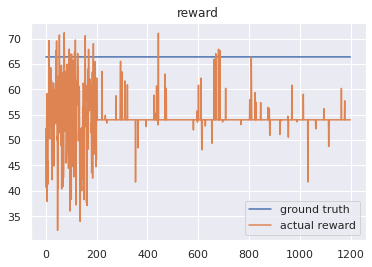

In [11]:
plt.plot([hwithoutconstraints(action)/(np.sqrt(args.card))**1]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5, 1.0, 'infeasibility')

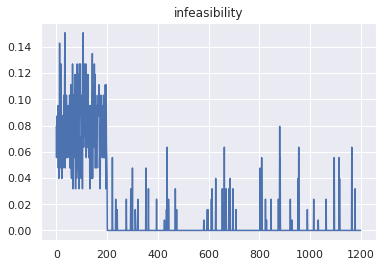

In [12]:
plt.plot(model.feasi)
plt.title('infeasibility')

In [13]:
### mean reward function

a = np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.random.random([24,24]) #np.load('Q.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*(1/(1+np.exp(-iteration))-0.5)*torch.log(torch.mean(wmc)).float()+100*x.dot(Q).dot(x)
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:100*x.dot(Q).dot(x)   #100*(x.dot(a))**3  、100*x.dot(Q).dot(x)

In [14]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_quad(Q,m)
hwithoutconstraints(action2)/10

??
??


515.2184652096213

In [15]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

44-------------
55-------------


  0%|          | 0/1200 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

66-------------


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 1/1200 [00:01<22:15,  1.11s/it, total regret=51.5, % optimal arm=0.00%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 453.85045352219385 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  0%|          | 2/1200 [00:02<21:28,  1.08s/it, total regret=1.45e+4, % optimal arm=0.00%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 458.41422453524467 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  0%|          | 3/1200 [00:03<20:51,  1.05s/it, total regret=2.95e+4, % optimal arm=0.00%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 498.73995661285954 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  0%|          | 4/1200 [00:04<20:44,  1.04s/it, total regret=4.86e+4, % optimal arm=0.00%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 513.985673765138 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  0%|          | 5/1200 [00:05<20:22,  1.02s/it, total regret=6.98e+4, % optimal arm=20.00%]

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 525.7413766599888 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  0%|          | 6/1200 [00:06<20:13,  1.02s/it, total regret=9e+4, % optimal arm=16.67%]   

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 476.81688077689444 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|          | 7/1200 [00:07<20:08,  1.01s/it, total regret=1.03e+5, % optimal arm=14.29%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 520.9064113779335 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  1%|          | 8/1200 [00:08<19:59,  1.01s/it, total regret=1.21e+5, % optimal arm=12.50%]

---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 471.2822601806898 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 9/1200 [00:09<21:04,  1.06s/it, total regret=1.34e+5, % optimal arm=11.11%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 477.58740311231696 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  1%|          | 10/1200 [00:10<21:24,  1.08s/it, total regret=1.6e+5, % optimal arm=10.00%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.53915492326155 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  1%|          | 11/1200 [00:12<30:20,  1.53s/it, total regret=1.89e+5, % optimal arm=9.09%]

hhhhh 501.75113620212926 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  1%|          | 12/1200 [00:13<27:14,  1.38s/it, total regret=2.12e+5, % optimal arm=16.67%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 464.2141113623451 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  1%|          | 13/1200 [00:15<25:07,  1.27s/it, total regret=2.35e+5, % optimal arm=15.38%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 483.2603594032613 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|          | 14/1200 [00:16<23:32,  1.19s/it, total regret=2.49e+5, % optimal arm=21.43%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 471.9002111968928 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  1%|▏         | 15/1200 [00:17<22:22,  1.13s/it, total regret=2.64e+5, % optimal arm=20.00%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 493.10469443233 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  1%|▏         | 16/1200 [00:18<21:39,  1.10s/it, total regret=2.86e+5, % optimal arm=18.75%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 471.61283998873495 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  1%|▏         | 17/1200 [00:19<21:13,  1.08s/it, total regret=3.04e+5, % optimal arm=23.53%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.9301512350182 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 18/1200 [00:20<20:41,  1.05s/it, total regret=3.25e+5, % optimal arm=22.22%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 473.15494763257266 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  2%|▏         | 19/1200 [00:21<20:24,  1.04s/it, total regret=3.39e+5, % optimal arm=21.05%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 464.629198154093 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  2%|▏         | 20/1200 [00:22<20:04,  1.02s/it, total regret=3.52e+5, % optimal arm=25.00%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.44233561493263 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  2%|▏         | 21/1200 [00:25<36:10,  1.84s/it, total regret=3.73e+5, % optimal arm=23.81%]

hhhhh 518.7668420550618 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 22/1200 [00:26<31:06,  1.58s/it, total regret=4.02e+5, % optimal arm=22.73%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 445.3382663059642 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  2%|▏         | 23/1200 [00:27<27:32,  1.40s/it, total regret=4.21e+5, % optimal arm=21.74%]

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.4838161381866 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 24/1200 [00:28<25:13,  1.29s/it, total regret=4.4e+5, % optimal arm=20.83%] 

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 495.19680477517466 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 25/1200 [00:29<23:31,  1.20s/it, total regret=4.67e+5, % optimal arm=20.00%]

---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 451.63524174225967 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 26/1200 [00:30<22:27,  1.15s/it, total regret=4.85e+5, % optimal arm=19.23%]

---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 535.2963969433924 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  2%|▏         | 27/1200 [00:31<21:34,  1.10s/it, total regret=5.13e+5, % optimal arm=18.52%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 488.38906237966444 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  2%|▏         | 28/1200 [00:32<20:58,  1.07s/it, total regret=5.38e+5, % optimal arm=17.86%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 462.9462069852047 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  2%|▏         | 29/1200 [00:33<20:28,  1.05s/it, total regret=5.7e+5, % optimal arm=20.69%] 

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 496.8648908431954 10.000000000000002 tensor(0.1429, dtype=torch.float64)


  2%|▎         | 30/1200 [00:34<20:08,  1.03s/it, total regret=5.92e+5, % optimal arm=20.00%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.9633723618745 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  3%|▎         | 31/1200 [00:39<43:36,  2.24s/it, total regret=6.04e+5, % optimal arm=19.35%]

hhhhh 473.9675510025824 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  3%|▎         | 32/1200 [00:40<36:20,  1.87s/it, total regret=6.34e+5, % optimal arm=18.75%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 456.60162730513525 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  3%|▎         | 33/1200 [00:41<31:14,  1.61s/it, total regret=6.58e+5, % optimal arm=18.18%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 463.6728840194722 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  3%|▎         | 34/1200 [00:42<27:41,  1.43s/it, total regret=6.81e+5, % optimal arm=17.65%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 470.10863296143884 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  3%|▎         | 35/1200 [00:43<25:02,  1.29s/it, total regret=7.08e+5, % optimal arm=20.00%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 507.10452006331144 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  3%|▎         | 36/1200 [00:44<23:20,  1.20s/it, total regret=7.24e+5, % optimal arm=19.44%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 490.1787851850252 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  3%|▎         | 37/1200 [00:45<22:02,  1.14s/it, total regret=7.47e+5, % optimal arm=18.92%]

---------------- 505.3798828125 372.56815934380325 tensor(0.0817, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 461.42513814507595 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  3%|▎         | 38/1200 [00:46<21:17,  1.10s/it, total regret=7.68e+5, % optimal arm=18.42%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 510.2289479476294 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  3%|▎         | 39/1200 [00:47<20:38,  1.07s/it, total regret=7.84e+5, % optimal arm=17.95%]

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 471.89468269098586 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 40/1200 [00:48<20:13,  1.05s/it, total regret=8.02e+5, % optimal arm=17.50%]

---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 462.3581754206029 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  3%|▎         | 41/1200 [00:55<50:34,  2.62s/it, total regret=8.23e+5, % optimal arm=17.07%]

hhhhh 475.90275198917055 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  4%|▎         | 42/1200 [00:56<41:02,  2.13s/it, total regret=8.46e+5, % optimal arm=16.67%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 473.51555386282644 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  4%|▎         | 43/1200 [00:57<34:39,  1.80s/it, total regret=8.62e+5, % optimal arm=16.28%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 499.436873815341 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  4%|▎         | 44/1200 [00:58<29:53,  1.55s/it, total regret=8.76e+5, % optimal arm=15.91%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 533.8870290634405 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  4%|▍         | 45/1200 [00:59<26:39,  1.38s/it, total regret=8.96e+5, % optimal arm=17.78%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 461.8549764956976 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▍         | 46/1200 [01:00<24:22,  1.27s/it, total regret=9.22e+5, % optimal arm=17.39%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 478.1828876939505 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 47/1200 [01:01<22:56,  1.19s/it, total regret=9.43e+5, % optimal arm=17.02%]

---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 488.3392635062414 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 48/1200 [01:02<21:45,  1.13s/it, total regret=9.69e+5, % optimal arm=16.67%]

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 529.9253450891543 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  4%|▍         | 49/1200 [01:03<20:57,  1.09s/it, total regret=9.88e+5, % optimal arm=16.33%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 484.0820684605073 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 50/1200 [01:04<20:13,  1.06s/it, total regret=1.01e+6, % optimal arm=16.00%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 470.8256930815554 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 505.3798828125 467.7070696063044 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  4%|▍         | 51/1200 [01:11<58:01,  3.03s/it, total regret=1.03e+6, % optimal arm=15.69%]

hhhhh 499.3990590107325 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  4%|▍         | 52/1200 [01:12<46:24,  2.43s/it, total regret=1.04e+6, % optimal arm=15.38%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 490.7485291015533 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  4%|▍         | 53/1200 [01:13<38:08,  1.99s/it, total regret=1.06e+6, % optimal arm=16.98%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 497.4838948637185 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 54/1200 [01:14<32:30,  1.70s/it, total regret=1.07e+6, % optimal arm=16.67%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 462.91274448032726 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  5%|▍         | 55/1200 [01:15<28:29,  1.49s/it, total regret=1.1e+6, % optimal arm=18.18%] 

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 497.15776473654165 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  5%|▍         | 56/1200 [01:16<25:33,  1.34s/it, total regret=1.12e+6, % optimal arm=17.86%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 439.5029996066806 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  5%|▍         | 57/1200 [01:17<23:29,  1.23s/it, total regret=1.14e+6, % optimal arm=17.54%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 481.2875025957064 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  5%|▍         | 58/1200 [01:18<21:53,  1.15s/it, total regret=1.16e+6, % optimal arm=18.97%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 468.3840503993167 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  5%|▍         | 59/1200 [01:19<20:54,  1.10s/it, total regret=1.19e+6, % optimal arm=20.34%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 476.9165432952161 10.000000000000002 tensor(0.1587, dtype=torch.float64)


  5%|▌         | 60/1200 [01:20<20:13,  1.06s/it, total regret=1.22e+6, % optimal arm=20.00%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 511.606135361259 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  5%|▌         | 61/1200 [01:29<1:04:59,  3.42s/it, total regret=1.25e+6, % optimal arm=19.67%]

hhhhh 476.3712002234835 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  5%|▌         | 62/1200 [01:30<51:01,  2.69s/it, total regret=1.27e+6, % optimal arm=19.35%]  

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 456.03960672824843 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  5%|▌         | 63/1200 [01:31<41:16,  2.18s/it, total regret=1.28e+6, % optimal arm=19.05%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 483.5047646292968 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  5%|▌         | 64/1200 [01:32<34:38,  1.83s/it, total regret=1.3e+6, % optimal arm=18.75%] 

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 462.8449193700463 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  5%|▌         | 65/1200 [01:33<29:56,  1.58s/it, total regret=1.32e+6, % optimal arm=18.46%]

---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 455.85530190681914 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▌         | 66/1200 [01:34<26:56,  1.43s/it, total regret=1.35e+6, % optimal arm=19.70%]

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 486.2910581311777 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  6%|▌         | 67/1200 [01:35<24:27,  1.30s/it, total regret=1.38e+6, % optimal arm=19.40%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 495.35443251675986 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  6%|▌         | 68/1200 [01:36<23:06,  1.22s/it, total regret=1.4e+6, % optimal arm=19.12%] 

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 475.6244635399099 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  6%|▌         | 69/1200 [01:37<21:47,  1.16s/it, total regret=1.41e+6, % optimal arm=18.84%]

---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 493.60943085192554 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  6%|▌         | 70/1200 [01:38<20:51,  1.11s/it, total regret=1.44e+6, % optimal arm=18.57%]

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 511.5272674306133 10.000000000000002 tensor(0.1349, dtype=torch.float64)
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  6%|▌         | 71/1200 [01:49<1:13:12,  3.89s/it, total regret=1.45e+6, % optimal arm=18.31%]

hhhhh 499.44422829337316 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  6%|▌         | 72/1200 [01:49<56:48,  3.02s/it, total regret=1.47e+6, % optimal arm=18.06%]  

---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 506.43340200578456 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  6%|▌         | 73/1200 [01:51<45:26,  2.42s/it, total regret=1.49e+6, % optimal arm=17.81%]

---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 490.1025373568424 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  6%|▌         | 74/1200 [01:51<37:21,  1.99s/it, total regret=1.51e+6, % optimal arm=17.57%]

---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 480.92874995753715 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  6%|▋         | 75/1200 [01:52<31:40,  1.69s/it, total regret=1.54e+6, % optimal arm=17.33%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 464.3346717709223 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  6%|▋         | 76/1200 [01:54<27:57,  1.49s/it, total regret=1.56e+6, % optimal arm=17.11%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 457.107016067896 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  6%|▋         | 77/1200 [01:55<25:06,  1.34s/it, total regret=1.58e+6, % optimal arm=16.88%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 487.4026976134786 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  6%|▋         | 78/1200 [01:55<23:07,  1.24s/it, total regret=1.6e+6, % optimal arm=16.67%] 

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.7928162635792 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  7%|▋         | 79/1200 [01:57<21:48,  1.17s/it, total regret=1.62e+6, % optimal arm=16.46%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 498.641103428207 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  7%|▋         | 80/1200 [01:58<21:09,  1.13s/it, total regret=1.64e+6, % optimal arm=16.25%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 487.12013139881105 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  7%|▋         | 81/1200 [02:09<1:20:18,  4.31s/it, total regret=1.66e+6, % optimal arm=16.05%]

hhhhh 476.0746155658591 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  7%|▋         | 82/1200 [02:10<1:01:55,  3.32s/it, total regret=1.69e+6, % optimal arm=17.07%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 463.73922170789143 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  7%|▋         | 83/1200 [02:11<48:48,  2.62s/it, total regret=1.7e+6, % optimal arm=16.87%]   

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 491.8747588860654 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  7%|▋         | 84/1200 [02:12<39:33,  2.13s/it, total regret=1.72e+6, % optimal arm=16.67%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 506.5373491893597 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  7%|▋         | 85/1200 [02:13<33:19,  1.79s/it, total regret=1.74e+6, % optimal arm=16.47%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 524.3704374240954 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  7%|▋         | 86/1200 [02:14<28:48,  1.55s/it, total regret=1.76e+6, % optimal arm=16.28%]

---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 470.5659872001954 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  7%|▋         | 87/1200 [02:15<25:34,  1.38s/it, total regret=1.78e+6, % optimal arm=16.09%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 499.115873418812 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  7%|▋         | 88/1200 [02:16<23:25,  1.26s/it, total regret=1.8e+6, % optimal arm=15.91%] 

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 444.4804614742372 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  7%|▋         | 89/1200 [02:17<21:55,  1.18s/it, total regret=1.82e+6, % optimal arm=15.73%]

---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 527.2270919822782 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  8%|▊         | 90/1200 [02:18<20:50,  1.13s/it, total regret=1.84e+6, % optimal arm=15.56%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 489.6953854555501 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  8%|▊         | 91/1200 [02:31<1:25:25,  4.62s/it, total regret=1.86e+6, % optimal arm=15.38%]

hhhhh 493.2192693957068 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  8%|▊         | 92/1200 [02:32<1:05:06,  3.53s/it, total regret=1.88e+6, % optimal arm=15.22%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 501.57961179742506 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  8%|▊         | 93/1200 [02:33<50:57,  2.76s/it, total regret=1.89e+6, % optimal arm=15.05%]  

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 491.2191171406314 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  8%|▊         | 94/1200 [02:34<41:06,  2.23s/it, total regret=1.92e+6, % optimal arm=14.89%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 486.4990541170177 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  8%|▊         | 95/1200 [02:35<34:14,  1.86s/it, total regret=1.95e+6, % optimal arm=14.74%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 466.11559442689617 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  8%|▊         | 96/1200 [02:36<29:33,  1.61s/it, total regret=1.97e+6, % optimal arm=14.58%]

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 482.2690757579469 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  8%|▊         | 97/1200 [02:37<26:08,  1.42s/it, total regret=1.99e+6, % optimal arm=14.43%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 458.66837330179646 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  8%|▊         | 98/1200 [02:38<23:49,  1.30s/it, total regret=2.01e+6, % optimal arm=14.29%]

---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 528.8238604558596 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  8%|▊         | 99/1200 [02:39<22:09,  1.21s/it, total regret=2.02e+6, % optimal arm=14.14%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 540.0408673166584 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  8%|▊         | 100/1200 [02:40<20:47,  1.13s/it, total regret=2.04e+6, % optimal arm=14.00%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 521.0155784178625 10.000000000000002 tensor(0.1508, dtype=torch.float64)
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  8%|▊         | 101/1200 [02:54<1:32:58,  5.08s/it, total regret=2.07e+6, % optimal arm=14.85%]

hhhhh 491.7186114060838 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  8%|▊         | 102/1200 [02:55<1:10:19,  3.84s/it, total regret=2.08e+6, % optimal arm=14.71%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 484.8456412133503 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  9%|▊         | 103/1200 [02:56<54:43,  2.99s/it, total regret=2.11e+6, % optimal arm=14.56%]  

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 486.15367615696863 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  9%|▊         | 104/1200 [02:57<43:44,  2.39s/it, total regret=2.13e+6, % optimal arm=14.42%]

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 474.1536705369601 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  9%|▉         | 105/1200 [02:58<35:58,  1.97s/it, total regret=2.15e+6, % optimal arm=14.29%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 449.68178445310673 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  9%|▉         | 106/1200 [02:59<30:27,  1.67s/it, total regret=2.17e+6, % optimal arm=14.15%]

---------------- 505.3798828125 465.9825367230842 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 498.87898939355557 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  9%|▉         | 107/1200 [03:00<26:51,  1.47s/it, total regret=2.2e+6, % optimal arm=14.95%] 

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 474.96862818309927 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  9%|▉         | 108/1200 [03:01<24:14,  1.33s/it, total regret=2.22e+6, % optimal arm=14.81%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 502.64778285868204 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  9%|▉         | 109/1200 [03:02<22:20,  1.23s/it, total regret=2.24e+6, % optimal arm=14.68%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.10525439224483 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  9%|▉         | 110/1200 [03:03<21:06,  1.16s/it, total regret=2.27e+6, % optimal arm=14.55%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 486.2850214776665 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


  9%|▉         | 111/1200 [03:17<1:31:57,  5.07s/it, total regret=2.29e+6, % optimal arm=15.32%]

hhhhh 488.967685202884 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  9%|▉         | 112/1200 [03:18<1:09:37,  3.84s/it, total regret=2.3e+6, % optimal arm=15.18%] 

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 491.9480386228166 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  9%|▉         | 113/1200 [03:19<54:05,  2.99s/it, total regret=2.32e+6, % optimal arm=15.04%]  

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 482.1354269499423 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 10%|▉         | 114/1200 [03:20<43:07,  2.38s/it, total regret=2.35e+6, % optimal arm=15.79%]

---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 503.86226761976525 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 10%|▉         | 115/1200 [03:21<35:32,  1.97s/it, total regret=2.36e+6, % optimal arm=15.65%]

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 496.5520893137742 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 10%|▉         | 116/1200 [03:22<30:19,  1.68s/it, total regret=2.38e+6, % optimal arm=15.52%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 452.2240249096117 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 10%|▉         | 117/1200 [03:23<26:26,  1.46s/it, total regret=2.41e+6, % optimal arm=15.38%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 482.9944211247132 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 10%|▉         | 118/1200 [03:24<23:55,  1.33s/it, total regret=2.44e+6, % optimal arm=15.25%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 465.5808035020772 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 10%|▉         | 119/1200 [03:25<22:00,  1.22s/it, total regret=2.46e+6, % optimal arm=15.13%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 468.81193337991726 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 10%|█         | 120/1200 [03:26<20:54,  1.16s/it, total regret=2.47e+6, % optimal arm=15.00%]

---------------- 505.3798828125 485.59550520000886 tensor(0.0873, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 490.3722313683049 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 10%|█         | 121/1200 [03:40<1:29:23,  4.97s/it, total regret=2.5e+6, % optimal arm=14.88%]

hhhhh 502.5161274209419 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 10%|█         | 122/1200 [03:41<1:07:53,  3.78s/it, total regret=2.52e+6, % optimal arm=14.75%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 519.6223971367627 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 10%|█         | 123/1200 [03:42<52:55,  2.95s/it, total regret=2.54e+6, % optimal arm=15.45%]  

---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.2494802013724 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 10%|█         | 124/1200 [03:43<42:14,  2.36s/it, total regret=2.56e+6, % optimal arm=15.32%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 502.3597283862979 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 10%|█         | 125/1200 [03:44<34:48,  1.94s/it, total regret=2.58e+6, % optimal arm=15.20%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 481.67382608336527 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 10%|█         | 126/1200 [03:45<29:42,  1.66s/it, total regret=2.61e+6, % optimal arm=15.08%]

---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 473.6236514229135 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 11%|█         | 127/1200 [03:46<26:05,  1.46s/it, total regret=2.63e+6, % optimal arm=14.96%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 466.8047894734556 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 11%|█         | 128/1200 [03:47<23:29,  1.32s/it, total regret=2.66e+6, % optimal arm=14.84%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 477.01963370503574 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 11%|█         | 129/1200 [03:48<21:53,  1.23s/it, total regret=2.67e+6, % optimal arm=14.73%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 514.1296002606515 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 11%|█         | 130/1200 [03:49<20:38,  1.16s/it, total regret=2.69e+6, % optimal arm=14.62%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 484.46203223249347 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 11%|█         | 131/1200 [04:03<1:30:33,  5.08s/it, total regret=2.71e+6, % optimal arm=14.50%]

hhhhh 499.02143987836274 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 11%|█         | 132/1200 [04:04<1:08:38,  3.86s/it, total regret=2.73e+6, % optimal arm=14.39%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 472.0627196503723 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 11%|█         | 133/1200 [04:05<53:07,  2.99s/it, total regret=2.76e+6, % optimal arm=15.04%]  

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 466.2821373893716 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 11%|█         | 134/1200 [04:06<42:32,  2.39s/it, total regret=2.78e+6, % optimal arm=14.93%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 469.56639617244093 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 11%|█▏        | 135/1200 [04:07<34:58,  1.97s/it, total regret=2.8e+6, % optimal arm=14.81%] 

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.17172608882595 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█▏        | 136/1200 [04:08<30:07,  1.70s/it, total regret=2.83e+6, % optimal arm=14.71%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 508.8949165747482 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 11%|█▏        | 137/1200 [04:09<26:15,  1.48s/it, total regret=2.84e+6, % optimal arm=14.60%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 514.0756677331952 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 12%|█▏        | 138/1200 [04:10<23:48,  1.35s/it, total regret=2.87e+6, % optimal arm=14.49%]

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 454.90303751172877 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 12%|█▏        | 139/1200 [04:11<21:52,  1.24s/it, total regret=2.9e+6, % optimal arm=14.39%] 

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 476.6997648467359 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 12%|█▏        | 140/1200 [04:12<20:36,  1.17s/it, total regret=2.93e+6, % optimal arm=15.00%]

---------------- 505.3798828125 450.99272470779425 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 470.1435701513038 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 12%|█▏        | 141/1200 [04:26<1:28:03,  4.99s/it, total regret=2.95e+6, % optimal arm=14.89%]

hhhhh 474.4506396575518 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 12%|█▏        | 142/1200 [04:27<1:06:59,  3.80s/it, total regret=2.97e+6, % optimal arm=15.49%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 508.44507209488484 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 143/1200 [04:28<52:01,  2.95s/it, total regret=2.99e+6, % optimal arm=15.38%]  

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 507.4934888761499 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 12%|█▏        | 144/1200 [04:29<41:32,  2.36s/it, total regret=3.02e+6, % optimal arm=15.97%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 460.53783239501456 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 12%|█▏        | 145/1200 [04:30<34:17,  1.95s/it, total regret=3.04e+6, % optimal arm=15.86%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 519.7791895277504 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 146/1200 [04:31<29:09,  1.66s/it, total regret=3.06e+6, % optimal arm=15.75%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 462.5292237340853 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 12%|█▏        | 147/1200 [04:32<25:36,  1.46s/it, total regret=3.09e+6, % optimal arm=15.65%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 507.3656669522933 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 12%|█▏        | 148/1200 [04:33<23:14,  1.33s/it, total regret=3.11e+6, % optimal arm=15.54%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 473.00396095320696 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 12%|█▏        | 149/1200 [04:34<21:29,  1.23s/it, total regret=3.13e+6, % optimal arm=16.11%]

---------------- 505.3798828125 476.8217346719011 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.19622705674004 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 12%|█▎        | 150/1200 [04:35<20:07,  1.15s/it, total regret=3.16e+6, % optimal arm=16.00%]

---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 467.87930953790254 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 13%|█▎        | 151/1200 [04:49<1:27:40,  5.01s/it, total regret=3.18e+6, % optimal arm=15.89%]

hhhhh 513.477436699462 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 13%|█▎        | 152/1200 [04:50<1:06:30,  3.81s/it, total regret=3.21e+6, % optimal arm=15.79%]

---------------- 505.3798828125 459.6123193542766 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 499.9272339107075 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 13%|█▎        | 153/1200 [04:51<51:48,  2.97s/it, total regret=3.23e+6, % optimal arm=15.69%]  

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 516.1323066209525 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 13%|█▎        | 154/1200 [04:52<41:23,  2.37s/it, total regret=3.25e+6, % optimal arm=15.58%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 451.4994088468269 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 13%|█▎        | 155/1200 [04:53<33:58,  1.95s/it, total regret=3.28e+6, % optimal arm=15.48%]

---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.6470715240266 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 13%|█▎        | 156/1200 [04:54<29:03,  1.67s/it, total regret=3.3e+6, % optimal arm=15.38%] 

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 448.7338345630435 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 13%|█▎        | 157/1200 [04:55<25:33,  1.47s/it, total regret=3.31e+6, % optimal arm=15.29%]

---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.159666361237 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 13%|█▎        | 158/1200 [04:56<22:58,  1.32s/it, total regret=3.34e+6, % optimal arm=15.82%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 486.4175035090387 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 13%|█▎        | 159/1200 [04:57<21:08,  1.22s/it, total regret=3.35e+6, % optimal arm=15.72%]

---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 474.09777979008874 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 13%|█▎        | 160/1200 [04:58<19:52,  1.15s/it, total regret=3.37e+6, % optimal arm=16.25%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 479.41515030138066 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 505.3798828125 476.1717977024336 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 13%|█▎        | 161/1200 [05:13<1:29:08,  5.15s/it, total regret=3.39e+6, % optimal arm=16.15%]

hhhhh 476.25014945790383 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▎        | 162/1200 [05:13<1:07:28,  3.90s/it, total regret=3.42e+6, % optimal arm=16.05%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 474.09424212214236 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 14%|█▎        | 163/1200 [05:14<52:14,  3.02s/it, total regret=3.44e+6, % optimal arm=15.95%]  

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.9451695900973 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 14%|█▎        | 164/1200 [05:16<41:57,  2.43s/it, total regret=3.46e+6, % optimal arm=16.46%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 463.8538477414669 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 14%|█▍        | 165/1200 [05:17<34:52,  2.02s/it, total regret=3.49e+6, % optimal arm=16.36%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.0129822404453 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 14%|█▍        | 166/1200 [05:18<29:50,  1.73s/it, total regret=3.51e+6, % optimal arm=16.87%]

---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 468.6203498814109 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 14%|█▍        | 167/1200 [05:19<26:12,  1.52s/it, total regret=3.54e+6, % optimal arm=16.77%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.592170661704 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▍        | 168/1200 [05:20<23:31,  1.37s/it, total regret=3.55e+6, % optimal arm=16.67%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 474.4251216635599 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 14%|█▍        | 169/1200 [05:21<21:46,  1.27s/it, total regret=3.58e+6, % optimal arm=16.57%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 487.42474664365363 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▍        | 170/1200 [05:22<20:26,  1.19s/it, total regret=3.6e+6, % optimal arm=17.06%] 

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.7662951674165 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 14%|█▍        | 171/1200 [05:36<1:28:29,  5.16s/it, total regret=3.62e+6, % optimal arm=16.96%]

hhhhh 447.41389545683415 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▍        | 172/1200 [05:37<1:06:54,  3.91s/it, total regret=3.66e+6, % optimal arm=16.86%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 470.0254388377816 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 14%|█▍        | 173/1200 [05:38<51:59,  3.04s/it, total regret=3.68e+6, % optimal arm=16.76%]  

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.2723430089487 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 14%|█▍        | 174/1200 [05:39<41:25,  2.42s/it, total regret=3.71e+6, % optimal arm=16.67%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 498.1437408512407 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 15%|█▍        | 175/1200 [05:40<33:52,  1.98s/it, total regret=3.74e+6, % optimal arm=16.57%]

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 472.6065573878306 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 15%|█▍        | 176/1200 [05:41<28:37,  1.68s/it, total regret=3.76e+6, % optimal arm=16.48%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 498.8373919720112 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 15%|█▍        | 177/1200 [05:42<24:59,  1.47s/it, total regret=3.78e+6, % optimal arm=16.38%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 506.6316399384197 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 15%|█▍        | 178/1200 [05:43<22:38,  1.33s/it, total regret=3.8e+6, % optimal arm=16.29%] 

---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 497.056161270697 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 15%|█▍        | 179/1200 [05:44<20:56,  1.23s/it, total regret=3.83e+6, % optimal arm=16.20%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 489.49590854254745 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 15%|█▌        | 180/1200 [05:45<19:54,  1.17s/it, total regret=3.86e+6, % optimal arm=16.11%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 497.0170912056127 10.000000000000002 tensor(0.1508, dtype=torch.float64)
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 15%|█▌        | 181/1200 [05:59<1:25:27,  5.03s/it, total regret=3.87e+6, % optimal arm=16.02%]

hhhhh 466.034691848712 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▌        | 182/1200 [06:00<1:05:01,  3.83s/it, total regret=3.89e+6, % optimal arm=16.48%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 477.61637892280714 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 15%|█▌        | 183/1200 [06:01<50:27,  2.98s/it, total regret=3.92e+6, % optimal arm=16.39%]  

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 489.0099638724547 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 15%|█▌        | 184/1200 [06:02<40:17,  2.38s/it, total regret=3.93e+6, % optimal arm=16.30%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 456.86831941985923 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 15%|█▌        | 185/1200 [06:03<33:15,  1.97s/it, total regret=3.96e+6, % optimal arm=16.22%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 525.3783619752272 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▌        | 186/1200 [06:04<28:20,  1.68s/it, total regret=3.99e+6, % optimal arm=16.13%]

---------------- 505.3798828125 459.6018539997396 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 499.66897760863753 10.000000000000002 tensor(0.1587, dtype=torch.float64)


 16%|█▌        | 187/1200 [06:05<24:52,  1.47s/it, total regret=4e+6, % optimal arm=16.58%]   

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 480.0194239631554 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 16%|█▌        | 188/1200 [06:06<22:30,  1.33s/it, total regret=4.03e+6, % optimal arm=16.49%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 450.83311739925256 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▌        | 189/1200 [06:07<20:36,  1.22s/it, total regret=4.05e+6, % optimal arm=16.40%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 477.8380079365195 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 16%|█▌        | 190/1200 [06:08<19:27,  1.16s/it, total regret=4.08e+6, % optimal arm=16.84%]

---------------- 505.3798828125 474.95710032563653 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 497.32404963242135 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 16%|█▌        | 191/1200 [06:22<1:25:57,  5.11s/it, total regret=4.1e+6, % optimal arm=16.75%]

hhhhh 486.9006003877205 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 16%|█▌        | 192/1200 [06:23<1:05:16,  3.89s/it, total regret=4.12e+6, % optimal arm=16.67%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 469.9803931578783 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 16%|█▌        | 193/1200 [06:24<50:35,  3.01s/it, total regret=4.14e+6, % optimal arm=17.10%]  

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 460.18309218486405 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▌        | 194/1200 [06:25<40:14,  2.40s/it, total regret=4.16e+6, % optimal arm=17.53%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 495.20561672184647 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▋        | 195/1200 [06:26<33:04,  1.97s/it, total regret=4.18e+6, % optimal arm=17.44%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 486.79925815932154 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▋        | 196/1200 [06:27<28:09,  1.68s/it, total regret=4.2e+6, % optimal arm=17.35%] 

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 439.431229837543 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 16%|█▋        | 197/1200 [06:28<24:35,  1.47s/it, total regret=4.22e+6, % optimal arm=17.26%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 511.75583040518814 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 16%|█▋        | 198/1200 [06:29<22:08,  1.33s/it, total regret=4.24e+6, % optimal arm=17.17%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 545.6597883553964 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 17%|█▋        | 199/1200 [06:30<20:17,  1.22s/it, total regret=4.25e+6, % optimal arm=17.09%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.9075874568714 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 17%|█▋        | 200/1200 [06:31<19:08,  1.15s/it, total regret=4.27e+6, % optimal arm=17.00%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 422.1506503354461 10.000000000000002 tensor(0.0476, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 17%|█▋        | 201/1200 [06:49<1:42:31,  6.16s/it, total regret=4.29e+6, % optimal arm=16.92%]

hhhhh 499.00713021364396 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 17%|█▋        | 202/1200 [06:54<1:35:27,  5.74s/it, total regret=4.29e+6, % optimal arm=16.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 203/1200 [06:59<1:30:32,  5.45s/it, total regret=4.3e+6, % optimal arm=16.75%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 204/1200 [07:03<1:27:18,  5.26s/it, total regret=4.31e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 205/1200 [07:09<1:26:49,  5.24s/it, total regret=4.31e+6, % optimal arm=16.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 206/1200 [07:14<1:24:47,  5.12s/it, total regret=4.32e+6, % optimal arm=16.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 207/1200 [07:18<1:23:11,  5.03s/it, total regret=4.33e+6, % optimal arm=16.43%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 208/1200 [07:23<1:21:54,  4.95s/it, total regret=4.34e+6, % optimal arm=16.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 209/1200 [07:28<1:21:03,  4.91s/it, total regret=4.34e+6, % optimal arm=16.75%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 210/1200 [07:33<1:20:42,  4.89s/it, total regret=4.35e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.0701963895029 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 18%|█▊        | 211/1200 [07:51<2:25:40,  8.84s/it, total regret=4.36e+6, % optimal arm=16.59%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 212/1200 [07:56<2:05:36,  7.63s/it, total regret=4.37e+6, % optimal arm=16.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 213/1200 [08:01<1:52:11,  6.82s/it, total regret=4.37e+6, % optimal arm=16.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 214/1200 [08:05<1:42:32,  6.24s/it, total regret=4.38e+6, % optimal arm=16.82%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 215/1200 [08:10<1:36:07,  5.86s/it, total regret=4.39e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 216/1200 [08:15<1:30:51,  5.54s/it, total regret=4.39e+6, % optimal arm=17.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 217/1200 [08:20<1:27:22,  5.33s/it, total regret=4.4e+6, % optimal arm=17.05%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 218/1200 [08:25<1:24:56,  5.19s/it, total regret=4.41e+6, % optimal arm=16.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 219/1200 [08:30<1:23:00,  5.08s/it, total regret=4.42e+6, % optimal arm=16.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 220/1200 [08:35<1:21:47,  5.01s/it, total regret=4.42e+6, % optimal arm=17.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 18%|█▊        | 221/1200 [08:53<2:26:21,  8.97s/it, total regret=4.43e+6, % optimal arm=17.19%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 222/1200 [08:58<2:06:17,  7.75s/it, total regret=4.44e+6, % optimal arm=17.12%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 223/1200 [09:03<1:52:00,  6.88s/it, total regret=4.45e+6, % optimal arm=17.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 224/1200 [09:07<1:41:54,  6.26s/it, total regret=4.45e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 225/1200 [09:12<1:35:03,  5.85s/it, total regret=4.46e+6, % optimal arm=16.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 226/1200 [09:17<1:30:34,  5.58s/it, total regret=4.47e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 227/1200 [09:22<1:25:53,  5.30s/it, total regret=4.47e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 228/1200 [09:27<1:23:18,  5.14s/it, total regret=4.48e+6, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 229/1200 [09:31<1:21:00,  5.01s/it, total regret=4.49e+6, % optimal arm=17.03%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 230/1200 [09:36<1:19:27,  4.92s/it, total regret=4.5e+6, % optimal arm=16.96%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 19%|█▉        | 231/1200 [09:54<2:21:22,  8.75s/it, total regret=4.5e+6, % optimal arm=16.88%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 232/1200 [10:00<2:08:02,  7.94s/it, total regret=4.51e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 233/1200 [10:05<1:52:51,  7.00s/it, total regret=4.52e+6, % optimal arm=17.17%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 234/1200 [10:10<1:43:46,  6.45s/it, total regret=4.53e+6, % optimal arm=17.09%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 235/1200 [10:15<1:36:02,  5.97s/it, total regret=4.53e+6, % optimal arm=17.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 236/1200 [10:19<1:29:53,  5.59s/it, total regret=4.54e+6, % optimal arm=16.95%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 237/1200 [10:24<1:25:50,  5.35s/it, total regret=4.55e+6, % optimal arm=16.88%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 238/1200 [10:29<1:23:14,  5.19s/it, total regret=4.55e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 239/1200 [10:34<1:20:56,  5.05s/it, total regret=4.56e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 240/1200 [10:38<1:19:42,  4.98s/it, total regret=4.57e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 20%|██        | 241/1200 [10:56<2:21:16,  8.84s/it, total regret=4.58e+6, % optimal arm=16.60%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 242/1200 [11:01<2:01:39,  7.62s/it, total regret=4.58e+6, % optimal arm=16.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 243/1200 [11:06<1:47:24,  6.73s/it, total regret=4.59e+6, % optimal arm=16.46%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 244/1200 [11:10<1:37:55,  6.15s/it, total regret=4.6e+6, % optimal arm=16.39%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 245/1200 [11:15<1:31:13,  5.73s/it, total regret=4.61e+6, % optimal arm=16.33%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 246/1200 [11:20<1:26:14,  5.42s/it, total regret=4.61e+6, % optimal arm=16.26%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 247/1200 [11:25<1:22:32,  5.20s/it, total regret=4.62e+6, % optimal arm=16.19%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 248/1200 [11:29<1:19:51,  5.03s/it, total regret=4.63e+6, % optimal arm=16.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 249/1200 [11:34<1:18:09,  4.93s/it, total regret=4.63e+6, % optimal arm=16.47%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 250/1200 [11:39<1:17:10,  4.87s/it, total regret=4.64e+6, % optimal arm=16.40%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 21%|██        | 251/1200 [11:57<2:20:44,  8.90s/it, total regret=4.65e+6, % optimal arm=16.33%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 252/1200 [12:02<2:01:20,  7.68s/it, total regret=4.66e+6, % optimal arm=16.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 253/1200 [12:07<1:48:05,  6.85s/it, total regret=4.66e+6, % optimal arm=16.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 254/1200 [12:12<1:39:12,  6.29s/it, total regret=4.67e+6, % optimal arm=16.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 255/1200 [12:17<1:31:58,  5.84s/it, total regret=4.68e+6, % optimal arm=16.08%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 256/1200 [12:21<1:26:26,  5.49s/it, total regret=4.69e+6, % optimal arm=16.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 257/1200 [12:26<1:23:06,  5.29s/it, total regret=4.69e+6, % optimal arm=16.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 258/1200 [12:31<1:21:43,  5.21s/it, total regret=4.7e+6, % optimal arm=16.28%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 259/1200 [12:36<1:20:37,  5.14s/it, total regret=4.71e+6, % optimal arm=16.22%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 260/1200 [12:41<1:19:02,  5.05s/it, total regret=4.71e+6, % optimal arm=16.15%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.87066470108385 10.000000000000002 tensor(0.0238, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 22%|██▏       | 261/1200 [13:00<2:23:56,  9.20s/it, total regret=4.72e+6, % optimal arm=16.09%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 262/1200 [13:05<2:04:33,  7.97s/it, total regret=4.73e+6, % optimal arm=16.03%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 263/1200 [13:10<1:50:05,  7.05s/it, total regret=4.74e+6, % optimal arm=15.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 264/1200 [13:15<1:39:21,  6.37s/it, total regret=4.74e+6, % optimal arm=16.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 265/1200 [13:19<1:31:52,  5.90s/it, total regret=4.75e+6, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 266/1200 [13:24<1:27:47,  5.64s/it, total regret=4.76e+6, % optimal arm=16.54%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 267/1200 [13:29<1:23:35,  5.38s/it, total regret=4.76e+6, % optimal arm=16.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 268/1200 [13:34<1:20:43,  5.20s/it, total regret=4.77e+6, % optimal arm=16.42%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 269/1200 [13:39<1:18:40,  5.07s/it, total regret=4.78e+6, % optimal arm=16.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▎       | 270/1200 [13:43<1:17:07,  4.98s/it, total regret=4.79e+6, % optimal arm=16.30%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 23%|██▎       | 271/1200 [14:01<2:16:19,  8.80s/it, total regret=4.79e+6, % optimal arm=16.24%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 272/1200 [14:06<1:57:33,  7.60s/it, total regret=4.8e+6, % optimal arm=16.18%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 273/1200 [14:11<1:44:52,  6.79s/it, total regret=4.81e+6, % optimal arm=16.12%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 274/1200 [14:16<1:35:20,  6.18s/it, total regret=4.82e+6, % optimal arm=16.42%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 275/1200 [14:20<1:28:32,  5.74s/it, total regret=4.82e+6, % optimal arm=16.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 276/1200 [14:25<1:23:29,  5.42s/it, total regret=4.83e+6, % optimal arm=16.30%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 277/1200 [14:30<1:20:36,  5.24s/it, total regret=4.84e+6, % optimal arm=16.25%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 278/1200 [14:35<1:18:06,  5.08s/it, total regret=4.84e+6, % optimal arm=16.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 279/1200 [14:39<1:16:37,  4.99s/it, total regret=4.85e+6, % optimal arm=16.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 280/1200 [14:44<1:15:11,  4.90s/it, total regret=4.86e+6, % optimal arm=16.79%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 23%|██▎       | 281/1200 [15:02<2:14:18,  8.77s/it, total regret=4.87e+6, % optimal arm=16.73%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 282/1200 [15:07<1:55:58,  7.58s/it, total regret=4.87e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 283/1200 [15:12<1:44:34,  6.84s/it, total regret=4.88e+6, % optimal arm=16.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 284/1200 [15:16<1:34:36,  6.20s/it, total regret=4.89e+6, % optimal arm=16.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 285/1200 [15:21<1:28:11,  5.78s/it, total regret=4.89e+6, % optimal arm=16.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 470.02539871975966 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 286/1200 [15:26<1:23:29,  5.48s/it, total regret=4.9e+6, % optimal arm=16.43%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 287/1200 [15:31<1:20:27,  5.29s/it, total regret=4.91e+6, % optimal arm=16.38%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 288/1200 [15:36<1:18:16,  5.15s/it, total regret=4.92e+6, % optimal arm=16.32%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 289/1200 [15:40<1:16:33,  5.04s/it, total regret=4.92e+6, % optimal arm=16.26%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 290/1200 [15:45<1:15:32,  4.98s/it, total regret=4.93e+6, % optimal arm=16.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 24%|██▍       | 291/1200 [16:03<2:15:11,  8.92s/it, total regret=4.94e+6, % optimal arm=16.15%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 292/1200 [16:08<1:56:51,  7.72s/it, total regret=4.95e+6, % optimal arm=16.10%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 293/1200 [16:13<1:43:36,  6.85s/it, total regret=4.95e+6, % optimal arm=16.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 294/1200 [16:18<1:34:28,  6.26s/it, total regret=4.96e+6, % optimal arm=15.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.95710032563653 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 25%|██▍       | 295/1200 [16:23<1:29:35,  5.94s/it, total regret=4.97e+6, % optimal arm=16.27%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 296/1200 [16:33<1:47:46,  7.15s/it, total regret=4.97e+6, % optimal arm=16.22%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 297/1200 [16:38<1:37:19,  6.47s/it, total regret=4.98e+6, % optimal arm=16.16%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 298/1200 [16:43<1:30:00,  5.99s/it, total regret=4.99e+6, % optimal arm=16.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 25%|██▍       | 299/1200 [16:51<1:36:59,  6.46s/it, total regret=5e+6, % optimal arm=16.05%]   

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 300/1200 [17:03<2:02:20,  8.16s/it, total regret=5e+6, % optimal arm=16.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 25%|██▌       | 301/1200 [17:27<3:15:50, 13.07s/it, total regret=5.01e+6, % optimal arm=16.28%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 302/1200 [17:32<2:38:47, 10.61s/it, total regret=5.02e+6, % optimal arm=16.23%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 303/1200 [17:37<2:12:58,  8.89s/it, total regret=5.03e+6, % optimal arm=16.17%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 304/1200 [17:42<1:54:12,  7.65s/it, total regret=5.03e+6, % optimal arm=16.12%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 475.0494890266394 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 305/1200 [17:46<1:41:24,  6.80s/it, total regret=5.04e+6, % optimal arm=16.39%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 306/1200 [17:51<1:32:20,  6.20s/it, total regret=5.05e+6, % optimal arm=16.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 307/1200 [17:56<1:26:19,  5.80s/it, total regret=5.05e+6, % optimal arm=16.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 308/1200 [18:01<1:21:57,  5.51s/it, total regret=5.06e+6, % optimal arm=16.23%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 309/1200 [18:06<1:19:25,  5.35s/it, total regret=5.07e+6, % optimal arm=16.18%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 310/1200 [18:11<1:17:24,  5.22s/it, total regret=5.08e+6, % optimal arm=16.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 26%|██▌       | 311/1200 [18:29<2:13:24,  9.00s/it, total regret=5.08e+6, % optimal arm=16.40%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 312/1200 [18:34<1:54:38,  7.75s/it, total regret=5.09e+6, % optimal arm=16.35%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 313/1200 [18:38<1:41:18,  6.85s/it, total regret=5.1e+6, % optimal arm=16.29%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 314/1200 [18:43<1:32:06,  6.24s/it, total regret=5.11e+6, % optimal arm=16.24%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 315/1200 [18:48<1:25:59,  5.83s/it, total regret=5.11e+6, % optimal arm=16.19%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 316/1200 [18:53<1:21:32,  5.53s/it, total regret=5.12e+6, % optimal arm=16.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 317/1200 [18:58<1:18:18,  5.32s/it, total regret=5.13e+6, % optimal arm=16.09%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 318/1200 [19:03<1:16:14,  5.19s/it, total regret=5.13e+6, % optimal arm=16.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 319/1200 [19:07<1:14:18,  5.06s/it, total regret=5.14e+6, % optimal arm=15.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 320/1200 [19:12<1:13:29,  5.01s/it, total regret=5.15e+6, % optimal arm=15.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 27%|██▋       | 321/1200 [19:30<2:10:54,  8.94s/it, total regret=5.16e+6, % optimal arm=15.89%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 322/1200 [19:35<1:52:56,  7.72s/it, total regret=5.16e+6, % optimal arm=15.84%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 323/1200 [19:40<1:40:09,  6.85s/it, total regret=5.17e+6, % optimal arm=15.79%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.95710032563653 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 324/1200 [19:45<1:31:22,  6.26s/it, total regret=5.18e+6, % optimal arm=15.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 325/1200 [19:50<1:24:48,  5.82s/it, total regret=5.19e+6, % optimal arm=15.69%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 326/1200 [19:54<1:20:33,  5.53s/it, total regret=5.19e+6, % optimal arm=15.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 327/1200 [19:59<1:17:07,  5.30s/it, total regret=5.2e+6, % optimal arm=15.60%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 328/1200 [20:04<1:15:25,  5.19s/it, total regret=5.21e+6, % optimal arm=15.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 329/1200 [20:10<1:17:12,  5.32s/it, total regret=5.21e+6, % optimal arm=15.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 330/1200 [20:15<1:15:01,  5.17s/it, total regret=5.22e+6, % optimal arm=15.45%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 28%|██▊       | 331/1200 [20:33<2:14:17,  9.27s/it, total regret=5.23e+6, % optimal arm=15.41%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 332/1200 [20:38<1:54:36,  7.92s/it, total regret=5.24e+6, % optimal arm=15.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 333/1200 [20:43<1:41:05,  7.00s/it, total regret=5.24e+6, % optimal arm=15.62%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 334/1200 [20:48<1:31:00,  6.31s/it, total regret=5.25e+6, % optimal arm=15.57%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 335/1200 [20:53<1:25:48,  5.95s/it, total regret=5.26e+6, % optimal arm=15.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 336/1200 [20:58<1:21:03,  5.63s/it, total regret=5.26e+6, % optimal arm=15.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 337/1200 [21:03<1:17:30,  5.39s/it, total regret=5.27e+6, % optimal arm=15.43%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 338/1200 [21:07<1:14:48,  5.21s/it, total regret=5.28e+6, % optimal arm=15.38%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 339/1200 [21:12<1:12:53,  5.08s/it, total regret=5.29e+6, % optimal arm=15.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 340/1200 [21:17<1:11:32,  4.99s/it, total regret=5.29e+6, % optimal arm=15.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 28%|██▊       | 341/1200 [21:35<2:06:46,  8.85s/it, total regret=5.3e+6, % optimal arm=15.25%] 

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 342/1200 [21:40<1:49:01,  7.62s/it, total regret=5.31e+6, % optimal arm=15.20%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 343/1200 [21:44<1:36:21,  6.75s/it, total regret=5.32e+6, % optimal arm=15.16%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 29%|██▊       | 344/1200 [21:52<1:41:25,  7.11s/it, total regret=5.32e+6, % optimal arm=15.12%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 29%|██▉       | 345/1200 [22:04<2:02:59,  8.63s/it, total regret=5.33e+6, % optimal arm=15.07%]

---------------- 505.3798828125 494.4166778106729 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 29%|██▉       | 346/1200 [22:17<2:19:15,  9.78s/it, total regret=5.34e+6, % optimal arm=15.03%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 29%|██▉       | 347/1200 [22:29<2:28:40, 10.46s/it, total regret=5.34e+6, % optimal arm=14.99%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 348/1200 [22:36<2:14:28,  9.47s/it, total regret=5.35e+6, % optimal arm=14.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 349/1200 [22:41<1:54:51,  8.10s/it, total regret=5.36e+6, % optimal arm=14.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 350/1200 [22:46<1:40:39,  7.11s/it, total regret=5.37e+6, % optimal arm=14.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 459.6018539997396 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 29%|██▉       | 351/1200 [23:04<2:27:16, 10.41s/it, total regret=5.37e+6, % optimal arm=14.81%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 352/1200 [23:09<2:03:18,  8.72s/it, total regret=5.38e+6, % optimal arm=14.77%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 353/1200 [23:14<1:46:56,  7.58s/it, total regret=5.39e+6, % optimal arm=14.73%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 354/1200 [23:18<1:35:09,  6.75s/it, total regret=5.4e+6, % optimal arm=14.69%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 355/1200 [23:23<1:27:00,  6.18s/it, total regret=5.4e+6, % optimal arm=14.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 356/1200 [23:28<1:21:49,  5.82s/it, total regret=5.41e+6, % optimal arm=14.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 357/1200 [23:34<1:19:42,  5.67s/it, total regret=5.42e+6, % optimal arm=14.57%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 358/1200 [23:39<1:16:40,  5.46s/it, total regret=5.42e+6, % optimal arm=14.80%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 359/1200 [23:43<1:13:31,  5.25s/it, total regret=5.43e+6, % optimal arm=15.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 360/1200 [23:48<1:11:55,  5.14s/it, total regret=5.44e+6, % optimal arm=15.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 30%|███       | 361/1200 [24:06<2:05:23,  8.97s/it, total regret=5.45e+6, % optimal arm=14.96%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 362/1200 [24:11<1:48:51,  7.79s/it, total regret=5.45e+6, % optimal arm=14.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 363/1200 [24:16<1:36:52,  6.94s/it, total regret=5.46e+6, % optimal arm=14.88%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 364/1200 [24:21<1:28:45,  6.37s/it, total regret=5.47e+6, % optimal arm=15.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 365/1200 [24:26<1:22:49,  5.95s/it, total regret=5.48e+6, % optimal arm=15.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 366/1200 [24:31<1:18:09,  5.62s/it, total regret=5.48e+6, % optimal arm=15.30%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 367/1200 [24:36<1:14:37,  5.38s/it, total regret=5.49e+6, % optimal arm=15.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 368/1200 [24:41<1:11:59,  5.19s/it, total regret=5.5e+6, % optimal arm=15.49%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 369/1200 [24:45<1:10:23,  5.08s/it, total regret=5.5e+6, % optimal arm=15.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 370/1200 [24:50<1:09:00,  4.99s/it, total regret=5.51e+6, % optimal arm=15.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 31%|███       | 371/1200 [25:08<2:02:30,  8.87s/it, total regret=5.52e+6, % optimal arm=15.90%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 372/1200 [25:13<1:46:52,  7.74s/it, total regret=5.53e+6, % optimal arm=15.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 373/1200 [25:18<1:35:03,  6.90s/it, total regret=5.53e+6, % optimal arm=15.82%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 374/1200 [25:23<1:26:24,  6.28s/it, total regret=5.54e+6, % optimal arm=15.78%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 375/1200 [25:28<1:20:38,  5.86s/it, total regret=5.55e+6, % optimal arm=15.73%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 376/1200 [25:33<1:16:19,  5.56s/it, total regret=5.56e+6, % optimal arm=15.69%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 377/1200 [25:37<1:13:12,  5.34s/it, total regret=5.56e+6, % optimal arm=15.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 378/1200 [25:42<1:10:58,  5.18s/it, total regret=5.57e+6, % optimal arm=15.87%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 379/1200 [25:47<1:09:17,  5.06s/it, total regret=5.58e+6, % optimal arm=16.09%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 380/1200 [25:52<1:08:22,  5.00s/it, total regret=5.58e+6, % optimal arm=16.05%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 32%|███▏      | 381/1200 [26:11<2:07:32,  9.34s/it, total regret=5.59e+6, % optimal arm=16.27%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 382/1200 [26:16<1:48:36,  7.97s/it, total regret=5.6e+6, % optimal arm=16.23%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 383/1200 [26:21<1:35:27,  7.01s/it, total regret=5.61e+6, % optimal arm=16.19%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 384/1200 [26:26<1:26:12,  6.34s/it, total regret=5.61e+6, % optimal arm=16.15%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 385/1200 [26:30<1:19:37,  5.86s/it, total regret=5.62e+6, % optimal arm=16.10%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 386/1200 [26:35<1:15:27,  5.56s/it, total regret=5.63e+6, % optimal arm=16.06%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 387/1200 [26:40<1:12:12,  5.33s/it, total regret=5.64e+6, % optimal arm=16.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 388/1200 [26:45<1:10:11,  5.19s/it, total regret=5.64e+6, % optimal arm=15.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 389/1200 [26:50<1:08:31,  5.07s/it, total regret=5.65e+6, % optimal arm=15.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▎      | 390/1200 [26:55<1:07:42,  5.02s/it, total regret=5.66e+6, % optimal arm=15.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 33%|███▎      | 391/1200 [27:13<2:01:36,  9.02s/it, total regret=5.66e+6, % optimal arm=15.86%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 392/1200 [27:18<1:45:08,  7.81s/it, total regret=5.67e+6, % optimal arm=15.82%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 393/1200 [27:23<1:32:22,  6.87s/it, total regret=5.68e+6, % optimal arm=16.03%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 394/1200 [27:28<1:24:44,  6.31s/it, total regret=5.69e+6, % optimal arm=15.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 395/1200 [27:32<1:18:33,  5.86s/it, total regret=5.69e+6, % optimal arm=15.95%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.99020383621905 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 396/1200 [27:37<1:14:04,  5.53s/it, total regret=5.7e+6, % optimal arm=15.91%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 397/1200 [27:42<1:12:22,  5.41s/it, total regret=5.71e+6, % optimal arm=15.87%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 464.1170650079785 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 398/1200 [27:48<1:12:07,  5.40s/it, total regret=5.71e+6, % optimal arm=15.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 399/1200 [27:53<1:12:23,  5.42s/it, total regret=5.72e+6, % optimal arm=15.79%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 400/1200 [27:59<1:12:03,  5.40s/it, total regret=5.73e+6, % optimal arm=15.75%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 33%|███▎      | 401/1200 [28:18<2:09:43,  9.74s/it, total regret=5.74e+6, % optimal arm=15.96%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 402/1200 [28:23<1:50:00,  8.27s/it, total regret=5.74e+6, % optimal arm=16.17%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 403/1200 [28:28<1:36:26,  7.26s/it, total regret=5.75e+6, % optimal arm=16.38%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 404/1200 [28:33<1:26:47,  6.54s/it, total regret=5.76e+6, % optimal arm=16.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 405/1200 [28:38<1:19:24,  5.99s/it, total regret=5.77e+6, % optimal arm=16.54%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 406/1200 [28:43<1:15:37,  5.72s/it, total regret=5.77e+6, % optimal arm=16.75%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 407/1200 [28:48<1:15:12,  5.69s/it, total regret=5.78e+6, % optimal arm=16.71%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 408/1200 [28:54<1:14:34,  5.65s/it, total regret=5.79e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 409/1200 [28:59<1:13:00,  5.54s/it, total regret=5.79e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 410/1200 [29:04<1:11:30,  5.43s/it, total regret=5.8e+6, % optimal arm=16.59%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 34%|███▍      | 411/1200 [29:22<2:00:29,  9.16s/it, total regret=5.81e+6, % optimal arm=16.55%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 412/1200 [29:27<1:43:05,  7.85s/it, total regret=5.82e+6, % optimal arm=16.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 413/1200 [29:32<1:31:00,  6.94s/it, total regret=5.82e+6, % optimal arm=16.46%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 414/1200 [29:37<1:22:35,  6.30s/it, total regret=5.83e+6, % optimal arm=16.43%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 415/1200 [29:42<1:18:12,  5.98s/it, total regret=5.84e+6, % optimal arm=16.39%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 416/1200 [29:47<1:13:53,  5.65s/it, total regret=5.85e+6, % optimal arm=16.35%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 417/1200 [29:52<1:12:27,  5.55s/it, total regret=5.85e+6, % optimal arm=16.31%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 465.9825367230842 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 418/1200 [29:57<1:10:43,  5.43s/it, total regret=5.86e+6, % optimal arm=16.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 419/1200 [30:02<1:08:33,  5.27s/it, total regret=5.87e+6, % optimal arm=16.47%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 420/1200 [30:07<1:07:27,  5.19s/it, total regret=5.87e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 35%|███▌      | 421/1200 [30:26<1:59:26,  9.20s/it, total regret=5.88e+6, % optimal arm=16.86%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 422/1200 [30:30<1:41:51,  7.86s/it, total regret=5.89e+6, % optimal arm=16.82%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 423/1200 [30:35<1:29:55,  6.94s/it, total regret=5.9e+6, % optimal arm=16.78%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 424/1200 [30:40<1:21:24,  6.29s/it, total regret=5.9e+6, % optimal arm=16.75%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 425/1200 [30:45<1:15:56,  5.88s/it, total regret=5.91e+6, % optimal arm=16.71%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 426/1200 [30:50<1:11:35,  5.55s/it, total regret=5.92e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 427/1200 [30:55<1:08:47,  5.34s/it, total regret=5.93e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 428/1200 [30:59<1:06:50,  5.20s/it, total regret=5.93e+6, % optimal arm=16.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 429/1200 [31:04<1:05:35,  5.10s/it, total regret=5.94e+6, % optimal arm=16.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 430/1200 [31:09<1:04:07,  5.00s/it, total regret=5.95e+6, % optimal arm=16.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 36%|███▌      | 431/1200 [31:28<1:55:47,  9.03s/it, total regret=5.95e+6, % optimal arm=16.47%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 432/1200 [31:32<1:39:22,  7.76s/it, total regret=5.96e+6, % optimal arm=16.44%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 433/1200 [31:37<1:27:51,  6.87s/it, total regret=5.97e+6, % optimal arm=16.40%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 450.99272470779425 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 434/1200 [31:42<1:19:54,  6.26s/it, total regret=5.98e+6, % optimal arm=16.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 435/1200 [31:47<1:14:25,  5.84s/it, total regret=5.98e+6, % optimal arm=16.32%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 436/1200 [31:52<1:10:28,  5.53s/it, total regret=5.99e+6, % optimal arm=16.28%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 437/1200 [31:56<1:07:23,  5.30s/it, total regret=6e+6, % optimal arm=16.25%]   

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 438/1200 [32:01<1:05:29,  5.16s/it, total regret=6e+6, % optimal arm=16.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 494.2838003167261 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 37%|███▋      | 439/1200 [32:06<1:04:18,  5.07s/it, total regret=6.01e+6, % optimal arm=16.17%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 440/1200 [32:11<1:03:46,  5.04s/it, total regret=6.02e+6, % optimal arm=16.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 37%|███▋      | 441/1200 [32:29<1:53:11,  8.95s/it, total regret=6.02e+6, % optimal arm=16.10%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 442/1200 [32:34<1:37:36,  7.73s/it, total regret=6.03e+6, % optimal arm=16.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 443/1200 [32:39<1:26:37,  6.87s/it, total regret=6.04e+6, % optimal arm=16.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 444/1200 [32:44<1:18:38,  6.24s/it, total regret=6.04e+6, % optimal arm=16.44%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 485.09507976202525 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 37%|███▋      | 445/1200 [32:48<1:12:57,  5.80s/it, total regret=6.05e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 446/1200 [32:53<1:09:06,  5.50s/it, total regret=6.06e+6, % optimal arm=16.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 447/1200 [32:58<1:06:43,  5.32s/it, total regret=6.07e+6, % optimal arm=16.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 448/1200 [33:03<1:05:24,  5.22s/it, total regret=6.07e+6, % optimal arm=16.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 449/1200 [33:08<1:04:18,  5.14s/it, total regret=6.08e+6, % optimal arm=16.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 450/1200 [33:13<1:03:11,  5.06s/it, total regret=6.09e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 38%|███▊      | 451/1200 [33:31<1:51:49,  8.96s/it, total regret=6.09e+6, % optimal arm=16.85%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 452/1200 [33:36<1:36:02,  7.70s/it, total regret=6.1e+6, % optimal arm=16.81%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 497.56514565688246 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 453/1200 [33:40<1:24:41,  6.80s/it, total regret=6.11e+6, % optimal arm=16.78%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 454/1200 [33:46<1:19:28,  6.39s/it, total regret=6.12e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 455/1200 [33:51<1:13:25,  5.91s/it, total regret=6.12e+6, % optimal arm=16.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 456/1200 [33:56<1:11:03,  5.73s/it, total regret=6.13e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 457/1200 [34:01<1:07:17,  5.43s/it, total regret=6.14e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 458/1200 [34:06<1:05:22,  5.29s/it, total regret=6.15e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 459/1200 [34:11<1:04:16,  5.20s/it, total regret=6.15e+6, % optimal arm=16.78%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 485.59550520000886 tensor(0.0873, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 460/1200 [34:16<1:02:57,  5.11s/it, total regret=6.16e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 38%|███▊      | 461/1200 [34:33<1:50:10,  8.94s/it, total regret=6.17e+6, % optimal arm=16.70%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 462/1200 [34:38<1:34:39,  7.70s/it, total regret=6.17e+6, % optimal arm=16.88%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 463/1200 [34:43<1:23:23,  6.79s/it, total regret=6.18e+6, % optimal arm=16.85%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 464/1200 [34:48<1:16:09,  6.21s/it, total regret=6.19e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 465/1200 [34:53<1:10:44,  5.77s/it, total regret=6.2e+6, % optimal arm=16.77%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 466/1200 [34:57<1:06:45,  5.46s/it, total regret=6.2e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 467/1200 [35:02<1:04:18,  5.26s/it, total regret=6.21e+6, % optimal arm=16.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 468/1200 [35:07<1:02:31,  5.13s/it, total regret=6.22e+6, % optimal arm=17.09%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 469/1200 [35:12<1:02:36,  5.14s/it, total regret=6.23e+6, % optimal arm=17.06%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 470/1200 [35:17<1:01:04,  5.02s/it, total regret=6.23e+6, % optimal arm=17.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 39%|███▉      | 471/1200 [35:35<1:48:01,  8.89s/it, total regret=6.24e+6, % optimal arm=16.99%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 472/1200 [35:39<1:32:47,  7.65s/it, total regret=6.25e+6, % optimal arm=16.95%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 473/1200 [35:44<1:22:04,  6.77s/it, total regret=6.25e+6, % optimal arm=16.91%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 474/1200 [35:49<1:14:53,  6.19s/it, total regret=6.26e+6, % optimal arm=16.88%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 475/1200 [35:54<1:10:06,  5.80s/it, total regret=6.27e+6, % optimal arm=16.84%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 476/1200 [35:59<1:06:30,  5.51s/it, total regret=6.28e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 477/1200 [36:04<1:04:00,  5.31s/it, total regret=6.28e+6, % optimal arm=16.77%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 478/1200 [36:09<1:02:23,  5.18s/it, total regret=6.29e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 479/1200 [36:13<1:01:00,  5.08s/it, total regret=6.3e+6, % optimal arm=16.70%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 480/1200 [36:18<59:59,  5.00s/it, total regret=6.31e+6, % optimal arm=16.88%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 478.12281188188524 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 40%|████      | 481/1200 [36:36<1:46:05,  8.85s/it, total regret=6.31e+6, % optimal arm=16.84%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 482/1200 [36:41<1:31:16,  7.63s/it, total regret=6.32e+6, % optimal arm=17.01%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 483/1200 [36:45<1:20:42,  6.75s/it, total regret=6.33e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 484/1200 [36:50<1:13:33,  6.16s/it, total regret=6.33e+6, % optimal arm=17.15%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 485/1200 [36:55<1:08:24,  5.74s/it, total regret=6.34e+6, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 486/1200 [37:00<1:05:15,  5.48s/it, total regret=6.35e+6, % optimal arm=17.08%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 494.4166778106729 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 487/1200 [37:05<1:02:55,  5.30s/it, total regret=6.36e+6, % optimal arm=17.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 488/1200 [37:10<1:01:11,  5.16s/it, total regret=6.36e+6, % optimal arm=17.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 489/1200 [37:14<59:54,  5.06s/it, total regret=6.37e+6, % optimal arm=17.18%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 490/1200 [37:19<58:40,  4.96s/it, total regret=6.38e+6, % optimal arm=17.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 41%|████      | 491/1200 [37:37<1:44:53,  8.88s/it, total regret=6.39e+6, % optimal arm=17.11%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 492/1200 [37:42<1:30:22,  7.66s/it, total regret=6.39e+6, % optimal arm=17.07%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 493/1200 [37:47<1:21:53,  6.95s/it, total regret=6.4e+6, % optimal arm=17.04%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 494/1200 [37:52<1:14:20,  6.32s/it, total regret=6.41e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 459.6123193542766 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 495/1200 [37:57<1:09:25,  5.91s/it, total regret=6.41e+6, % optimal arm=16.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 496/1200 [38:02<1:05:36,  5.59s/it, total regret=6.42e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 497/1200 [38:07<1:03:00,  5.38s/it, total regret=6.43e+6, % optimal arm=16.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 498/1200 [38:12<1:01:52,  5.29s/it, total regret=6.44e+6, % optimal arm=16.87%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 499/1200 [38:17<1:00:18,  5.16s/it, total regret=6.44e+6, % optimal arm=16.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 500/1200 [38:22<1:00:48,  5.21s/it, total regret=6.45e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 42%|████▏     | 501/1200 [38:40<1:45:50,  9.09s/it, total regret=6.46e+6, % optimal arm=16.97%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 502/1200 [38:45<1:31:10,  7.84s/it, total regret=6.46e+6, % optimal arm=17.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 503/1200 [38:50<1:20:27,  6.93s/it, total regret=6.47e+6, % optimal arm=17.10%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 504/1200 [38:55<1:13:05,  6.30s/it, total regret=6.48e+6, % optimal arm=17.06%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 505/1200 [39:00<1:07:54,  5.86s/it, total regret=6.49e+6, % optimal arm=17.03%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 506/1200 [39:04<1:04:11,  5.55s/it, total regret=6.49e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 507/1200 [39:09<1:01:37,  5.34s/it, total regret=6.5e+6, % optimal arm=16.96%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 

 42%|████▏     | 508/1200 [39:15<1:02:12,  5.39s/it, total regret=6.51e+6, % optimal arm=16.93%]

tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 42%|████▏     | 509/1200 [39:23<1:10:49,  6.15s/it, total regret=6.52e+6, % optimal arm=16.90%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▎     | 510/1200 [39:32<1:20:19,  6.99s/it, total regret=6.52e+6, % optimal arm=16.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 43%|████▎     | 511/1200 [39:50<1:58:15, 10.30s/it, total regret=6.53e+6, % optimal arm=17.03%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 512/1200 [39:55<1:39:27,  8.67s/it, total regret=6.54e+6, % optimal arm=16.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 513/1200 [39:59<1:26:11,  7.53s/it, total regret=6.54e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 514/1200 [40:04<1:16:55,  6.73s/it, total regret=6.55e+6, % optimal arm=16.93%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 515/1200 [40:09<1:11:29,  6.26s/it, total regret=6.56e+6, % optimal arm=16.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 516/1200 [40:15<1:09:19,  6.08s/it, total regret=6.57e+6, % optimal arm=16.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 517/1200 [40:20<1:05:04,  5.72s/it, total regret=6.57e+6, % optimal arm=16.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 518/1200 [40:25<1:01:32,  5.41s/it, total regret=6.58e+6, % optimal arm=16.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 519/1200 [40:30<59:43,  5.26s/it, total regret=6.59e+6, % optimal arm=16.96%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 520/1200 [40:34<57:59,  5.12s/it, total regret=6.6e+6, % optimal arm=16.92%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 43%|████▎     | 521/1200 [40:52<1:41:19,  8.95s/it, total regret=6.6e+6, % optimal arm=16.89%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 522/1200 [40:57<1:27:09,  7.71s/it, total regret=6.61e+6, % optimal arm=16.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 523/1200 [41:02<1:17:38,  6.88s/it, total regret=6.62e+6, % optimal arm=17.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 524/1200 [41:07<1:10:33,  6.26s/it, total regret=6.62e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 525/1200 [41:12<1:05:55,  5.86s/it, total regret=6.63e+6, % optimal arm=16.95%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 526/1200 [41:17<1:02:05,  5.53s/it, total regret=6.64e+6, % optimal arm=16.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 527/1200 [41:21<1:00:03,  5.35s/it, total regret=6.65e+6, % optimal arm=16.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 528/1200 [41:28<1:04:45,  5.78s/it, total regret=6.65e+6, % optimal arm=16.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 44%|████▍     | 529/1200 [41:37<1:14:53,  6.70s/it, total regret=6.66e+6, % optimal arm=16.82%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 530/1200 [41:46<1:22:36,  7.40s/it, total regret=6.67e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 44%|████▍     | 531/1200 [42:06<2:03:05, 11.04s/it, total regret=6.68e+6, % optimal arm=16.95%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 532/1200 [42:11<1:42:51,  9.24s/it, total regret=6.68e+6, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 533/1200 [42:15<1:27:55,  7.91s/it, total regret=6.69e+6, % optimal arm=17.07%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 534/1200 [42:20<1:17:37,  6.99s/it, total regret=6.7e+6, % optimal arm=17.04%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 535/1200 [42:25<1:10:17,  6.34s/it, total regret=6.7e+6, % optimal arm=17.01%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 536/1200 [42:30<1:05:41,  5.94s/it, total regret=6.71e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 537/1200 [42:35<1:02:01,  5.61s/it, total regret=6.72e+6, % optimal arm=16.95%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 538/1200 [42:40<1:00:09,  5.45s/it, total regret=6.73e+6, % optimal arm=17.10%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 45%|████▍     | 539/1200 [42:49<1:13:05,  6.63s/it, total regret=6.73e+6, % optimal arm=17.07%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 540/1200 [42:57<1:15:21,  6.85s/it, total regret=6.74e+6, % optimal arm=17.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 45%|████▌     | 541/1200 [43:15<1:52:01, 10.20s/it, total regret=6.75e+6, % optimal arm=17.01%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 542/1200 [43:20<1:34:09,  8.59s/it, total regret=6.76e+6, % optimal arm=16.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 543/1200 [43:24<1:21:33,  7.45s/it, total regret=6.76e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 544/1200 [43:29<1:12:34,  6.64s/it, total regret=6.77e+6, % optimal arm=16.91%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 545/1200 [43:34<1:06:17,  6.07s/it, total regret=6.78e+6, % optimal arm=16.88%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 546/1200 [43:39<1:01:39,  5.66s/it, total regret=6.78e+6, % optimal arm=16.85%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 547/1200 [43:44<58:58,  5.42s/it, total regret=6.79e+6, % optimal arm=17.00%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 548/1200 [43:48<56:45,  5.22s/it, total regret=6.8e+6, % optimal arm=17.15%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 549/1200 [43:53<55:14,  5.09s/it, total regret=6.81e+6, % optimal arm=17.12%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 550/1200 [43:58<54:29,  5.03s/it, total regret=6.81e+6, % optimal arm=17.09%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 46%|████▌     | 551/1200 [44:16<1:37:29,  9.01s/it, total regret=6.82e+6, % optimal arm=17.06%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 552/1200 [44:21<1:23:50,  7.76s/it, total regret=6.83e+6, % optimal arm=17.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 553/1200 [44:26<1:14:10,  6.88s/it, total regret=6.83e+6, % optimal arm=17.18%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 554/1200 [44:31<1:07:42,  6.29s/it, total regret=6.84e+6, % optimal arm=17.33%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 555/1200 [44:36<1:02:58,  5.86s/it, total regret=6.85e+6, % optimal arm=17.30%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 556/1200 [44:41<59:32,  5.55s/it, total regret=6.86e+6, % optimal arm=17.27%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 557/1200 [44:45<57:14,  5.34s/it, total regret=6.86e+6, % optimal arm=17.24%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 558/1200 [44:50<55:17,  5.17s/it, total regret=6.87e+6, % optimal arm=17.20%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 559/1200 [44:55<54:12,  5.07s/it, total regret=6.88e+6, % optimal arm=17.17%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 560/1200 [45:00<53:11,  4.99s/it, total regret=6.89e+6, % optimal arm=17.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 47%|████▋     | 561/1200 [45:18<1:35:01,  8.92s/it, total regret=6.89e+6, % optimal arm=17.29%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 47%|████▋     | 562/1200 [45:26<1:31:06,  8.57s/it, total regret=6.9e+6, % optimal arm=17.26%] 

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 563/1200 [45:31<1:21:41,  7.69s/it, total regret=6.91e+6, % optimal arm=17.23%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 564/1200 [45:36<1:12:21,  6.83s/it, total regret=6.91e+6, % optimal arm=17.20%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 565/1200 [45:41<1:05:42,  6.21s/it, total regret=6.92e+6, % optimal arm=17.35%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 566/1200 [45:46<1:01:06,  5.78s/it, total regret=6.93e+6, % optimal arm=17.31%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 567/1200 [45:50<57:50,  5.48s/it, total regret=6.94e+6, % optimal arm=17.28%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 568/1200 [45:55<55:24,  5.26s/it, total regret=6.94e+6, % optimal arm=17.25%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 569/1200 [46:00<53:57,  5.13s/it, total regret=6.95e+6, % optimal arm=17.22%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 570/1200 [46:05<52:51,  5.03s/it, total regret=6.96e+6, % optimal arm=17.19%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 48%|████▊     | 571/1200 [46:23<1:33:23,  8.91s/it, total regret=6.97e+6, % optimal arm=17.16%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 572/1200 [46:28<1:20:13,  7.66s/it, total regret=6.97e+6, % optimal arm=17.31%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 573/1200 [46:32<1:10:49,  6.78s/it, total regret=6.98e+6, % optimal arm=17.28%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 574/1200 [46:37<1:04:35,  6.19s/it, total regret=6.99e+6, % optimal arm=17.25%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 575/1200 [46:42<1:00:01,  5.76s/it, total regret=6.99e+6, % optimal arm=17.22%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 576/1200 [46:47<56:42,  5.45s/it, total regret=7e+6, % optimal arm=17.19%]     

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 577/1200 [46:51<54:43,  5.27s/it, total regret=7.01e+6, % optimal arm=17.16%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 578/1200 [46:56<53:21,  5.15s/it, total regret=7.02e+6, % optimal arm=17.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 579/1200 [47:01<52:14,  5.05s/it, total regret=7.02e+6, % optimal arm=17.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 580/1200 [47:06<51:38,  5.00s/it, total regret=7.03e+6, % optimal arm=17.41%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 48%|████▊     | 581/1200 [47:24<1:32:06,  8.93s/it, total regret=7.04e+6, % optimal arm=17.38%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 582/1200 [47:29<1:19:03,  7.67s/it, total regret=7.05e+6, % optimal arm=17.35%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 583/1200 [47:33<1:09:48,  6.79s/it, total regret=7.05e+6, % optimal arm=17.32%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 584/1200 [47:38<1:03:24,  6.18s/it, total regret=7.06e+6, % optimal arm=17.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 585/1200 [47:43<58:52,  5.74s/it, total regret=7.07e+6, % optimal arm=17.26%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 586/1200 [47:48<56:08,  5.49s/it, total regret=7.07e+6, % optimal arm=17.24%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 49%|████▉     | 587/1200 [47:56<1:04:30,  6.31s/it, total regret=7.08e+6, % optimal arm=17.21%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 588/1200 [48:03<1:07:06,  6.58s/it, total regret=7.09e+6, % optimal arm=17.18%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 589/1200 [48:08<1:01:52,  6.08s/it, total regret=7.1e+6, % optimal arm=17.15%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 590/1200 [48:13<58:12,  5.73s/it, total regret=7.1e+6, % optimal arm=17.12%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 49%|████▉     | 591/1200 [48:31<1:35:19,  9.39s/it, total regret=7.11e+6, % optimal arm=17.26%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 592/1200 [48:36<1:22:17,  8.12s/it, total regret=7.12e+6, % optimal arm=17.23%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 593/1200 [48:41<1:12:59,  7.22s/it, total regret=7.13e+6, % optimal arm=17.37%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 594/1200 [48:46<1:05:39,  6.50s/it, total regret=7.13e+6, % optimal arm=17.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 595/1200 [48:51<1:00:37,  6.01s/it, total regret=7.14e+6, % optimal arm=17.31%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 596/1200 [48:56<56:50,  5.65s/it, total regret=7.15e+6, % optimal arm=17.28%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 597/1200 [49:01<54:09,  5.39s/it, total regret=7.15e+6, % optimal arm=17.42%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 598/1200 [49:06<52:38,  5.25s/it, total regret=7.16e+6, % optimal arm=17.39%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 599/1200 [49:10<51:21,  5.13s/it, total regret=7.17e+6, % optimal arm=17.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 50%|█████     | 600/1200 [49:15<51:05,  5.11s/it, total regret=7.18e+6, % optimal arm=17.33%]

---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 50%|█████     | 601/1200 [49:39<1:46:20, 10.65s/it, total regret=7.18e+6, % optimal arm=17.30%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 602/1200 [49:44<1:28:36,  8.89s/it, total regret=7.19e+6, % optimal arm=17.28%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 603/1200 [49:49<1:16:20,  7.67s/it, total regret=7.2e+6, % optimal arm=17.25%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 604/1200 [49:53<1:07:26,  6.79s/it, total regret=7.21e+6, % optimal arm=17.38%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 605/1200 [49:58<1:01:12,  6.17s/it, total regret=7.21e+6, % optimal arm=17.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 606/1200 [50:03<57:09,  5.77s/it, total regret=7.22e+6, % optimal arm=17.33%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 607/1200 [50:08<54:01,  5.47s/it, total regret=7.23e+6, % optimal arm=17.30%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 608/1200 [50:13<53:06,  5.38s/it, total regret=7.23e+6, % optimal arm=17.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 609/1200 [50:18<51:11,  5.20s/it, total regret=7.24e+6, % optimal arm=17.24%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 610/1200 [50:22<49:45,  5.06s/it, total regret=7.25e+6, % optimal arm=17.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 51%|█████     | 611/1200 [50:40<1:27:56,  8.96s/it, total regret=7.26e+6, % optimal arm=17.35%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 612/1200 [50:46<1:16:51,  7.84s/it, total regret=7.26e+6, % optimal arm=17.32%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 613/1200 [50:50<1:07:31,  6.90s/it, total regret=7.27e+6, % optimal arm=17.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 614/1200 [50:55<1:01:14,  6.27s/it, total regret=7.28e+6, % optimal arm=17.26%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 615/1200 [51:00<57:55,  5.94s/it, total regret=7.28e+6, % optimal arm=17.24%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 616/1200 [51:05<55:26,  5.70s/it, total regret=7.29e+6, % optimal arm=17.37%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 617/1200 [51:11<54:16,  5.59s/it, total regret=7.3e+6, % optimal arm=17.50%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 618/1200 [51:16<52:45,  5.44s/it, total regret=7.31e+6, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 619/1200 [51:21<50:37,  5.23s/it, total regret=7.31e+6, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 52%|█████▏    | 620/1200 [51:30<1:03:37,  6.58s/it, total regret=7.32e+6, % optimal arm=17.74%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 52%|█████▏    | 621/1200 [51:58<2:04:39, 12.92s/it, total regret=7.33e+6, % optimal arm=17.71%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 52%|█████▏    | 622/1200 [52:10<2:00:57, 12.56s/it, total regret=7.34e+6, % optimal arm=17.68%]

---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 52%|█████▏    | 623/1200 [52:22<1:59:59, 12.48s/it, total regret=7.34e+6, % optimal arm=17.66%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 52%|█████▏    | 624/1200 [52:34<1:57:14, 12.21s/it, total regret=7.35e+6, % optimal arm=17.63%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 52%|█████▏    | 625/1200 [52:46<1:56:38, 12.17s/it, total regret=7.36e+6, % optimal arm=17.60%]

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 626/1200 [52:58<1:56:43, 12.20s/it, total regret=7.36e+6, % optimal arm=17.73%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 

 52%|█████▏    | 627/1200 [53:10<1:56:19, 12.18s/it, total regret=7.37e+6, % optimal arm=17.70%]

tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 628/1200 [53:22<1:53:53, 11.95s/it, total regret=7.38e+6, % optimal arm=17.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 629/1200 [53:26<1:33:41,  9.84s/it, total regret=7.39e+6, % optimal arm=17.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▎    | 630/1200 [53:31<1:19:13,  8.34s/it, total regret=7.39e+6, % optimal arm=18.10%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 53%|█████▎    | 631/1200 [53:50<1:48:04, 11.40s/it, total regret=7.4e+6, % optimal arm=18.07%] 

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 632/1200 [53:55<1:31:03,  9.62s/it, total regret=7.41e+6, % optimal arm=18.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 633/1200 [54:00<1:17:54,  8.24s/it, total regret=7.42e+6, % optimal arm=18.01%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 634/1200 [54:05<1:08:28,  7.26s/it, total regret=7.42e+6, % optimal arm=18.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 635/1200 [54:11<1:03:27,  6.74s/it, total regret=7.43e+6, % optimal arm=18.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 636/1200 [54:16<58:25,  6.21s/it, total regret=7.44e+6, % optimal arm=18.40%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 637/1200 [54:21<54:14,  5.78s/it, total regret=7.44e+6, % optimal arm=18.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 638/1200 [54:25<51:29,  5.50s/it, total regret=7.45e+6, % optimal arm=18.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 639/1200 [54:30<49:29,  5.29s/it, total regret=7.46e+6, % optimal arm=18.62%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 470.02539871975966 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 640/1200 [54:35<48:34,  5.20s/it, total regret=7.47e+6, % optimal arm=18.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 53%|█████▎    | 641/1200 [54:53<1:23:21,  8.95s/it, total regret=7.47e+6, % optimal arm=18.56%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 642/1200 [54:58<1:11:32,  7.69s/it, total regret=7.48e+6, % optimal arm=18.54%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 643/1200 [55:02<1:03:06,  6.80s/it, total regret=7.49e+6, % optimal arm=18.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 644/1200 [55:07<57:22,  6.19s/it, total regret=7.5e+6, % optimal arm=18.48%]   

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 645/1200 [55:12<54:12,  5.86s/it, total regret=7.5e+6, % optimal arm=18.45%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 646/1200 [55:17<51:07,  5.54s/it, total regret=7.51e+6, % optimal arm=18.42%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 647/1200 [55:22<48:59,  5.32s/it, total regret=7.52e+6, % optimal arm=18.39%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 648/1200 [55:27<47:30,  5.16s/it, total regret=7.52e+6, % optimal arm=18.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 649/1200 [55:31<46:21,  5.05s/it, total regret=7.53e+6, % optimal arm=18.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 650/1200 [55:36<45:32,  4.97s/it, total regret=7.54e+6, % optimal arm=18.31%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 54%|█████▍    | 651/1200 [55:54<1:21:36,  8.92s/it, total regret=7.55e+6, % optimal arm=18.28%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 652/1200 [55:59<1:10:09,  7.68s/it, total regret=7.55e+6, % optimal arm=18.25%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 653/1200 [56:04<1:02:26,  6.85s/it, total regret=7.56e+6, % optimal arm=18.22%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 654/1200 [56:09<56:48,  6.24s/it, total regret=7.57e+6, % optimal arm=18.20%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 655/1200 [56:14<53:09,  5.85s/it, total regret=7.58e+6, % optimal arm=18.17%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 656/1200 [56:19<50:10,  5.53s/it, total regret=7.58e+6, % optimal arm=18.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 657/1200 [56:23<47:55,  5.30s/it, total regret=7.59e+6, % optimal arm=18.26%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 658/1200 [56:28<46:30,  5.15s/it, total regret=7.6e+6, % optimal arm=18.24%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 659/1200 [56:33<45:26,  5.04s/it, total regret=7.6e+6, % optimal arm=18.36%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 660/1200 [56:38<44:48,  4.98s/it, total regret=7.61e+6, % optimal arm=18.33%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 55%|█████▌    | 661/1200 [57:11<2:00:59, 13.47s/it, total regret=7.62e+6, % optimal arm=18.31%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 662/1200 [57:19<1:47:09, 11.95s/it, total regret=7.63e+6, % optimal arm=18.43%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 663/1200 [57:24<1:27:29,  9.78s/it, total regret=7.63e+6, % optimal arm=18.40%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 664/1200 [57:29<1:13:54,  8.27s/it, total regret=7.64e+6, % optimal arm=18.37%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 665/1200 [57:34<1:04:32,  7.24s/it, total regret=7.65e+6, % optimal arm=18.35%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 666/1200 [57:39<58:07,  6.53s/it, total regret=7.65e+6, % optimal arm=18.32%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 667/1200 [57:44<54:12,  6.10s/it, total regret=7.66e+6, % optimal arm=18.29%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 668/1200 [57:49<50:29,  5.69s/it, total regret=7.67e+6, % optimal arm=18.26%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 464.81495333999175 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 669/1200 [57:53<48:19,  5.46s/it, total regret=7.68e+6, % optimal arm=18.24%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 670/1200 [58:00<50:47,  5.75s/it, total regret=7.68e+6, % optimal arm=18.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 56%|█████▌    | 671/1200 [58:18<1:23:54,  9.52s/it, total regret=7.69e+6, % optimal arm=18.18%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 672/1200 [58:23<1:11:29,  8.12s/it, total regret=7.7e+6, % optimal arm=18.15%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 673/1200 [58:28<1:03:28,  7.23s/it, total regret=7.71e+6, % optimal arm=18.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 674/1200 [58:33<57:11,  6.52s/it, total regret=7.71e+6, % optimal arm=18.10%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 675/1200 [58:38<52:49,  6.04s/it, total regret=7.72e+6, % optimal arm=18.07%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 676/1200 [58:43<49:31,  5.67s/it, total regret=7.73e+6, % optimal arm=18.05%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 677/1200 [58:48<47:24,  5.44s/it, total regret=7.73e+6, % optimal arm=18.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 678/1200 [58:53<45:52,  5.27s/it, total regret=7.74e+6, % optimal arm=17.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 679/1200 [58:57<44:50,  5.16s/it, total regret=7.75e+6, % optimal arm=17.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 680/1200 [59:02<43:50,  5.06s/it, total regret=7.76e+6, % optimal arm=17.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 57%|█████▋    | 681/1200 [59:21<1:18:19,  9.05s/it, total regret=7.76e+6, % optimal arm=17.91%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 682/1200 [59:26<1:07:20,  7.80s/it, total regret=7.77e+6, % optimal arm=17.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 683/1200 [59:30<59:25,  6.90s/it, total regret=7.78e+6, % optimal arm=18.01%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 684/1200 [59:35<54:13,  6.30s/it, total regret=7.79e+6, % optimal arm=17.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 685/1200 [59:40<50:38,  5.90s/it, total regret=7.79e+6, % optimal arm=17.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 484.9286024584007 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 57%|█████▋    | 686/1200 [59:45<48:22,  5.65s/it, total regret=7.8e+6, % optimal arm=18.08%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 687/1200 [59:50<46:17,  5.41s/it, total regret=7.81e+6, % optimal arm=18.05%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 688/1200 [59:55<45:11,  5.30s/it, total regret=7.81e+6, % optimal arm=18.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 689/1200 [1:00:00<44:04,  5.18s/it, total regret=7.82e+6, % optimal arm=18.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 57%|█████▊    | 690/1200 [1:00:06<45:49,  5.39s/it, total regret=7.83e+6, % optimal arm=17.97%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 58%|█████▊    | 691/1200 [1:00:31<1:36:03, 11.32s/it, total regret=7.84e+6, % optimal arm=17.95%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 692/1200 [1:00:36<1:19:04,  9.34s/it, total regret=7.84e+6, % optimal arm=17.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 470.02539871975966 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 477.3962617539152 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 58%|█████▊    | 693/1200 [1:00:41<1:07:37,  8.00s/it, total regret=7.85e+6, % optimal arm=17.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 694/1200 [1:00:46<59:46,  7.09s/it, total regret=7.86e+6, % optimal arm=17.87%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 494.4166778106729 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 695/1200 [1:00:50<53:52,  6.40s/it, total regret=7.86e+6, % optimal arm=17.84%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 696/1200 [1:00:55<49:52,  5.94s/it, total regret=7.87e+6, % optimal arm=17.82%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 697/1200 [1:01:00<47:06,  5.62s/it, total regret=7.88e+6, % optimal arm=17.79%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 698/1200 [1:01:05<45:08,  5.40s/it, total regret=7.89e+6, % optimal arm=17.77%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 699/1200 [1:01:10<43:44,  5.24s/it, total regret=7.89e+6, % optimal arm=17.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 700/1200 [1:01:15<42:49,  5.14s/it, total regret=7.9e+6, % optimal arm=17.71%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 58%|█████▊    | 701/1200 [1:01:40<1:33:37, 11.26s/it, total regret=7.91e+6, % optimal arm=17.69%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 702/1200 [1:01:45<1:17:21,  9.32s/it, total regret=7.91e+6, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 703/1200 [1:01:50<1:05:44,  7.94s/it, total regret=7.92e+6, % optimal arm=17.78%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 704/1200 [1:01:55<58:01,  7.02s/it, total regret=7.93e+6, % optimal arm=17.76%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 705/1200 [1:02:00<52:36,  6.38s/it, total regret=7.94e+6, % optimal arm=17.73%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 470.02539871975966 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 706/1200 [1:02:05<48:55,  5.94s/it, total regret=7.94e+6, % optimal arm=17.71%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 707/1200 [1:02:10<46:37,  5.68s/it, total regret=7.95e+6, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 708/1200 [1:02:14<44:29,  5.43s/it, total regret=7.96e+6, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 709/1200 [1:02:19<43:03,  5.26s/it, total regret=7.97e+6, % optimal arm=17.77%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 710/1200 [1:02:24<41:43,  5.11s/it, total regret=7.97e+6, % optimal arm=17.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 59%|█████▉    | 711/1200 [1:02:46<1:22:44, 10.15s/it, total regret=7.98e+6, % optimal arm=17.86%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 59%|█████▉    | 712/1200 [1:02:57<1:24:36, 10.40s/it, total regret=7.99e+6, % optimal arm=17.84%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 59%|█████▉    | 713/1200 [1:03:09<1:27:40, 10.80s/it, total regret=7.99e+6, % optimal arm=17.81%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 60%|█████▉    | 714/1200 [1:03:21<1:31:04, 11.24s/it, total regret=8e+6, % optimal arm=17.93%]   

---------------- 505.3798828125 488.1455609623508 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 715/1200 [1:03:26<1:16:59,  9.52s/it, total regret=8.01e+6, % optimal arm=17.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 716/1200 [1:03:31<1:05:11,  8.08s/it, total regret=8.02e+6, % optimal arm=17.88%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 717/1200 [1:03:36<57:20,  7.12s/it, total regret=8.02e+6, % optimal arm=17.85%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 718/1200 [1:03:41<51:37,  6.43s/it, total regret=8.03e+6, % optimal arm=17.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 719/1200 [1:03:46<47:56,  5.98s/it, total regret=8.04e+6, % optimal arm=17.80%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 720/1200 [1:03:51<45:06,  5.64s/it, total regret=8.05e+6, % optimal arm=17.78%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 60%|██████    | 721/1200 [1:04:09<1:15:04,  9.40s/it, total regret=8.05e+6, % optimal arm=17.75%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 722/1200 [1:04:14<1:03:50,  8.01s/it, total regret=8.06e+6, % optimal arm=17.73%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 723/1200 [1:04:19<56:14,  7.08s/it, total regret=8.07e+6, % optimal arm=17.70%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 724/1200 [1:04:23<50:44,  6.40s/it, total regret=8.07e+6, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 725/1200 [1:04:28<47:06,  5.95s/it, total regret=8.08e+6, % optimal arm=17.79%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 726/1200 [1:04:33<44:25,  5.62s/it, total regret=8.09e+6, % optimal arm=17.77%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 727/1200 [1:04:38<42:21,  5.37s/it, total regret=8.1e+6, % optimal arm=17.74%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 504.9083540961662 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 61%|██████    | 728/1200 [1:04:43<40:56,  5.20s/it, total regret=8.1e+6, % optimal arm=17.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 729/1200 [1:04:47<39:48,  5.07s/it, total regret=8.11e+6, % optimal arm=17.97%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 478.12281188188524 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 730/1200 [1:04:52<39:16,  5.01s/it, total regret=8.12e+6, % optimal arm=17.95%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 61%|██████    | 731/1200 [1:05:17<1:24:20, 10.79s/it, total regret=8.12e+6, % optimal arm=18.06%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 732/1200 [1:05:21<1:10:09,  9.00s/it, total regret=8.13e+6, % optimal arm=18.03%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 733/1200 [1:05:26<1:00:17,  7.75s/it, total regret=8.14e+6, % optimal arm=18.14%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 734/1200 [1:05:31<53:16,  6.86s/it, total regret=8.15e+6, % optimal arm=18.12%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 494.4166778106729 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 735/1200 [1:05:36<48:35,  6.27s/it, total regret=8.15e+6, % optimal arm=18.10%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 736/1200 [1:05:41<44:58,  5.82s/it, total regret=8.16e+6, % optimal arm=18.07%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 737/1200 [1:05:46<42:48,  5.55s/it, total regret=8.17e+6, % optimal arm=18.05%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 738/1200 [1:05:50<41:02,  5.33s/it, total regret=8.18e+6, % optimal arm=18.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 739/1200 [1:05:55<39:45,  5.18s/it, total regret=8.18e+6, % optimal arm=18.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 740/1200 [1:06:00<39:34,  5.16s/it, total regret=8.19e+6, % optimal arm=18.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 62%|██████▏   | 741/1200 [1:06:19<1:09:32,  9.09s/it, total regret=8.2e+6, % optimal arm=18.08%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 742/1200 [1:06:23<59:32,  7.80s/it, total regret=8.2e+6, % optimal arm=18.06%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.5944433336451 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 743/1200 [1:06:28<52:33,  6.90s/it, total regret=8.21e+6, % optimal arm=18.03%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 744/1200 [1:06:33<47:35,  6.26s/it, total regret=8.22e+6, % optimal arm=18.01%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 745/1200 [1:06:38<44:11,  5.83s/it, total regret=8.23e+6, % optimal arm=17.99%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 746/1200 [1:06:43<41:49,  5.53s/it, total regret=8.23e+6, % optimal arm=17.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 747/1200 [1:06:47<40:10,  5.32s/it, total regret=8.24e+6, % optimal arm=17.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 62%|██████▏   | 748/1200 [1:06:56<48:11,  6.40s/it, total regret=8.25e+6, % optimal arm=17.91%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 62%|██████▏   | 749/1200 [1:07:09<1:01:02,  8.12s/it, total regret=8.25e+6, % optimal arm=17.89%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▎   | 750/1200 [1:07:19<1:06:16,  8.84s/it, total regret=8.26e+6, % optimal arm=17.87%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 63%|██████▎   | 751/1200 [1:07:37<1:25:58, 11.49s/it, total regret=8.27e+6, % optimal arm=17.84%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 752/1200 [1:07:42<1:11:02,  9.51s/it, total regret=8.28e+6, % optimal arm=17.82%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 753/1200 [1:07:46<1:00:16,  8.09s/it, total regret=8.28e+6, % optimal arm=17.80%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 754/1200 [1:07:51<52:39,  7.08s/it, total regret=8.29e+6, % optimal arm=17.77%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 755/1200 [1:07:56<47:19,  6.38s/it, total regret=8.3e+6, % optimal arm=17.75%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 756/1200 [1:08:01<43:49,  5.92s/it, total regret=8.31e+6, % optimal arm=17.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 757/1200 [1:08:06<41:42,  5.65s/it, total regret=8.31e+6, % optimal arm=17.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 758/1200 [1:08:11<40:07,  5.45s/it, total regret=8.32e+6, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 759/1200 [1:08:15<38:32,  5.24s/it, total regret=8.33e+6, % optimal arm=17.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 760/1200 [1:08:20<37:45,  5.15s/it, total regret=8.33e+6, % optimal arm=17.76%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 63%|██████▎   | 761/1200 [1:08:39<1:06:23,  9.07s/it, total regret=8.34e+6, % optimal arm=17.74%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 762/1200 [1:08:44<57:15,  7.84s/it, total regret=8.35e+6, % optimal arm=17.72%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 763/1200 [1:08:48<50:34,  6.94s/it, total regret=8.36e+6, % optimal arm=17.69%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 764/1200 [1:08:56<50:49,  6.99s/it, total regret=8.36e+6, % optimal arm=17.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 765/1200 [1:09:04<53:50,  7.43s/it, total regret=8.37e+6, % optimal arm=17.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 767/1200 [1:09:21<56:40,  7.85s/it, total regret=8.39e+6, % optimal arm=17.60%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 768/1200 [1:09:26<50:29,  7.01s/it, total regret=8.39e+6, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 769/1200 [1:09:31<45:55,  6.39s/it, total regret=8.4e+6, % optimal arm=17.56%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 488.1455609623508 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 770/1200 [1:09:36<42:36,  5.95s/it, total regret=8.41e+6, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 64%|██████▍   | 771/1200 [1:09:55<1:09:43,  9.75s/it, total regret=8.41e+6, % optimal arm=17.64%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 772/1200 [1:10:00<59:20,  8.32s/it, total regret=8.42e+6, % optimal arm=17.62%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 773/1200 [1:10:05<52:57,  7.44s/it, total regret=8.43e+6, % optimal arm=17.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 774/1200 [1:10:11<48:34,  6.84s/it, total regret=8.44e+6, % optimal arm=17.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 775/1200 [1:10:16<44:51,  6.33s/it, total regret=8.44e+6, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 776/1200 [1:10:21<41:50,  5.92s/it, total regret=8.45e+6, % optimal arm=17.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 777/1200 [1:10:26<39:46,  5.64s/it, total regret=8.46e+6, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 778/1200 [1:10:31<38:05,  5.42s/it, total regret=8.47e+6, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 779/1200 [1:10:36<37:10,  5.30s/it, total regret=8.47e+6, % optimal arm=17.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 65%|██████▌   | 780/1200 [1:10:43<41:34,  5.94s/it, total regret=8.48e+6, % optimal arm=17.69%]

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 65%|██████▌   | 781/1200 [1:11:16<1:38:11, 14.06s/it, total regret=8.49e+6, % optimal arm=17.67%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 782/1200 [1:11:21<1:18:51, 11.32s/it, total regret=8.49e+6, % optimal arm=17.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 783/1200 [1:11:26<1:05:18,  9.40s/it, total regret=8.5e+6, % optimal arm=17.62%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 784/1200 [1:11:31<55:47,  8.05s/it, total regret=8.51e+6, % optimal arm=17.73%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 785/1200 [1:11:36<49:05,  7.10s/it, total regret=8.52e+6, % optimal arm=17.71%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 786/1200 [1:11:41<44:27,  6.44s/it, total regret=8.52e+6, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 787/1200 [1:11:45<41:07,  5.98s/it, total regret=8.53e+6, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 788/1200 [1:11:50<38:58,  5.68s/it, total regret=8.54e+6, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 789/1200 [1:11:55<37:16,  5.44s/it, total regret=8.55e+6, % optimal arm=17.62%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 790/1200 [1:12:00<36:24,  5.33s/it, total regret=8.55e+6, % optimal arm=17.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 66%|██████▌   | 791/1200 [1:12:19<1:03:37,  9.33s/it, total regret=8.56e+6, % optimal arm=17.57%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 792/1200 [1:12:24<54:34,  8.02s/it, total regret=8.57e+6, % optimal arm=17.55%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 793/1200 [1:12:29<48:10,  7.10s/it, total regret=8.57e+6, % optimal arm=17.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 794/1200 [1:12:34<44:04,  6.51s/it, total regret=8.58e+6, % optimal arm=17.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 795/1200 [1:12:39<40:41,  6.03s/it, total regret=8.59e+6, % optimal arm=17.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 796/1200 [1:12:44<38:22,  5.70s/it, total regret=8.6e+6, % optimal arm=17.46%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 797/1200 [1:12:49<36:37,  5.45s/it, total regret=8.6e+6, % optimal arm=17.44%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 798/1200 [1:12:54<35:31,  5.30s/it, total regret=8.61e+6, % optimal arm=17.42%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 799/1200 [1:12:59<34:32,  5.17s/it, total regret=8.62e+6, % optimal arm=17.40%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 800/1200 [1:13:04<33:51,  5.08s/it, total regret=8.63e+6, % optimal arm=17.38%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 67%|██████▋   | 801/1200 [1:13:22<1:01:30,  9.25s/it, total regret=8.63e+6, % optimal arm=17.48%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 802/1200 [1:13:27<52:36,  7.93s/it, total regret=8.64e+6, % optimal arm=17.46%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 488.1455609623508 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 803/1200 [1:13:33<47:30,  7.18s/it, total regret=8.65e+6, % optimal arm=17.43%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 804/1200 [1:13:38<42:48,  6.49s/it, total regret=8.65e+6, % optimal arm=17.41%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 805/1200 [1:13:43<40:24,  6.14s/it, total regret=8.66e+6, % optimal arm=17.39%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 806/1200 [1:13:48<37:52,  5.77s/it, total regret=8.67e+6, % optimal arm=17.37%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 807/1200 [1:13:53<36:05,  5.51s/it, total regret=8.68e+6, % optimal arm=17.35%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 808/1200 [1:14:00<38:28,  5.89s/it, total regret=8.68e+6, % optimal arm=17.33%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 809/1200 [1:14:05<36:35,  5.61s/it, total regret=8.69e+6, % optimal arm=17.31%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 810/1200 [1:14:10<35:25,  5.45s/it, total regret=8.7e+6, % optimal arm=17.28%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 68%|██████▊   | 811/1200 [1:14:28<1:00:06,  9.27s/it, total regret=8.7e+6, % optimal arm=17.39%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 812/1200 [1:14:33<51:17,  7.93s/it, total regret=8.71e+6, % optimal arm=17.36%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.8217346719011 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 813/1200 [1:14:37<45:08,  7.00s/it, total regret=8.72e+6, % optimal arm=17.34%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 814/1200 [1:14:42<40:50,  6.35s/it, total regret=8.73e+6, % optimal arm=17.32%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 815/1200 [1:14:47<37:44,  5.88s/it, total regret=8.73e+6, % optimal arm=17.30%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 816/1200 [1:14:52<35:30,  5.55s/it, total regret=8.74e+6, % optimal arm=17.28%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 817/1200 [1:14:57<34:02,  5.33s/it, total regret=8.75e+6, % optimal arm=17.26%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 818/1200 [1:15:01<32:59,  5.18s/it, total regret=8.76e+6, % optimal arm=17.24%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 819/1200 [1:15:06<32:23,  5.10s/it, total regret=8.76e+6, % optimal arm=17.22%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 820/1200 [1:15:12<32:24,  5.12s/it, total regret=8.77e+6, % optimal arm=17.20%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 68%|██████▊   | 821/1200 [1:15:30<57:19,  9.08s/it, total regret=8.78e+6, % optimal arm=17.30%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 822/1200 [1:15:35<49:24,  7.84s/it, total regret=8.78e+6, % optimal arm=17.27%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 823/1200 [1:15:40<43:45,  6.96s/it, total regret=8.79e+6, % optimal arm=17.25%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 824/1200 [1:15:45<39:41,  6.33s/it, total regret=8.8e+6, % optimal arm=17.23%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 825/1200 [1:15:49<36:47,  5.89s/it, total regret=8.81e+6, % optimal arm=17.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 69%|██████▉   | 826/1200 [1:15:56<38:25,  6.17s/it, total regret=8.81e+6, % optimal arm=17.19%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 69%|██████▉   | 827/1200 [1:16:09<50:04,  8.06s/it, total regret=8.82e+6, % optimal arm=17.17%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 828/1200 [1:16:16<48:55,  7.89s/it, total regret=8.83e+6, % optimal arm=17.15%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 829/1200 [1:16:22<44:05,  7.13s/it, total regret=8.84e+6, % optimal arm=17.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 830/1200 [1:16:27<40:11,  6.52s/it, total regret=8.84e+6, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 69%|██████▉   | 831/1200 [1:16:45<1:01:58, 10.08s/it, total regret=8.85e+6, % optimal arm=17.09%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 832/1200 [1:16:50<52:16,  8.52s/it, total regret=8.86e+6, % optimal arm=17.07%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 833/1200 [1:16:55<45:29,  7.44s/it, total regret=8.86e+6, % optimal arm=17.05%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 834/1200 [1:17:00<40:50,  6.70s/it, total regret=8.87e+6, % optimal arm=17.15%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 835/1200 [1:17:05<37:32,  6.17s/it, total regret=8.88e+6, % optimal arm=17.13%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 836/1200 [1:17:10<35:26,  5.84s/it, total regret=8.89e+6, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 837/1200 [1:17:15<33:41,  5.57s/it, total regret=8.89e+6, % optimal arm=17.08%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 838/1200 [1:17:20<32:26,  5.38s/it, total regret=8.9e+6, % optimal arm=17.06%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 839/1200 [1:17:25<31:24,  5.22s/it, total regret=8.91e+6, % optimal arm=17.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 840/1200 [1:17:29<30:35,  5.10s/it, total regret=8.92e+6, % optimal arm=17.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 70%|███████   | 841/1200 [1:17:48<53:56,  9.02s/it, total regret=8.92e+6, % optimal arm=17.00%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 842/1200 [1:17:52<46:22,  7.77s/it, total regret=8.93e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 459.6018539997396 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 843/1200 [1:17:57<41:11,  6.92s/it, total regret=8.94e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 844/1200 [1:18:02<37:25,  6.31s/it, total regret=8.94e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 845/1200 [1:18:07<34:51,  5.89s/it, total regret=8.95e+6, % optimal arm=16.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 846/1200 [1:18:12<33:17,  5.64s/it, total regret=8.96e+6, % optimal arm=16.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 847/1200 [1:18:17<31:50,  5.41s/it, total regret=8.97e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 848/1200 [1:18:22<30:49,  5.25s/it, total regret=8.97e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 849/1200 [1:18:27<30:09,  5.16s/it, total regret=8.98e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 850/1200 [1:18:32<29:44,  5.10s/it, total regret=8.99e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 71%|███████   | 851/1200 [1:18:50<52:46,  9.07s/it, total regret=9e+6, % optimal arm=17.04%]   

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 852/1200 [1:18:55<45:17,  7.81s/it, total regret=9e+6, % optimal arm=17.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 853/1200 [1:19:00<40:07,  6.94s/it, total regret=9.01e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 854/1200 [1:19:05<36:27,  6.32s/it, total regret=9.02e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 855/1200 [1:19:10<34:03,  5.92s/it, total regret=9.02e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 856/1200 [1:19:15<32:09,  5.61s/it, total regret=9.03e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 857/1200 [1:19:20<30:49,  5.39s/it, total regret=9.04e+6, % optimal arm=16.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 858/1200 [1:19:24<29:50,  5.24s/it, total regret=9.05e+6, % optimal arm=16.90%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 859/1200 [1:19:29<29:09,  5.13s/it, total regret=9.05e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 860/1200 [1:19:34<28:35,  5.05s/it, total regret=9.06e+6, % optimal arm=16.98%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 72%|███████▏  | 861/1200 [1:19:56<56:38, 10.02s/it, total regret=9.07e+6, % optimal arm=16.96%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 862/1200 [1:20:13<1:08:10, 12.10s/it, total regret=9.07e+6, % optimal arm=16.94%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 863/1200 [1:20:31<1:18:00, 13.89s/it, total regret=9.08e+6, % optimal arm=16.92%]

---------------- 505.3798828125 384.5944433336451 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 864/1200 [1:20:47<1:22:00, 14.64s/it, total regret=9.09e+6, % optimal arm=16.90%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 865/1200 [1:21:04<1:24:57, 15.22s/it, total regret=9.1e+6, % optimal arm=16.99%] 

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 866/1200 [1:21:25<1:34:28, 16.97s/it, total regret=9.1e+6, % optimal arm=16.97%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 867/1200 [1:21:44<1:37:41, 17.60s/it, total regret=9.11e+6, % optimal arm=17.07%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 868/1200 [1:22:00<1:35:17, 17.22s/it, total regret=9.12e+6, % optimal arm=17.05%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▏  | 869/1200 [1:22:18<1:35:46, 17.36s/it, total regret=9.13e+6, % optimal arm=17.15%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 72%|███████▎  | 870/1200 [1:22:36<1:36:30, 17.55s/it, total regret=9.13e+6, % optimal arm=17.13%]

---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 73%|███████▎  | 871/1200 [1:23:45<3:00:35, 32.93s/it, total regret=9.14e+6, % optimal arm=17.11%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 872/1200 [1:24:02<2:34:57, 28.35s/it, total regret=9.15e+6, % optimal arm=17.20%]

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 873/1200 [1:24:20<2:17:17, 25.19s/it, total regret=9.15e+6, % optimal arm=17.18%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 874/1200 [1:24:42<2:11:57, 24.29s/it, total regret=9.16e+6, % optimal arm=17.16%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 875/1200 [1:24:59<1:59:39, 22.09s/it, total regret=9.17e+6, % optimal arm=17.26%]

---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 876/1200 [1:25:17<1:52:30, 20.83s/it, total regret=9.18e+6, % optimal arm=17.24%]

---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 877/1200 [1:25:35<1:47:03, 19.89s/it, total regret=9.18e+6, % optimal arm=17.22%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 878/1200 [1:25:53<1:44:03, 19.39s/it, total regret=9.19e+6, % optimal arm=17.20%]

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 879/1200 [1:26:11<1:40:39, 18.81s/it, total regret=9.2e+6, % optimal arm=17.29%] 

??
??
solverSol_quad 492.7648207818232


 73%|███████▎  | 880/1200 [1:26:27<1:36:30, 18.10s/it, total regret=9.21e+6, % optimal arm=17.27%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 73%|███████▎  | 881/1200 [1:27:33<2:52:30, 32.45s/it, total regret=9.21e+6, % optimal arm=17.25%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 882/1200 [1:27:48<2:24:41, 27.30s/it, total regret=9.22e+6, % optimal arm=17.23%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 883/1200 [1:27:53<1:48:42, 20.58s/it, total regret=9.23e+6, % optimal arm=17.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 884/1200 [1:27:58<1:23:43, 15.90s/it, total regret=9.23e+6, % optimal arm=17.19%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 885/1200 [1:28:03<1:06:23, 12.65s/it, total regret=9.24e+6, % optimal arm=17.18%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 886/1200 [1:28:09<55:31, 10.61s/it, total regret=9.25e+6, % optimal arm=17.16%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 887/1200 [1:28:15<47:33,  9.12s/it, total regret=9.26e+6, % optimal arm=17.25%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 888/1200 [1:28:20<41:53,  8.05s/it, total regret=9.26e+6, % optimal arm=17.23%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 889/1200 [1:28:26<37:46,  7.29s/it, total regret=9.27e+6, % optimal arm=17.21%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 890/1200 [1:28:31<34:54,  6.76s/it, total regret=9.28e+6, % optimal arm=17.19%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 74%|███████▍  | 891/1200 [1:28:50<53:27, 10.38s/it, total regret=9.29e+6, % optimal arm=17.17%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 892/1200 [1:28:55<44:47,  8.73s/it, total regret=9.29e+6, % optimal arm=17.15%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 893/1200 [1:29:00<38:55,  7.61s/it, total regret=9.3e+6, % optimal arm=17.13%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 485.59550520000886 tensor(0.0873, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 894/1200 [1:29:05<35:24,  6.94s/it, total regret=9.31e+6, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 895/1200 [1:29:11<32:55,  6.48s/it, total regret=9.31e+6, % optimal arm=17.09%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 896/1200 [1:29:16<31:19,  6.18s/it, total regret=9.32e+6, % optimal arm=17.08%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 897/1200 [1:29:21<29:22,  5.82s/it, total regret=9.33e+6, % optimal arm=17.06%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 898/1200 [1:29:26<27:48,  5.52s/it, total regret=9.34e+6, % optimal arm=17.04%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 478.12281188188524 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 899/1200 [1:29:32<28:22,  5.66s/it, total regret=9.34e+6, % optimal arm=17.02%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 900/1200 [1:29:37<27:15,  5.45s/it, total regret=9.35e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 75%|███████▌  | 901/1200 [1:29:55<45:51,  9.20s/it, total regret=9.36e+6, % optimal arm=16.98%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 902/1200 [1:30:02<41:52,  8.43s/it, total regret=9.37e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 903/1200 [1:30:07<36:36,  7.40s/it, total regret=9.37e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 904/1200 [1:30:12<33:28,  6.78s/it, total regret=9.38e+6, % optimal arm=16.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 905/1200 [1:30:17<30:38,  6.23s/it, total regret=9.39e+6, % optimal arm=16.91%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 906/1200 [1:30:22<28:46,  5.87s/it, total regret=9.39e+6, % optimal arm=17.00%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 907/1200 [1:30:27<27:18,  5.59s/it, total regret=9.4e+6, % optimal arm=16.98%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 908/1200 [1:30:32<26:22,  5.42s/it, total regret=9.41e+6, % optimal arm=16.96%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 909/1200 [1:30:37<25:50,  5.33s/it, total regret=9.42e+6, % optimal arm=16.94%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 910/1200 [1:30:42<25:14,  5.22s/it, total regret=9.42e+6, % optimal arm=16.92%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 76%|███████▌  | 911/1200 [1:31:00<43:38,  9.06s/it, total regret=9.43e+6, % optimal arm=16.90%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 912/1200 [1:31:05<37:46,  7.87s/it, total regret=9.44e+6, % optimal arm=16.89%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 913/1200 [1:31:10<33:31,  7.01s/it, total regret=9.44e+6, % optimal arm=16.87%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 914/1200 [1:31:15<30:20,  6.36s/it, total regret=9.45e+6, % optimal arm=16.85%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 915/1200 [1:31:20<28:16,  5.95s/it, total regret=9.46e+6, % optimal arm=16.83%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 916/1200 [1:31:25<27:19,  5.77s/it, total regret=9.47e+6, % optimal arm=16.81%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 917/1200 [1:31:30<26:13,  5.56s/it, total regret=9.47e+6, % optimal arm=16.79%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 918/1200 [1:31:35<25:03,  5.33s/it, total regret=9.48e+6, % optimal arm=16.78%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 919/1200 [1:31:40<24:21,  5.20s/it, total regret=9.49e+6, % optimal arm=16.76%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 920/1200 [1:31:45<23:43,  5.08s/it, total regret=9.5e+6, % optimal arm=16.74%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7070696063044 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 77%|███████▋  | 921/1200 [1:32:03<41:48,  8.99s/it, total regret=9.5e+6, % optimal arm=16.72%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 77%|███████▋  | 922/1200 [1:32:15<46:17,  9.99s/it, total regret=9.51e+6, % optimal arm=16.70%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 923/1200 [1:32:25<45:03,  9.76s/it, total regret=9.52e+6, % optimal arm=16.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 924/1200 [1:32:29<38:07,  8.29s/it, total regret=9.52e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 925/1200 [1:32:34<33:16,  7.26s/it, total regret=9.53e+6, % optimal arm=16.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 926/1200 [1:32:39<29:53,  6.55s/it, total regret=9.54e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 927/1200 [1:32:44<27:30,  6.05s/it, total regret=9.55e+6, % optimal arm=16.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 928/1200 [1:32:49<25:43,  5.67s/it, total regret=9.55e+6, % optimal arm=16.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 929/1200 [1:32:54<24:42,  5.47s/it, total regret=9.56e+6, % optimal arm=16.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 930/1200 [1:32:59<24:01,  5.34s/it, total regret=9.57e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 78%|███████▊  | 931/1200 [1:33:17<41:22,  9.23s/it, total regret=9.58e+6, % optimal arm=16.65%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 932/1200 [1:33:22<35:14,  7.89s/it, total regret=9.58e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 933/1200 [1:33:27<31:10,  7.01s/it, total regret=9.59e+6, % optimal arm=16.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 934/1200 [1:33:32<28:11,  6.36s/it, total regret=9.6e+6, % optimal arm=16.60%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 935/1200 [1:33:37<26:03,  5.90s/it, total regret=9.6e+6, % optimal arm=16.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 936/1200 [1:33:41<24:35,  5.59s/it, total regret=9.61e+6, % optimal arm=16.77%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 937/1200 [1:33:46<23:24,  5.34s/it, total regret=9.62e+6, % optimal arm=16.76%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 938/1200 [1:33:51<22:56,  5.25s/it, total regret=9.63e+6, % optimal arm=16.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 939/1200 [1:33:56<22:08,  5.09s/it, total regret=9.63e+6, % optimal arm=16.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 940/1200 [1:34:01<21:49,  5.04s/it, total regret=9.64e+6, % optimal arm=16.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 468.52300658651325 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 78%|███████▊  | 941/1200 [1:34:19<39:05,  9.06s/it, total regret=9.65e+6, % optimal arm=16.68%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 942/1200 [1:34:24<33:33,  7.81s/it, total regret=9.66e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 943/1200 [1:34:29<29:40,  6.93s/it, total regret=9.66e+6, % optimal arm=16.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 944/1200 [1:34:34<27:23,  6.42s/it, total regret=9.67e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 945/1200 [1:34:39<25:35,  6.02s/it, total regret=9.68e+6, % optimal arm=16.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 946/1200 [1:34:44<24:14,  5.73s/it, total regret=9.68e+6, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 947/1200 [1:34:49<23:18,  5.53s/it, total regret=9.69e+6, % optimal arm=16.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 948/1200 [1:34:54<22:23,  5.33s/it, total regret=9.7e+6, % optimal arm=16.67%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 949/1200 [1:34:59<21:39,  5.18s/it, total regret=9.71e+6, % optimal arm=16.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 950/1200 [1:35:04<21:09,  5.08s/it, total regret=9.71e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 79%|███████▉  | 951/1200 [1:35:23<38:13,  9.21s/it, total regret=9.72e+6, % optimal arm=16.61%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 952/1200 [1:35:28<32:42,  7.91s/it, total regret=9.73e+6, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 953/1200 [1:35:34<29:59,  7.29s/it, total regret=9.74e+6, % optimal arm=16.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 954/1200 [1:35:38<26:42,  6.52s/it, total regret=9.74e+6, % optimal arm=16.56%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 955/1200 [1:35:43<24:36,  6.03s/it, total regret=9.75e+6, % optimal arm=16.54%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.95710032563653 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 956/1200 [1:35:48<23:01,  5.66s/it, total regret=9.76e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 957/1200 [1:35:53<21:52,  5.40s/it, total regret=9.76e+6, % optimal arm=16.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 958/1200 [1:35:58<21:09,  5.25s/it, total regret=9.77e+6, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 959/1200 [1:36:03<20:41,  5.15s/it, total regret=9.78e+6, % optimal arm=16.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 960/1200 [1:36:08<20:20,  5.09s/it, total regret=9.79e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 479.05959876532876 10.000000000000002 tensor(0.0476, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 80%|████████  | 961/1200 [1:36:26<35:57,  9.03s/it, total regret=9.79e+6, % optimal arm=16.65%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 962/1200 [1:36:30<30:43,  7.75s/it, total regret=9.8e+6, % optimal arm=16.63%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 963/1200 [1:36:35<27:07,  6.87s/it, total regret=9.81e+6, % optimal arm=16.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 964/1200 [1:36:40<24:41,  6.28s/it, total regret=9.81e+6, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 965/1200 [1:36:45<23:04,  5.89s/it, total regret=9.82e+6, % optimal arm=16.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 966/1200 [1:36:50<21:49,  5.60s/it, total regret=9.83e+6, % optimal arm=16.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 497.56514565688246 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 967/1200 [1:36:55<20:54,  5.39s/it, total regret=9.84e+6, % optimal arm=16.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 968/1200 [1:37:00<20:14,  5.24s/it, total regret=9.84e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 969/1200 [1:37:05<19:48,  5.15s/it, total regret=9.85e+6, % optimal arm=16.62%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 970/1200 [1:37:10<19:31,  5.09s/it, total regret=9.86e+6, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 81%|████████  | 971/1200 [1:37:28<34:24,  9.02s/it, total regret=9.87e+6, % optimal arm=16.58%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 972/1200 [1:37:34<30:43,  8.09s/it, total regret=9.87e+6, % optimal arm=16.56%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 973/1200 [1:37:39<26:53,  7.11s/it, total regret=9.88e+6, % optimal arm=16.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 974/1200 [1:37:45<25:19,  6.72s/it, total regret=9.89e+6, % optimal arm=16.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 975/1200 [1:37:53<26:43,  7.12s/it, total regret=9.89e+6, % optimal arm=16.62%]

??
??
solverSol_quad 492.7648207818232


 81%|████████▏ | 976/1200 [1:38:06<33:29,  8.97s/it, total regret=9.9e+6, % optimal arm=16.60%] 

---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 81%|████████▏ | 977/1200 [1:38:28<48:30, 13.05s/it, total regret=9.91e+6, % optimal arm=16.58%]

---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 978/1200 [1:38:44<51:26, 13.90s/it, total regret=9.92e+6, % optimal arm=16.56%]

---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 979/1200 [1:39:01<53:57, 14.65s/it, total regret=9.92e+6, % optimal arm=16.55%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 980/1200 [1:39:17<55:29, 15.13s/it, total regret=9.93e+6, % optimal arm=16.53%]

---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 82%|████████▏ | 981/1200 [1:40:24<1:51:39, 30.59s/it, total regret=9.94e+6, % optimal arm=16.62%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 982/1200 [1:40:41<1:36:50, 26.65s/it, total regret=9.95e+6, % optimal arm=16.60%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 983/1200 [1:40:58<1:26:04, 23.80s/it, total regret=9.95e+6, % optimal arm=16.58%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 495.6932950616448 10.000000000000002 tensor(0.0238, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 82%|████████▏ | 984/1200 [1:41:17<1:19:50, 22.18s/it, total regret=9.96e+6, % optimal arm=16.57%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 985/1200 [1:41:35<1:15:01, 20.94s/it, total regret=9.96e+6, % optimal arm=16.55%]

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 986/1200 [1:41:53<1:11:34, 20.07s/it, total regret=9.97e+6, % optimal arm=16.53%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 496.09380488910205 10.000000000000002 tensor(0.0159, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 987/1200 [1:42:11<1:08:52, 19.40s/it, total regret=9.98e+6, % optimal arm=16.51%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 988/1200 [1:42:29<1:07:03, 18.98s/it, total regret=9.98e+6, % optimal arm=16.50%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 82%|████████▏ | 989/1200 [1:42:47<1:05:59, 18.76s/it, total regret=9.99e+6, % optimal arm=16.58%]

---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▎ | 990/1200 [1:43:03<1:03:03, 18.02s/it, total regret=1e+7, % optimal arm=16.57%]   

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 83%|████████▎ | 991/1200 [1:43:21<1:03:04, 18.11s/it, total regret=1e+7, % optimal arm=16.55%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 992/1200 [1:43:26<49:00, 14.14s/it, total regret=1e+7, % optimal arm=16.63%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 993/1200 [1:43:32<39:55, 11.57s/it, total regret=1e+7, % optimal arm=16.62%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 994/1200 [1:43:37<32:50,  9.57s/it, total regret=1e+7, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 995/1200 [1:43:42<27:59,  8.19s/it, total regret=1e+7, % optimal arm=16.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 996/1200 [1:43:47<24:43,  7.27s/it, total regret=1e+7, % optimal arm=16.57%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 997/1200 [1:43:52<22:11,  6.56s/it, total regret=1e+7, % optimal arm=16.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 998/1200 [1:43:57<20:23,  6.06s/it, total regret=1.01e+7, % optimal arm=16.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 999/1200 [1:44:02<19:05,  5.70s/it, total regret=1.01e+7, % optimal arm=16.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1000/1200 [1:44:06<18:14,  5.47s/it, total regret=1.01e+7, % optimal arm=16.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 491.52764082050726 10.000000000000002 tensor(0.0159, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1001/1200 [1:44:25<30:59,  9.35s/it, total regret=1.01e+7, % optimal arm=16.58%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▎ | 1002/1200 [1:44:38<34:25, 10.43s/it, total regret=1.01e+7, % optimal arm=16.57%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▎ | 1003/1200 [1:44:55<40:51, 12.45s/it, total regret=1.01e+7, % optimal arm=16.65%]

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▎ | 1004/1200 [1:45:10<43:39, 13.36s/it, total regret=1.01e+7, % optimal arm=16.73%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1005/1200 [1:45:28<47:47, 14.70s/it, total regret=1.01e+7, % optimal arm=16.72%]

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1006/1200 [1:45:46<49:59, 15.46s/it, total regret=1.01e+7, % optimal arm=16.70%]

---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1007/1200 [1:46:04<52:37, 16.36s/it, total regret=1.01e+7, % optimal arm=16.68%]

---------------- 505.3798828125 459.6018539997396 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1008/1200 [1:46:22<53:38, 16.76s/it, total regret=1.01e+7, % optimal arm=16.77%]

---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1009/1200 [1:46:40<55:03, 17.30s/it, total regret=1.01e+7, % optimal arm=16.75%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1010/1200 [1:46:58<54:54, 17.34s/it, total regret=1.01e+7, % optimal arm=16.73%]

---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1011/1200 [1:48:06<1:42:33, 32.56s/it, total regret=1.01e+7, % optimal arm=16.82%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64)

 84%|████████▍ | 1012/1200 [1:48:23<1:27:55, 28.06s/it, total regret=1.02e+7, % optimal arm=16.80%]

 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1013/1200 [1:48:40<1:17:12, 24.77s/it, total regret=1.02e+7, % optimal arm=16.78%]

---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 84%|████████▍ | 1014/1200 [1:48:58<1:09:48, 22.52s/it, total regret=1.02e+7, % optimal arm=16.77%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▍ | 1015/1200 [1:49:15<1:04:58, 21.07s/it, total regret=1.02e+7, % optimal arm=16.85%]

---------------- 505.3798828125 476.8217346719011 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▍ | 1016/1200 [1:49:33<1:01:14, 19.97s/it, total regret=1.02e+7, % optimal arm=16.83%]

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▍ | 1017/1200 [1:49:50<58:05, 19.04s/it, total regret=1.02e+7, % optimal arm=16.91%]  

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▍ | 1018/1200 [1:50:08<57:10, 18.85s/it, total regret=1.02e+7, % optimal arm=16.90%]

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▍ | 1019/1200 [1:50:25<55:31, 18.41s/it, total regret=1.02e+7, % optimal arm=16.88%]

---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1020/1200 [1:50:34<46:48, 15.60s/it, total regret=1.02e+7, % optimal arm=16.86%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1021/1200 [1:51:21<1:14:39, 25.03s/it, total regret=1.02e+7, % optimal arm=16.85%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▌ | 1022/1200 [1:51:37<1:05:46, 22.17s/it, total regret=1.02e+7, % optimal arm=16.83%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▌ | 1023/1200 [1:51:52<58:42, 19.90s/it, total regret=1.02e+7, % optimal arm=16.81%]  

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▌ | 1024/1200 [1:52:06<53:33, 18.26s/it, total regret=1.02e+7, % optimal arm=16.80%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 85%|████████▌ | 1025/1200 [1:52:22<51:18, 17.59s/it, total regret=1.03e+7, % optimal arm=16.78%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▌ | 1026/1200 [1:52:37<48:40, 16.79s/it, total regret=1.03e+7, % optimal arm=16.76%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▌ | 1027/1200 [1:52:52<46:49, 16.24s/it, total regret=1.03e+7, % optimal arm=16.75%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▌ | 1028/1200 [1:53:07<45:33, 15.89s/it, total regret=1.03e+7, % optimal arm=16.73%]

---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▌ | 1029/1200 [1:53:23<45:01, 15.80s/it, total regret=1.03e+7, % optimal arm=16.81%]

---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▌ | 1030/1200 [1:53:38<44:02, 15.54s/it, total regret=1.03e+7, % optimal arm=16.80%]

---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1031/1200 [1:54:35<1:19:28, 28.21s/it, total regret=1.03e+7, % optimal arm=16.88%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▌ | 1032/1200 [1:54:50<1:07:42, 24.18s/it, total regret=1.03e+7, % optimal arm=16.86%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 488.0678766304268 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 86%|████████▌ | 1033/1200 [1:55:05<59:43, 21.46s/it, total regret=1.03e+7, % optimal arm=16.94%]  

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1034/1200 [1:55:21<54:17, 19.63s/it, total regret=1.03e+7, % optimal arm=16.92%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▋ | 1035/1200 [1:55:36<50:37, 18.41s/it, total regret=1.03e+7, % optimal arm=17.00%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▋ | 1036/1200 [1:55:51<47:03, 17.22s/it, total regret=1.03e+7, % optimal arm=16.99%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▋ | 1037/1200 [1:56:05<44:35, 16.41s/it, total regret=1.03e+7, % optimal arm=16.97%]

---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 86%|████████▋ | 1038/1200 [1:56:21<43:40, 16.18s/it, total regret=1.03e+7, % optimal arm=17.05%]

---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1039/1200 [1:56:35<41:51, 15.60s/it, total regret=1.04e+7, % optimal arm=17.04%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1040/1200 [1:56:50<40:50, 15.32s/it, total regret=1.04e+7, % optimal arm=17.12%]

---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1041/1200 [1:57:48<1:14:43, 28.20s/it, total regret=1.04e+7, % optimal arm=17.10%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1042/1200 [1:58:03<1:03:42, 24.20s/it, total regret=1.04e+7, % optimal arm=17.08%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1043/1200 [1:58:18<56:33, 21.62s/it, total regret=1.04e+7, % optimal arm=17.07%]  

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1044/1200 [1:58:33<50:53, 19.57s/it, total regret=1.04e+7, % optimal arm=17.05%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1045/1200 [1:58:47<46:26, 17.98s/it, total regret=1.04e+7, % optimal arm=17.13%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1046/1200 [1:59:02<43:42, 17.03s/it, total regret=1.04e+7, % optimal arm=17.11%]

??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1047/1200 [1:59:18<42:22, 16.61s/it, total regret=1.04e+7, % optimal arm=17.19%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1048/1200 [1:59:33<41:16, 16.30s/it, total regret=1.04e+7, % optimal arm=17.27%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 87%|████████▋ | 1049/1200 [1:59:48<40:03, 15.92s/it, total regret=1.04e+7, % optimal arm=17.35%]

---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1050/1200 [2:00:03<38:25, 15.37s/it, total regret=1.04e+7, % optimal arm=17.33%]

---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1051/1200 [2:01:00<1:09:49, 28.12s/it, total regret=1.04e+7, % optimal arm=17.32%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1052/1200 [2:01:15<59:22, 24.07s/it, total regret=1.04e+7, % optimal arm=17.30%]  

??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1053/1200 [2:01:30<52:24, 21.39s/it, total regret=1.05e+7, % optimal arm=17.38%]

---------------- 505.3798828125 474.49517049128804 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1054/1200 [2:01:46<47:49, 19.66s/it, total regret=1.05e+7, % optimal arm=17.36%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1055/1200 [2:02:02<44:51, 18.56s/it, total regret=1.05e+7, % optimal arm=17.35%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1056/1200 [2:02:17<41:53, 17.45s/it, total regret=1.05e+7, % optimal arm=17.42%]

---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1057/1200 [2:02:32<39:58, 16.77s/it, total regret=1.05e+7, % optimal arm=17.41%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1058/1200 [2:02:46<38:01, 16.06s/it, total regret=1.05e+7, % optimal arm=17.49%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1059/1200 [2:03:01<36:57, 15.73s/it, total regret=1.05e+7, % optimal arm=17.47%]

---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1060/1200 [2:03:17<36:44, 15.75s/it, total regret=1.05e+7, % optimal arm=17.45%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1061/1200 [2:04:13<1:04:41, 27.92s/it, total regret=1.05e+7, % optimal arm=17.53%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 88%|████████▊ | 1062/1200 [2:04:28<55:06, 23.96s/it, total regret=1.05e+7, % optimal arm=17.51%]  

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▊ | 1063/1200 [2:04:42<48:08, 21.09s/it, total regret=1.05e+7, % optimal arm=17.59%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▊ | 1064/1200 [2:04:57<43:10, 19.05s/it, total regret=1.05e+7, % optimal arm=17.58%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1065/1200 [2:05:11<39:41, 17.64s/it, total regret=1.05e+7, % optimal arm=17.65%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1066/1200 [2:05:26<37:27, 16.77s/it, total regret=1.05e+7, % optimal arm=17.64%]

---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1067/1200 [2:05:41<36:12, 16.33s/it, total regret=1.06e+7, % optimal arm=17.62%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1068/1200 [2:05:55<34:30, 15.68s/it, total regret=1.06e+7, % optimal arm=17.70%]

---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1069/1200 [2:06:10<33:42, 15.44s/it, total regret=1.06e+7, % optimal arm=17.68%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1070/1200 [2:06:25<33:09, 15.30s/it, total regret=1.06e+7, % optimal arm=17.66%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1071/1200 [2:07:23<1:00:24, 28.10s/it, total regret=1.06e+7, % optimal arm=17.65%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1072/1200 [2:07:38<51:48, 24.29s/it, total regret=1.06e+7, % optimal arm=17.63%]  

---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 89%|████████▉ | 1073/1200 [2:07:54<45:55, 21.70s/it, total regret=1.06e+7, % optimal arm=17.71%]

---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|████████▉ | 1074/1200 [2:08:09<41:07, 19.58s/it, total regret=1.06e+7, % optimal arm=17.69%]

---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 496.20383435394746 10.000000000000002 tensor(0.0397, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|████████▉ | 1075/1200 [2:08:23<37:36, 18.05s/it, total regret=1.06e+7, % optimal arm=17.67%]

---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1075/1200 [2:08:38<37:36, 18.05s/it, total regret=1.06e+7, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1076/1200 [2:08:38<35:31, 17.19s/it, total regret=1.06e+7, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232


 90%|████████▉ | 1077/1200 [2:08:53<33:31, 16.35s/it, total regret=1.06e+7, % optimal arm=17.64%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|████████▉ | 1078/1200 [2:09:08<32:30, 15.99s/it, total regret=1.06e+7, % optimal arm=17.72%]

---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|████████▉ | 1079/1200 [2:09:23<31:46, 15.76s/it, total regret=1.06e+7, % optimal arm=17.70%]

---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|█████████ | 1080/1200 [2:09:39<31:20, 15.67s/it, total regret=1.06e+7, % optimal arm=17.69%]

---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 90%|█████████ | 1081/1200 [2:10:37<56:14, 28.36s/it, total regret=1.07e+7, % optimal arm=17.67%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|█████████ | 1082/1200 [2:10:51<47:17, 24.05s/it, total regret=1.07e+7, % optimal arm=17.65%]

---------------- 505.3798828125 443.89441858714457 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|█████████ | 1083/1200 [2:11:06<41:36, 21.34s/it, total regret=1.07e+7, % optimal arm=17.73%]

---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|█████████ | 1084/1200 [2:11:22<38:12, 19.77s/it, total regret=1.07e+7, % optimal arm=17.71%]

---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232


 90%|█████████ | 1085/1200 [2:11:38<35:38, 18.60s/it, total regret=1.07e+7, % optimal arm=17.70%]

---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1086/1200 [2:11:53<33:16, 17.51s/it, total regret=1.07e+7, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 91%|█████████ | 1087/1200 [2:12:06<30:46, 16.34s/it, total regret=1.07e+7, % optimal arm=17.66%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1088/1200 [2:12:21<29:44, 15.93s/it, total regret=1.07e+7, % optimal arm=17.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1089/1200 [2:12:35<28:14, 15.26s/it, total regret=1.07e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1090/1200 [2:12:40<22:20, 12.18s/it, total regret=1.07e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 91%|█████████ | 1091/1200 [2:12:58<25:14, 13.89s/it, total regret=1.07e+7, % optimal arm=17.69%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1092/1200 [2:13:03<20:06, 11.17s/it, total regret=1.07e+7, % optimal arm=17.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1093/1200 [2:13:07<16:34,  9.29s/it, total regret=1.07e+7, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.63185859081375 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1094/1200 [2:13:12<14:07,  7.99s/it, total regret=1.07e+7, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1095/1200 [2:13:17<12:16,  7.02s/it, total regret=1.08e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1096/1200 [2:13:22<11:00,  6.35s/it, total regret=1.08e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1097/1200 [2:13:27<10:05,  5.88s/it, total regret=1.08e+7, % optimal arm=17.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1098/1200 [2:13:33<09:58,  5.87s/it, total regret=1.08e+7, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1099/1200 [2:13:37<09:19,  5.54s/it, total regret=1.08e+7, % optimal arm=17.56%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1100/1200 [2:13:42<08:51,  5.32s/it, total regret=1.08e+7, % optimal arm=17.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1101/1200 [2:14:00<15:11,  9.20s/it, total regret=1.08e+7, % optimal arm=17.62%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1102/1200 [2:14:05<12:54,  7.91s/it, total regret=1.08e+7, % optimal arm=17.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1103/1200 [2:14:10<11:23,  7.05s/it, total regret=1.08e+7, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1104/1200 [2:14:15<10:11,  6.37s/it, total regret=1.08e+7, % optimal arm=17.75%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1105/1200 [2:14:20<09:21,  5.91s/it, total regret=1.08e+7, % optimal arm=17.74%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1106/1200 [2:14:25<08:44,  5.58s/it, total regret=1.08e+7, % optimal arm=17.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1107/1200 [2:14:30<08:16,  5.33s/it, total regret=1.08e+7, % optimal arm=17.71%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 482.71772801531984 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1108/1200 [2:14:34<07:57,  5.19s/it, total regret=1.09e+7, % optimal arm=17.69%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1109/1200 [2:14:39<07:42,  5.08s/it, total regret=1.09e+7, % optimal arm=17.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 483.9275948622886 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▎| 1110/1200 [2:14:44<07:34,  5.05s/it, total regret=1.09e+7, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1111/1200 [2:15:02<13:08,  8.86s/it, total regret=1.09e+7, % optimal arm=17.64%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1112/1200 [2:15:07<11:14,  7.66s/it, total regret=1.09e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1113/1200 [2:15:12<10:03,  6.94s/it, total regret=1.09e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1114/1200 [2:15:17<09:01,  6.30s/it, total regret=1.09e+7, % optimal arm=17.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1115/1200 [2:15:22<08:16,  5.84s/it, total regret=1.09e+7, % optimal arm=17.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1116/1200 [2:15:26<07:44,  5.53s/it, total regret=1.09e+7, % optimal arm=17.65%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1117/1200 [2:15:31<07:19,  5.30s/it, total regret=1.09e+7, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1118/1200 [2:15:36<07:03,  5.16s/it, total regret=1.09e+7, % optimal arm=17.62%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1119/1200 [2:15:41<06:49,  5.05s/it, total regret=1.09e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 478.410660129303 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 93%|█████████▎| 1120/1200 [2:15:46<06:39,  4.99s/it, total regret=1.09e+7, % optimal arm=17.68%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1121/1200 [2:16:04<11:47,  8.96s/it, total regret=1.09e+7, % optimal arm=17.66%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1122/1200 [2:16:09<10:05,  7.76s/it, total regret=1.1e+7, % optimal arm=17.65%] 

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1123/1200 [2:16:14<08:48,  6.87s/it, total regret=1.1e+7, % optimal arm=17.72%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1124/1200 [2:16:18<07:52,  6.22s/it, total regret=1.1e+7, % optimal arm=17.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1125/1200 [2:16:23<07:17,  5.83s/it, total regret=1.1e+7, % optimal arm=17.69%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1126/1200 [2:16:28<06:50,  5.55s/it, total regret=1.1e+7, % optimal arm=17.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1127/1200 [2:16:33<06:36,  5.43s/it, total regret=1.1e+7, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1128/1200 [2:16:38<06:19,  5.27s/it, total regret=1.1e+7, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7147041847749 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1129/1200 [2:16:43<06:13,  5.26s/it, total regret=1.1e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1130/1200 [2:16:48<05:58,  5.12s/it, total regret=1.1e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1131/1200 [2:17:07<10:29,  9.12s/it, total regret=1.1e+7, % optimal arm=17.60%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1132/1200 [2:17:12<08:56,  7.89s/it, total regret=1.1e+7, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1133/1200 [2:17:17<07:54,  7.09s/it, total regret=1.1e+7, % optimal arm=17.56%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1134/1200 [2:17:22<07:02,  6.40s/it, total regret=1.1e+7, % optimal arm=17.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1135/1200 [2:17:27<06:25,  5.93s/it, total regret=1.1e+7, % optimal arm=17.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1136/1200 [2:17:31<05:55,  5.56s/it, total regret=1.11e+7, % optimal arm=17.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 480.59456787620303 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1137/1200 [2:17:36<05:36,  5.33s/it, total regret=1.11e+7, % optimal arm=17.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1138/1200 [2:17:41<05:18,  5.14s/it, total regret=1.11e+7, % optimal arm=17.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1139/1200 [2:17:45<05:05,  5.01s/it, total regret=1.11e+7, % optimal arm=17.47%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 493.3408514125162 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1140/1200 [2:17:51<05:04,  5.07s/it, total regret=1.11e+7, % optimal arm=17.46%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1141/1200 [2:18:12<09:44,  9.91s/it, total regret=1.11e+7, % optimal arm=17.44%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1142/1200 [2:18:17<08:07,  8.40s/it, total regret=1.11e+7, % optimal arm=17.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1143/1200 [2:18:22<06:56,  7.31s/it, total regret=1.11e+7, % optimal arm=17.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1144/1200 [2:18:26<06:06,  6.54s/it, total regret=1.11e+7, % optimal arm=17.66%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1145/1200 [2:18:31<05:34,  6.08s/it, total regret=1.11e+7, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1146/1200 [2:18:36<05:08,  5.71s/it, total regret=1.11e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1147/1200 [2:18:41<04:48,  5.44s/it, total regret=1.11e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1148/1200 [2:18:46<04:34,  5.28s/it, total regret=1.11e+7, % optimal arm=17.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 461.5933900658901 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1149/1200 [2:18:51<04:23,  5.16s/it, total regret=1.11e+7, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 374.63635948163017 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1150/1200 [2:18:56<04:12,  5.06s/it, total regret=1.12e+7, % optimal arm=17.57%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 479.43408517915424 10.000000000000002 tensor(0.0238, dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.14520334253695 tensor(0.0317, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1151/1200 [2:19:14<07:19,  8.97s/it, total regret=1.12e+7, % optimal arm=17.55%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1152/1200 [2:19:18<06:10,  7.71s/it, total regret=1.12e+7, % optimal arm=17.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1153/1200 [2:19:23<05:20,  6.83s/it, total regret=1.12e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1154/1200 [2:19:28<04:47,  6.25s/it, total regret=1.12e+7, % optimal arm=17.59%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1155/1200 [2:19:33<04:22,  5.84s/it, total regret=1.12e+7, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1156/1200 [2:19:38<04:02,  5.52s/it, total regret=1.12e+7, % optimal arm=17.56%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1157/1200 [2:19:43<03:48,  5.32s/it, total regret=1.12e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 451.7121316264318 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1158/1200 [2:19:47<03:36,  5.15s/it, total regret=1.12e+7, % optimal arm=17.70%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 368.82186012512096 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1159/1200 [2:19:52<03:26,  5.05s/it, total regret=1.12e+7, % optimal arm=17.69%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1160/1200 [2:19:57<03:19,  4.99s/it, total regret=1.12e+7, % optimal arm=17.67%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.34130043576664 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1161/1200 [2:20:15<05:51,  9.02s/it, total regret=1.12e+7, % optimal arm=17.66%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1162/1200 [2:20:20<04:55,  7.78s/it, total regret=1.12e+7, % optimal arm=17.64%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1163/1200 [2:20:25<04:16,  6.94s/it, total regret=1.12e+7, % optimal arm=17.63%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 472.42569597670183 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1164/1200 [2:20:30<03:47,  6.32s/it, total regret=1.13e+7, % optimal arm=17.61%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1165/1200 [2:20:35<03:25,  5.86s/it, total regret=1.13e+7, % optimal arm=17.60%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1166/1200 [2:20:40<03:08,  5.54s/it, total regret=1.13e+7, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1167/1200 [2:20:45<02:55,  5.33s/it, total regret=1.13e+7, % optimal arm=17.57%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 473.54876421980237 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1168/1200 [2:20:49<02:45,  5.18s/it, total regret=1.13e+7, % optimal arm=17.55%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 482.6802334066449 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 97%|█████████▋| 1169/1200 [2:20:54<02:37,  5.09s/it, total regret=1.13e+7, % optimal arm=17.54%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1170/1200 [2:20:59<02:30,  5.03s/it, total regret=1.13e+7, % optimal arm=17.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1171/1200 [2:21:17<04:19,  8.95s/it, total regret=1.13e+7, % optimal arm=17.51%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1172/1200 [2:21:22<03:36,  7.74s/it, total regret=1.13e+7, % optimal arm=17.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 485.59550520000886 tensor(0.0873, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1173/1200 [2:21:27<03:05,  6.87s/it, total regret=1.13e+7, % optimal arm=17.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 384.64154096507997 tensor(0.0976, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1174/1200 [2:21:32<02:42,  6.26s/it, total regret=1.13e+7, % optimal arm=17.46%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1175/1200 [2:21:37<02:29,  5.98s/it, total regret=1.13e+7, % optimal arm=17.45%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1176/1200 [2:21:42<02:16,  5.69s/it, total regret=1.13e+7, % optimal arm=17.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1177/1200 [2:21:47<02:05,  5.47s/it, total regret=1.13e+7, % optimal arm=17.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 473.61513018408 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 98%|█████████▊| 1178/1200 [2:21:52<01:58,  5.38s/it, total regret=1.14e+7, % optimal arm=17.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 471.213200842047 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1179/1200 [2:21:57<01:49,  5.20s/it, total regret=1.14e+7, % optimal arm=17.47%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 457.3720285949171 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1180/1200 [2:22:02<01:42,  5.11s/it, total regret=1.14e+7, % optimal arm=17.46%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1181/1200 [2:22:20<02:51,  9.03s/it, total regret=1.14e+7, % optimal arm=17.53%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1182/1200 [2:22:25<02:19,  7.77s/it, total regret=1.14e+7, % optimal arm=17.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.0221148573831 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1183/1200 [2:22:30<01:56,  6.87s/it, total regret=1.14e+7, % optimal arm=17.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1184/1200 [2:22:35<01:40,  6.29s/it, total regret=1.14e+7, % optimal arm=17.48%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 456.1739938838236 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1185/1200 [2:22:40<01:27,  5.86s/it, total regret=1.14e+7, % optimal arm=17.47%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1186/1200 [2:22:44<01:17,  5.54s/it, total regret=1.14e+7, % optimal arm=17.45%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 477.52656665783115 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1187/1200 [2:22:49<01:09,  5.31s/it, total regret=1.14e+7, % optimal arm=17.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 500.56950354458235 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1188/1200 [2:22:54<01:02,  5.17s/it, total regret=1.14e+7, % optimal arm=17.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 489.18023804861394 tensor(0.0635, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 488.840587243108 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 99%|█████████▉| 1189/1200 [2:22:59<00:55,  5.03s/it, total regret=1.14e+7, % optimal arm=17.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 467.7682158391021 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1190/1200 [2:23:03<00:49,  4.95s/it, total regret=1.14e+7, % optimal arm=17.56%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 484.9313309644725 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 370.7352300176626 tensor(0.0897, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1191/1200 [2:23:22<01:20,  8.90s/it, total regret=1.14e+7, % optimal arm=17.55%]

hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1192/1200 [2:23:26<01:01,  7.66s/it, total regret=1.15e+7, % optimal arm=17.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 450.58564432259374 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1193/1200 [2:23:31<00:47,  6.80s/it, total regret=1.15e+7, % optimal arm=17.52%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 466.6179702424581 tensor(0.0397, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1194/1200 [2:23:36<00:37,  6.19s/it, total regret=1.15e+7, % optimal arm=17.50%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 474.95710032563653 tensor(0.0714, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1195/1200 [2:23:41<00:28,  5.77s/it, total regret=1.15e+7, % optimal arm=17.49%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 476.08801002560614 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1196/1200 [2:23:46<00:21,  5.48s/it, total regret=1.15e+7, % optimal arm=17.47%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 492.05136367404793 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1197/1200 [2:23:50<00:15,  5.28s/it, total regret=1.15e+7, % optimal arm=17.46%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 487.2651456585553 tensor(0.0556, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1198/1200 [2:23:55<00:10,  5.13s/it, total regret=1.15e+7, % optimal arm=17.53%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 398.49794139179113 tensor(0.1056, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1199/1200 [2:24:00<00:05,  5.03s/it, total regret=1.15e+7, % optimal arm=17.51%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 481.54985778268144 tensor(0.0476, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


100%|██████████| 1200/1200 [2:24:05<00:00,  7.20s/it, total regret=1.15e+7, % optimal arm=17.58%]

??
??
solverSol_quad 492.7648207818232
---------------- 505.3798828125 458.983838633177 tensor(0.0794, dtype=torch.float64) 492.7648207818232 tensor(0., dtype=torch.float64)
hhhhh 492.7648207818232 10.000000000000002 tensor(0., dtype=torch.float64)


In [16]:
plt.plot([hwithoutconstraints(action2)/(np.sqrt(args.card))**2]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5, 1.0, 'reward')

In [17]:
plt.plot(model.feasi)
plt.title('infeasibility')

Text(0.5, 1.0, 'infeasibility')

In [18]:
T = int(12e2)
n_arms =5
n_features = 24
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 1

p = 0.2
hidden_size = 4#16
epochs = 10#100
train_every = 10#10
confidence_scaling_factor = 1.0
use_cuda = False

### mean reward function

a = np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.random.random([24,24]) #np.load('Q.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*(1/(1+np.exp(-iteration))-0.5)*torch.log(torch.mean(wmc)).float()+100*(x.dot(a))**3
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:100*(x.dot(a))**3    #100*(x.dot(a))**3  、100*x.dot(Q).dot(x)

In [19]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action=solver(a,m)
hwithoutconstraints(action)/(np.sqrt(args.card))**3

32.90933539128723

In [20]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

44-------------
55-------------


  0%|          | 0/1200 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

66-------------


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 1/1200 [00:01<22:22,  1.12s/it, total regret=-.0266, % optimal arm=0.00%]

---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 31.97888729363235 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  0%|          | 2/1200 [00:02<21:37,  1.08s/it, total regret=7.8e+3, % optimal arm=0.00%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 22.594986157802353 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  0%|          | 3/1200 [00:03<21:38,  1.09s/it, total regret=2.01e+4, % optimal arm=0.00%]

---------------- 31.952259063720703 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.997674315955544 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  0%|          | 4/1200 [00:04<21:17,  1.07s/it, total regret=4.03e+4, % optimal arm=0.00%]

---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.733983549166737 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  0%|          | 5/1200 [00:05<20:46,  1.04s/it, total regret=6.25e+4, % optimal arm=0.00%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.89944189955243 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  0%|          | 6/1200 [00:06<20:27,  1.03s/it, total regret=7.33e+4, % optimal arm=0.00%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.13255337413311 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  1%|          | 7/1200 [00:07<20:12,  1.02s/it, total regret=9.59e+4, % optimal arm=0.00%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 9.482975987437154 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  1%|          | 8/1200 [00:08<20:07,  1.01s/it, total regret=1.22e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.50192370599615 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  1%|          | 9/1200 [00:09<20:03,  1.01s/it, total regret=1.51e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.079246700014384 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  1%|          | 10/1200 [00:10<19:52,  1.00s/it, total regret=1.72e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.501023581325047 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  1%|          | 11/1200 [00:12<28:27,  1.44s/it, total regret=2.02e+5, % optimal arm=0.00%]

hhhhh 19.095697705202664 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  1%|          | 12/1200 [00:13<25:41,  1.30s/it, total regret=2.23e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.59197555593614 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|          | 13/1200 [00:14<24:01,  1.21s/it, total regret=2.41e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.559178719143443 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|          | 14/1200 [00:15<22:38,  1.15s/it, total regret=2.67e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.211644191189118 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  1%|▏         | 15/1200 [00:16<21:44,  1.10s/it, total regret=2.95e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.49936167692178 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  1%|▏         | 16/1200 [00:17<21:06,  1.07s/it, total regret=3.12e+5, % optimal arm=0.00%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.129552590409734 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  1%|▏         | 17/1200 [00:18<20:32,  1.04s/it, total regret=3.35e+5, % optimal arm=5.88%]

---------------- 31.952259063720703 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.209644143498767 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 18/1200 [00:19<20:21,  1.03s/it, total regret=3.68e+5, % optimal arm=5.56%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.603990844308903 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  2%|▏         | 19/1200 [00:20<20:05,  1.02s/it, total regret=3.89e+5, % optimal arm=10.53%]

---------------- 31.952259063720703 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.589669760152006 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 20/1200 [00:21<20:04,  1.02s/it, total regret=4.13e+5, % optimal arm=10.00%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 26.704456356526347 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 31.952259063720703 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  2%|▏         | 21/1200 [00:25<36:13,  1.84s/it, total regret=4.34e+5, % optimal arm=9.52%] 

hhhhh 8.194303403466483 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 22/1200 [00:26<31:15,  1.59s/it, total regret=4.62e+5, % optimal arm=9.09%]

---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.625007260047589 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  2%|▏         | 23/1200 [00:27<27:59,  1.43s/it, total regret=4.94e+5, % optimal arm=8.70%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.391366825138846 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  2%|▏         | 24/1200 [00:28<25:25,  1.30s/it, total regret=5.09e+5, % optimal arm=12.50%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.224626998977044 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  2%|▏         | 25/1200 [00:29<23:41,  1.21s/it, total regret=5.26e+5, % optimal arm=12.00%]

---------------- 31.952259063720703 21.99313124955361 tensor(0.0397, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 30.93321911216519 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  2%|▏         | 26/1200 [00:30<22:31,  1.15s/it, total regret=5.43e+5, % optimal arm=11.54%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.177227623770566 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  2%|▏         | 27/1200 [00:31<21:31,  1.10s/it, total regret=5.63e+5, % optimal arm=11.11%]

---------------- 31.952259063720703 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.25301865286323 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  2%|▏         | 28/1200 [00:32<20:54,  1.07s/it, total regret=5.88e+5, % optimal arm=10.71%]

---------------- 31.952259063720703 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.63640620439671 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  2%|▏         | 29/1200 [00:33<20:19,  1.04s/it, total regret=6.12e+5, % optimal arm=10.34%]

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.774167246750903 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  2%|▎         | 30/1200 [00:34<19:58,  1.02s/it, total regret=6.36e+5, % optimal arm=10.00%]

---------------- 31.952259063720703 15.392099389334204 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.054415746177426 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  3%|▎         | 31/1200 [00:39<43:19,  2.22s/it, total regret=6.61e+5, % optimal arm=12.90%]

hhhhh 19.256426335492616 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  3%|▎         | 32/1200 [00:40<36:06,  1.85s/it, total regret=6.82e+5, % optimal arm=12.50%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.194051454597483 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  3%|▎         | 33/1200 [00:41<31:00,  1.59s/it, total regret=7e+5, % optimal arm=12.12%]   

---------------- 31.952259063720703 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.13910416163537 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 34/1200 [00:42<27:19,  1.41s/it, total regret=7.28e+5, % optimal arm=11.76%]

---------------- 31.952259063720703 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.325637888852626 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  3%|▎         | 35/1200 [00:43<24:55,  1.28s/it, total regret=7.52e+5, % optimal arm=11.43%]

---------------- 31.952259063720703 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.159551943465512 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  3%|▎         | 36/1200 [00:44<23:15,  1.20s/it, total regret=7.68e+5, % optimal arm=11.11%]

---------------- 31.952259063720703 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.656856398625415 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  3%|▎         | 37/1200 [00:45<22:02,  1.14s/it, total regret=7.92e+5, % optimal arm=13.51%]

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 27.85098778290203 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  3%|▎         | 38/1200 [00:46<21:02,  1.09s/it, total regret=8.14e+5, % optimal arm=13.16%]

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.913776069101424 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  3%|▎         | 39/1200 [00:47<20:29,  1.06s/it, total regret=8.29e+5, % optimal arm=12.82%]

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.598335069727625 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 40/1200 [00:48<20:03,  1.04s/it, total regret=8.43e+5, % optimal arm=12.50%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 27.94028414051441 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  3%|▎         | 41/1200 [00:54<51:26,  2.66s/it, total regret=8.65e+5, % optimal arm=12.20%]

hhhhh 10.73909455643055 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  4%|▎         | 42/1200 [00:55<41:38,  2.16s/it, total regret=8.81e+5, % optimal arm=11.90%]

---------------- 31.952259063720703 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.89528992917083 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  4%|▎         | 43/1200 [00:56<34:52,  1.81s/it, total regret=9.07e+5, % optimal arm=13.95%]

---------------- 31.952259063720703 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.894425404067558 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▎         | 44/1200 [00:57<30:05,  1.56s/it, total regret=9.32e+5, % optimal arm=13.64%]

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.782875457101278 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▍         | 45/1200 [00:58<26:49,  1.39s/it, total regret=9.43e+5, % optimal arm=15.56%]

---------------- 31.952259063720703 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.57875097947005 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  4%|▍         | 46/1200 [00:59<24:35,  1.28s/it, total regret=9.67e+5, % optimal arm=15.22%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.82226834729378 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 47/1200 [01:00<22:51,  1.19s/it, total regret=9.95e+5, % optimal arm=14.89%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.708314833933883 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▍         | 48/1200 [01:01<21:48,  1.14s/it, total regret=1.01e+6, % optimal arm=14.58%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.67482863635834 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 49/1200 [01:02<21:08,  1.10s/it, total regret=1.05e+6, % optimal arm=14.29%]

---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.53272600945525 10.000000000000002 tensor(0.1667, dtype=torch.float64)


  4%|▍         | 50/1200 [01:03<21:26,  1.12s/it, total regret=1.06e+6, % optimal arm=14.00%]

---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 26.24128853969017 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  4%|▍         | 51/1200 [01:11<59:13,  3.09s/it, total regret=1.08e+6, % optimal arm=15.69%]

hhhhh 13.493681793880574 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  4%|▍         | 52/1200 [01:12<47:13,  2.47s/it, total regret=1.1e+6, % optimal arm=15.38%] 

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 30.934475716297978 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  4%|▍         | 53/1200 [01:13<38:33,  2.02s/it, total regret=1.13e+6, % optimal arm=15.09%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.640187195897393 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  4%|▍         | 54/1200 [01:14<32:44,  1.71s/it, total regret=1.15e+6, % optimal arm=14.81%]

---------------- 31.952259063720703 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.21378913400312 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  5%|▍         | 55/1200 [01:15<28:27,  1.49s/it, total regret=1.17e+6, % optimal arm=14.55%]

---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 29.749626977327786 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  5%|▍         | 56/1200 [01:16<25:33,  1.34s/it, total regret=1.19e+6, % optimal arm=14.29%]

---------------- 31.952259063720703 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 19.139481570051682 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  5%|▍         | 57/1200 [01:17<23:34,  1.24s/it, total regret=1.21e+6, % optimal arm=14.04%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.774084153571504 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  5%|▍         | 58/1200 [01:18<22:12,  1.17s/it, total regret=1.22e+6, % optimal arm=13.79%]

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.111200030812565 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  5%|▍         | 59/1200 [01:19<21:16,  1.12s/it, total regret=1.23e+6, % optimal arm=13.56%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 28.852451124766095 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  5%|▌         | 60/1200 [01:20<20:26,  1.08s/it, total regret=1.25e+6, % optimal arm=13.33%]

---------------- 31.952259063720703 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.600222013648738 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  5%|▌         | 61/1200 [01:29<1:05:14,  3.44s/it, total regret=1.26e+6, % optimal arm=14.75%]

hhhhh 14.3892113539771 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  5%|▌         | 62/1200 [01:30<51:11,  2.70s/it, total regret=1.29e+6, % optimal arm=14.52%]  

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 7.123038209134731 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  5%|▌         | 63/1200 [01:31<41:22,  2.18s/it, total regret=1.3e+6, % optimal arm=14.29%] 

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 22.128187197831895 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  5%|▌         | 64/1200 [01:32<34:22,  1.82s/it, total regret=1.32e+6, % optimal arm=14.06%]

---------------- 31.952259063720703 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.904533750155498 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  5%|▌         | 65/1200 [01:33<29:45,  1.57s/it, total regret=1.35e+6, % optimal arm=15.38%]

---------------- 31.952259063720703 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.665588114583194 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  6%|▌         | 66/1200 [01:34<26:26,  1.40s/it, total regret=1.36e+6, % optimal arm=15.15%]

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 22.150450690723762 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  6%|▌         | 67/1200 [01:35<23:55,  1.27s/it, total regret=1.38e+6, % optimal arm=14.93%]

---------------- 31.952259063720703 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.12952484765014 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  6%|▌         | 68/1200 [01:36<22:26,  1.19s/it, total regret=1.4e+6, % optimal arm=14.71%] 

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 19.53382575572356 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  6%|▌         | 69/1200 [01:37<21:05,  1.12s/it, total regret=1.42e+6, % optimal arm=15.94%]

---------------- 31.952259063720703 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.824405317925706 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  6%|▌         | 70/1200 [01:38<20:16,  1.08s/it, total regret=1.45e+6, % optimal arm=15.71%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 28.160556428867434 10.000000000000002 tensor(0.1587, dtype=torch.float64)
---------------- 31.952259063720703 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  6%|▌         | 71/1200 [01:48<1:11:31,  3.80s/it, total regret=1.47e+6, % optimal arm=15.49%]

hhhhh 36.53792350893759 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  6%|▌         | 72/1200 [01:49<55:38,  2.96s/it, total regret=1.49e+6, % optimal arm=15.28%]  

---------------- 31.952259063720703 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 30.496110988955333 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  6%|▌         | 73/1200 [01:50<44:29,  2.37s/it, total regret=1.51e+6, % optimal arm=15.07%]

---------------- 31.952259063720703 20.829942951465316 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 19.01653829262881 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  6%|▌         | 74/1200 [01:51<36:42,  1.96s/it, total regret=1.54e+6, % optimal arm=14.86%]

---------------- 31.952259063720703 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.204125173271244 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  6%|▋         | 75/1200 [01:52<31:21,  1.67s/it, total regret=1.56e+6, % optimal arm=14.67%]

---------------- 31.952259063720703 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.427389076589918 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  6%|▋         | 76/1200 [01:53<27:22,  1.46s/it, total regret=1.58e+6, % optimal arm=14.47%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.973152426622857 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  6%|▋         | 77/1200 [01:54<24:45,  1.32s/it, total regret=1.6e+6, % optimal arm=14.29%] 

---------------- 31.952259063720703 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.263157321939131 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  6%|▋         | 78/1200 [01:55<22:39,  1.21s/it, total regret=1.62e+6, % optimal arm=15.38%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 31.280802517810574 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  7%|▋         | 79/1200 [01:56<21:11,  1.13s/it, total regret=1.64e+6, % optimal arm=16.46%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 9.783969731250092 10.000000000000002 tensor(0.1349, dtype=torch.float64)


  7%|▋         | 80/1200 [01:57<20:14,  1.08s/it, total regret=1.66e+6, % optimal arm=16.25%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 25.01560274926442 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 31.952259063720703 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  7%|▋         | 81/1200 [02:09<1:19:56,  4.29s/it, total regret=1.68e+6, % optimal arm=16.05%]

hhhhh 10.24112005486706 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  7%|▋         | 82/1200 [02:09<1:01:16,  3.29s/it, total regret=1.7e+6, % optimal arm=15.85%] 

---------------- 31.952259063720703 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 36.600665846927754 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  7%|▋         | 83/1200 [02:10<48:14,  2.59s/it, total regret=1.73e+6, % optimal arm=15.66%]  

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.67570090768193 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  7%|▋         | 84/1200 [02:11<39:13,  2.11s/it, total regret=1.75e+6, % optimal arm=15.48%]

---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 6.922745653545732 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  7%|▋         | 85/1200 [02:12<32:59,  1.78s/it, total regret=1.78e+6, % optimal arm=15.29%]

---------------- 31.952259063720703 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 28.768435450761448 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  7%|▋         | 86/1200 [02:13<28:42,  1.55s/it, total regret=1.81e+6, % optimal arm=16.28%]

---------------- 31.952259063720703 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.722408329140457 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  7%|▋         | 87/1200 [02:14<25:39,  1.38s/it, total regret=1.83e+6, % optimal arm=16.09%]

---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.614879486081362 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  7%|▋         | 88/1200 [02:15<23:18,  1.26s/it, total regret=1.85e+6, % optimal arm=17.05%]

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.053282672886084 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  7%|▋         | 89/1200 [02:16<21:50,  1.18s/it, total regret=1.87e+6, % optimal arm=17.98%]

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.396049513636228 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 90/1200 [02:17<20:47,  1.12s/it, total regret=1.89e+6, % optimal arm=17.78%]

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.901167034152204 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  8%|▊         | 91/1200 [02:30<1:25:47,  4.64s/it, total regret=1.91e+6, % optimal arm=18.68%]

hhhhh 16.330405299234613 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 92/1200 [02:31<1:05:21,  3.54s/it, total regret=1.93e+6, % optimal arm=18.48%]

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.779027447928268 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  8%|▊         | 93/1200 [02:32<51:18,  2.78s/it, total regret=1.95e+6, % optimal arm=18.28%]  

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.861052633769182 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  8%|▊         | 94/1200 [02:33<41:20,  2.24s/it, total regret=1.98e+6, % optimal arm=18.09%]

---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.019056886605863 10.000000000000002 tensor(0.1905, dtype=torch.float64)


  8%|▊         | 95/1200 [02:34<34:15,  1.86s/it, total regret=2e+6, % optimal arm=17.89%]   

---------------- 31.952259063720703 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.00268447274197 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  8%|▊         | 96/1200 [02:35<29:22,  1.60s/it, total regret=2.02e+6, % optimal arm=17.71%]

---------------- 31.952259063720703 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 25.452286137623492 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  8%|▊         | 97/1200 [02:36<25:53,  1.41s/it, total regret=2.03e+6, % optimal arm=17.53%]

---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.196114742390169 10.000000000000002 tensor(0.0317, dtype=torch.float64)


  8%|▊         | 98/1200 [02:37<23:35,  1.28s/it, total regret=2.05e+6, % optimal arm=17.35%]

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 19.258401170724017 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  8%|▊         | 99/1200 [02:38<21:48,  1.19s/it, total regret=2.07e+6, % optimal arm=17.17%]

---------------- 31.952259063720703 21.99313124955361 tensor(0.0397, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.489817088451243 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  8%|▊         | 100/1200 [02:39<20:35,  1.12s/it, total regret=2.1e+6, % optimal arm=17.00%]

---------------- 31.952259063720703 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 26.413112726612738 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 31.952259063720703 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  8%|▊         | 101/1200 [02:53<1:31:17,  4.98s/it, total regret=2.12e+6, % optimal arm=16.83%]

hhhhh 23.61278608030831 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  8%|▊         | 102/1200 [02:54<1:09:13,  3.78s/it, total regret=2.14e+6, % optimal arm=16.67%]

---------------- 31.952259063720703 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.91983410536964 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  9%|▊         | 103/1200 [02:55<53:47,  2.94s/it, total regret=2.15e+6, % optimal arm=17.48%]  

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.71848595555939 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  9%|▊         | 104/1200 [02:56<42:54,  2.35s/it, total regret=2.18e+6, % optimal arm=18.27%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.26673866459944 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  9%|▉         | 105/1200 [02:57<35:23,  1.94s/it, total regret=2.2e+6, % optimal arm=19.05%] 

---------------- 31.952259063720703 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.368978440963467 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  9%|▉         | 106/1200 [02:58<30:06,  1.65s/it, total regret=2.23e+6, % optimal arm=18.87%]

---------------- 31.952259063720703 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.830820300909984 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  9%|▉         | 107/1200 [02:59<26:33,  1.46s/it, total regret=2.25e+6, % optimal arm=18.69%]

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 19.940641174696133 10.000000000000002 tensor(0.1270, dtype=torch.float64)


  9%|▉         | 108/1200 [03:00<23:55,  1.31s/it, total regret=2.27e+6, % optimal arm=19.44%]

---------------- 31.952259063720703 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 28.233204254456435 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  9%|▉         | 109/1200 [03:01<22:08,  1.22s/it, total regret=2.29e+6, % optimal arm=19.27%]

---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.202348987854919 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  9%|▉         | 110/1200 [03:02<20:48,  1.15s/it, total regret=2.31e+6, % optimal arm=19.09%]

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.539912139877512 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 31.952259063720703 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


  9%|▉         | 111/1200 [03:16<1:31:50,  5.06s/it, total regret=2.33e+6, % optimal arm=19.82%]

hhhhh 12.971273480620878 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  9%|▉         | 112/1200 [03:17<1:09:38,  3.84s/it, total regret=2.36e+6, % optimal arm=19.64%]

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 9.573627215023262 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  9%|▉         | 113/1200 [03:18<53:59,  2.98s/it, total regret=2.38e+6, % optimal arm=19.47%]  

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 41.159375380005145 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 10%|▉         | 114/1200 [03:19<43:41,  2.41s/it, total regret=2.4e+6, % optimal arm=19.30%] 

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.891616384037203 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 10%|▉         | 115/1200 [03:21<42:52,  2.37s/it, total regret=2.42e+6, % optimal arm=19.13%]

---------------- 31.952259063720703 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 33.39470217077314 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 10%|▉         | 116/1200 [03:24<42:19,  2.34s/it, total regret=2.44e+6, % optimal arm=19.83%]

---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.86086520555712 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 10%|▉         | 117/1200 [03:26<44:09,  2.45s/it, total regret=2.45e+6, % optimal arm=19.66%]

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.314911319763112 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 10%|▉         | 118/1200 [03:29<46:39,  2.59s/it, total regret=2.47e+6, % optimal arm=19.49%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 22.413840514537 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 10%|▉         | 119/1200 [03:32<47:54,  2.66s/it, total regret=2.5e+6, % optimal arm=19.33%] 

---------------- 31.952259063720703 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.092018432801936 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 10%|█         | 120/1200 [03:35<47:25,  2.63s/it, total regret=2.52e+6, % optimal arm=19.17%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.787839185167005 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 10%|█         | 121/1200 [04:19<4:34:44, 15.28s/it, total regret=2.54e+6, % optimal arm=19.01%]

hhhhh 8.89072522333125 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 10%|█         | 122/1200 [04:22<3:27:25, 11.55s/it, total regret=2.57e+6, % optimal arm=19.67%]

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.026592992394077 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 10%|█         | 123/1200 [04:25<2:38:25,  8.83s/it, total regret=2.59e+6, % optimal arm=19.51%]

---------------- 31.952259063720703 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 32.34471055151247 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 10%|█         | 124/1200 [04:28<2:08:13,  7.15s/it, total regret=2.62e+6, % optimal arm=19.35%]

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 26.66975914310538 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 10%|█         | 125/1200 [04:31<1:46:28,  5.94s/it, total regret=2.64e+6, % optimal arm=19.20%]

---------------- 31.952259063720703 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.946900460997504 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 10%|█         | 126/1200 [04:34<1:30:49,  5.07s/it, total regret=2.65e+6, % optimal arm=19.05%]

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 33.55198546852913 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 11%|█         | 127/1200 [04:38<1:21:34,  4.56s/it, total regret=2.68e+6, % optimal arm=19.69%]

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.09007082686618 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 11%|█         | 128/1200 [04:41<1:14:08,  4.15s/it, total regret=2.7e+6, % optimal arm=20.31%] 

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 39.775163484865374 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 11%|█         | 129/1200 [04:44<1:07:08,  3.76s/it, total regret=2.72e+6, % optimal arm=20.16%]

---------------- 31.952259063720703 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.046887689163476 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 11%|█         | 130/1200 [04:47<1:03:44,  3.57s/it, total regret=2.74e+6, % optimal arm=20.77%]

---------------- 31.952259063720703 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.984979561415626 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 31.952259063720703 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 11%|█         | 131/1200 [05:33<4:53:01, 16.45s/it, total regret=2.76e+6, % optimal arm=20.61%]

hhhhh 38.45300870101725 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█         | 132/1200 [05:36<3:39:17, 12.32s/it, total regret=2.78e+6, % optimal arm=21.21%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.18035561424739 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 11%|█         | 133/1200 [05:39<2:48:27,  9.47s/it, total regret=2.8e+6, % optimal arm=21.05%] 

---------------- 31.952259063720703 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.127475837301095 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 11%|█         | 134/1200 [05:42<2:13:34,  7.52s/it, total regret=2.81e+6, % optimal arm=21.64%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 27.884251605713363 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 11%|█▏        | 135/1200 [05:44<1:47:33,  6.06s/it, total regret=2.83e+6, % optimal arm=22.22%]

---------------- 31.952259063720703 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 34.356366637573124 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 11%|█▏        | 136/1200 [05:47<1:30:09,  5.08s/it, total regret=2.85e+6, % optimal arm=22.06%]

---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 22.55962250000581 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 11%|█▏        | 137/1200 [05:50<1:15:31,  4.26s/it, total regret=2.87e+6, % optimal arm=22.63%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 19.178330520001857 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 12%|█▏        | 138/1200 [05:52<1:07:20,  3.80s/it, total regret=2.9e+6, % optimal arm=22.46%] 

---------------- 31.952259063720703 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.969681142457494 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 12%|█▏        | 139/1200 [05:55<1:00:24,  3.42s/it, total regret=2.92e+6, % optimal arm=23.02%]

---------------- 31.952259063720703 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.160190781787238 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 12%|█▏        | 140/1200 [05:57<55:39,  3.15s/it, total regret=2.94e+6, % optimal arm=23.57%]  

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 7.06585622075823 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 31.952259063720703 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 12%|█▏        | 141/1200 [06:44<4:44:51, 16.14s/it, total regret=2.96e+6, % optimal arm=23.40%]

hhhhh 21.077419283397912 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 12%|█▏        | 142/1200 [06:47<3:34:22, 12.16s/it, total regret=2.99e+6, % optimal arm=23.94%]

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.87666480817759 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 12%|█▏        | 143/1200 [06:49<2:44:14,  9.32s/it, total regret=3.01e+6, % optimal arm=23.78%]

---------------- 31.952259063720703 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.16370177561549 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 12%|█▏        | 144/1200 [06:52<2:08:41,  7.31s/it, total regret=3.04e+6, % optimal arm=23.61%]

---------------- 31.952259063720703 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.581708447400135 10.000000000000002 tensor(0.1429, dtype=torch.float64)


 12%|█▏        | 145/1200 [06:54<1:42:43,  5.84s/it, total regret=3.06e+6, % optimal arm=23.45%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 21.38432300610738 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 146/1200 [06:57<1:26:37,  4.93s/it, total regret=3.09e+6, % optimal arm=23.29%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 9.19781048467756 10.000000000000002 tensor(0.1508, dtype=torch.float64)


 12%|█▏        | 147/1200 [07:00<1:14:57,  4.27s/it, total regret=3.11e+6, % optimal arm=23.13%]

---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 27.087073363721043 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▏        | 148/1200 [07:03<1:06:14,  3.78s/it, total regret=3.13e+6, % optimal arm=23.65%]

---------------- 31.952259063720703 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.83158135753416 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 12%|█▏        | 149/1200 [07:05<59:04,  3.37s/it, total regret=3.15e+6, % optimal arm=23.49%]  

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.95450516649163 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 12%|█▎        | 150/1200 [07:08<55:57,  3.20s/it, total regret=3.17e+6, % optimal arm=23.33%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 40.650473055525666 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 31.952259063720703 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 13%|█▎        | 151/1200 [07:52<4:33:42, 15.65s/it, total regret=3.19e+6, % optimal arm=23.18%]

hhhhh 17.196310290383217 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 13%|█▎        | 152/1200 [07:55<3:24:25, 11.70s/it, total regret=3.21e+6, % optimal arm=23.68%]

---------------- 31.952259063720703 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.869984038939215 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 13%|█▎        | 153/1200 [07:58<2:37:33,  9.03s/it, total regret=3.22e+6, % optimal arm=24.18%]

---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.6303969492428 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 13%|█▎        | 154/1200 [08:00<2:02:53,  7.05s/it, total regret=3.24e+6, % optimal arm=24.03%]

---------------- 31.952259063720703 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 12.78790422075477 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 13%|█▎        | 155/1200 [08:03<1:40:17,  5.76s/it, total regret=3.25e+6, % optimal arm=23.87%]

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.628069200920326 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 13%|█▎        | 156/1200 [08:06<1:23:49,  4.82s/it, total regret=3.26e+6, % optimal arm=24.36%]

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.565971385883964 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 13%|█▎        | 157/1200 [08:08<1:13:46,  4.24s/it, total regret=3.29e+6, % optimal arm=24.84%]

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 6.811944941258351 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 13%|█▎        | 158/1200 [08:11<1:06:19,  3.82s/it, total regret=3.32e+6, % optimal arm=24.68%]

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.139786198510546 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 13%|█▎        | 159/1200 [08:14<58:11,  3.35s/it, total regret=3.34e+6, % optimal arm=24.53%]  

---------------- 31.952259063720703 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 12.265161299309906 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 13%|█▎        | 160/1200 [08:16<54:50,  3.16s/it, total regret=3.37e+6, % optimal arm=24.38%]

---------------- 31.952259063720703 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 8.93296468395449 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 31.952259063720703 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 13%|█▎        | 161/1200 [09:01<4:28:21, 15.50s/it, total regret=3.39e+6, % optimal arm=24.22%]

hhhhh 22.161339946803686 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 14%|█▎        | 162/1200 [09:03<3:21:57, 11.67s/it, total regret=3.41e+6, % optimal arm=24.69%]

---------------- 31.952259063720703 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.42042387458011 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 14%|█▎        | 163/1200 [09:06<2:36:15,  9.04s/it, total regret=3.43e+6, % optimal arm=25.15%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 12.6869556663128 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▎        | 164/1200 [09:09<2:03:26,  7.15s/it, total regret=3.45e+6, % optimal arm=25.00%]

---------------- 31.952259063720703 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.485611127327342 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 14%|█▍        | 165/1200 [09:12<1:40:20,  5.82s/it, total regret=3.47e+6, % optimal arm=24.85%]

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 9.571146676808542 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 14%|█▍        | 166/1200 [09:14<1:22:56,  4.81s/it, total regret=3.49e+6, % optimal arm=24.70%]

---------------- 31.952259063720703 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.885162587697618 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 14%|█▍        | 167/1200 [09:17<1:13:27,  4.27s/it, total regret=3.51e+6, % optimal arm=24.55%]

---------------- 31.952259063720703 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.826021935962792 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 14%|█▍        | 168/1200 [09:20<1:04:12,  3.73s/it, total regret=3.53e+6, % optimal arm=24.40%]

---------------- 31.952259063720703 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.559948036811054 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 14%|█▍        | 169/1200 [09:22<59:30,  3.46s/it, total regret=3.56e+6, % optimal arm=24.85%]  

---------------- 31.952259063720703 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.688497570076912 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 14%|█▍        | 170/1200 [09:25<56:04,  3.27s/it, total regret=3.58e+6, % optimal arm=24.71%]

---------------- 31.952259063720703 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.672629793170081 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 14%|█▍        | 171/1200 [10:11<4:36:12, 16.11s/it, total regret=3.6e+6, % optimal arm=24.56%]

hhhhh 12.298690529915152 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 14%|█▍        | 172/1200 [10:14<3:25:45, 12.01s/it, total regret=3.63e+6, % optimal arm=25.00%]

---------------- 31.952259063720703 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 30.899791905280914 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 14%|█▍        | 173/1200 [10:17<2:39:09,  9.30s/it, total regret=3.65e+6, % optimal arm=24.86%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.390219497064663 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 14%|█▍        | 174/1200 [10:19<2:05:06,  7.32s/it, total regret=3.67e+6, % optimal arm=24.71%]

---------------- 31.952259063720703 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 20.16037295851083 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 15%|█▍        | 175/1200 [10:22<1:42:03,  5.97s/it, total regret=3.69e+6, % optimal arm=24.57%]

---------------- 31.952259063720703 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 9.29805469788957 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 15%|█▍        | 176/1200 [10:25<1:23:34,  4.90s/it, total regret=3.7e+6, % optimal arm=24.43%] 

---------------- 31.952259063720703 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 13.50701437834672 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 15%|█▍        | 177/1200 [10:27<1:11:23,  4.19s/it, total regret=3.72e+6, % optimal arm=24.29%]

---------------- 31.952259063720703 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.87641988167709 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 15%|█▍        | 178/1200 [10:30<1:03:53,  3.75s/it, total regret=3.74e+6, % optimal arm=24.16%]

---------------- 31.952259063720703 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.6134511795419 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▍        | 179/1200 [10:33<58:20,  3.43s/it, total regret=3.76e+6, % optimal arm=24.02%]  

---------------- 31.952259063720703 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 27.777091225402078 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 15%|█▌        | 180/1200 [10:35<55:25,  3.26s/it, total regret=3.78e+6, % optimal arm=24.44%]

---------------- 31.952259063720703 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.046943940322155 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 31.952259063720703 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 15%|█▌        | 181/1200 [11:22<4:37:47, 16.36s/it, total regret=3.8e+6, % optimal arm=24.31%]

hhhhh 33.05589729329642 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 15%|█▌        | 182/1200 [11:25<3:28:38, 12.30s/it, total regret=3.82e+6, % optimal arm=24.18%]

---------------- 31.952259063720703 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.964750665488147 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 15%|█▌        | 183/1200 [11:28<2:38:42,  9.36s/it, total regret=3.85e+6, % optimal arm=24.04%]

---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.12770128009561 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 15%|█▌        | 184/1200 [11:30<2:04:07,  7.33s/it, total regret=3.86e+6, % optimal arm=23.91%]

---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.007364291240197 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 15%|█▌        | 185/1200 [11:33<1:39:58,  5.91s/it, total regret=3.88e+6, % optimal arm=23.78%]

---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.907021843100594 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 16%|█▌        | 186/1200 [11:36<1:23:22,  4.93s/it, total regret=3.9e+6, % optimal arm=23.66%] 

---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 28.986194112788834 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 16%|█▌        | 187/1200 [11:38<1:10:31,  4.18s/it, total regret=3.93e+6, % optimal arm=23.53%]

---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 25.273793164956775 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▌        | 188/1200 [11:40<1:01:45,  3.66s/it, total regret=3.95e+6, % optimal arm=23.40%]

---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 16.297706579041257 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▌        | 189/1200 [11:43<56:30,  3.35s/it, total regret=3.97e+6, % optimal arm=23.28%]  

---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 12.915587590202565 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 16%|█▌        | 190/1200 [11:46<52:42,  3.13s/it, total regret=3.99e+6, % optimal arm=23.16%]

---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.537030993175492 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 16%|█▌        | 191/1200 [12:29<4:13:29, 15.07s/it, total regret=4.01e+6, % optimal arm=23.04%]

hhhhh 21.858102088676702 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▌        | 192/1200 [12:31<3:10:20, 11.33s/it, total regret=4.03e+6, % optimal arm=23.44%]

---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 23.73638586991691 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 16%|█▌        | 193/1200 [12:34<2:26:17,  8.72s/it, total regret=4.06e+6, % optimal arm=23.32%]

---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 25.01111796314422 10.000000000000002 tensor(0.1111, dtype=torch.float64)


 16%|█▌        | 194/1200 [12:37<1:56:22,  6.94s/it, total regret=4.08e+6, % optimal arm=23.71%]

---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 12.31443683941955 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 16%|█▋        | 195/1200 [12:39<1:34:25,  5.64s/it, total regret=4.11e+6, % optimal arm=23.59%]

---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.283886916056456 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▋        | 196/1200 [12:42<1:20:03,  4.78s/it, total regret=4.13e+6, % optimal arm=23.47%]

---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 27.69513082210011 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 16%|█▋        | 197/1200 [12:45<1:09:39,  4.17s/it, total regret=4.15e+6, % optimal arm=23.35%]

---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 24.12419190984705 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 16%|█▋        | 198/1200 [12:48<1:03:48,  3.82s/it, total regret=4.18e+6, % optimal arm=23.23%]

---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.54772947003918 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 17%|█▋        | 199/1200 [12:50<56:30,  3.39s/it, total regret=4.2e+6, % optimal arm=23.62%]   

---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 46.70726609846439 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 17%|█▋        | 200/1200 [12:53<52:23,  3.14s/it, total regret=4.22e+6, % optimal arm=23.50%]

---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 32.48876478980149 10.000000000000002 tensor(0.0794, dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.693025816126465 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 17%|█▋        | 201/1200 [13:49<5:19:47, 19.21s/it, total regret=4.24e+6, % optimal arm=23.38%]

hhhhh 11.719433066944648 10.000000000000002 tensor(0.0873, dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 202/1200 [14:05<5:00:46, 18.08s/it, total regret=4.24e+6, % optimal arm=23.27%]

---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 203/1200 [14:20<4:43:35, 17.07s/it, total regret=4.25e+6, % optimal arm=23.15%]

---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 204/1200 [14:34<4:31:42, 16.37s/it, total regret=4.26e+6, % optimal arm=23.04%]

---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 205/1200 [14:49<4:25:15, 16.00s/it, total regret=4.27e+6, % optimal arm=22.93%]

---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 205/1200 [15:04<4:25:15, 16.00s/it, total regret=4.27e+6, % optimal arm=23.30%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 206/1200 [15:04<4:17:43, 15.56s/it, total regret=4.27e+6, % optimal arm=23.30%]

??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 207/1200 [15:19<4:14:08, 15.36s/it, total regret=4.28e+6, % optimal arm=23.67%]

---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 208/1200 [15:34<4:14:56, 15.42s/it, total regret=4.29e+6, % optimal arm=23.56%]

---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 17%|█▋        | 209/1200 [15:49<4:11:19, 15.22s/it, total regret=4.29e+6, % optimal arm=23.44%]

---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 18%|█▊        | 210/1200 [16:05<4:14:20, 15.42s/it, total regret=4.3e+6, % optimal arm=23.33%] 

---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 18%|█▊        | 211/1200 [17:02<7:38:05, 27.79s/it, total regret=4.31e+6, % optimal arm=23.22%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 18%|█▊        | 212/1200 [17:16<6:29:36, 23.66s/it, total regret=4.32e+6, % optimal arm=23.11%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.323549097623943 tensor(0.0714, dtype=torch.float64) 18.877765512319908 

 18%|█▊        | 213/1200 [17:31<5:48:04, 21.16s/it, total regret=4.32e+6, % optimal arm=23.00%]

tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 18%|█▊        | 214/1200 [17:46<5:16:10, 19.24s/it, total regret=4.33e+6, % optimal arm=22.90%]

---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 18%|█▊        | 215/1200 [18:00<4:52:54, 17.84s/it, total regret=4.34e+6, % optimal arm=22.79%]

---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 216/1200 [18:16<4:40:24, 17.10s/it, total regret=4.34e+6, % optimal arm=22.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 217/1200 [18:30<4:28:20, 16.38s/it, total regret=4.35e+6, % optimal arm=23.04%]

??
??
solverSol_quad 16.193240469713707


 18%|█▊        | 218/1200 [18:45<4:17:37, 15.74s/it, total regret=4.36e+6, % optimal arm=22.94%]

---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 18%|█▊        | 219/1200 [18:59<4:09:01, 15.23s/it, total regret=4.37e+6, % optimal arm=22.83%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 18%|█▊        | 220/1200 [19:13<4:03:32, 14.91s/it, total regret=4.37e+6, % optimal arm=22.73%]

---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 18%|█▊        | 221/1200 [20:09<7:26:30, 27.37s/it, total regret=4.38e+6, % optimal arm=23.08%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 18%|█▊        | 222/1200 [20:24<6:23:45, 23.54s/it, total regret=4.39e+6, % optimal arm=22.97%]

---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 19%|█▊        | 223/1200 [20:38<5:38:52, 20.81s/it, total regret=4.4e+6, % optimal arm=22.87%] 

---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 224/1200 [20:53<5:07:57, 18.93s/it, total regret=4.4e+6, % optimal arm=23.21%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.675620773587323 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 19%|█▉        | 225/1200 [21:08<4:48:51, 17.78s/it, total regret=4.41e+6, % optimal arm=23.11%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 19%|█▉        | 226/1200 [21:23<4:36:05, 17.01s/it, total regret=4.42e+6, % optimal arm=23.45%]

---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 19%|█▉        | 227/1200 [21:38<4:26:41, 16.45s/it, total regret=4.42e+6, % optimal arm=23.35%]

---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 19%|█▉        | 228/1200 [21:53<4:17:27, 15.89s/it, total regret=4.43e+6, % optimal arm=23.25%]

---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 19%|█▉        | 229/1200 [22:08<4:12:43, 15.62s/it, total regret=4.44e+6, % optimal arm=23.14%]

---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 19%|█▉        | 230/1200 [22:23<4:08:52, 15.39s/it, total regret=4.45e+6, % optimal arm=23.04%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 19%|█▉        | 231/1200 [23:19<7:27:08, 27.69s/it, total regret=4.45e+6, % optimal arm=22.94%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 19%|█▉        | 232/1200 [23:35<6:29:12, 24.12s/it, total regret=4.46e+6, % optimal arm=22.84%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 19%|█▉        | 233/1200 [23:50<5:46:05, 21.47s/it, total regret=4.47e+6, % optimal arm=23.18%]

---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 20%|█▉        | 234/1200 [24:05<5:15:28, 19.59s/it, total regret=4.48e+6, % optimal arm=23.08%]

---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 20%|█▉        | 235/1200 [24:21<4:55:12, 18.35s/it, total regret=4.48e+6, % optimal arm=22.98%]

---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 20%|█▉        | 236/1200 [24:36<4:38:28, 17.33s/it, total regret=4.49e+6, % optimal arm=22.88%]

---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 20%|█▉        | 237/1200 [24:50<4:23:33, 16.42s/it, total regret=4.5e+6, % optimal arm=22.78%] 

---------------- 33.373830533776285 20.56054049433324 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 238/1200 [25:04<4:12:41, 15.76s/it, total regret=4.5e+6, % optimal arm=22.69%]

??
??
solverSol_quad 16.193240469713707


 20%|█▉        | 239/1200 [25:19<4:08:21, 15.51s/it, total regret=4.51e+6, % optimal arm=23.01%]

---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 240/1200 [25:33<4:00:02, 15.00s/it, total regret=4.52e+6, % optimal arm=23.33%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 20%|██        | 241/1200 [25:53<4:25:17, 16.60s/it, total regret=4.53e+6, % optimal arm=23.65%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 242/1200 [25:58<3:28:39, 13.07s/it, total regret=4.53e+6, % optimal arm=23.97%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 243/1200 [26:04<2:51:01, 10.72s/it, total regret=4.54e+6, % optimal arm=23.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 244/1200 [26:08<2:22:49,  8.96s/it, total regret=4.55e+6, % optimal arm=23.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 245/1200 [26:13<2:02:44,  7.71s/it, total regret=4.56e+6, % optimal arm=24.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 246/1200 [26:18<1:48:52,  6.85s/it, total regret=4.56e+6, % optimal arm=23.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.808617277495866 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 247/1200 [26:23<1:39:15,  6.25s/it, total regret=4.57e+6, % optimal arm=24.29%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 248/1200 [26:28<1:35:06,  5.99s/it, total regret=4.58e+6, % optimal arm=24.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 249/1200 [26:34<1:31:55,  5.80s/it, total regret=4.58e+6, % optimal arm=24.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 250/1200 [26:39<1:28:08,  5.57s/it, total regret=4.59e+6, % optimal arm=24.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 21%|██        | 251/1200 [26:57<2:27:06,  9.30s/it, total regret=4.6e+6, % optimal arm=24.30%] 

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 252/1200 [27:02<2:05:52,  7.97s/it, total regret=4.61e+6, % optimal arm=24.21%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.13137865196658 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 253/1200 [27:06<1:51:11,  7.05s/it, total regret=4.61e+6, % optimal arm=24.11%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 254/1200 [27:11<1:40:17,  6.36s/it, total regret=4.62e+6, % optimal arm=24.02%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 255/1200 [27:16<1:32:13,  5.86s/it, total regret=4.63e+6, % optimal arm=24.31%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 256/1200 [27:21<1:26:53,  5.52s/it, total regret=4.64e+6, % optimal arm=24.22%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██▏       | 257/1200 [27:26<1:27:58,  5.60s/it, total regret=4.64e+6, % optimal arm=24.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 258/1200 [27:31<1:23:35,  5.32s/it, total regret=4.65e+6, % optimal arm=24.42%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 259/1200 [27:36<1:20:31,  5.13s/it, total regret=4.66e+6, % optimal arm=24.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 260/1200 [27:41<1:19:02,  5.04s/it, total regret=4.66e+6, % optimal arm=24.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 22%|██▏       | 261/1200 [27:59<2:20:39,  8.99s/it, total regret=4.67e+6, % optimal arm=24.90%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 262/1200 [28:04<2:01:31,  7.77s/it, total regret=4.68e+6, % optimal arm=24.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 263/1200 [28:08<1:47:19,  6.87s/it, total regret=4.69e+6, % optimal arm=24.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 264/1200 [28:13<1:37:26,  6.25s/it, total regret=4.69e+6, % optimal arm=24.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 265/1200 [28:18<1:30:45,  5.82s/it, total regret=4.7e+6, % optimal arm=24.53%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 266/1200 [28:23<1:26:04,  5.53s/it, total regret=4.71e+6, % optimal arm=24.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 267/1200 [28:28<1:22:58,  5.34s/it, total regret=4.72e+6, % optimal arm=25.09%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 268/1200 [28:33<1:20:41,  5.20s/it, total regret=4.72e+6, % optimal arm=25.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 269/1200 [28:38<1:18:50,  5.08s/it, total regret=4.73e+6, % optimal arm=24.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▎       | 270/1200 [28:42<1:17:26,  5.00s/it, total regret=4.74e+6, % optimal arm=24.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 23%|██▎       | 271/1200 [29:00<2:17:00,  8.85s/it, total regret=4.74e+6, % optimal arm=24.72%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 272/1200 [29:05<1:58:09,  7.64s/it, total regret=4.75e+6, % optimal arm=24.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 273/1200 [29:10<1:44:54,  6.79s/it, total regret=4.76e+6, % optimal arm=24.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 274/1200 [29:15<1:35:25,  6.18s/it, total regret=4.77e+6, % optimal arm=24.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 275/1200 [29:19<1:28:44,  5.76s/it, total regret=4.77e+6, % optimal arm=24.36%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 276/1200 [29:24<1:24:00,  5.45s/it, total regret=4.78e+6, % optimal arm=24.28%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 277/1200 [29:29<1:21:37,  5.31s/it, total regret=4.79e+6, % optimal arm=24.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 278/1200 [29:34<1:19:10,  5.15s/it, total regret=4.79e+6, % optimal arm=24.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 279/1200 [29:39<1:18:06,  5.09s/it, total regret=4.8e+6, % optimal arm=24.01%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 280/1200 [29:43<1:16:22,  4.98s/it, total regret=4.81e+6, % optimal arm=23.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 23%|██▎       | 281/1200 [30:01<2:15:55,  8.87s/it, total regret=4.82e+6, % optimal arm=23.84%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 282/1200 [30:06<1:58:07,  7.72s/it, total regret=4.82e+6, % optimal arm=23.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 283/1200 [30:11<1:44:48,  6.86s/it, total regret=4.83e+6, % optimal arm=23.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 284/1200 [30:16<1:34:55,  6.22s/it, total regret=4.84e+6, % optimal arm=23.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 285/1200 [30:21<1:27:56,  5.77s/it, total regret=4.85e+6, % optimal arm=23.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 286/1200 [30:25<1:22:58,  5.45s/it, total regret=4.85e+6, % optimal arm=23.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 287/1200 [30:30<1:19:59,  5.26s/it, total regret=4.86e+6, % optimal arm=24.04%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 288/1200 [30:35<1:18:17,  5.15s/it, total regret=4.87e+6, % optimal arm=24.31%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 289/1200 [30:40<1:16:42,  5.05s/it, total regret=4.87e+6, % optimal arm=24.22%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 290/1200 [30:45<1:15:23,  4.97s/it, total regret=4.88e+6, % optimal arm=24.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 24%|██▍       | 291/1200 [31:03<2:15:20,  8.93s/it, total regret=4.89e+6, % optimal arm=24.40%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 292/1200 [31:08<1:59:24,  7.89s/it, total regret=4.9e+6, % optimal arm=24.32%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 293/1200 [31:13<1:45:02,  6.95s/it, total regret=4.9e+6, % optimal arm=24.23%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 294/1200 [31:18<1:35:32,  6.33s/it, total regret=4.91e+6, % optimal arm=24.15%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 295/1200 [31:23<1:28:18,  5.85s/it, total regret=4.92e+6, % optimal arm=24.41%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 296/1200 [31:28<1:23:29,  5.54s/it, total regret=4.93e+6, % optimal arm=24.32%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 297/1200 [31:32<1:20:02,  5.32s/it, total regret=4.93e+6, % optimal arm=24.24%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 298/1200 [31:37<1:17:23,  5.15s/it, total regret=4.94e+6, % optimal arm=24.16%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 299/1200 [31:42<1:15:48,  5.05s/it, total regret=4.95e+6, % optimal arm=24.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 300/1200 [31:47<1:14:29,  4.97s/it, total regret=4.95e+6, % optimal arm=24.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 25%|██▌       | 301/1200 [32:05<2:13:55,  8.94s/it, total regret=4.96e+6, % optimal arm=23.92%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 302/1200 [32:10<1:55:26,  7.71s/it, total regret=4.97e+6, % optimal arm=24.17%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 303/1200 [32:15<1:42:25,  6.85s/it, total regret=4.98e+6, % optimal arm=24.42%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 304/1200 [32:19<1:32:54,  6.22s/it, total regret=4.98e+6, % optimal arm=24.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 305/1200 [32:24<1:26:29,  5.80s/it, total regret=4.99e+6, % optimal arm=24.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 306/1200 [32:29<1:21:33,  5.47s/it, total regret=5e+6, % optimal arm=24.51%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 307/1200 [32:34<1:18:24,  5.27s/it, total regret=5.01e+6, % optimal arm=24.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 308/1200 [32:38<1:16:08,  5.12s/it, total regret=5.01e+6, % optimal arm=24.35%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 309/1200 [32:43<1:14:31,  5.02s/it, total regret=5.02e+6, % optimal arm=24.27%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 310/1200 [32:48<1:13:27,  4.95s/it, total regret=5.03e+6, % optimal arm=24.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 26%|██▌       | 311/1200 [33:06<2:10:49,  8.83s/it, total regret=5.03e+6, % optimal arm=24.12%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 312/1200 [33:11<1:52:33,  7.61s/it, total regret=5.04e+6, % optimal arm=24.04%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 313/1200 [33:16<1:40:21,  6.79s/it, total regret=5.05e+6, % optimal arm=23.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.88176884202093 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 314/1200 [33:20<1:31:47,  6.22s/it, total regret=5.06e+6, % optimal arm=24.20%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 315/1200 [33:25<1:25:37,  5.80s/it, total regret=5.06e+6, % optimal arm=24.13%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 316/1200 [33:30<1:21:25,  5.53s/it, total regret=5.07e+6, % optimal arm=24.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.053868461078878 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 25.068622340941214 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 26%|██▋       | 317/1200 [33:35<1:18:15,  5.32s/it, total regret=5.08e+6, % optimal arm=23.97%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 318/1200 [33:40<1:15:58,  5.17s/it, total regret=5.08e+6, % optimal arm=23.90%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 319/1200 [33:45<1:14:15,  5.06s/it, total regret=5.09e+6, % optimal arm=23.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 320/1200 [33:49<1:12:51,  4.97s/it, total regret=5.1e+6, % optimal arm=23.75%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 27%|██▋       | 321/1200 [34:07<2:10:13,  8.89s/it, total regret=5.11e+6, % optimal arm=23.68%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 322/1200 [34:12<1:52:28,  7.69s/it, total regret=5.11e+6, % optimal arm=23.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 323/1200 [34:17<1:40:09,  6.85s/it, total regret=5.12e+6, % optimal arm=23.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 324/1200 [34:22<1:31:00,  6.23s/it, total regret=5.13e+6, % optimal arm=23.46%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 325/1200 [34:27<1:24:39,  5.81s/it, total regret=5.14e+6, % optimal arm=23.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 326/1200 [34:32<1:19:59,  5.49s/it, total regret=5.14e+6, % optimal arm=23.31%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 327/1200 [34:36<1:16:46,  5.28s/it, total regret=5.15e+6, % optimal arm=23.24%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 328/1200 [34:41<1:14:19,  5.11s/it, total regret=5.16e+6, % optimal arm=23.17%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 329/1200 [34:46<1:12:55,  5.02s/it, total regret=5.16e+6, % optimal arm=23.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 330/1200 [34:51<1:11:40,  4.94s/it, total regret=5.17e+6, % optimal arm=23.03%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 28%|██▊       | 331/1200 [35:08<2:07:03,  8.77s/it, total regret=5.18e+6, % optimal arm=22.96%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 332/1200 [35:13<1:49:59,  7.60s/it, total regret=5.19e+6, % optimal arm=22.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 333/1200 [35:18<1:37:47,  6.77s/it, total regret=5.19e+6, % optimal arm=22.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 334/1200 [35:23<1:28:46,  6.15s/it, total regret=5.2e+6, % optimal arm=22.75%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 335/1200 [35:27<1:22:34,  5.73s/it, total regret=5.21e+6, % optimal arm=22.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 336/1200 [35:32<1:18:24,  5.44s/it, total regret=5.22e+6, % optimal arm=22.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 337/1200 [35:37<1:15:13,  5.23s/it, total regret=5.22e+6, % optimal arm=22.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 338/1200 [35:42<1:13:03,  5.09s/it, total regret=5.23e+6, % optimal arm=23.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 339/1200 [35:46<1:11:31,  4.98s/it, total regret=5.24e+6, % optimal arm=23.01%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 340/1200 [35:51<1:10:38,  4.93s/it, total regret=5.24e+6, % optimal arm=22.94%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 28%|██▊       | 341/1200 [36:10<2:08:28,  8.97s/it, total regret=5.25e+6, % optimal arm=23.17%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 342/1200 [36:15<1:52:20,  7.86s/it, total regret=5.26e+6, % optimal arm=23.39%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 343/1200 [36:20<1:39:18,  6.95s/it, total regret=5.27e+6, % optimal arm=23.32%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 344/1200 [36:25<1:29:55,  6.30s/it, total regret=5.27e+6, % optimal arm=23.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 345/1200 [36:29<1:23:30,  5.86s/it, total regret=5.28e+6, % optimal arm=23.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 346/1200 [36:34<1:18:52,  5.54s/it, total regret=5.29e+6, % optimal arm=23.41%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 347/1200 [36:39<1:15:29,  5.31s/it, total regret=5.3e+6, % optimal arm=23.63%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 348/1200 [36:44<1:12:54,  5.13s/it, total regret=5.3e+6, % optimal arm=23.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 349/1200 [36:49<1:11:33,  5.05s/it, total regret=5.31e+6, % optimal arm=23.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 350/1200 [36:53<1:10:23,  4.97s/it, total regret=5.32e+6, % optimal arm=23.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 29%|██▉       | 351/1200 [37:11<2:05:19,  8.86s/it, total regret=5.32e+6, % optimal arm=23.65%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 352/1200 [37:16<1:47:23,  7.60s/it, total regret=5.33e+6, % optimal arm=23.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 353/1200 [37:21<1:35:49,  6.79s/it, total regret=5.34e+6, % optimal arm=23.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 354/1200 [37:25<1:26:42,  6.15s/it, total regret=5.35e+6, % optimal arm=23.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.861334081570536 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 355/1200 [37:30<1:20:16,  5.70s/it, total regret=5.35e+6, % optimal arm=23.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 356/1200 [37:35<1:15:59,  5.40s/it, total regret=5.36e+6, % optimal arm=23.31%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 357/1200 [37:40<1:13:02,  5.20s/it, total regret=5.37e+6, % optimal arm=23.25%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 358/1200 [37:44<1:11:21,  5.08s/it, total regret=5.38e+6, % optimal arm=23.18%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 359/1200 [37:49<1:10:02,  5.00s/it, total regret=5.38e+6, % optimal arm=23.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.961309796301965 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 360/1200 [37:54<1:09:07,  4.94s/it, total regret=5.39e+6, % optimal arm=23.33%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 30%|███       | 361/1200 [38:12<2:03:06,  8.80s/it, total regret=5.4e+6, % optimal arm=23.27%] 

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 362/1200 [38:17<1:46:15,  7.61s/it, total regret=5.4e+6, % optimal arm=23.20%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 363/1200 [38:21<1:34:19,  6.76s/it, total regret=5.41e+6, % optimal arm=23.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 364/1200 [38:26<1:25:28,  6.13s/it, total regret=5.42e+6, % optimal arm=23.35%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 365/1200 [38:31<1:19:43,  5.73s/it, total regret=5.43e+6, % optimal arm=23.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 366/1200 [38:36<1:15:47,  5.45s/it, total regret=5.43e+6, % optimal arm=23.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 367/1200 [38:40<1:12:46,  5.24s/it, total regret=5.44e+6, % optimal arm=23.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 368/1200 [38:45<1:10:39,  5.10s/it, total regret=5.45e+6, % optimal arm=23.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 369/1200 [38:50<1:09:20,  5.01s/it, total regret=5.45e+6, % optimal arm=23.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 370/1200 [38:55<1:08:19,  4.94s/it, total regret=5.46e+6, % optimal arm=23.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 31%|███       | 371/1200 [39:14<2:06:46,  9.17s/it, total regret=5.47e+6, % optimal arm=23.45%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 372/1200 [39:19<1:48:18,  7.85s/it, total regret=5.48e+6, % optimal arm=23.39%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 373/1200 [39:23<1:35:29,  6.93s/it, total regret=5.48e+6, % optimal arm=23.32%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 374/1200 [39:28<1:26:22,  6.27s/it, total regret=5.49e+6, % optimal arm=23.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 375/1200 [39:33<1:20:26,  5.85s/it, total regret=5.5e+6, % optimal arm=23.20%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 376/1200 [39:38<1:15:54,  5.53s/it, total regret=5.51e+6, % optimal arm=23.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 377/1200 [39:42<1:12:42,  5.30s/it, total regret=5.51e+6, % optimal arm=23.34%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 378/1200 [39:47<1:11:08,  5.19s/it, total regret=5.52e+6, % optimal arm=23.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 379/1200 [39:52<1:09:07,  5.05s/it, total regret=5.53e+6, % optimal arm=23.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 380/1200 [39:57<1:08:08,  4.99s/it, total regret=5.53e+6, % optimal arm=23.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.162438408455454 tensor(0.0897, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 32%|███▏      | 381/1200 [40:15<1:59:38,  8.76s/it, total regret=5.54e+6, % optimal arm=23.62%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 382/1200 [40:19<1:42:34,  7.52s/it, total regret=5.55e+6, % optimal arm=23.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 383/1200 [40:24<1:30:51,  6.67s/it, total regret=5.56e+6, % optimal arm=23.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 384/1200 [40:29<1:23:27,  6.14s/it, total regret=5.56e+6, % optimal arm=23.44%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 385/1200 [40:33<1:17:31,  5.71s/it, total regret=5.57e+6, % optimal arm=23.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 386/1200 [40:38<1:13:16,  5.40s/it, total regret=5.58e+6, % optimal arm=23.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 387/1200 [40:43<1:10:31,  5.21s/it, total regret=5.59e+6, % optimal arm=23.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 388/1200 [40:48<1:08:30,  5.06s/it, total regret=5.59e+6, % optimal arm=23.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 389/1200 [40:52<1:07:04,  4.96s/it, total regret=5.6e+6, % optimal arm=23.65%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▎      | 390/1200 [40:57<1:06:10,  4.90s/it, total regret=5.61e+6, % optimal arm=23.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 33%|███▎      | 391/1200 [41:16<2:01:01,  8.98s/it, total regret=5.61e+6, % optimal arm=23.53%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 392/1200 [41:21<1:46:13,  7.89s/it, total regret=5.62e+6, % optimal arm=23.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 393/1200 [41:26<1:33:38,  6.96s/it, total regret=5.63e+6, % optimal arm=23.41%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 394/1200 [41:31<1:24:47,  6.31s/it, total regret=5.64e+6, % optimal arm=23.35%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 395/1200 [41:35<1:19:04,  5.89s/it, total regret=5.64e+6, % optimal arm=23.29%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 396/1200 [41:40<1:14:57,  5.59s/it, total regret=5.65e+6, % optimal arm=23.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 397/1200 [41:46<1:13:19,  5.48s/it, total regret=5.66e+6, % optimal arm=23.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 15.392099389334204 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 399/1200 [41:57<1:17:33,  5.81s/it, total regret=5.67e+6, % optimal arm=23.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 400/1200 [42:02<1:14:17,  5.57s/it, total regret=5.68e+6, % optimal arm=23.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.05624231560076 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 33%|███▎      | 401/1200 [42:21<2:04:52,  9.38s/it, total regret=5.69e+6, % optimal arm=23.44%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 402/1200 [42:25<1:46:17,  7.99s/it, total regret=5.69e+6, % optimal arm=23.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 403/1200 [42:30<1:33:22,  7.03s/it, total regret=5.7e+6, % optimal arm=23.57%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 404/1200 [42:35<1:23:57,  6.33s/it, total regret=5.71e+6, % optimal arm=23.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 405/1200 [42:40<1:17:21,  5.84s/it, total regret=5.72e+6, % optimal arm=23.46%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 406/1200 [42:44<1:13:12,  5.53s/it, total regret=5.72e+6, % optimal arm=23.40%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 407/1200 [42:49<1:10:07,  5.31s/it, total regret=5.73e+6, % optimal arm=23.34%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 408/1200 [42:54<1:07:29,  5.11s/it, total regret=5.74e+6, % optimal arm=23.28%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 409/1200 [42:59<1:05:52,  5.00s/it, total regret=5.75e+6, % optimal arm=23.23%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 410/1200 [43:04<1:05:22,  4.97s/it, total regret=5.75e+6, % optimal arm=23.17%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 34%|███▍      | 411/1200 [43:21<1:56:26,  8.85s/it, total regret=5.76e+6, % optimal arm=23.11%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 412/1200 [43:26<1:40:02,  7.62s/it, total regret=5.77e+6, % optimal arm=23.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 413/1200 [43:31<1:28:25,  6.74s/it, total regret=5.77e+6, % optimal arm=23.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 414/1200 [43:36<1:20:38,  6.16s/it, total regret=5.78e+6, % optimal arm=22.95%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 415/1200 [43:41<1:15:29,  5.77s/it, total regret=5.79e+6, % optimal arm=22.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 416/1200 [43:45<1:11:14,  5.45s/it, total regret=5.8e+6, % optimal arm=22.84%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 417/1200 [43:50<1:08:36,  5.26s/it, total regret=5.8e+6, % optimal arm=22.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 418/1200 [43:55<1:06:14,  5.08s/it, total regret=5.81e+6, % optimal arm=22.97%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 419/1200 [44:00<1:05:58,  5.07s/it, total regret=5.82e+6, % optimal arm=22.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 420/1200 [44:05<1:05:23,  5.03s/it, total regret=5.83e+6, % optimal arm=22.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 35%|███▌      | 421/1200 [44:23<1:55:55,  8.93s/it, total regret=5.83e+6, % optimal arm=22.80%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 422/1200 [44:28<1:39:39,  7.69s/it, total regret=5.84e+6, % optimal arm=22.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 423/1200 [44:32<1:28:01,  6.80s/it, total regret=5.85e+6, % optimal arm=22.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 424/1200 [44:37<1:19:55,  6.18s/it, total regret=5.85e+6, % optimal arm=22.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 425/1200 [44:42<1:14:36,  5.78s/it, total regret=5.86e+6, % optimal arm=22.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 426/1200 [44:47<1:10:55,  5.50s/it, total regret=5.87e+6, % optimal arm=22.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 427/1200 [44:52<1:08:23,  5.31s/it, total regret=5.88e+6, % optimal arm=22.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 428/1200 [44:56<1:06:06,  5.14s/it, total regret=5.88e+6, % optimal arm=22.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 429/1200 [45:01<1:04:41,  5.03s/it, total regret=5.89e+6, % optimal arm=22.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 430/1200 [45:06<1:04:14,  5.01s/it, total regret=5.9e+6, % optimal arm=22.56%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 36%|███▌      | 431/1200 [45:24<1:54:19,  8.92s/it, total regret=5.9e+6, % optimal arm=22.51%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 432/1200 [45:29<1:38:32,  7.70s/it, total regret=5.91e+6, % optimal arm=22.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 433/1200 [45:34<1:27:17,  6.83s/it, total regret=5.92e+6, % optimal arm=22.40%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 434/1200 [45:39<1:19:33,  6.23s/it, total regret=5.93e+6, % optimal arm=22.35%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 28.028006111365976 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 36%|███▋      | 435/1200 [45:43<1:13:40,  5.78s/it, total regret=5.93e+6, % optimal arm=22.30%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 436/1200 [45:48<1:09:53,  5.49s/it, total regret=5.94e+6, % optimal arm=22.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 437/1200 [45:53<1:06:58,  5.27s/it, total regret=5.95e+6, % optimal arm=22.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 438/1200 [45:58<1:05:08,  5.13s/it, total regret=5.96e+6, % optimal arm=22.37%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 439/1200 [46:03<1:05:30,  5.16s/it, total regret=5.96e+6, % optimal arm=22.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 440/1200 [46:08<1:03:52,  5.04s/it, total regret=5.97e+6, % optimal arm=22.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 37%|███▋      | 441/1200 [46:26<1:52:33,  8.90s/it, total regret=5.98e+6, % optimal arm=22.68%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 442/1200 [46:30<1:37:24,  7.71s/it, total regret=5.98e+6, % optimal arm=22.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 443/1200 [46:35<1:26:45,  6.88s/it, total regret=5.99e+6, % optimal arm=22.80%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 444/1200 [46:40<1:18:52,  6.26s/it, total regret=6e+6, % optimal arm=22.75%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 445/1200 [46:45<1:13:21,  5.83s/it, total regret=6.01e+6, % optimal arm=22.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 446/1200 [46:50<1:09:15,  5.51s/it, total regret=6.01e+6, % optimal arm=22.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 447/1200 [46:55<1:06:31,  5.30s/it, total regret=6.02e+6, % optimal arm=22.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 448/1200 [46:59<1:04:44,  5.17s/it, total regret=6.03e+6, % optimal arm=22.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 449/1200 [47:04<1:03:31,  5.08s/it, total regret=6.04e+6, % optimal arm=22.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 15.392099389334204 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 450/1200 [47:09<1:02:19,  4.99s/it, total regret=6.04e+6, % optimal arm=22.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 38%|███▊      | 451/1200 [47:27<1:50:38,  8.86s/it, total regret=6.05e+6, % optimal arm=22.62%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 452/1200 [47:32<1:36:05,  7.71s/it, total regret=6.06e+6, % optimal arm=22.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 453/1200 [47:37<1:26:01,  6.91s/it, total regret=6.06e+6, % optimal arm=22.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 454/1200 [47:42<1:17:22,  6.22s/it, total regret=6.07e+6, % optimal arm=22.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 455/1200 [47:47<1:14:00,  5.96s/it, total regret=6.08e+6, % optimal arm=22.42%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 456/1200 [47:52<1:09:28,  5.60s/it, total regret=6.09e+6, % optimal arm=22.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 457/1200 [47:57<1:06:46,  5.39s/it, total regret=6.09e+6, % optimal arm=22.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 458/1200 [48:02<1:06:40,  5.39s/it, total regret=6.1e+6, % optimal arm=22.71%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 459/1200 [48:07<1:04:28,  5.22s/it, total regret=6.11e+6, % optimal arm=22.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 460/1200 [48:12<1:02:56,  5.10s/it, total regret=6.11e+6, % optimal arm=22.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 38%|███▊      | 461/1200 [48:30<1:49:50,  8.92s/it, total regret=6.12e+6, % optimal arm=22.99%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 462/1200 [48:35<1:34:59,  7.72s/it, total regret=6.13e+6, % optimal arm=23.16%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 463/1200 [48:39<1:24:08,  6.85s/it, total regret=6.14e+6, % optimal arm=23.11%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 464/1200 [48:44<1:16:24,  6.23s/it, total regret=6.14e+6, % optimal arm=23.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 465/1200 [48:49<1:10:51,  5.78s/it, total regret=6.15e+6, % optimal arm=23.23%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 466/1200 [48:54<1:07:11,  5.49s/it, total regret=6.16e+6, % optimal arm=23.39%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 467/1200 [48:58<1:04:16,  5.26s/it, total regret=6.17e+6, % optimal arm=23.34%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 468/1200 [49:03<1:02:33,  5.13s/it, total regret=6.17e+6, % optimal arm=23.29%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.323549097623943 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 11.82243239233024 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 39%|███▉      | 469/1200 [49:08<1:01:20,  5.03s/it, total regret=6.18e+6, % optimal arm=23.24%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 470/1200 [49:13<1:00:11,  4.95s/it, total regret=6.19e+6, % optimal arm=23.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 39%|███▉      | 471/1200 [49:30<1:46:17,  8.75s/it, total regret=6.19e+6, % optimal arm=23.14%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 472/1200 [49:35<1:31:26,  7.54s/it, total regret=6.2e+6, % optimal arm=23.09%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 473/1200 [49:40<1:21:06,  6.69s/it, total regret=6.21e+6, % optimal arm=23.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 474/1200 [49:45<1:13:58,  6.11s/it, total regret=6.21e+6, % optimal arm=23.21%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 475/1200 [49:49<1:08:57,  5.71s/it, total regret=6.22e+6, % optimal arm=23.16%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 476/1200 [49:54<1:05:07,  5.40s/it, total regret=6.23e+6, % optimal arm=23.11%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 477/1200 [49:59<1:02:49,  5.21s/it, total regret=6.24e+6, % optimal arm=23.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 478/1200 [50:04<1:02:21,  5.18s/it, total regret=6.24e+6, % optimal arm=23.01%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 479/1200 [50:09<1:01:10,  5.09s/it, total regret=6.25e+6, % optimal arm=22.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 480/1200 [50:14<1:00:24,  5.03s/it, total regret=6.26e+6, % optimal arm=22.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 40%|████      | 481/1200 [50:31<1:45:42,  8.82s/it, total regret=6.27e+6, % optimal arm=22.87%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 482/1200 [50:36<1:30:51,  7.59s/it, total regret=6.27e+6, % optimal arm=22.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 483/1200 [50:41<1:20:24,  6.73s/it, total regret=6.28e+6, % optimal arm=22.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 484/1200 [50:46<1:13:17,  6.14s/it, total regret=6.29e+6, % optimal arm=22.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 485/1200 [50:50<1:08:12,  5.72s/it, total regret=6.29e+6, % optimal arm=22.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 486/1200 [50:55<1:05:14,  5.48s/it, total regret=6.3e+6, % optimal arm=22.84%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 487/1200 [51:00<1:02:25,  5.25s/it, total regret=6.31e+6, % optimal arm=22.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 488/1200 [51:05<1:01:41,  5.20s/it, total regret=6.32e+6, % optimal arm=22.95%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 489/1200 [51:10<59:59,  5.06s/it, total regret=6.32e+6, % optimal arm=22.90%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 490/1200 [51:15<58:47,  4.97s/it, total regret=6.33e+6, % optimal arm=22.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 41%|████      | 491/1200 [51:32<1:43:22,  8.75s/it, total regret=6.34e+6, % optimal arm=22.81%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 492/1200 [51:37<1:28:47,  7.52s/it, total regret=6.35e+6, % optimal arm=22.97%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 493/1200 [51:42<1:19:19,  6.73s/it, total regret=6.35e+6, % optimal arm=22.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 494/1200 [51:46<1:12:23,  6.15s/it, total regret=6.36e+6, % optimal arm=22.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 495/1200 [51:51<1:07:26,  5.74s/it, total regret=6.37e+6, % optimal arm=23.03%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 496/1200 [51:56<1:03:53,  5.44s/it, total regret=6.37e+6, % optimal arm=23.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 497/1200 [52:01<1:01:29,  5.25s/it, total regret=6.38e+6, % optimal arm=23.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 498/1200 [52:06<1:00:31,  5.17s/it, total regret=6.39e+6, % optimal arm=23.29%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 499/1200 [52:11<59:16,  5.07s/it, total regret=6.4e+6, % optimal arm=23.25%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 500/1200 [52:15<58:17,  5.00s/it, total regret=6.4e+6, % optimal arm=23.20%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 42%|████▏     | 501/1200 [52:33<1:43:14,  8.86s/it, total regret=6.41e+6, % optimal arm=23.35%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 502/1200 [52:38<1:29:12,  7.67s/it, total regret=6.42e+6, % optimal arm=23.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 503/1200 [52:43<1:18:45,  6.78s/it, total regret=6.43e+6, % optimal arm=23.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 504/1200 [52:48<1:12:09,  6.22s/it, total regret=6.43e+6, % optimal arm=23.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 505/1200 [52:52<1:06:43,  5.76s/it, total regret=6.44e+6, % optimal arm=23.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 506/1200 [52:57<1:03:15,  5.47s/it, total regret=6.45e+6, % optimal arm=23.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.39600012366983 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 507/1200 [53:02<1:00:46,  5.26s/it, total regret=6.45e+6, % optimal arm=23.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 508/1200 [53:07<59:29,  5.16s/it, total regret=6.46e+6, % optimal arm=23.43%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 509/1200 [53:12<58:14,  5.06s/it, total regret=6.47e+6, % optimal arm=23.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▎     | 510/1200 [53:17<57:10,  4.97s/it, total regret=6.48e+6, % optimal arm=23.33%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 43%|████▎     | 511/1200 [53:35<1:42:05,  8.89s/it, total regret=6.48e+6, % optimal arm=23.29%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 512/1200 [53:39<1:27:40,  7.65s/it, total regret=6.49e+6, % optimal arm=23.44%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 513/1200 [53:44<1:17:37,  6.78s/it, total regret=6.5e+6, % optimal arm=23.39%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 514/1200 [53:49<1:10:28,  6.16s/it, total regret=6.5e+6, % optimal arm=23.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 515/1200 [53:54<1:05:54,  5.77s/it, total regret=6.51e+6, % optimal arm=23.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 516/1200 [53:59<1:02:39,  5.50s/it, total regret=6.52e+6, % optimal arm=23.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 517/1200 [54:04<1:00:47,  5.34s/it, total regret=6.53e+6, % optimal arm=23.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 518/1200 [54:09<1:00:18,  5.31s/it, total regret=6.53e+6, % optimal arm=23.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 519/1200 [54:14<58:23,  5.14s/it, total regret=6.54e+6, % optimal arm=23.70%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 520/1200 [54:19<58:59,  5.20s/it, total regret=6.55e+6, % optimal arm=23.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 43%|████▎     | 521/1200 [54:37<1:41:46,  8.99s/it, total regret=6.56e+6, % optimal arm=23.61%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 522/1200 [54:42<1:28:31,  7.83s/it, total regret=6.56e+6, % optimal arm=23.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 523/1200 [54:47<1:19:12,  7.02s/it, total regret=6.57e+6, % optimal arm=23.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 524/1200 [54:52<1:12:36,  6.44s/it, total regret=6.58e+6, % optimal arm=23.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 525/1200 [54:57<1:07:10,  5.97s/it, total regret=6.58e+6, % optimal arm=23.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 526/1200 [55:02<1:03:09,  5.62s/it, total regret=6.59e+6, % optimal arm=23.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 527/1200 [55:07<1:00:38,  5.41s/it, total regret=6.6e+6, % optimal arm=23.34%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 528/1200 [55:11<58:35,  5.23s/it, total regret=6.61e+6, % optimal arm=23.30%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.961309796301965 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 529/1200 [55:16<57:00,  5.10s/it, total regret=6.61e+6, % optimal arm=23.25%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 530/1200 [55:21<55:47,  5.00s/it, total regret=6.62e+6, % optimal arm=23.40%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 44%|████▍     | 531/1200 [55:39<1:37:37,  8.76s/it, total regret=6.63e+6, % optimal arm=23.35%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 532/1200 [55:43<1:24:05,  7.55s/it, total regret=6.64e+6, % optimal arm=23.31%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 533/1200 [55:48<1:14:26,  6.70s/it, total regret=6.64e+6, % optimal arm=23.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 534/1200 [55:53<1:07:48,  6.11s/it, total regret=6.65e+6, % optimal arm=23.22%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 535/1200 [55:57<1:03:02,  5.69s/it, total regret=6.66e+6, % optimal arm=23.18%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 536/1200 [56:02<1:00:26,  5.46s/it, total regret=6.66e+6, % optimal arm=23.13%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 537/1200 [56:07<58:55,  5.33s/it, total regret=6.67e+6, % optimal arm=23.09%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 538/1200 [56:12<56:58,  5.16s/it, total regret=6.68e+6, % optimal arm=23.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 539/1200 [56:17<56:07,  5.09s/it, total regret=6.69e+6, % optimal arm=23.01%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 540/1200 [56:22<55:13,  5.02s/it, total regret=6.69e+6, % optimal arm=22.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 45%|████▌     | 541/1200 [56:40<1:38:04,  8.93s/it, total regret=6.7e+6, % optimal arm=22.92%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 542/1200 [56:45<1:24:16,  7.68s/it, total regret=6.71e+6, % optimal arm=22.88%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 543/1200 [56:50<1:14:43,  6.82s/it, total regret=6.72e+6, % optimal arm=22.84%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 544/1200 [56:54<1:07:57,  6.22s/it, total regret=6.72e+6, % optimal arm=22.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 545/1200 [56:59<1:03:17,  5.80s/it, total regret=6.73e+6, % optimal arm=22.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 546/1200 [57:04<59:40,  5.48s/it, total regret=6.74e+6, % optimal arm=22.71%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 547/1200 [57:09<57:17,  5.26s/it, total regret=6.74e+6, % optimal arm=22.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 548/1200 [57:14<55:46,  5.13s/it, total regret=6.75e+6, % optimal arm=22.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 549/1200 [57:18<54:15,  5.00s/it, total regret=6.76e+6, % optimal arm=22.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.321649704036286 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 550/1200 [57:23<53:09,  4.91s/it, total regret=6.77e+6, % optimal arm=22.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.829942951465316 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 46%|████▌     | 551/1200 [57:40<1:33:53,  8.68s/it, total regret=6.77e+6, % optimal arm=22.69%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 552/1200 [57:45<1:20:59,  7.50s/it, total regret=6.78e+6, % optimal arm=22.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 553/1200 [57:50<1:12:14,  6.70s/it, total regret=6.79e+6, % optimal arm=22.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 554/1200 [57:57<1:14:08,  6.89s/it, total regret=6.8e+6, % optimal arm=22.74%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 555/1200 [58:02<1:07:20,  6.26s/it, total regret=6.8e+6, % optimal arm=22.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 556/1200 [58:07<1:02:40,  5.84s/it, total regret=6.81e+6, % optimal arm=22.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 557/1200 [58:12<59:19,  5.54s/it, total regret=6.82e+6, % optimal arm=22.80%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.323549097623943 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 558/1200 [58:17<56:59,  5.33s/it, total regret=6.82e+6, % optimal arm=22.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 559/1200 [58:21<55:06,  5.16s/it, total regret=6.83e+6, % optimal arm=22.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.961309796301965 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 560/1200 [58:26<53:25,  5.01s/it, total regret=6.84e+6, % optimal arm=22.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 47%|████▋     | 561/1200 [58:44<1:34:40,  8.89s/it, total regret=6.85e+6, % optimal arm=22.64%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 562/1200 [58:49<1:22:44,  7.78s/it, total regret=6.85e+6, % optimal arm=22.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 563/1200 [58:54<1:13:14,  6.90s/it, total regret=6.86e+6, % optimal arm=22.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 564/1200 [58:59<1:07:38,  6.38s/it, total regret=6.87e+6, % optimal arm=22.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 565/1200 [59:04<1:03:03,  5.96s/it, total regret=6.87e+6, % optimal arm=22.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.562793246656412 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 47%|████▋     | 566/1200 [59:09<59:36,  5.64s/it, total regret=6.88e+6, % optimal arm=22.61%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 567/1200 [59:14<56:58,  5.40s/it, total regret=6.89e+6, % optimal arm=22.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 568/1200 [59:19<55:07,  5.23s/it, total regret=6.9e+6, % optimal arm=22.71%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 569/1200 [59:24<53:49,  5.12s/it, total regret=6.9e+6, % optimal arm=22.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 570/1200 [59:29<53:13,  5.07s/it, total regret=6.91e+6, % optimal arm=22.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 48%|████▊     | 571/1200 [59:47<1:36:09,  9.17s/it, total regret=6.92e+6, % optimal arm=22.59%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 572/1200 [59:52<1:22:15,  7.86s/it, total regret=6.93e+6, % optimal arm=22.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 573/1200 [59:57<1:12:36,  6.95s/it, total regret=6.93e+6, % optimal arm=22.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 574/1200 [1:00:02<1:05:48,  6.31s/it, total regret=6.94e+6, % optimal arm=22.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 575/1200 [1:00:07<1:01:31,  5.91s/it, total regret=6.95e+6, % optimal arm=22.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 576/1200 [1:00:11<57:49,  5.56s/it, total regret=6.95e+6, % optimal arm=22.57%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 577/1200 [1:00:16<55:17,  5.33s/it, total regret=6.96e+6, % optimal arm=22.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 578/1200 [1:00:21<53:38,  5.17s/it, total regret=6.97e+6, % optimal arm=22.49%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 579/1200 [1:00:26<52:04,  5.03s/it, total regret=6.98e+6, % optimal arm=22.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 580/1200 [1:00:30<51:09,  4.95s/it, total regret=6.98e+6, % optimal arm=22.41%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 48%|████▊     | 581/1200 [1:00:48<1:31:15,  8.85s/it, total regret=6.99e+6, % optimal arm=22.38%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 582/1200 [1:00:53<1:18:25,  7.61s/it, total regret=7e+6, % optimal arm=22.34%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 583/1200 [1:00:58<1:09:25,  6.75s/it, total regret=7.01e+6, % optimal arm=22.30%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 584/1200 [1:01:03<1:04:05,  6.24s/it, total regret=7.01e+6, % optimal arm=22.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 585/1200 [1:01:08<59:19,  5.79s/it, total regret=7.02e+6, % optimal arm=22.39%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 586/1200 [1:01:13<57:10,  5.59s/it, total regret=7.03e+6, % optimal arm=22.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 587/1200 [1:01:18<54:28,  5.33s/it, total regret=7.03e+6, % optimal arm=22.49%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 588/1200 [1:01:22<52:53,  5.19s/it, total regret=7.04e+6, % optimal arm=22.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 589/1200 [1:01:27<51:19,  5.04s/it, total regret=7.05e+6, % optimal arm=22.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 590/1200 [1:01:32<50:26,  4.96s/it, total regret=7.06e+6, % optimal arm=22.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 49%|████▉     | 591/1200 [1:01:50<1:29:03,  8.77s/it, total regret=7.06e+6, % optimal arm=22.67%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 592/1200 [1:01:55<1:17:21,  7.63s/it, total regret=7.07e+6, % optimal arm=22.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 593/1200 [1:01:59<1:08:41,  6.79s/it, total regret=7.08e+6, % optimal arm=22.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 594/1200 [1:02:04<1:03:33,  6.29s/it, total regret=7.09e+6, % optimal arm=22.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 595/1200 [1:02:10<1:00:09,  5.97s/it, total regret=7.09e+6, % optimal arm=22.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 596/1200 [1:02:15<57:20,  5.70s/it, total regret=7.1e+6, % optimal arm=22.82%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 597/1200 [1:02:20<54:45,  5.45s/it, total regret=7.11e+6, % optimal arm=22.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 598/1200 [1:02:24<52:36,  5.24s/it, total regret=7.11e+6, % optimal arm=22.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 599/1200 [1:02:29<51:16,  5.12s/it, total regret=7.12e+6, % optimal arm=22.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 600/1200 [1:02:34<49:52,  4.99s/it, total regret=7.13e+6, % optimal arm=22.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 50%|█████     | 601/1200 [1:02:52<1:28:15,  8.84s/it, total regret=7.14e+6, % optimal arm=22.63%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 602/1200 [1:02:56<1:15:49,  7.61s/it, total regret=7.14e+6, % optimal arm=22.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 603/1200 [1:03:01<1:07:13,  6.76s/it, total regret=7.15e+6, % optimal arm=22.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 604/1200 [1:03:06<1:01:04,  6.15s/it, total regret=7.16e+6, % optimal arm=22.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 605/1200 [1:03:11<56:46,  5.73s/it, total regret=7.16e+6, % optimal arm=22.81%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 606/1200 [1:03:15<53:57,  5.45s/it, total regret=7.17e+6, % optimal arm=22.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 607/1200 [1:03:20<52:21,  5.30s/it, total regret=7.18e+6, % optimal arm=22.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 608/1200 [1:03:25<51:09,  5.18s/it, total regret=7.19e+6, % optimal arm=22.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 609/1200 [1:03:30<49:58,  5.07s/it, total regret=7.19e+6, % optimal arm=22.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 610/1200 [1:03:35<49:28,  5.03s/it, total regret=7.2e+6, % optimal arm=22.79%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 51%|█████     | 611/1200 [1:03:53<1:27:32,  8.92s/it, total regret=7.21e+6, % optimal arm=22.75%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 612/1200 [1:03:58<1:15:40,  7.72s/it, total regret=7.22e+6, % optimal arm=22.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 613/1200 [1:04:03<1:07:06,  6.86s/it, total regret=7.22e+6, % optimal arm=22.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 614/1200 [1:04:08<1:01:21,  6.28s/it, total regret=7.23e+6, % optimal arm=22.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 615/1200 [1:04:13<56:53,  5.83s/it, total regret=7.24e+6, % optimal arm=22.76%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 616/1200 [1:04:17<53:53,  5.54s/it, total regret=7.24e+6, % optimal arm=22.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 617/1200 [1:04:22<51:41,  5.32s/it, total regret=7.25e+6, % optimal arm=22.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 618/1200 [1:04:27<50:15,  5.18s/it, total regret=7.26e+6, % optimal arm=22.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 619/1200 [1:04:32<49:22,  5.10s/it, total regret=7.27e+6, % optimal arm=22.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 620/1200 [1:04:37<48:19,  5.00s/it, total regret=7.27e+6, % optimal arm=22.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 52%|█████▏    | 621/1200 [1:04:57<1:31:49,  9.52s/it, total regret=7.28e+6, % optimal arm=22.71%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 622/1200 [1:05:02<1:19:55,  8.30s/it, total regret=7.29e+6, % optimal arm=22.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 623/1200 [1:05:08<1:11:18,  7.42s/it, total regret=7.3e+6, % optimal arm=22.63%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 624/1200 [1:05:13<1:04:45,  6.75s/it, total regret=7.3e+6, % optimal arm=22.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 625/1200 [1:05:18<1:00:13,  6.28s/it, total regret=7.31e+6, % optimal arm=22.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 626/1200 [1:05:23<56:25,  5.90s/it, total regret=7.32e+6, % optimal arm=22.52%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 627/1200 [1:05:28<53:17,  5.58s/it, total regret=7.32e+6, % optimal arm=22.49%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 628/1200 [1:05:33<51:15,  5.38s/it, total regret=7.33e+6, % optimal arm=22.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 629/1200 [1:05:38<50:36,  5.32s/it, total regret=7.34e+6, % optimal arm=22.42%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▎    | 630/1200 [1:05:43<50:33,  5.32s/it, total regret=7.35e+6, % optimal arm=22.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 53%|█████▎    | 631/1200 [1:06:02<1:27:50,  9.26s/it, total regret=7.35e+6, % optimal arm=22.35%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 632/1200 [1:06:07<1:16:00,  8.03s/it, total regret=7.36e+6, % optimal arm=22.31%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 633/1200 [1:06:12<1:06:37,  7.05s/it, total regret=7.37e+6, % optimal arm=22.27%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 634/1200 [1:06:16<59:53,  6.35s/it, total regret=7.38e+6, % optimal arm=22.40%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 635/1200 [1:06:21<55:20,  5.88s/it, total regret=7.38e+6, % optimal arm=22.36%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 636/1200 [1:06:26<52:10,  5.55s/it, total regret=7.39e+6, % optimal arm=22.33%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 637/1200 [1:06:31<50:18,  5.36s/it, total regret=7.4e+6, % optimal arm=22.29%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 638/1200 [1:06:36<48:50,  5.21s/it, total regret=7.4e+6, % optimal arm=22.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 639/1200 [1:06:40<47:24,  5.07s/it, total regret=7.41e+6, % optimal arm=22.22%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 640/1200 [1:06:45<46:24,  4.97s/it, total regret=7.42e+6, % optimal arm=22.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 53%|█████▎    | 641/1200 [1:07:03<1:22:22,  8.84s/it, total regret=7.43e+6, % optimal arm=22.15%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 642/1200 [1:07:08<1:10:57,  7.63s/it, total regret=7.43e+6, % optimal arm=22.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 643/1200 [1:07:13<1:02:45,  6.76s/it, total regret=7.44e+6, % optimal arm=22.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 644/1200 [1:07:17<57:09,  6.17s/it, total regret=7.45e+6, % optimal arm=22.05%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 645/1200 [1:07:22<52:54,  5.72s/it, total regret=7.46e+6, % optimal arm=22.17%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 646/1200 [1:07:27<50:07,  5.43s/it, total regret=7.46e+6, % optimal arm=22.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 647/1200 [1:07:32<48:08,  5.22s/it, total regret=7.47e+6, % optimal arm=22.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 648/1200 [1:07:36<46:46,  5.08s/it, total regret=7.48e+6, % optimal arm=22.07%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 649/1200 [1:07:41<45:50,  4.99s/it, total regret=7.48e+6, % optimal arm=22.03%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 650/1200 [1:07:46<45:07,  4.92s/it, total regret=7.49e+6, % optimal arm=22.15%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 54%|█████▍    | 651/1200 [1:08:04<1:20:51,  8.84s/it, total regret=7.5e+6, % optimal arm=22.12%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 652/1200 [1:08:09<1:09:39,  7.63s/it, total regret=7.51e+6, % optimal arm=22.24%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 653/1200 [1:08:13<1:01:38,  6.76s/it, total regret=7.51e+6, % optimal arm=22.21%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 654/1200 [1:08:18<55:54,  6.14s/it, total regret=7.52e+6, % optimal arm=22.17%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 655/1200 [1:08:23<51:59,  5.72s/it, total regret=7.53e+6, % optimal arm=22.29%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 656/1200 [1:08:28<49:13,  5.43s/it, total regret=7.53e+6, % optimal arm=22.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 15.392099389334204 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 657/1200 [1:08:32<47:25,  5.24s/it, total regret=7.54e+6, % optimal arm=22.22%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 658/1200 [1:08:37<46:12,  5.11s/it, total regret=7.55e+6, % optimal arm=22.19%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 659/1200 [1:08:42<45:17,  5.02s/it, total regret=7.56e+6, % optimal arm=22.15%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 660/1200 [1:08:47<45:41,  5.08s/it, total regret=7.56e+6, % optimal arm=22.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.323549097623943 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 55%|█████▌    | 661/1200 [1:09:05<1:20:46,  8.99s/it, total regret=7.57e+6, % optimal arm=22.09%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 662/1200 [1:09:10<1:09:25,  7.74s/it, total regret=7.58e+6, % optimal arm=22.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 663/1200 [1:09:15<1:01:21,  6.86s/it, total regret=7.59e+6, % optimal arm=22.02%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 664/1200 [1:09:20<55:45,  6.24s/it, total regret=7.59e+6, % optimal arm=21.99%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 665/1200 [1:09:25<51:43,  5.80s/it, total regret=7.6e+6, % optimal arm=21.95%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 666/1200 [1:09:29<48:59,  5.50s/it, total regret=7.61e+6, % optimal arm=21.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 667/1200 [1:09:34<47:11,  5.31s/it, total regret=7.61e+6, % optimal arm=22.04%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 668/1200 [1:09:39<45:41,  5.15s/it, total regret=7.62e+6, % optimal arm=22.16%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 669/1200 [1:09:44<44:42,  5.05s/it, total regret=7.63e+6, % optimal arm=22.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 670/1200 [1:09:49<44:12,  5.00s/it, total regret=7.64e+6, % optimal arm=22.09%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 56%|█████▌    | 671/1200 [1:10:07<1:19:11,  8.98s/it, total regret=7.64e+6, % optimal arm=22.06%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 672/1200 [1:10:12<1:08:13,  7.75s/it, total regret=7.65e+6, % optimal arm=22.02%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 673/1200 [1:10:17<1:00:01,  6.83s/it, total regret=7.66e+6, % optimal arm=21.99%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 674/1200 [1:10:21<54:50,  6.26s/it, total regret=7.67e+6, % optimal arm=21.96%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.693025816126465 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 675/1200 [1:10:26<50:51,  5.81s/it, total regret=7.67e+6, % optimal arm=21.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 676/1200 [1:10:31<48:09,  5.51s/it, total regret=7.68e+6, % optimal arm=22.04%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 677/1200 [1:10:36<46:10,  5.30s/it, total regret=7.69e+6, % optimal arm=22.01%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 678/1200 [1:10:41<44:43,  5.14s/it, total regret=7.69e+6, % optimal arm=21.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 679/1200 [1:10:45<43:33,  5.02s/it, total regret=7.7e+6, % optimal arm=21.94%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 680/1200 [1:10:50<42:58,  4.96s/it, total regret=7.71e+6, % optimal arm=21.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 57%|█████▋    | 681/1200 [1:11:08<1:16:25,  8.84s/it, total regret=7.72e+6, % optimal arm=21.88%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 682/1200 [1:11:13<1:05:44,  7.62s/it, total regret=7.72e+6, % optimal arm=21.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 683/1200 [1:11:17<58:01,  6.73s/it, total regret=7.73e+6, % optimal arm=21.96%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 684/1200 [1:11:22<52:33,  6.11s/it, total regret=7.74e+6, % optimal arm=21.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.693025816126465 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 685/1200 [1:11:27<48:51,  5.69s/it, total regret=7.75e+6, % optimal arm=21.90%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 686/1200 [1:11:32<46:27,  5.42s/it, total regret=7.75e+6, % optimal arm=21.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 687/1200 [1:11:36<44:30,  5.21s/it, total regret=7.76e+6, % optimal arm=21.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 688/1200 [1:11:41<43:38,  5.11s/it, total regret=7.77e+6, % optimal arm=21.80%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 689/1200 [1:11:46<42:41,  5.01s/it, total regret=7.77e+6, % optimal arm=21.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▊    | 690/1200 [1:11:51<42:05,  4.95s/it, total regret=7.78e+6, % optimal arm=21.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 58%|█████▊    | 691/1200 [1:12:09<1:15:16,  8.87s/it, total regret=7.79e+6, % optimal arm=21.71%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 692/1200 [1:12:14<1:04:48,  7.66s/it, total regret=7.8e+6, % optimal arm=21.68%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 693/1200 [1:12:18<57:31,  6.81s/it, total regret=7.8e+6, % optimal arm=21.65%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 694/1200 [1:12:23<52:08,  6.18s/it, total regret=7.81e+6, % optimal arm=21.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 695/1200 [1:12:28<48:11,  5.73s/it, total regret=7.82e+6, % optimal arm=21.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.65018558458826 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 696/1200 [1:12:33<45:43,  5.44s/it, total regret=7.83e+6, % optimal arm=21.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 697/1200 [1:12:37<44:00,  5.25s/it, total regret=7.83e+6, % optimal arm=21.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 698/1200 [1:12:42<42:56,  5.13s/it, total regret=7.84e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 699/1200 [1:12:47<42:09,  5.05s/it, total regret=7.85e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 700/1200 [1:12:52<41:22,  4.96s/it, total regret=7.85e+6, % optimal arm=21.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 58%|█████▊    | 701/1200 [1:13:10<1:15:09,  9.04s/it, total regret=7.86e+6, % optimal arm=21.68%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 702/1200 [1:13:15<1:04:40,  7.79s/it, total regret=7.87e+6, % optimal arm=21.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.13137865196658 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 703/1200 [1:13:20<57:18,  6.92s/it, total regret=7.88e+6, % optimal arm=21.76%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.661036954138488 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 704/1200 [1:13:25<51:53,  6.28s/it, total regret=7.88e+6, % optimal arm=21.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 705/1200 [1:13:30<48:19,  5.86s/it, total regret=7.89e+6, % optimal arm=21.84%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 706/1200 [1:13:35<45:31,  5.53s/it, total regret=7.9e+6, % optimal arm=21.95%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 707/1200 [1:13:39<43:32,  5.30s/it, total regret=7.91e+6, % optimal arm=21.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 708/1200 [1:13:44<42:09,  5.14s/it, total regret=7.91e+6, % optimal arm=21.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 709/1200 [1:13:49<41:22,  5.06s/it, total regret=7.92e+6, % optimal arm=21.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 710/1200 [1:13:57<47:14,  5.78s/it, total regret=7.93e+6, % optimal arm=21.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 59%|█████▉    | 711/1200 [1:14:15<1:17:02,  9.45s/it, total regret=7.93e+6, % optimal arm=21.80%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 712/1200 [1:14:19<1:05:42,  8.08s/it, total regret=7.94e+6, % optimal arm=21.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 713/1200 [1:14:24<58:13,  7.17s/it, total regret=7.95e+6, % optimal arm=21.74%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 714/1200 [1:14:29<52:18,  6.46s/it, total regret=7.96e+6, % optimal arm=21.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 715/1200 [1:14:34<48:18,  5.98s/it, total regret=7.96e+6, % optimal arm=21.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 716/1200 [1:14:39<45:17,  5.62s/it, total regret=7.97e+6, % optimal arm=21.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 717/1200 [1:14:44<43:11,  5.37s/it, total regret=7.98e+6, % optimal arm=21.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 718/1200 [1:14:49<41:47,  5.20s/it, total regret=7.98e+6, % optimal arm=21.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 719/1200 [1:14:53<40:29,  5.05s/it, total regret=7.99e+6, % optimal arm=21.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 720/1200 [1:14:58<39:43,  4.96s/it, total regret=8e+6, % optimal arm=21.67%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 60%|██████    | 721/1200 [1:15:16<1:10:19,  8.81s/it, total regret=8.01e+6, % optimal arm=21.64%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 722/1200 [1:15:20<1:00:21,  7.58s/it, total regret=8.01e+6, % optimal arm=21.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 723/1200 [1:15:26<54:15,  6.82s/it, total regret=8.02e+6, % optimal arm=21.58%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 724/1200 [1:15:30<49:37,  6.25s/it, total regret=8.03e+6, % optimal arm=21.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 725/1200 [1:15:35<46:24,  5.86s/it, total regret=8.04e+6, % optimal arm=21.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 726/1200 [1:15:40<44:00,  5.57s/it, total regret=8.04e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 727/1200 [1:15:45<41:54,  5.32s/it, total regret=8.05e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 728/1200 [1:15:50<40:37,  5.16s/it, total regret=8.06e+6, % optimal arm=21.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 729/1200 [1:15:55<39:48,  5.07s/it, total regret=8.06e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 730/1200 [1:16:00<39:11,  5.00s/it, total regret=8.07e+6, % optimal arm=21.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 61%|██████    | 731/1200 [1:16:18<1:11:01,  9.09s/it, total regret=8.08e+6, % optimal arm=21.61%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 732/1200 [1:16:23<1:00:40,  7.78s/it, total regret=8.09e+6, % optimal arm=21.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 733/1200 [1:16:28<53:39,  6.89s/it, total regret=8.09e+6, % optimal arm=21.56%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 734/1200 [1:16:33<48:43,  6.27s/it, total regret=8.1e+6, % optimal arm=21.53%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.923948525964644 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 735/1200 [1:16:37<45:19,  5.85s/it, total regret=8.11e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 736/1200 [1:16:42<42:42,  5.52s/it, total regret=8.12e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 737/1200 [1:16:47<40:27,  5.24s/it, total regret=8.12e+6, % optimal arm=21.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.923948525964644 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 738/1200 [1:16:51<39:17,  5.10s/it, total regret=8.13e+6, % optimal arm=21.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 739/1200 [1:16:56<38:15,  4.98s/it, total regret=8.14e+6, % optimal arm=21.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 740/1200 [1:17:01<37:42,  4.92s/it, total regret=8.14e+6, % optimal arm=21.49%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 62%|██████▏   | 741/1200 [1:17:19<1:08:29,  8.95s/it, total regret=8.15e+6, % optimal arm=21.46%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 742/1200 [1:17:25<59:49,  7.84s/it, total regret=8.16e+6, % optimal arm=21.56%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 743/1200 [1:17:30<53:23,  7.01s/it, total regret=8.17e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.808617277495866 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 744/1200 [1:17:35<49:10,  6.47s/it, total regret=8.17e+6, % optimal arm=21.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 745/1200 [1:17:40<45:47,  6.04s/it, total regret=8.18e+6, % optimal arm=21.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 746/1200 [1:17:45<42:54,  5.67s/it, total regret=8.19e+6, % optimal arm=21.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 747/1200 [1:17:50<41:03,  5.44s/it, total regret=8.2e+6, % optimal arm=21.55%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 748/1200 [1:17:55<40:09,  5.33s/it, total regret=8.2e+6, % optimal arm=21.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 749/1200 [1:17:59<38:51,  5.17s/it, total regret=8.21e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▎   | 750/1200 [1:18:04<38:25,  5.12s/it, total regret=8.22e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 63%|██████▎   | 751/1200 [1:18:22<1:07:08,  8.97s/it, total regret=8.22e+6, % optimal arm=21.57%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 752/1200 [1:18:28<58:41,  7.86s/it, total regret=8.23e+6, % optimal arm=21.68%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 753/1200 [1:18:33<52:04,  6.99s/it, total regret=8.24e+6, % optimal arm=21.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 754/1200 [1:18:38<47:22,  6.37s/it, total regret=8.25e+6, % optimal arm=21.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 755/1200 [1:18:42<43:57,  5.93s/it, total regret=8.25e+6, % optimal arm=21.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 756/1200 [1:18:47<41:36,  5.62s/it, total regret=8.26e+6, % optimal arm=21.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 757/1200 [1:18:52<39:47,  5.39s/it, total regret=8.27e+6, % optimal arm=21.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.829942951465316 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 758/1200 [1:18:57<38:27,  5.22s/it, total regret=8.28e+6, % optimal arm=21.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 759/1200 [1:19:02<37:34,  5.11s/it, total regret=8.28e+6, % optimal arm=21.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 760/1200 [1:19:07<36:49,  5.02s/it, total regret=8.29e+6, % optimal arm=21.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 63%|██████▎   | 761/1200 [1:19:24<1:03:56,  8.74s/it, total regret=8.3e+6, % optimal arm=21.68%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 762/1200 [1:19:29<55:00,  7.54s/it, total regret=8.3e+6, % optimal arm=21.65%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 763/1200 [1:19:34<48:52,  6.71s/it, total regret=8.31e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 764/1200 [1:19:38<44:27,  6.12s/it, total regret=8.32e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 765/1200 [1:19:43<41:34,  5.73s/it, total regret=8.33e+6, % optimal arm=21.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 766/1200 [1:19:48<39:23,  5.45s/it, total regret=8.33e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 767/1200 [1:19:53<38:06,  5.28s/it, total regret=8.34e+6, % optimal arm=21.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 768/1200 [1:19:58<37:04,  5.15s/it, total regret=8.35e+6, % optimal arm=21.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.693025816126465 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 769/1200 [1:20:03<36:20,  5.06s/it, total regret=8.36e+6, % optimal arm=21.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 770/1200 [1:20:07<35:42,  4.98s/it, total regret=8.36e+6, % optimal arm=21.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 64%|██████▍   | 771/1200 [1:20:25<1:02:43,  8.77s/it, total regret=8.37e+6, % optimal arm=21.66%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 772/1200 [1:20:30<54:02,  7.58s/it, total regret=8.38e+6, % optimal arm=21.63%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 773/1200 [1:20:35<47:54,  6.73s/it, total regret=8.38e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 12.911253825555505 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 64%|██████▍   | 774/1200 [1:20:39<43:40,  6.15s/it, total regret=8.39e+6, % optimal arm=21.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 775/1200 [1:20:44<40:30,  5.72s/it, total regret=8.4e+6, % optimal arm=21.55%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 776/1200 [1:20:49<38:25,  5.44s/it, total regret=8.41e+6, % optimal arm=21.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 777/1200 [1:20:54<37:11,  5.28s/it, total regret=8.41e+6, % optimal arm=21.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 778/1200 [1:20:59<36:01,  5.12s/it, total regret=8.42e+6, % optimal arm=21.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 779/1200 [1:21:04<36:17,  5.17s/it, total regret=8.43e+6, % optimal arm=21.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 780/1200 [1:21:09<35:23,  5.06s/it, total regret=8.43e+6, % optimal arm=21.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 65%|██████▌   | 781/1200 [1:21:26<1:01:57,  8.87s/it, total regret=8.44e+6, % optimal arm=21.77%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 782/1200 [1:21:31<53:21,  7.66s/it, total regret=8.45e+6, % optimal arm=21.74%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 783/1200 [1:21:36<46:54,  6.75s/it, total regret=8.46e+6, % optimal arm=21.84%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 784/1200 [1:21:41<43:20,  6.25s/it, total regret=8.46e+6, % optimal arm=21.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 785/1200 [1:21:46<40:42,  5.88s/it, total regret=8.47e+6, % optimal arm=21.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 17.945460477482587 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 66%|██████▌   | 786/1200 [1:21:51<39:02,  5.66s/it, total regret=8.48e+6, % optimal arm=21.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 787/1200 [1:21:56<37:38,  5.47s/it, total regret=8.48e+6, % optimal arm=21.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 25.192127202973047 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 66%|██████▌   | 788/1200 [1:22:01<36:18,  5.29s/it, total regret=8.49e+6, % optimal arm=21.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 789/1200 [1:22:06<35:48,  5.23s/it, total regret=8.49e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 790/1200 [1:22:11<35:31,  5.20s/it, total regret=8.5e+6, % optimal arm=21.77%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 66%|██████▌   | 791/1200 [1:22:29<1:01:39,  9.04s/it, total regret=8.51e+6, % optimal arm=21.87%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 792/1200 [1:22:34<52:50,  7.77s/it, total regret=8.51e+6, % optimal arm=21.84%]  

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 793/1200 [1:22:39<46:42,  6.88s/it, total regret=8.52e+6, % optimal arm=21.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 794/1200 [1:22:44<42:16,  6.25s/it, total regret=8.53e+6, % optimal arm=21.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 795/1200 [1:22:48<39:18,  5.82s/it, total regret=8.54e+6, % optimal arm=21.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 15.392099389334204 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 796/1200 [1:22:53<37:07,  5.51s/it, total regret=8.54e+6, % optimal arm=21.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 797/1200 [1:22:58<35:33,  5.29s/it, total regret=8.55e+6, % optimal arm=21.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 798/1200 [1:23:03<34:34,  5.16s/it, total regret=8.56e+6, % optimal arm=21.80%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 799/1200 [1:23:08<33:50,  5.06s/it, total regret=8.57e+6, % optimal arm=21.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 800/1200 [1:23:12<33:15,  4.99s/it, total regret=8.57e+6, % optimal arm=21.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 67%|██████▋   | 801/1200 [1:23:30<58:27,  8.79s/it, total regret=8.58e+6, % optimal arm=21.72%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 802/1200 [1:23:35<50:18,  7.58s/it, total regret=8.59e+6, % optimal arm=21.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 803/1200 [1:23:40<44:41,  6.76s/it, total regret=8.59e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 804/1200 [1:23:45<40:40,  6.16s/it, total regret=8.6e+6, % optimal arm=21.64%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 805/1200 [1:23:49<37:52,  5.75s/it, total regret=8.61e+6, % optimal arm=21.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 806/1200 [1:23:54<35:54,  5.47s/it, total regret=8.62e+6, % optimal arm=21.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 807/1200 [1:23:59<34:29,  5.27s/it, total regret=8.62e+6, % optimal arm=21.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 808/1200 [1:24:04<33:46,  5.17s/it, total regret=8.63e+6, % optimal arm=21.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 809/1200 [1:24:09<33:14,  5.10s/it, total regret=8.64e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 810/1200 [1:24:14<32:32,  5.01s/it, total regret=8.64e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 68%|██████▊   | 811/1200 [1:24:31<57:34,  8.88s/it, total regret=8.65e+6, % optimal arm=21.58%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 812/1200 [1:24:36<49:28,  7.65s/it, total regret=8.66e+6, % optimal arm=21.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 813/1200 [1:24:41<43:53,  6.80s/it, total regret=8.67e+6, % optimal arm=21.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 814/1200 [1:24:46<39:53,  6.20s/it, total regret=8.67e+6, % optimal arm=21.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 815/1200 [1:24:51<37:47,  5.89s/it, total regret=8.68e+6, % optimal arm=21.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 816/1200 [1:24:56<36:43,  5.74s/it, total regret=8.69e+6, % optimal arm=21.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 817/1200 [1:25:01<34:45,  5.44s/it, total regret=8.7e+6, % optimal arm=21.42%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 818/1200 [1:25:06<33:33,  5.27s/it, total regret=8.7e+6, % optimal arm=21.39%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 15.195176316010162 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 68%|██████▊   | 819/1200 [1:25:11<32:24,  5.10s/it, total regret=8.71e+6, % optimal arm=21.49%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 820/1200 [1:25:16<31:37,  4.99s/it, total regret=8.71e+6, % optimal arm=21.46%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.829942951465316 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 68%|██████▊   | 821/1200 [1:25:33<55:57,  8.86s/it, total regret=8.72e+6, % optimal arm=21.44%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 822/1200 [1:25:38<48:16,  7.66s/it, total regret=8.73e+6, % optimal arm=21.41%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 823/1200 [1:25:43<42:46,  6.81s/it, total regret=8.73e+6, % optimal arm=21.39%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 824/1200 [1:25:48<39:07,  6.24s/it, total regret=8.74e+6, % optimal arm=21.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 825/1200 [1:25:53<37:16,  5.96s/it, total regret=8.75e+6, % optimal arm=21.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 826/1200 [1:25:58<35:09,  5.64s/it, total regret=8.76e+6, % optimal arm=21.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 827/1200 [1:26:04<34:40,  5.58s/it, total regret=8.76e+6, % optimal arm=21.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 828/1200 [1:26:08<33:10,  5.35s/it, total regret=8.77e+6, % optimal arm=21.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 829/1200 [1:26:13<32:05,  5.19s/it, total regret=8.78e+6, % optimal arm=21.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 830/1200 [1:26:18<31:16,  5.07s/it, total regret=8.79e+6, % optimal arm=21.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 69%|██████▉   | 831/1200 [1:26:36<54:24,  8.85s/it, total regret=8.79e+6, % optimal arm=21.78%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 832/1200 [1:26:41<46:57,  7.66s/it, total regret=8.8e+6, % optimal arm=21.75%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 833/1200 [1:26:45<41:39,  6.81s/it, total regret=8.81e+6, % optimal arm=21.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 834/1200 [1:26:50<38:08,  6.25s/it, total regret=8.81e+6, % optimal arm=21.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 835/1200 [1:26:55<35:23,  5.82s/it, total regret=8.82e+6, % optimal arm=21.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 836/1200 [1:27:00<33:44,  5.56s/it, total regret=8.83e+6, % optimal arm=21.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 837/1200 [1:27:05<32:20,  5.35s/it, total regret=8.84e+6, % optimal arm=21.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 838/1200 [1:27:10<31:15,  5.18s/it, total regret=8.84e+6, % optimal arm=21.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.88176884202093 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 839/1200 [1:27:15<30:39,  5.10s/it, total regret=8.85e+6, % optimal arm=21.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 840/1200 [1:27:19<29:59,  5.00s/it, total regret=8.86e+6, % optimal arm=21.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 70%|███████   | 841/1200 [1:27:37<52:57,  8.85s/it, total regret=8.87e+6, % optimal arm=21.88%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 842/1200 [1:27:42<45:35,  7.64s/it, total regret=8.87e+6, % optimal arm=21.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 843/1200 [1:27:47<40:24,  6.79s/it, total regret=8.88e+6, % optimal arm=21.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.854668013238484 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 844/1200 [1:27:52<36:33,  6.16s/it, total regret=8.89e+6, % optimal arm=21.80%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 845/1200 [1:27:56<34:04,  5.76s/it, total regret=8.89e+6, % optimal arm=21.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 846/1200 [1:28:01<32:08,  5.45s/it, total regret=8.9e+6, % optimal arm=21.75%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 847/1200 [1:28:06<31:02,  5.28s/it, total regret=8.91e+6, % optimal arm=21.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 848/1200 [1:28:11<30:12,  5.15s/it, total regret=8.92e+6, % optimal arm=21.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 849/1200 [1:28:16<29:31,  5.05s/it, total regret=8.92e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 850/1200 [1:28:21<29:08,  5.00s/it, total regret=8.93e+6, % optimal arm=21.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 71%|███████   | 851/1200 [1:28:38<51:28,  8.85s/it, total regret=8.94e+6, % optimal arm=21.62%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 852/1200 [1:28:43<44:11,  7.62s/it, total regret=8.95e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 853/1200 [1:28:48<39:05,  6.76s/it, total regret=8.95e+6, % optimal arm=21.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 854/1200 [1:28:53<35:49,  6.21s/it, total regret=8.96e+6, % optimal arm=21.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 855/1200 [1:28:58<33:18,  5.79s/it, total regret=8.97e+6, % optimal arm=21.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 856/1200 [1:29:02<31:31,  5.50s/it, total regret=8.97e+6, % optimal arm=21.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 857/1200 [1:29:07<29:59,  5.25s/it, total regret=8.98e+6, % optimal arm=21.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 858/1200 [1:29:12<28:52,  5.06s/it, total regret=8.99e+6, % optimal arm=21.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 859/1200 [1:29:17<28:26,  5.00s/it, total regret=9e+6, % optimal arm=21.65%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 860/1200 [1:29:21<28:02,  4.95s/it, total regret=9e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 72%|███████▏  | 861/1200 [1:29:39<50:05,  8.87s/it, total regret=9.01e+6, % optimal arm=21.60%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 862/1200 [1:29:44<43:00,  7.64s/it, total regret=9.02e+6, % optimal arm=21.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 863/1200 [1:29:49<38:25,  6.84s/it, total regret=9.03e+6, % optimal arm=21.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 864/1200 [1:29:57<39:31,  7.06s/it, total regret=9.03e+6, % optimal arm=21.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 865/1200 [1:30:02<35:31,  6.36s/it, total regret=9.04e+6, % optimal arm=21.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 866/1200 [1:30:06<32:52,  5.90s/it, total regret=9.05e+6, % optimal arm=21.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 867/1200 [1:30:11<30:50,  5.56s/it, total regret=9.05e+6, % optimal arm=21.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 868/1200 [1:30:16<29:17,  5.29s/it, total regret=9.06e+6, % optimal arm=21.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 869/1200 [1:30:21<28:24,  5.15s/it, total regret=9.07e+6, % optimal arm=21.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▎  | 870/1200 [1:30:25<27:38,  5.02s/it, total regret=9.08e+6, % optimal arm=21.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 73%|███████▎  | 871/1200 [1:30:44<50:37,  9.23s/it, total regret=9.08e+6, % optimal arm=21.70%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 872/1200 [1:30:49<43:05,  7.88s/it, total regret=9.09e+6, % optimal arm=21.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 873/1200 [1:30:54<37:46,  6.93s/it, total regret=9.1e+6, % optimal arm=21.65%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 874/1200 [1:30:59<34:03,  6.27s/it, total regret=9.1e+6, % optimal arm=21.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 875/1200 [1:31:04<32:00,  5.91s/it, total regret=9.11e+6, % optimal arm=21.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 876/1200 [1:31:08<30:05,  5.57s/it, total regret=9.12e+6, % optimal arm=21.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 877/1200 [1:31:13<28:39,  5.32s/it, total regret=9.13e+6, % optimal arm=21.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 878/1200 [1:31:18<27:40,  5.16s/it, total regret=9.13e+6, % optimal arm=21.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 879/1200 [1:31:23<27:00,  5.05s/it, total regret=9.14e+6, % optimal arm=21.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 880/1200 [1:31:27<26:27,  4.96s/it, total regret=9.15e+6, % optimal arm=21.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 73%|███████▎  | 881/1200 [1:31:46<47:20,  8.90s/it, total regret=9.16e+6, % optimal arm=21.45%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 882/1200 [1:31:50<40:45,  7.69s/it, total regret=9.16e+6, % optimal arm=21.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 883/1200 [1:31:55<35:59,  6.81s/it, total regret=9.17e+6, % optimal arm=21.40%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 884/1200 [1:32:00<32:53,  6.24s/it, total regret=9.18e+6, % optimal arm=21.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 885/1200 [1:32:05<30:43,  5.85s/it, total regret=9.18e+6, % optimal arm=21.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49394989484114 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 886/1200 [1:32:10<29:00,  5.54s/it, total regret=9.19e+6, % optimal arm=21.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 887/1200 [1:32:15<27:45,  5.32s/it, total regret=9.2e+6, % optimal arm=21.53%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 888/1200 [1:32:19<26:51,  5.16s/it, total regret=9.21e+6, % optimal arm=21.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.693025816126465 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 889/1200 [1:32:24<26:14,  5.06s/it, total regret=9.21e+6, % optimal arm=21.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 890/1200 [1:32:29<25:48,  5.00s/it, total regret=9.22e+6, % optimal arm=21.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 74%|███████▍  | 891/1200 [1:32:47<46:06,  8.95s/it, total regret=9.23e+6, % optimal arm=21.55%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 892/1200 [1:32:52<39:35,  7.71s/it, total regret=9.24e+6, % optimal arm=21.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 893/1200 [1:32:57<35:02,  6.85s/it, total regret=9.24e+6, % optimal arm=21.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 894/1200 [1:33:02<31:45,  6.23s/it, total regret=9.25e+6, % optimal arm=21.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 895/1200 [1:33:07<29:34,  5.82s/it, total regret=9.26e+6, % optimal arm=21.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 896/1200 [1:33:12<28:05,  5.55s/it, total regret=9.26e+6, % optimal arm=21.43%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 897/1200 [1:33:16<26:51,  5.32s/it, total regret=9.27e+6, % optimal arm=21.40%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 898/1200 [1:33:21<25:55,  5.15s/it, total regret=9.28e+6, % optimal arm=21.38%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 899/1200 [1:33:26<25:13,  5.03s/it, total regret=9.29e+6, % optimal arm=21.36%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 900/1200 [1:33:31<24:40,  4.93s/it, total regret=9.29e+6, % optimal arm=21.33%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.323549097623943 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 75%|███████▌  | 901/1200 [1:33:48<43:52,  8.80s/it, total regret=9.3e+6, % optimal arm=21.42%] 

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 902/1200 [1:33:53<37:40,  7.58s/it, total regret=9.31e+6, % optimal arm=21.40%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 903/1200 [1:33:58<33:21,  6.74s/it, total regret=9.32e+6, % optimal arm=21.37%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 904/1200 [1:34:03<30:44,  6.23s/it, total regret=9.32e+6, % optimal arm=21.35%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 905/1200 [1:34:08<28:38,  5.83s/it, total regret=9.33e+6, % optimal arm=21.33%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 906/1200 [1:34:13<27:03,  5.52s/it, total regret=9.34e+6, % optimal arm=21.30%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.053868461078878 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 907/1200 [1:34:17<25:56,  5.31s/it, total regret=9.34e+6, % optimal arm=21.28%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.675620773587323 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 908/1200 [1:34:22<25:09,  5.17s/it, total regret=9.35e+6, % optimal arm=21.26%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 909/1200 [1:34:27<24:36,  5.07s/it, total regret=9.36e+6, % optimal arm=21.23%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 910/1200 [1:34:32<24:03,  4.98s/it, total regret=9.37e+6, % optimal arm=21.21%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 76%|███████▌  | 911/1200 [1:34:50<42:43,  8.87s/it, total regret=9.37e+6, % optimal arm=21.30%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 912/1200 [1:34:55<36:39,  7.64s/it, total regret=9.38e+6, % optimal arm=21.27%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 913/1200 [1:34:59<32:27,  6.79s/it, total regret=9.39e+6, % optimal arm=21.25%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 914/1200 [1:35:04<29:34,  6.21s/it, total regret=9.4e+6, % optimal arm=21.23%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 915/1200 [1:35:09<27:29,  5.79s/it, total regret=9.4e+6, % optimal arm=21.20%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 916/1200 [1:35:14<25:59,  5.49s/it, total regret=9.41e+6, % optimal arm=21.18%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 917/1200 [1:35:19<24:57,  5.29s/it, total regret=9.42e+6, % optimal arm=21.16%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 918/1200 [1:35:24<24:15,  5.16s/it, total regret=9.42e+6, % optimal arm=21.13%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 919/1200 [1:35:28<23:34,  5.03s/it, total regret=9.43e+6, % optimal arm=21.11%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 920/1200 [1:35:33<23:06,  4.95s/it, total regret=9.44e+6, % optimal arm=21.09%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 77%|███████▋  | 921/1200 [1:35:51<41:01,  8.82s/it, total regret=9.45e+6, % optimal arm=21.06%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 922/1200 [1:35:56<35:28,  7.66s/it, total regret=9.45e+6, % optimal arm=21.15%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 923/1200 [1:36:01<31:26,  6.81s/it, total regret=9.46e+6, % optimal arm=21.13%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 30.78217100675272 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 924/1200 [1:36:06<29:05,  6.32s/it, total regret=9.47e+6, % optimal arm=21.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 925/1200 [1:36:11<26:58,  5.89s/it, total regret=9.48e+6, % optimal arm=21.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 926/1200 [1:36:16<25:27,  5.58s/it, total regret=9.48e+6, % optimal arm=21.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 927/1200 [1:36:20<24:15,  5.33s/it, total regret=9.49e+6, % optimal arm=21.04%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 928/1200 [1:36:25<23:26,  5.17s/it, total regret=9.5e+6, % optimal arm=21.01%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 929/1200 [1:36:30<22:46,  5.04s/it, total regret=9.5e+6, % optimal arm=20.99%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 930/1200 [1:36:35<22:12,  4.93s/it, total regret=9.51e+6, % optimal arm=21.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 78%|███████▊  | 931/1200 [1:36:53<39:51,  8.89s/it, total regret=9.52e+6, % optimal arm=21.05%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 932/1200 [1:36:57<34:05,  7.63s/it, total regret=9.53e+6, % optimal arm=21.03%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.874557821149416 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 933/1200 [1:37:02<30:11,  6.78s/it, total regret=9.53e+6, % optimal arm=21.01%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 934/1200 [1:37:07<27:24,  6.18s/it, total regret=9.54e+6, % optimal arm=20.99%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 935/1200 [1:37:12<25:23,  5.75s/it, total regret=9.55e+6, % optimal arm=20.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.99313124955361 tensor(0.0397, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 936/1200 [1:37:17<24:05,  5.48s/it, total regret=9.55e+6, % optimal arm=21.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 937/1200 [1:37:21<23:07,  5.28s/it, total regret=9.56e+6, % optimal arm=21.02%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 938/1200 [1:37:26<22:18,  5.11s/it, total regret=9.57e+6, % optimal arm=21.11%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 939/1200 [1:37:31<21:45,  5.00s/it, total regret=9.58e+6, % optimal arm=21.09%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 940/1200 [1:37:36<21:20,  4.92s/it, total regret=9.58e+6, % optimal arm=21.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 78%|███████▊  | 941/1200 [1:37:53<37:35,  8.71s/it, total regret=9.59e+6, % optimal arm=21.15%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 942/1200 [1:37:58<32:31,  7.57s/it, total regret=9.6e+6, % optimal arm=21.13%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 943/1200 [1:38:03<29:06,  6.80s/it, total regret=9.61e+6, % optimal arm=21.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 944/1200 [1:38:08<26:28,  6.21s/it, total regret=9.61e+6, % optimal arm=21.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 945/1200 [1:38:12<24:25,  5.75s/it, total regret=9.62e+6, % optimal arm=21.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 946/1200 [1:38:17<23:07,  5.46s/it, total regret=9.63e+6, % optimal arm=21.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 947/1200 [1:38:22<22:29,  5.34s/it, total regret=9.63e+6, % optimal arm=21.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 948/1200 [1:38:27<22:04,  5.25s/it, total regret=9.64e+6, % optimal arm=21.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.961309796301965 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 949/1200 [1:38:32<21:23,  5.11s/it, total regret=9.65e+6, % optimal arm=21.07%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.620344667950064 tensor(0.1135, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 950/1200 [1:38:37<20:50,  5.00s/it, total regret=9.66e+6, % optimal arm=21.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 79%|███████▉  | 951/1200 [1:38:55<37:09,  8.95s/it, total regret=9.66e+6, % optimal arm=21.03%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 952/1200 [1:39:00<32:14,  7.80s/it, total regret=9.67e+6, % optimal arm=21.11%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 953/1200 [1:39:05<28:26,  6.91s/it, total regret=9.68e+6, % optimal arm=21.09%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 954/1200 [1:39:10<25:44,  6.28s/it, total regret=9.69e+6, % optimal arm=21.07%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 955/1200 [1:39:15<23:52,  5.85s/it, total regret=9.69e+6, % optimal arm=21.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 956/1200 [1:39:19<22:31,  5.54s/it, total regret=9.7e+6, % optimal arm=21.03%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 957/1200 [1:39:24<21:30,  5.31s/it, total regret=9.71e+6, % optimal arm=21.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 958/1200 [1:39:29<20:42,  5.14s/it, total regret=9.71e+6, % optimal arm=20.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 959/1200 [1:39:34<20:12,  5.03s/it, total regret=9.72e+6, % optimal arm=20.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 960/1200 [1:39:38<19:43,  4.93s/it, total regret=9.73e+6, % optimal arm=20.94%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 80%|████████  | 961/1200 [1:39:56<35:00,  8.79s/it, total regret=9.74e+6, % optimal arm=21.02%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 962/1200 [1:40:01<30:04,  7.58s/it, total regret=9.74e+6, % optimal arm=21.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.323549097623943 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 963/1200 [1:40:06<26:49,  6.79s/it, total regret=9.75e+6, % optimal arm=20.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 964/1200 [1:40:11<24:23,  6.20s/it, total regret=9.76e+6, % optimal arm=21.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 965/1200 [1:40:16<22:38,  5.78s/it, total regret=9.77e+6, % optimal arm=21.14%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 966/1200 [1:40:20<21:25,  5.49s/it, total regret=9.77e+6, % optimal arm=21.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 967/1200 [1:40:25<20:21,  5.24s/it, total regret=9.78e+6, % optimal arm=21.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.053868461078878 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 968/1200 [1:40:30<19:46,  5.12s/it, total regret=9.79e+6, % optimal arm=21.07%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 969/1200 [1:40:35<19:57,  5.18s/it, total regret=9.79e+6, % optimal arm=21.05%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 15.392099389334204 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 970/1200 [1:40:40<19:22,  5.06s/it, total regret=9.8e+6, % optimal arm=21.03%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 81%|████████  | 971/1200 [1:40:59<35:29,  9.30s/it, total regret=9.81e+6, % optimal arm=21.01%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 972/1200 [1:41:05<30:52,  8.12s/it, total regret=9.82e+6, % optimal arm=20.99%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 973/1200 [1:41:09<27:01,  7.14s/it, total regret=9.82e+6, % optimal arm=20.97%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 974/1200 [1:41:14<24:14,  6.44s/it, total regret=9.83e+6, % optimal arm=20.94%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 975/1200 [1:41:19<22:21,  5.96s/it, total regret=9.84e+6, % optimal arm=20.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 976/1200 [1:41:24<20:53,  5.60s/it, total regret=9.84e+6, % optimal arm=20.90%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.548872853195107 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 81%|████████▏ | 977/1200 [1:41:29<20:13,  5.44s/it, total regret=9.85e+6, % optimal arm=20.88%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 978/1200 [1:41:34<19:51,  5.37s/it, total regret=9.86e+6, % optimal arm=20.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 979/1200 [1:41:39<19:28,  5.29s/it, total regret=9.87e+6, % optimal arm=20.84%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 980/1200 [1:41:44<18:59,  5.18s/it, total regret=9.87e+6, % optimal arm=20.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 82%|████████▏ | 981/1200 [1:42:03<34:11,  9.37s/it, total regret=9.88e+6, % optimal arm=20.90%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 982/1200 [1:42:08<29:07,  8.02s/it, total regret=9.89e+6, % optimal arm=20.88%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 10.78331663939151 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 82%|████████▏ | 983/1200 [1:42:13<26:03,  7.20s/it, total regret=9.9e+6, % optimal arm=20.85%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 984/1200 [1:42:19<23:38,  6.57s/it, total regret=9.9e+6, % optimal arm=20.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 985/1200 [1:42:23<21:37,  6.03s/it, total regret=9.91e+6, % optimal arm=20.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 986/1200 [1:42:28<20:11,  5.66s/it, total regret=9.92e+6, % optimal arm=20.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.541639550986055 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 987/1200 [1:42:33<19:11,  5.41s/it, total regret=9.92e+6, % optimal arm=20.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 13.961309796301965 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 988/1200 [1:42:38<18:23,  5.20s/it, total regret=9.93e+6, % optimal arm=20.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 989/1200 [1:42:43<17:57,  5.10s/it, total regret=9.94e+6, % optimal arm=20.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▎ | 990/1200 [1:42:47<17:29,  5.00s/it, total regret=9.95e+6, % optimal arm=21.01%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 83%|████████▎ | 991/1200 [1:43:05<30:54,  8.87s/it, total regret=9.95e+6, % optimal arm=20.99%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 992/1200 [1:43:10<26:30,  7.65s/it, total regret=9.96e+6, % optimal arm=20.97%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 993/1200 [1:43:15<23:27,  6.80s/it, total regret=9.97e+6, % optimal arm=20.95%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 994/1200 [1:43:20<21:18,  6.21s/it, total regret=9.97e+6, % optimal arm=20.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 995/1200 [1:43:24<19:47,  5.79s/it, total regret=9.98e+6, % optimal arm=20.90%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 996/1200 [1:43:29<18:42,  5.50s/it, total regret=9.99e+6, % optimal arm=20.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.127019429923799 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 997/1200 [1:43:34<17:53,  5.29s/it, total regret=1e+7, % optimal arm=20.96%]   

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 998/1200 [1:43:39<17:25,  5.17s/it, total regret=1e+7, % optimal arm=20.94%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.86029043783032 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 999/1200 [1:43:44<16:54,  5.05s/it, total regret=1e+7, % optimal arm=20.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.092035802813932 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1000/1200 [1:43:48<16:32,  4.96s/it, total regret=1e+7, % optimal arm=20.90%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1001/1200 [1:44:07<29:36,  8.93s/it, total regret=1e+7, % optimal arm=20.88%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1002/1200 [1:44:12<25:24,  7.70s/it, total regret=1e+7, % optimal arm=20.86%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1003/1200 [1:44:16<22:22,  6.81s/it, total regret=1e+7, % optimal arm=20.84%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1004/1200 [1:44:21<20:16,  6.21s/it, total regret=1e+7, % optimal arm=20.82%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1005/1200 [1:44:26<18:55,  5.82s/it, total regret=1.01e+7, % optimal arm=20.80%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1006/1200 [1:44:31<17:58,  5.56s/it, total regret=1.01e+7, % optimal arm=20.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1007/1200 [1:44:36<17:05,  5.31s/it, total regret=1.01e+7, % optimal arm=20.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.13137865196658 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1008/1200 [1:44:40<16:31,  5.16s/it, total regret=1.01e+7, % optimal arm=20.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1009/1200 [1:44:45<16:07,  5.07s/it, total regret=1.01e+7, % optimal arm=20.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1010/1200 [1:44:50<15:48,  4.99s/it, total regret=1.01e+7, % optimal arm=20.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1011/1200 [1:45:08<27:55,  8.86s/it, total regret=1.01e+7, % optimal arm=20.87%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1012/1200 [1:45:13<23:54,  7.63s/it, total regret=1.01e+7, % optimal arm=20.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1013/1200 [1:45:18<21:12,  6.80s/it, total regret=1.01e+7, % optimal arm=20.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1014/1200 [1:45:22<19:12,  6.20s/it, total regret=1.01e+7, % optimal arm=20.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1015/1200 [1:45:28<18:05,  5.87s/it, total regret=1.01e+7, % optimal arm=20.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1016/1200 [1:45:33<17:14,  5.62s/it, total regret=1.01e+7, % optimal arm=20.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.053868461078878 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1017/1200 [1:45:37<16:27,  5.39s/it, total regret=1.01e+7, % optimal arm=20.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1018/1200 [1:45:42<15:45,  5.20s/it, total regret=1.01e+7, % optimal arm=20.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1019/1200 [1:45:47<15:30,  5.14s/it, total regret=1.02e+7, % optimal arm=20.80%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 85%|████████▌ | 1020/1200 [1:45:53<16:26,  5.48s/it, total regret=1.02e+7, % optimal arm=20.78%]

---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1021/1200 [1:46:13<28:58,  9.71s/it, total regret=1.02e+7, % optimal arm=20.86%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1022/1200 [1:46:18<24:51,  8.38s/it, total regret=1.02e+7, % optimal arm=20.94%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1023/1200 [1:46:23<21:49,  7.40s/it, total regret=1.02e+7, % optimal arm=21.02%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1024/1200 [1:46:29<19:46,  6.74s/it, total regret=1.02e+7, % optimal arm=21.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1025/1200 [1:46:33<17:57,  6.16s/it, total regret=1.02e+7, % optimal arm=20.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1026/1200 [1:46:38<16:46,  5.79s/it, total regret=1.02e+7, % optimal arm=20.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1027/1200 [1:46:43<15:45,  5.46s/it, total regret=1.02e+7, % optimal arm=20.93%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1028/1200 [1:46:48<15:22,  5.36s/it, total regret=1.02e+7, % optimal arm=20.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1029/1200 [1:46:53<14:48,  5.19s/it, total regret=1.02e+7, % optimal arm=20.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1030/1200 [1:46:58<14:22,  5.07s/it, total regret=1.02e+7, % optimal arm=20.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1031/1200 [1:47:16<25:16,  8.98s/it, total regret=1.02e+7, % optimal arm=20.85%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1032/1200 [1:47:21<21:38,  7.73s/it, total regret=1.03e+7, % optimal arm=20.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.808617277495866 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1033/1200 [1:47:25<19:01,  6.84s/it, total regret=1.03e+7, % optimal arm=20.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1034/1200 [1:47:30<17:14,  6.23s/it, total regret=1.03e+7, % optimal arm=20.99%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1035/1200 [1:47:35<15:54,  5.78s/it, total regret=1.03e+7, % optimal arm=21.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1036/1200 [1:47:40<15:01,  5.50s/it, total regret=1.03e+7, % optimal arm=21.04%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1037/1200 [1:47:45<14:25,  5.31s/it, total regret=1.03e+7, % optimal arm=21.12%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1038/1200 [1:47:49<13:53,  5.14s/it, total regret=1.03e+7, % optimal arm=21.10%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1039/1200 [1:47:54<13:33,  5.05s/it, total regret=1.03e+7, % optimal arm=21.08%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1040/1200 [1:47:59<13:16,  4.98s/it, total regret=1.03e+7, % optimal arm=21.06%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1041/1200 [1:48:17<23:30,  8.87s/it, total regret=1.03e+7, % optimal arm=21.04%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1042/1200 [1:48:22<20:06,  7.63s/it, total regret=1.03e+7, % optimal arm=21.02%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1043/1200 [1:48:27<17:45,  6.78s/it, total regret=1.03e+7, % optimal arm=21.00%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1044/1200 [1:48:31<16:07,  6.20s/it, total regret=1.03e+7, % optimal arm=20.98%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1045/1200 [1:48:36<14:55,  5.78s/it, total regret=1.03e+7, % optimal arm=20.96%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1046/1200 [1:48:41<13:58,  5.44s/it, total regret=1.04e+7, % optimal arm=20.94%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1047/1200 [1:48:46<13:19,  5.22s/it, total regret=1.04e+7, % optimal arm=20.92%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1048/1200 [1:48:50<12:53,  5.09s/it, total regret=1.04e+7, % optimal arm=20.90%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1049/1200 [1:48:55<12:34,  4.99s/it, total regret=1.04e+7, % optimal arm=20.88%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1050/1200 [1:49:00<12:22,  4.95s/it, total regret=1.04e+7, % optimal arm=20.95%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1051/1200 [1:49:18<21:55,  8.83s/it, total regret=1.04e+7, % optimal arm=20.93%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1052/1200 [1:49:23<18:45,  7.61s/it, total regret=1.04e+7, % optimal arm=20.91%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1053/1200 [1:49:27<16:31,  6.74s/it, total regret=1.04e+7, % optimal arm=20.89%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.713031150831934 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1054/1200 [1:49:32<14:59,  6.16s/it, total regret=1.04e+7, % optimal arm=20.87%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1055/1200 [1:49:37<13:52,  5.74s/it, total regret=1.04e+7, % optimal arm=20.85%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1056/1200 [1:49:45<15:34,  6.49s/it, total regret=1.04e+7, % optimal arm=20.83%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1057/1200 [1:49:50<14:35,  6.12s/it, total regret=1.04e+7, % optimal arm=20.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1058/1200 [1:49:56<13:55,  5.88s/it, total regret=1.04e+7, % optimal arm=20.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1059/1200 [1:50:00<12:59,  5.53s/it, total regret=1.04e+7, % optimal arm=20.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1060/1200 [1:50:05<12:32,  5.37s/it, total regret=1.05e+7, % optimal arm=20.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1061/1200 [1:50:24<21:47,  9.40s/it, total regret=1.05e+7, % optimal arm=20.74%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1062/1200 [1:50:29<18:30,  8.05s/it, total regret=1.05e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1063/1200 [1:50:34<16:24,  7.19s/it, total regret=1.05e+7, % optimal arm=20.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1064/1200 [1:50:39<14:36,  6.44s/it, total regret=1.05e+7, % optimal arm=20.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.13137865196658 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1065/1200 [1:50:44<13:36,  6.05s/it, total regret=1.05e+7, % optimal arm=20.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1066/1200 [1:50:49<12:48,  5.74s/it, total regret=1.05e+7, % optimal arm=20.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1067/1200 [1:50:54<12:19,  5.56s/it, total regret=1.05e+7, % optimal arm=20.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1068/1200 [1:50:59<11:54,  5.41s/it, total regret=1.05e+7, % optimal arm=20.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1069/1200 [1:51:05<11:40,  5.35s/it, total regret=1.05e+7, % optimal arm=20.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1070/1200 [1:51:10<11:25,  5.27s/it, total regret=1.05e+7, % optimal arm=20.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.808617277495866 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1071/1200 [1:51:28<19:28,  9.06s/it, total regret=1.05e+7, % optimal arm=20.63%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1072/1200 [1:51:33<16:49,  7.88s/it, total regret=1.05e+7, % optimal arm=20.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1073/1200 [1:51:38<14:46,  6.98s/it, total regret=1.05e+7, % optimal arm=20.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1074/1200 [1:51:43<13:30,  6.44s/it, total regret=1.06e+7, % optimal arm=20.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1075/1200 [1:51:48<12:22,  5.94s/it, total regret=1.06e+7, % optimal arm=20.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1076/1200 [1:51:52<11:34,  5.60s/it, total regret=1.06e+7, % optimal arm=20.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1077/1200 [1:51:57<11:01,  5.38s/it, total regret=1.06e+7, % optimal arm=20.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1078/1200 [1:52:02<10:36,  5.22s/it, total regret=1.06e+7, % optimal arm=20.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1079/1200 [1:52:07<10:20,  5.13s/it, total regret=1.06e+7, % optimal arm=20.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1080/1200 [1:52:12<10:03,  5.03s/it, total regret=1.06e+7, % optimal arm=20.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 90%|█████████ | 1081/1200 [1:52:30<17:38,  8.90s/it, total regret=1.06e+7, % optimal arm=20.63%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1082/1200 [1:52:35<15:05,  7.67s/it, total regret=1.06e+7, % optimal arm=20.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1083/1200 [1:52:39<13:16,  6.81s/it, total regret=1.06e+7, % optimal arm=20.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1084/1200 [1:52:44<11:58,  6.19s/it, total regret=1.06e+7, % optimal arm=20.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1085/1200 [1:52:49<11:03,  5.77s/it, total regret=1.06e+7, % optimal arm=20.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.092315589242848 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1086/1200 [1:52:54<10:23,  5.47s/it, total regret=1.06e+7, % optimal arm=20.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1087/1200 [1:52:58<09:56,  5.28s/it, total regret=1.06e+7, % optimal arm=20.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1088/1200 [1:53:03<09:37,  5.16s/it, total regret=1.07e+7, % optimal arm=20.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1089/1200 [1:53:08<09:24,  5.09s/it, total regret=1.07e+7, % optimal arm=20.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1090/1200 [1:53:13<09:10,  5.00s/it, total regret=1.07e+7, % optimal arm=20.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 91%|█████████ | 1091/1200 [1:53:31<16:17,  8.97s/it, total regret=1.07e+7, % optimal arm=20.53%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1092/1200 [1:53:36<14:04,  7.82s/it, total regret=1.07e+7, % optimal arm=20.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1093/1200 [1:53:41<12:24,  6.95s/it, total regret=1.07e+7, % optimal arm=20.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.21465848966014 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1094/1200 [1:53:46<11:18,  6.40s/it, total regret=1.07e+7, % optimal arm=20.57%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1095/1200 [1:53:51<10:21,  5.91s/it, total regret=1.07e+7, % optimal arm=20.55%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1096/1200 [1:53:56<09:41,  5.60s/it, total regret=1.07e+7, % optimal arm=20.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1097/1200 [1:54:02<09:31,  5.55s/it, total regret=1.07e+7, % optimal arm=20.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1098/1200 [1:54:07<09:11,  5.41s/it, total regret=1.07e+7, % optimal arm=20.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1099/1200 [1:54:11<08:46,  5.21s/it, total regret=1.07e+7, % optimal arm=20.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1100/1200 [1:54:16<08:26,  5.07s/it, total regret=1.07e+7, % optimal arm=20.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1101/1200 [1:54:34<14:40,  8.89s/it, total regret=1.08e+7, % optimal arm=20.62%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1102/1200 [1:54:39<12:29,  7.65s/it, total regret=1.08e+7, % optimal arm=20.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.654696565747585 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1103/1200 [1:54:43<10:59,  6.80s/it, total regret=1.08e+7, % optimal arm=20.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1104/1200 [1:54:48<09:58,  6.23s/it, total regret=1.08e+7, % optimal arm=20.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1105/1200 [1:54:53<09:08,  5.78s/it, total regret=1.08e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1106/1200 [1:54:58<08:35,  5.49s/it, total regret=1.08e+7, % optimal arm=20.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1107/1200 [1:55:03<08:13,  5.30s/it, total regret=1.08e+7, % optimal arm=20.78%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1108/1200 [1:55:08<07:52,  5.14s/it, total regret=1.08e+7, % optimal arm=20.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1109/1200 [1:55:12<07:36,  5.02s/it, total regret=1.08e+7, % optimal arm=20.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.49618571503975 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▎| 1110/1200 [1:55:17<07:23,  4.93s/it, total regret=1.08e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1111/1200 [1:55:34<12:54,  8.70s/it, total regret=1.08e+7, % optimal arm=20.70%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1112/1200 [1:55:39<11:02,  7.53s/it, total regret=1.08e+7, % optimal arm=20.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1113/1200 [1:55:44<09:42,  6.69s/it, total regret=1.08e+7, % optimal arm=20.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1114/1200 [1:55:49<08:43,  6.09s/it, total regret=1.08e+7, % optimal arm=20.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1115/1200 [1:55:54<08:05,  5.72s/it, total regret=1.09e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1116/1200 [1:55:58<07:36,  5.43s/it, total regret=1.09e+7, % optimal arm=20.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.687172349887128 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1117/1200 [1:56:03<07:22,  5.33s/it, total regret=1.09e+7, % optimal arm=20.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 23.162055586805614 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1118/1200 [1:56:08<07:05,  5.19s/it, total regret=1.09e+7, % optimal arm=20.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1119/1200 [1:56:13<06:59,  5.18s/it, total regret=1.09e+7, % optimal arm=20.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1120/1200 [1:56:18<06:46,  5.08s/it, total regret=1.09e+7, % optimal arm=20.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 16.316162664365375 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1121/1200 [1:56:36<11:31,  8.76s/it, total regret=1.09e+7, % optimal arm=20.79%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1122/1200 [1:56:40<09:48,  7.54s/it, total regret=1.09e+7, % optimal arm=20.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1123/1200 [1:56:45<08:38,  6.74s/it, total regret=1.09e+7, % optimal arm=20.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1124/1200 [1:56:50<07:48,  6.16s/it, total regret=1.09e+7, % optimal arm=20.73%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1125/1200 [1:56:55<07:10,  5.75s/it, total regret=1.09e+7, % optimal arm=20.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.419976945010905 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1126/1200 [1:57:00<06:43,  5.45s/it, total regret=1.09e+7, % optimal arm=20.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1127/1200 [1:57:04<06:25,  5.29s/it, total regret=1.09e+7, % optimal arm=20.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1128/1200 [1:57:09<06:10,  5.15s/it, total regret=1.09e+7, % optimal arm=20.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1129/1200 [1:57:14<06:00,  5.07s/it, total regret=1.1e+7, % optimal arm=20.73%] 

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1130/1200 [1:57:19<05:51,  5.02s/it, total regret=1.1e+7, % optimal arm=20.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.10752362147199 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1131/1200 [1:57:37<10:15,  8.92s/it, total regret=1.1e+7, % optimal arm=20.69%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1132/1200 [1:57:42<08:41,  7.67s/it, total regret=1.1e+7, % optimal arm=20.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 25.857200465248116 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1133/1200 [1:57:47<07:36,  6.82s/it, total regret=1.1e+7, % optimal arm=20.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 14.50581702348096 10.000000000000002 tensor(0.0159, dtype=torch.float64)


 94%|█████████▍| 1134/1200 [1:57:51<06:49,  6.20s/it, total regret=1.1e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.92542661987397 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1135/1200 [1:57:56<06:14,  5.77s/it, total regret=1.1e+7, % optimal arm=20.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1136/1200 [1:58:01<05:48,  5.44s/it, total regret=1.1e+7, % optimal arm=20.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.88176884202093 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1137/1200 [1:58:06<05:33,  5.29s/it, total regret=1.1e+7, % optimal arm=20.76%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1138/1200 [1:58:11<05:22,  5.21s/it, total regret=1.1e+7, % optimal arm=20.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 17.81794055305521 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1139/1200 [1:58:16<05:10,  5.09s/it, total regret=1.1e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1140/1200 [1:58:21<05:07,  5.12s/it, total regret=1.1e+7, % optimal arm=20.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.827740361463547 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1141/1200 [1:58:39<08:48,  8.96s/it, total regret=1.1e+7, % optimal arm=20.68%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1142/1200 [1:58:43<07:26,  7.69s/it, total regret=1.1e+7, % optimal arm=20.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1143/1200 [1:58:48<06:28,  6.82s/it, total regret=1.11e+7, % optimal arm=20.65%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1144/1200 [1:58:53<05:48,  6.22s/it, total regret=1.11e+7, % optimal arm=20.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 27.688125414949422 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1145/1200 [1:58:58<05:17,  5.78s/it, total regret=1.11e+7, % optimal arm=20.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1146/1200 [1:59:03<04:55,  5.47s/it, total regret=1.11e+7, % optimal arm=20.59%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 28.540353718705685 tensor(0.0952, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1147/1200 [1:59:08<04:41,  5.30s/it, total regret=1.11e+7, % optimal arm=20.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.84831388130884 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1148/1200 [1:59:12<04:28,  5.16s/it, total regret=1.11e+7, % optimal arm=20.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1149/1200 [1:59:17<04:18,  5.07s/it, total regret=1.11e+7, % optimal arm=20.71%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1150/1200 [1:59:22<04:09,  4.99s/it, total regret=1.11e+7, % optimal arm=20.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.34535605417816 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1151/1200 [1:59:41<07:24,  9.06s/it, total regret=1.11e+7, % optimal arm=20.68%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1152/1200 [1:59:45<06:14,  7.79s/it, total regret=1.11e+7, % optimal arm=20.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1153/1200 [1:59:50<05:23,  6.89s/it, total regret=1.11e+7, % optimal arm=20.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.276622355060567 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1154/1200 [1:59:55<04:50,  6.31s/it, total regret=1.11e+7, % optimal arm=20.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1155/1200 [2:00:00<04:25,  5.90s/it, total regret=1.11e+7, % optimal arm=20.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1156/1200 [2:00:05<04:10,  5.70s/it, total regret=1.12e+7, % optimal arm=20.67%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1157/1200 [2:00:10<03:54,  5.46s/it, total regret=1.12e+7, % optimal arm=20.66%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1158/1200 [2:00:15<03:44,  5.34s/it, total regret=1.12e+7, % optimal arm=20.64%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1159/1200 [2:00:20<03:34,  5.24s/it, total regret=1.12e+7, % optimal arm=20.62%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1160/1200 [2:00:25<03:27,  5.19s/it, total regret=1.12e+7, % optimal arm=20.69%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1161/1200 [2:00:43<05:53,  9.06s/it, total regret=1.12e+7, % optimal arm=20.67%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1162/1200 [2:00:48<04:55,  7.79s/it, total regret=1.12e+7, % optimal arm=20.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1163/1200 [2:00:53<04:16,  6.92s/it, total regret=1.12e+7, % optimal arm=20.81%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 24.08250494164738 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1164/1200 [2:00:58<03:47,  6.33s/it, total regret=1.12e+7, % optimal arm=20.79%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1165/1200 [2:01:03<03:28,  5.97s/it, total regret=1.12e+7, % optimal arm=20.77%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.49913172410783 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1166/1200 [2:01:08<03:11,  5.62s/it, total regret=1.12e+7, % optimal arm=20.75%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1167/1200 [2:01:13<02:57,  5.37s/it, total regret=1.12e+7, % optimal arm=20.74%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.368288647880007 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1168/1200 [2:01:18<02:47,  5.22s/it, total regret=1.12e+7, % optimal arm=20.72%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1169/1200 [2:01:22<02:37,  5.08s/it, total regret=1.12e+7, % optimal arm=20.70%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1170/1200 [2:01:27<02:31,  5.04s/it, total regret=1.13e+7, % optimal arm=20.68%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 14.71113947231365 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1171/1200 [2:01:47<04:30,  9.34s/it, total regret=1.13e+7, % optimal arm=20.67%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707


 98%|█████████▊| 1172/1200 [2:01:54<04:06,  8.81s/it, total regret=1.13e+7, % optimal arm=20.65%]

---------------- 33.373830533776285 20.364261907702296 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1173/1200 [2:01:59<03:27,  7.69s/it, total regret=1.13e+7, % optimal arm=20.63%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1174/1200 [2:02:04<02:59,  6.89s/it, total regret=1.13e+7, % optimal arm=20.61%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.21465848966014 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1175/1200 [2:02:09<02:37,  6.30s/it, total regret=1.13e+7, % optimal arm=20.60%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.777009846689488 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1176/1200 [2:02:14<02:20,  5.87s/it, total regret=1.13e+7, % optimal arm=20.58%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1177/1200 [2:02:19<02:07,  5.52s/it, total regret=1.13e+7, % optimal arm=20.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 29.792385528409156 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1178/1200 [2:02:24<01:56,  5.30s/it, total regret=1.13e+7, % optimal arm=20.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.79854053488584 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1179/1200 [2:02:29<01:47,  5.14s/it, total regret=1.13e+7, % optimal arm=20.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.981240709447475 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1180/1200 [2:02:33<01:40,  5.04s/it, total regret=1.13e+7, % optimal arm=20.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 26.820475366259227 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1181/1200 [2:02:51<02:48,  8.88s/it, total regret=1.13e+7, % optimal arm=20.49%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1182/1200 [2:02:56<02:18,  7.67s/it, total regret=1.13e+7, % optimal arm=20.56%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1183/1200 [2:03:01<01:55,  6.81s/it, total regret=1.13e+7, % optimal arm=20.54%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.2915879811346 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1184/1200 [2:03:06<01:39,  6.22s/it, total regret=1.14e+7, % optimal arm=20.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 33.373830533776285 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1185/1200 [2:03:10<01:26,  5.80s/it, total regret=1.14e+7, % optimal arm=20.51%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1186/1200 [2:03:15<01:17,  5.51s/it, total regret=1.14e+7, % optimal arm=20.49%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.228128195519496 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1187/1200 [2:03:21<01:10,  5.45s/it, total regret=1.14e+7, % optimal arm=20.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.675620773587323 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1188/1200 [2:03:26<01:04,  5.40s/it, total regret=1.14e+7, % optimal arm=20.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1189/1200 [2:03:31<00:57,  5.22s/it, total regret=1.14e+7, % optimal arm=20.44%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 31.265966542808915 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1190/1200 [2:03:36<00:51,  5.14s/it, total regret=1.14e+7, % optimal arm=20.42%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 18.07272081143843 tensor(0.0635, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 22.846101841592787 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1191/1200 [2:03:54<01:21,  9.00s/it, total regret=1.14e+7, % optimal arm=20.40%]

hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1192/1200 [2:03:58<01:01,  7.75s/it, total regret=1.14e+7, % optimal arm=20.39%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.39850091652942 tensor(0.0794, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1193/1200 [2:04:03<00:48,  6.92s/it, total regret=1.14e+7, % optimal arm=20.45%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1194/1200 [2:04:08<00:37,  6.31s/it, total regret=1.14e+7, % optimal arm=20.44%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.222495433978196 tensor(0.0873, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1195/1200 [2:04:13<00:29,  5.86s/it, total regret=1.14e+7, % optimal arm=20.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.89543905681197 tensor(0.1214, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1196/1200 [2:04:18<00:22,  5.55s/it, total regret=1.14e+7, % optimal arm=20.48%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 19.845437491350243 tensor(0.0714, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1197/1200 [2:04:23<00:16,  5.33s/it, total regret=1.14e+7, % optimal arm=20.47%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 20.675620773587323 tensor(0.1032, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1198/1200 [2:04:28<00:10,  5.18s/it, total regret=1.15e+7, % optimal arm=20.53%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.137562509473863 tensor(0.0556, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1199/1200 [2:04:32<00:05,  5.08s/it, total regret=1.15e+7, % optimal arm=20.52%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 21.51438243723689 tensor(0.0476, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


100%|██████████| 1200/1200 [2:04:37<00:00,  6.23s/it, total regret=1.15e+7, % optimal arm=20.50%]

??
??
solverSol_quad 16.193240469713707
---------------- 33.373830533776285 12.822907066720251 tensor(0.0976, dtype=torch.float64) 18.877765512319908 tensor(0., dtype=torch.float64)
hhhhh 18.877765512319908 10.000000000000002 tensor(0., dtype=torch.float64)


In [21]:
plt.plot([hwithoutconstraints(action)/(np.sqrt(args.card))**3]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5, 1.0, 'reward')

In [22]:
plt.plot(model.feasi)
plt.title('infeasibility')

Text(0.5, 1.0, 'infeasibility')